In [163]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import svd, expm
import time
from numpy import linalg as LA
from scipy.linalg import hadamard, subspace_angles
from numpy.linalg import matrix_rank
import math

In [191]:
# Define functions

def gen_syn_data(M, N, dim_lat, nu):
    x = np.zeros((dim_lat + nu, 1))
    Sigma_symm = np.eye(dim_lat + nu)
    X=[]
    Y=[]
    for i in range(N):
        X.append(sqrtm(Sigma_symm).dot(np.random.normal(0, 1, dim_lat + nu))) 
        w = np.random.normal(0, 1, 1)
        Y.append(M.dot(X[i]) + w)

    return X, Y


def subspace_distance(Phi_1, Phi_2):
    r = Phi_1.shape[0]
    distance = np.sqrt(r - np.linalg.norm(Phi_1.dot(Phi_2.T), 'fro') ** 2)
    return distance


def tasksgen(nx, nu, r, dim_lat, H, scale):
    # True representation
    Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
    Phi = Phi[:r, :]

    F_0 = np.random.randn(1, nu + nx)  # Nominal task weights F
    M_0 = F_0.dot(Phi)  # Nominal operator M

    # Generating different tasks weights
    F = []
    P = []
    for h in range(1, H + 1):
        L = scale * np.random.randn(1, 1)
        F.append(L*F_0)

    M = []
    for h in range(H):
        M.append(F[h].dot(Phi))  # Generating the true operators M for H different tasks
    return M, Phi



def grad_F(F,Phi,j,X,Y,lambda_F,ny,r,sigma):
    
    M = len(F)
    T = len(X)
    
    sum_term = 0
    
    for t in range(T):
        Phi_term = np.zeros([ny,r])
        Phi_term[j,:] = np.dot(Phi,X[t]).T
        
        sum_term = sum_term + (1/(sigma**2))*np.dot((Y[t] - np.dot(np.dot(F,Phi),X[t])).T,Phi_term)
    
    grad_weight = -(F[:,j])/(lambda_F**2) + sum_term
    
    return grad_weight


def grad_Phi(F,Phi,j,Xc,Yc,lambda_Phi,sigma):
    
    M = len(F)
    T = len(Xc)
    
    sum_term = 0
    
    for i in range(M): 
        for t in range(T):
            X = np.zeros([Xc[i][t].shape[0],1])
            X[:,0] = Xc[i][t]
            sum_term = sum_term + (1/(sigma**2))*np.dot(F[i].T,Yc[i][t]-np.dot(np.dot(F[i],Phi),X))*X[j,0]
    
    grad_phi = np.zeros([r,1])
    grad_phi[:,0] = Phi[:,j]      
    grad_phi=-grad_phi/(lambda_phi**2) + sum_term
    return grad_phi

def log_joint(F,Phi,Yc,Xc,lambda_phi,lambda_F,nx,ny,sigma):
    
    M = len(F)
    T = len(Xc)
    
    sum_term = 0
    
    for i in range(M):
        for t in range(T):
            X = np.zeros([Xc[i][t].shape[0],1])
            X[:,0] = Xc[i][t]
            sum_term = sum_term  - (1/2*(sigma**2))*(Yc[i][t] - np.dot(np.dot(F[i],Phi),X))**2
        
        sum_term = sum_term -(LA.norm(F[i], 2)**2)/(2*(lambda_F)**2)
    
    for j in range(nx):
        sum_term = sum_term - (1/2)*(lambda_phi**2)*(LA.norm(Phi_hat[:,j], 2)**2)
    
    return sum_term[0][0]



def CAMAP(Phi_hat, F, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi, sigma, X, Y):
    

    r = nx + nu

    Error_rep = []
    Log_joint_iter = []
    
    for k in range(K):
        start_time = time.time()
        
        # Calculating subspace distance
        Error_rep.append(subspace_distance(Phi_true, Phi_hat))
        if math.isnan(Error_rep[k]):
            break 
        
        #Error_rep.append(math.cos(max(np.rad2deg(subspace_angles(Phi_hat.T, Phi_true)))))
        
        Xc=[]
        Yc=[]
        
        for h in range(H): # For all tasks do
           
            for j in range(ny):
                F[h][:] = F[h][:] + eta_F*grad_F(F[h],Phi_hat,int(j),X[h],Y[h],lambda_F,ny,r,sigma)
                
        for j in range(nx):
            Phi_hat[:,j] = Phi_hat[:,j] + (eta_phi)*grad_Phi(F,Phi_hat,int(j),X,Y,lambda_phi,sigma)[:,0]
        
        eta_phi = eta_phi/1.001
        
        
        Log_joint_iter.append(log_joint(F,Phi_hat,Y,X,lambda_phi,lambda_F,nx,ny,sigma))

        
        end_time = time.time()
        print(f"Iteration: {k}, Subspace Dist: {Error_rep[k]}, Time: {end_time - start_time}")
        
    return Error_rep, Log_joint_iter, Phi_hat, F


$\textbf{System Parameter:}$

In [459]:
# System dimensions
nx = 5
nu = 2
r = nx + nu  # rank
dim_lat = 50  # dimension of the latent space
H = 20 # number of tasks
scale = 0.001  # scale of rotation

K = 500 # number of global iterations
N = 100  # number of samples


lambda_F = 1

M, Phi_true = tasksgen(nx, nu, r, dim_lat, H, scale)

np.save('seed', {"M_list": M, "Phi_true": Phi_true})

#Initializing the representation
L = np.random.randn(dim_lat + nu, dim_lat + nu)
skewL = (L - L.T) / 2
rot = expm(skewL)

ny = 1 #Linear regression
    
F = []
for h in range(H):
    F_i = np.zeros([ny,r])
    for i in range(ny):
        for j in range(r):
            F_i[i,j] = np.random.normal(loc=0, scale=lambda_F)
    F.append(F_i)

X = []
Y = []
for h in range(H):
    [X_h,Y_h] = gen_syn_data(M[h], N, dim_lat, nu)
    X.append(X_h)
    Y.append(Y_h)

$\textbf{Coordinate Ascent MAP Estimation:}$

In [514]:
K = 6500 # number of global iterations
N = 100  # number of samples

lambda_phi = 10
sigma = 0.15


eta_F = 0.000003
eta_phi = 0.0002725


Phi_hat = Phi_true.dot(rot)

$\textbf{Single task}\;\ (M = 1)$

In [517]:
H = 1
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_1, _, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.467505503604222, Time: 0.004921436309814453
Iteration: 1, Subspace Dist: 2.4674995728226956, Time: 0.004020214080810547
Iteration: 2, Subspace Dist: 2.467493405091055, Time: 0.002962350845336914
Iteration: 3, Subspace Dist: 2.4674870171600034, Time: 0.003988027572631836
Iteration: 4, Subspace Dist: 2.467480424986804, Time: 0.002992868423461914
Iteration: 5, Subspace Dist: 2.467473643771901, Time: 0.0049855709075927734
Iteration: 6, Subspace Dist: 2.4674666879934857, Time: 0.001994609832763672
Iteration: 7, Subspace Dist: 2.467459571440171, Time: 0.002998828887939453
Iteration: 8, Subspace Dist: 2.4674523072418992, Time: 0.0009970664978027344
Iteration: 9, Subspace Dist: 2.4674449078992136, Time: 0.0019943714141845703
Iteration: 10, Subspace Dist: 2.4674373853110048, Time: 0.0007851123809814453
Iteration: 11, Subspace Dist: 2.467429750800841, Time: 0.0018606185913085938
Iteration: 12, Subspace Dist: 2.467422015141973, Time: 0.003001689910888672
Iteration: 

Iteration: 205, Subspace Dist: 2.4664942048837357, Time: 0.0029931068420410156
Iteration: 206, Subspace Dist: 2.466491376544368, Time: 0.0019941329956054688
Iteration: 207, Subspace Dist: 2.4664885484166565, Time: 0.000997304916381836
Iteration: 208, Subspace Dist: 2.466485720403377, Time: 0.0029921531677246094
Iteration: 209, Subspace Dist: 2.4664828924101503, Time: 0.0009975433349609375
Iteration: 210, Subspace Dist: 2.4664800643453857, Time: 0.0025479793548583984
Iteration: 211, Subspace Dist: 2.4664772361202267, Time: 0.003989219665527344
Iteration: 212, Subspace Dist: 2.4664744076484943, Time: 0.002042531967163086
Iteration: 213, Subspace Dist: 2.466471578846636, Time: 0.0014445781707763672
Iteration: 214, Subspace Dist: 2.4664687496336697, Time: 0.0009975433349609375
Iteration: 215, Subspace Dist: 2.4664659199311343, Time: 0.0013117790222167969
Iteration: 216, Subspace Dist: 2.4664630896630366, Time: 0.001980304718017578
Iteration: 217, Subspace Dist: 2.466460258755804, Time: 0.0

Iteration: 420, Subspace Dist: 2.4658543337371226, Time: 0.002962350845336914
Iteration: 421, Subspace Dist: 2.465851282332207, Time: 0.0020258426666259766
Iteration: 422, Subspace Dist: 2.465848231599118, Time: 0.0009951591491699219
Iteration: 423, Subspace Dist: 2.4658451815555167, Time: 0.0025353431701660156
Iteration: 424, Subspace Dist: 2.4658421322189716, Time: 0.004009723663330078
Iteration: 425, Subspace Dist: 2.465839083606953, Time: 0.001978158950805664
Iteration: 426, Subspace Dist: 2.4658360357368365, Time: 0.0019931793212890625
Iteration: 427, Subspace Dist: 2.4658329886259014, Time: 0.0020248889923095703
Iteration: 428, Subspace Dist: 2.46582994229133, Time: 0.0009970664978027344
Iteration: 429, Subspace Dist: 2.4658268967502095, Time: 0.0019981861114501953
Iteration: 430, Subspace Dist: 2.465823852019529, Time: 0.0009622573852539062
Iteration: 431, Subspace Dist: 2.465820808116182, Time: 0.0029561519622802734
Iteration: 432, Subspace Dist: 2.4658177650569635, Time: 0.000

Iteration: 530, Subspace Dist: 2.4655259646228678, Time: 0.004987955093383789
Iteration: 531, Subspace Dist: 2.4655230724499533, Time: 0.0019948482513427734
Iteration: 532, Subspace Dist: 2.4655201823305406, Time: 0.0020258426666259766
Iteration: 533, Subspace Dist: 2.4655172942724644, Time: 0.001962423324584961
Iteration: 534, Subspace Dist: 2.4655144082834872, Time: 0.0019948482513427734
Iteration: 535, Subspace Dist: 2.4655115243712995, Time: 0.001995563507080078
Iteration: 536, Subspace Dist: 2.4655086425435186, Time: 0.0029914379119873047
Iteration: 537, Subspace Dist: 2.4655057628076906, Time: 0.003989458084106445
Iteration: 538, Subspace Dist: 2.46550288517129, Time: 0.002992391586303711
Iteration: 539, Subspace Dist: 2.4655000096417203, Time: 0.001993417739868164
Iteration: 540, Subspace Dist: 2.4654971362263143, Time: 0.0019943714141845703
Iteration: 541, Subspace Dist: 2.4654942649323357, Time: 0.0019941329956054688
Iteration: 542, Subspace Dist: 2.465491395766976, Time: 0.00

Iteration: 720, Subspace Dist: 2.465018989296138, Time: 0.001996278762817383
Iteration: 721, Subspace Dist: 2.4650165640171133, Time: 0.0039882659912109375
Iteration: 722, Subspace Dist: 2.4650141413459714, Time: 0.001994609832763672
Iteration: 723, Subspace Dist: 2.4650117212823415, Time: 0.0019953250885009766
Iteration: 724, Subspace Dist: 2.4650093038258327, Time: 0.00598597526550293
Iteration: 725, Subspace Dist: 2.465006888976033, Time: 0.0009918212890625
Iteration: 726, Subspace Dist: 2.465004476732512, Time: 0.001993894577026367
Iteration: 727, Subspace Dist: 2.465002067094817, Time: 0.0012774467468261719
Iteration: 728, Subspace Dist: 2.4649996600624773, Time: 0.0009975433349609375
Iteration: 729, Subspace Dist: 2.4649972556350024, Time: 0.0019943714141845703
Iteration: 730, Subspace Dist: 2.464994853811881, Time: 0.0009975433349609375
Iteration: 731, Subspace Dist: 2.4649924545925836, Time: 0.001068115234375
Iteration: 732, Subspace Dist: 2.4649900579765625, Time: 0.0011706352

Iteration: 827, Subspace Dist: 2.464774110309218, Time: 0.002953767776489258
Iteration: 828, Subspace Dist: 2.464771958656325, Time: 0.0019960403442382812
Iteration: 829, Subspace Dist: 2.4647698094833426, Time: 0.000997781753540039
Iteration: 830, Subspace Dist: 2.4647676627884607, Time: 0.0019867420196533203
Iteration: 831, Subspace Dist: 2.4647655185698594, Time: 0.0019979476928710938
Iteration: 832, Subspace Dist: 2.464763376825712, Time: 0.001992940902709961
Iteration: 833, Subspace Dist: 2.4647612375541845, Time: 0.000997781753540039
Iteration: 834, Subspace Dist: 2.464759100753434, Time: 0.0018427371978759766
Iteration: 835, Subspace Dist: 2.464756966421611, Time: 0.001991748809814453
Iteration: 836, Subspace Dist: 2.4647548345568593, Time: 0.0009975433349609375
Iteration: 837, Subspace Dist: 2.464752705157313, Time: 0.003988981246948242
Iteration: 838, Subspace Dist: 2.4647505782211008, Time: 0.0009965896606445312
Iteration: 839, Subspace Dist: 2.4647484537463438, Time: 0.00231

Iteration: 1026, Subspace Dist: 2.4643921072970016, Time: 0.002887248992919922
Iteration: 1027, Subspace Dist: 2.4643904072421816, Time: 0.0020225048065185547
Iteration: 1028, Subspace Dist: 2.4643887092276207, Time: 0.0009992122650146484
Iteration: 1029, Subspace Dist: 2.4643870132509815, Time: 0.001962423324584961
Iteration: 1030, Subspace Dist: 2.464385319309925, Time: 0.0020241737365722656
Iteration: 1031, Subspace Dist: 2.4643836274021154, Time: 0.000997304916381836
Iteration: 1032, Subspace Dist: 2.464381937525215, Time: 0.0009984970092773438
Iteration: 1033, Subspace Dist: 2.4643802496768887, Time: 0.0019686222076416016
Iteration: 1034, Subspace Dist: 2.464378563854801, Time: 0.002995014190673828
Iteration: 1035, Subspace Dist: 2.4643768800566175, Time: 0.001993417739868164
Iteration: 1036, Subspace Dist: 2.464375198280004, Time: 0.0019948482513427734
Iteration: 1037, Subspace Dist: 2.464373518522627, Time: 0.0025179386138916016
Iteration: 1038, Subspace Dist: 2.4643718407821553

Iteration: 1136, Subspace Dist: 2.4642168331693055, Time: 0.0039560794830322266
Iteration: 1137, Subspace Dist: 2.4642153437350425, Time: 0.0016319751739501953
Iteration: 1138, Subspace Dist: 2.4642138560903475, Time: 0.0011932849884033203
Iteration: 1139, Subspace Dist: 2.4642123702330245, Time: 0.000997304916381836
Iteration: 1140, Subspace Dist: 2.4642108861608802, Time: 0.0019948482513427734
Iteration: 1141, Subspace Dist: 2.4642094038717217, Time: 0.0029935836791992188
Iteration: 1142, Subspace Dist: 2.464207923363359, Time: 0.000997304916381836
Iteration: 1143, Subspace Dist: 2.4642064446336036, Time: 0.00202178955078125
Iteration: 1144, Subspace Dist: 2.4642049676802684, Time: 0.003957033157348633
Iteration: 1145, Subspace Dist: 2.4642034925011687, Time: 0.001994609832763672
Iteration: 1146, Subspace Dist: 2.4642020190941216, Time: 0.002015352249145508
Iteration: 1147, Subspace Dist: 2.4642005474569455, Time: 0.001024484634399414
Iteration: 1148, Subspace Dist: 2.464199077587462

Iteration: 1340, Subspace Dist: 2.463947121495402, Time: 0.001993894577026367
Iteration: 1341, Subspace Dist: 2.4639459544839366, Time: 0.003990888595581055
Iteration: 1342, Subspace Dist: 2.463944788856758, Time: 0.003988027572631836
Iteration: 1343, Subspace Dist: 2.463943624612102, Time: 0.001994609832763672
Iteration: 1344, Subspace Dist: 2.463942461748207, Time: 0.0029921531677246094
Iteration: 1345, Subspace Dist: 2.463941300263313, Time: 0.001993417739868164
Iteration: 1346, Subspace Dist: 2.4639401401556618, Time: 0.0009980201721191406
Iteration: 1347, Subspace Dist: 2.4639389814234987, Time: 0.003966093063354492
Iteration: 1348, Subspace Dist: 2.46393782406507, Time: 0.0009920597076416016
Iteration: 1349, Subspace Dist: 2.4639366680786243, Time: 0.0020263195037841797
Iteration: 1350, Subspace Dist: 2.4639355134624137, Time: 0.0009975433349609375
Iteration: 1351, Subspace Dist: 2.46393436021469, Time: 0.001994609832763672
Iteration: 1352, Subspace Dist: 2.46393320833371, Time: 

Iteration: 1449, Subspace Dist: 2.4638277067891856, Time: 0.00299072265625
Iteration: 1450, Subspace Dist: 2.4638266807319966, Time: 0.0024454593658447266
Iteration: 1451, Subspace Dist: 2.463825655879366, Time: 0.0019953250885009766
Iteration: 1452, Subspace Dist: 2.463824632229759, Time: 0.0019941329956054688
Iteration: 1453, Subspace Dist: 2.4638236097816435, Time: 0.001996278762817383
Iteration: 1454, Subspace Dist: 2.463822588533489, Time: 0.001993894577026367
Iteration: 1455, Subspace Dist: 2.463821568483767, Time: 0.0019948482513427734
Iteration: 1456, Subspace Dist: 2.4638205496309515, Time: 0.0009877681732177734
Iteration: 1457, Subspace Dist: 2.463819531973517, Time: 0.001993417739868164
Iteration: 1458, Subspace Dist: 2.463818515509942, Time: 0.0009975433349609375
Iteration: 1459, Subspace Dist: 2.463817500238706, Time: 0.0019943714141845703
Iteration: 1460, Subspace Dist: 2.4638164861582905, Time: 0.0018448829650878906
Iteration: 1461, Subspace Dist: 2.4638154732671786, Tim

Iteration: 1561, Subspace Dist: 2.463719938433601, Time: 0.002992868423461914
Iteration: 1562, Subspace Dist: 2.46371903819569, Time: 0.0010294914245605469
Iteration: 1563, Subspace Dist: 2.463718139002549, Time: 0.0019152164459228516
Iteration: 1564, Subspace Dist: 2.4637172408528563, Time: 0.0010304450988769531
Iteration: 1565, Subspace Dist: 2.4637163437452925, Time: 0.0019927024841308594
Iteration: 1566, Subspace Dist: 2.46371544767854, Time: 0.0019648075103759766
Iteration: 1567, Subspace Dist: 2.463714552651283, Time: 0.0009949207305908203
Iteration: 1568, Subspace Dist: 2.4637136586622064, Time: 0.0019953250885009766
Iteration: 1569, Subspace Dist: 2.463712765709999, Time: 0.001995086669921875
Iteration: 1570, Subspace Dist: 2.463711873793349, Time: 0.0019958019256591797
Iteration: 1571, Subspace Dist: 2.4637109829109485, Time: 0.0019948482513427734
Iteration: 1572, Subspace Dist: 2.4637100930614904, Time: 0.0009975433349609375
Iteration: 1573, Subspace Dist: 2.4637092042436683,

Iteration: 1672, Subspace Dist: 2.4636261076655668, Time: 0.0019948482513427734
Iteration: 1673, Subspace Dist: 2.463625315713285, Time: 0.0019943714141845703
Iteration: 1674, Subspace Dist: 2.4636245246695205, Time: 0.0019948482513427734
Iteration: 1675, Subspace Dist: 2.4636237345331375, Time: 0.0027418136596679688
Iteration: 1676, Subspace Dist: 2.4636229453030007, Time: 0.0019965171813964844
Iteration: 1677, Subspace Dist: 2.463622156977977, Time: 0.001995086669921875
Iteration: 1678, Subspace Dist: 2.4636213695569342, Time: 0.002003908157348633
Iteration: 1679, Subspace Dist: 2.4636205830387428, Time: 0.0018892288208007812
Iteration: 1680, Subspace Dist: 2.4636197974222735, Time: 0.001995563507080078
Iteration: 1681, Subspace Dist: 2.463619012706399, Time: 0.0009965896606445312
Iteration: 1682, Subspace Dist: 2.4636182288899944, Time: 0.0029931068420410156
Iteration: 1683, Subspace Dist: 2.463617445971935, Time: 0.0009965896606445312
Iteration: 1684, Subspace Dist: 2.4636166639510

Iteration: 1779, Subspace Dist: 2.463546303179796, Time: 0.003961324691772461
Iteration: 1780, Subspace Dist: 2.4635456022908104, Time: 0.0030221939086914062
Iteration: 1781, Subspace Dist: 2.463544902197116, Time: 0.0039577484130859375
Iteration: 1782, Subspace Dist: 2.4635442028977286, Time: 0.0019948482513427734
Iteration: 1783, Subspace Dist: 2.4635435043916685, Time: 0.0020270347595214844
Iteration: 1784, Subspace Dist: 2.4635428066779554, Time: 0.0014803409576416016
Iteration: 1785, Subspace Dist: 2.4635421097556107, Time: 0.000997304916381836
Iteration: 1786, Subspace Dist: 2.463541413623658, Time: 0.001994609832763672
Iteration: 1787, Subspace Dist: 2.4635407182811213, Time: 0.0015134811401367188
Iteration: 1788, Subspace Dist: 2.463540023727026, Time: 0.002019643783569336
Iteration: 1789, Subspace Dist: 2.4635393299604, Time: 0.0009944438934326172
Iteration: 1790, Subspace Dist: 2.46353863698027, Time: 0.0018804073333740234
Iteration: 1791, Subspace Dist: 2.4635379447856667, T

Iteration: 1986, Subspace Dist: 2.4634168379669577, Time: 0.001995086669921875
Iteration: 1987, Subspace Dist: 2.4634162825682093, Time: 0.001994609832763672
Iteration: 1988, Subspace Dist: 2.463415727787259, Time: 0.0019941329956054688
Iteration: 1989, Subspace Dist: 2.463415173623363, Time: 0.0009970664978027344
Iteration: 1990, Subspace Dist: 2.4634146200757803, Time: 0.0020246505737304688
Iteration: 1991, Subspace Dist: 2.4634140671437685, Time: 0.0019683837890625
Iteration: 1992, Subspace Dist: 2.4634135148265877, Time: 0.0019915103912353516
Iteration: 1993, Subspace Dist: 2.4634129631234982, Time: 0.0019464492797851562
Iteration: 1994, Subspace Dist: 2.463412412033762, Time: 0.0019931793212890625
Iteration: 1995, Subspace Dist: 2.4634118615566423, Time: 0.003330230712890625
Iteration: 1996, Subspace Dist: 2.4634113116914014, Time: 0.0020248889923095703
Iteration: 1997, Subspace Dist: 2.463410762437305, Time: 0.0009989738464355469
Iteration: 1998, Subspace Dist: 2.463410213793618,

Iteration: 2102, Subspace Dist: 2.4633563508965794, Time: 0.0033464431762695312
Iteration: 2103, Subspace Dist: 2.4633558624456335, Time: 0.0015628337860107422
Iteration: 2104, Subspace Dist: 2.463355374532517, Time: 0.001544952392578125
Iteration: 2105, Subspace Dist: 2.4633548871565916, Time: 0.0026192665100097656
Iteration: 2106, Subspace Dist: 2.4633544003172214, Time: 0.0022783279418945312
Iteration: 2107, Subspace Dist: 2.46335391401377, Time: 0.0015091896057128906
Iteration: 2108, Subspace Dist: 2.463353428245602, Time: 0.0019919872283935547
Iteration: 2109, Subspace Dist: 2.4633529430120844, Time: 0.0009970664978027344
Iteration: 2110, Subspace Dist: 2.4633524583125825, Time: 0.0019943714141845703
Iteration: 2111, Subspace Dist: 2.4633519741464647, Time: 0.001033782958984375
Iteration: 2112, Subspace Dist: 2.463351490513099, Time: 0.001960277557373047
Iteration: 2113, Subspace Dist: 2.4633510074118536, Time: 0.0009975433349609375
Iteration: 2114, Subspace Dist: 2.46335052484209

Iteration: 2220, Subspace Dist: 2.463302262352444, Time: 0.003920793533325195
Iteration: 2221, Subspace Dist: 2.463301833178376, Time: 0.005970954895019531
Iteration: 2222, Subspace Dist: 2.463301404472365, Time: 0.003013134002685547
Iteration: 2223, Subspace Dist: 2.4633009762338647, Time: 0.0009720325469970703
Iteration: 2224, Subspace Dist: 2.4633005484623283, Time: 0.0018091201782226562
Iteration: 2225, Subspace Dist: 2.463300121157211, Time: 0.000997304916381836
Iteration: 2226, Subspace Dist: 2.463299694317968, Time: 0.0029935836791992188
Iteration: 2227, Subspace Dist: 2.463299267944055, Time: 0.0010285377502441406
Iteration: 2228, Subspace Dist: 2.463298842034929, Time: 0.0019931793212890625
Iteration: 2229, Subspace Dist: 2.4632984165900473, Time: 0.0009980201721191406
Iteration: 2230, Subspace Dist: 2.4632979916088678, Time: 0.0019643306732177734
Iteration: 2231, Subspace Dist: 2.4632975670908497, Time: 0.0020265579223632812
Iteration: 2232, Subspace Dist: 2.4632971430354518,

Iteration: 2396, Subspace Dist: 2.463233473315714, Time: 0.002991199493408203
Iteration: 2397, Subspace Dist: 2.4632331186910754, Time: 0.0009946823120117188
Iteration: 2398, Subspace Dist: 2.46323276444826, Time: 0.0018880367279052734
Iteration: 2399, Subspace Dist: 2.463232410586831, Time: 0.0009989738464355469
Iteration: 2400, Subspace Dist: 2.463232057106352, Time: 0.0009686946868896484
Iteration: 2401, Subspace Dist: 2.4632317040063874, Time: 0.003991603851318359
Iteration: 2402, Subspace Dist: 2.463231351286501, Time: 0.0038940906524658203
Iteration: 2403, Subspace Dist: 2.4632309989462584, Time: 0.0019931793212890625
Iteration: 2404, Subspace Dist: 2.463230646985225, Time: 0.0029921531677246094
Iteration: 2405, Subspace Dist: 2.463230295402968, Time: 0.0019948482513427734
Iteration: 2406, Subspace Dist: 2.463229944199053, Time: 0.001996278762817383
Iteration: 2407, Subspace Dist: 2.4632295933730477, Time: 0.003988742828369141
Iteration: 2408, Subspace Dist: 2.46322924292452, Tim

Iteration: 2591, Subspace Dist: 2.4631710422680424, Time: 0.0050733089447021484
Iteration: 2592, Subspace Dist: 2.4631707544571513, Time: 0.0029942989349365234
Iteration: 2593, Subspace Dist: 2.4631704669523624, Time: 0.0026428699493408203
Iteration: 2594, Subspace Dist: 2.463170179753332, Time: 0.0010309219360351562
Iteration: 2595, Subspace Dist: 2.463169892859718, Time: 0.00199127197265625
Iteration: 2596, Subspace Dist: 2.4631696062711774, Time: 0.0009946823120117188
Iteration: 2597, Subspace Dist: 2.4631693199873688, Time: 0.0019974708557128906
Iteration: 2598, Subspace Dist: 2.4631690340079495, Time: 0.003580808639526367
Iteration: 2599, Subspace Dist: 2.4631687483325795, Time: 0.0019931793212890625
Iteration: 2600, Subspace Dist: 2.4631684629609167, Time: 0.0009980201721191406
Iteration: 2601, Subspace Dist: 2.463168177892622, Time: 0.0059833526611328125
Iteration: 2602, Subspace Dist: 2.4631678931273546, Time: 0.0029926300048828125
Iteration: 2603, Subspace Dist: 2.463167608664

Iteration: 2786, Subspace Dist: 2.4631203145562073, Time: 0.002988100051879883
Iteration: 2787, Subspace Dist: 2.4631200804197015, Time: 0.0029611587524414062
Iteration: 2788, Subspace Dist: 2.463119846529627, Time: 0.002992391586303711
Iteration: 2789, Subspace Dist: 2.4631196128857127, Time: 0.003990888595581055
Iteration: 2790, Subspace Dist: 2.4631193794876873, Time: 0.002995729446411133
Iteration: 2791, Subspace Dist: 2.4631191463352806, Time: 0.002988100051879883
Iteration: 2792, Subspace Dist: 2.463118913428221, Time: 0.0019931793212890625
Iteration: 2793, Subspace Dist: 2.463118680766239, Time: 0.0020294189453125
Iteration: 2794, Subspace Dist: 2.463118448349065, Time: 0.001960277557373047
Iteration: 2795, Subspace Dist: 2.4631182161764293, Time: 0.001127004623413086
Iteration: 2796, Subspace Dist: 2.463117984248062, Time: 0.0029921531677246094
Iteration: 2797, Subspace Dist: 2.463117752563695, Time: 0.002028942108154297
Iteration: 2798, Subspace Dist: 2.463117521123059, Time: 

Iteration: 2968, Subspace Dist: 2.463081506022659, Time: 0.0049571990966796875
Iteration: 2969, Subspace Dist: 2.4630813125660853, Time: 0.0009965896606445312
Iteration: 2970, Subspace Dist: 2.4630811193114512, Time: 0.0019941329956054688
Iteration: 2971, Subspace Dist: 2.463080926258538, Time: 0.0009975433349609375
Iteration: 2972, Subspace Dist: 2.4630807334071263, Time: 0.002026081085205078
Iteration: 2973, Subspace Dist: 2.463080540756998, Time: 0.0009987354278564453
Iteration: 2974, Subspace Dist: 2.463080348307934, Time: 0.001993417739868164
Iteration: 2975, Subspace Dist: 2.4630801560597164, Time: 0.0009975433349609375
Iteration: 2976, Subspace Dist: 2.463079964012127, Time: 0.0010027885437011719
Iteration: 2977, Subspace Dist: 2.4630797721649484, Time: 0.0019941329956054688
Iteration: 2978, Subspace Dist: 2.4630795805179635, Time: 0.0029573440551757812
Iteration: 2979, Subspace Dist: 2.463079389070954, Time: 0.002992868423461914
Iteration: 2980, Subspace Dist: 2.463079197823704

Iteration: 3119, Subspace Dist: 2.463054462840812, Time: 0.002992391586303711
Iteration: 3120, Subspace Dist: 2.463054297530983, Time: 0.002991914749145508
Iteration: 3121, Subspace Dist: 2.4630541323926978, Time: 0.003989696502685547
Iteration: 3122, Subspace Dist: 2.463053967425772, Time: 0.002991914749145508
Iteration: 3123, Subspace Dist: 2.4630538026300206, Time: 0.0019953250885009766
Iteration: 3124, Subspace Dist: 2.46305363800526, Time: 0.0018622875213623047
Iteration: 3125, Subspace Dist: 2.463053473551308, Time: 0.0009970664978027344
Iteration: 3126, Subspace Dist: 2.463053309267979, Time: 0.0019941329956054688
Iteration: 3127, Subspace Dist: 2.4630531451550914, Time: 0.000997304916381836
Iteration: 3128, Subspace Dist: 2.463052981212462, Time: 0.0019941329956054688
Iteration: 3129, Subspace Dist: 2.4630528174399076, Time: 0.000997781753540039
Iteration: 3130, Subspace Dist: 2.4630526538372455, Time: 0.001958608627319336
Iteration: 3131, Subspace Dist: 2.4630524904042934, Tim

Iteration: 3235, Subspace Dist: 2.4630363858555984, Time: 0.002959012985229492
Iteration: 3236, Subspace Dist: 2.463036239267216, Time: 0.00598454475402832
Iteration: 3237, Subspace Dist: 2.4630360928303405, Time: 0.0029909610748291016
Iteration: 3238, Subspace Dist: 2.46303594654481, Time: 0.0019958019256591797
Iteration: 3239, Subspace Dist: 2.4630358004104633, Time: 0.0019936561584472656
Iteration: 3240, Subspace Dist: 2.4630356544271397, Time: 0.0009975433349609375
Iteration: 3241, Subspace Dist: 2.463035508594677, Time: 0.0019943714141845703
Iteration: 3242, Subspace Dist: 2.4630353629129154, Time: 0.000997781753540039
Iteration: 3243, Subspace Dist: 2.4630352173816936, Time: 0.0019941329956054688
Iteration: 3244, Subspace Dist: 2.4630350720008516, Time: 0.002991914749145508
Iteration: 3245, Subspace Dist: 2.463034926770229, Time: 0.0010287761688232422
Iteration: 3246, Subspace Dist: 2.4630347816896654, Time: 0.0015702247619628906
Iteration: 3247, Subspace Dist: 2.4630346367590015

Iteration: 3343, Subspace Dist: 2.4630213976854742, Time: 0.004271268844604492
Iteration: 3344, Subspace Dist: 2.463021266562367, Time: 0.0069789886474609375
Iteration: 3345, Subspace Dist: 2.4630211355743263, Time: 0.001994609832763672
Iteration: 3346, Subspace Dist: 2.46302100472121, Time: 0.0010280609130859375
Iteration: 3347, Subspace Dist: 2.4630208740028734, Time: 0.0018513202667236328
Iteration: 3348, Subspace Dist: 2.463020743419175, Time: 0.000997781753540039
Iteration: 3349, Subspace Dist: 2.463020612969972, Time: 0.0019941329956054688
Iteration: 3350, Subspace Dist: 2.4630204826551214, Time: 0.001996278762817383
Iteration: 3351, Subspace Dist: 2.4630203524744814, Time: 0.0009963512420654297
Iteration: 3352, Subspace Dist: 2.4630202224279096, Time: 0.000997781753540039
Iteration: 3353, Subspace Dist: 2.4630200925152637, Time: 0.0030243396759033203
Iteration: 3354, Subspace Dist: 2.4630199627364022, Time: 0.00099945068359375
Iteration: 3355, Subspace Dist: 2.463019833091183, T

Iteration: 3453, Subspace Dist: 2.4630077538768664, Time: 0.0028076171875
Iteration: 3454, Subspace Dist: 2.4630076367863953, Time: 0.0019893646240234375
Iteration: 3455, Subspace Dist: 2.463007519816163, Time: 0.0009975433349609375
Iteration: 3456, Subspace Dist: 2.4630074029660434, Time: 0.0009980201721191406
Iteration: 3457, Subspace Dist: 2.463007286235909, Time: 0.002993345260620117
Iteration: 3458, Subspace Dist: 2.463007169625634, Time: 0.0015230178833007812
Iteration: 3459, Subspace Dist: 2.463007053135092, Time: 0.0022356510162353516
Iteration: 3460, Subspace Dist: 2.4630069367641565, Time: 0.0010268688201904297
Iteration: 3461, Subspace Dist: 2.4630068205127023, Time: 0.0019958019256591797
Iteration: 3462, Subspace Dist: 2.4630067043806028, Time: 0.001363515853881836
Iteration: 3463, Subspace Dist: 2.463006588367733, Time: 0.0009975433349609375
Iteration: 3464, Subspace Dist: 2.463006472473966, Time: 0.002001047134399414
Iteration: 3465, Subspace Dist: 2.4630063566991782, Tim

Iteration: 3566, Subspace Dist: 2.4629952547413, Time: 0.0029616355895996094
Iteration: 3567, Subspace Dist: 2.4629951504678576, Time: 0.0019927024841308594
Iteration: 3568, Subspace Dist: 2.462995046301186, Time: 0.0009968280792236328
Iteration: 3569, Subspace Dist: 2.4629949422411728, Time: 0.001995086669921875
Iteration: 3570, Subspace Dist: 2.462994838287707, Time: 0.001994609832763672
Iteration: 3571, Subspace Dist: 2.4629947344406764, Time: 0.0019953250885009766
Iteration: 3572, Subspace Dist: 2.4629946306999697, Time: 0.003988504409790039
Iteration: 3573, Subspace Dist: 2.4629945270654754, Time: 0.003989696502685547
Iteration: 3574, Subspace Dist: 2.4629944235370824, Time: 0.0019953250885009766
Iteration: 3575, Subspace Dist: 2.4629943201146793, Time: 0.0009970664978027344
Iteration: 3576, Subspace Dist: 2.462994216798155, Time: 0.0019948482513427734
Iteration: 3577, Subspace Dist: 2.4629941135873987, Time: 0.001943826675415039
Iteration: 3578, Subspace Dist: 2.4629940104823, Ti

Iteration: 3672, Subspace Dist: 2.462984774942651, Time: 0.0029599666595458984
Iteration: 3673, Subspace Dist: 2.462984681387131, Time: 0.001994609832763672
Iteration: 3674, Subspace Dist: 2.4629845879271746, Time: 0.0019965171813964844
Iteration: 3675, Subspace Dist: 2.4629844945626833, Time: 0.0029897689819335938
Iteration: 3676, Subspace Dist: 2.4629844012935562, Time: 0.001997232437133789
Iteration: 3677, Subspace Dist: 2.462984308119695, Time: 0.0019922256469726562
Iteration: 3678, Subspace Dist: 2.4629842150409997, Time: 0.0029942989349365234
Iteration: 3679, Subspace Dist: 2.4629841220573714, Time: 0.001628875732421875
Iteration: 3680, Subspace Dist: 2.46298402916871, Time: 0.0010271072387695312
Iteration: 3681, Subspace Dist: 2.462983936374918, Time: 0.0009932518005371094
Iteration: 3682, Subspace Dist: 2.4629838436758953, Time: 0.0019922256469726562
Iteration: 3683, Subspace Dist: 2.4629837510715435, Time: 0.0029642581939697266
Iteration: 3684, Subspace Dist: 2.462983658561763

Iteration: 3784, Subspace Dist: 2.4629748686847197, Time: 0.004984140396118164
Iteration: 3785, Subspace Dist: 2.4629747852365913, Time: 0.0009961128234863281
Iteration: 3786, Subspace Dist: 2.4629747018735055, Time: 0.0019948482513427734
Iteration: 3787, Subspace Dist: 2.4629746185953754, Time: 0.00353240966796875
Iteration: 3788, Subspace Dist: 2.462974535402111, Time: 0.0019960403442382812
Iteration: 3789, Subspace Dist: 2.462974452293626, Time: 0.0019943714141845703
Iteration: 3790, Subspace Dist: 2.462974369269831, Time: 0.000997304916381836
Iteration: 3791, Subspace Dist: 2.4629742863306388, Time: 0.0019943714141845703
Iteration: 3792, Subspace Dist: 2.462974203475961, Time: 0.001992940902709961
Iteration: 3793, Subspace Dist: 2.46297412070571, Time: 0.002027273178100586
Iteration: 3794, Subspace Dist: 2.4629740380197984, Time: 0.0019948482513427734
Iteration: 3795, Subspace Dist: 2.4629739554181382, Time: 0.0009965896606445312
Iteration: 3796, Subspace Dist: 2.4629738729006427, 

Iteration: 3894, Subspace Dist: 2.4629661806973893, Time: 0.003214120864868164
Iteration: 3895, Subspace Dist: 2.4629661060943886, Time: 0.003989219665527344
Iteration: 3896, Subspace Dist: 2.4629660315672623, Time: 0.001996278762817383
Iteration: 3897, Subspace Dist: 2.4629659571159315, Time: 0.001992940902709961
Iteration: 3898, Subspace Dist: 2.462965882740318, Time: 0.001995563507080078
Iteration: 3899, Subspace Dist: 2.4629658084403427, Time: 0.0019941329956054688
Iteration: 3900, Subspace Dist: 2.462965734215929, Time: 0.002025604248046875
Iteration: 3901, Subspace Dist: 2.4629656600669976, Time: 0.000997781753540039
Iteration: 3902, Subspace Dist: 2.4629655859934707, Time: 0.0019943714141845703
Iteration: 3903, Subspace Dist: 2.4629655119952703, Time: 0.0018382072448730469
Iteration: 3904, Subspace Dist: 2.462965438072318, Time: 0.0021615028381347656
Iteration: 3905, Subspace Dist: 2.462965364224537, Time: 0.0009987354278564453
Iteration: 3906, Subspace Dist: 2.4629652904518484,

Iteration: 4000, Subspace Dist: 2.4629586802824295, Time: 0.0029904842376708984
Iteration: 4001, Subspace Dist: 2.4629586133009678, Time: 0.0019953250885009766
Iteration: 4002, Subspace Dist: 2.462958546387508, Time: 0.002057313919067383
Iteration: 4003, Subspace Dist: 2.4629584795419803, Time: 0.000997304916381836
Iteration: 4004, Subspace Dist: 2.462958412764315, Time: 0.0019941329956054688
Iteration: 4005, Subspace Dist: 2.462958346054442, Time: 0.000997304916381836
Iteration: 4006, Subspace Dist: 2.4629582794122915, Time: 0.0039882659912109375
Iteration: 4007, Subspace Dist: 2.4629582128377927, Time: 0.001995086669921875
Iteration: 4008, Subspace Dist: 2.462958146330877, Time: 0.0029561519622802734
Iteration: 4009, Subspace Dist: 2.4629580798914747, Time: 0.0019953250885009766
Iteration: 4010, Subspace Dist: 2.4629580135195157, Time: 0.001993894577026367
Iteration: 4011, Subspace Dist: 2.4629579472149303, Time: 0.000997304916381836
Iteration: 4012, Subspace Dist: 2.4629578809776493

Iteration: 4108, Subspace Dist: 2.4629518252770684, Time: 0.0029931068420410156
Iteration: 4109, Subspace Dist: 2.462951765249487, Time: 0.004987478256225586
Iteration: 4110, Subspace Dist: 2.4629517052827485, Time: 0.0029926300048828125
Iteration: 4111, Subspace Dist: 2.4629516453767906, Time: 0.002000093460083008
Iteration: 4112, Subspace Dist: 2.4629515855315516, Time: 0.0020210742950439453
Iteration: 4113, Subspace Dist: 2.4629515257469685, Time: 0.0009946823120117188
Iteration: 4114, Subspace Dist: 2.4629514660229788, Time: 0.0014345645904541016
Iteration: 4115, Subspace Dist: 2.462951406359521, Time: 0.0019338130950927734
Iteration: 4116, Subspace Dist: 2.462951346756532, Time: 0.0012209415435791016
Iteration: 4117, Subspace Dist: 2.46295128721395, Time: 0.000997781753540039
Iteration: 4118, Subspace Dist: 2.462951227731713, Time: 0.0029935836791992188
Iteration: 4119, Subspace Dist: 2.4629511683097585, Time: 0.0010273456573486328
Iteration: 4120, Subspace Dist: 2.462951108948025

Iteration: 4220, Subspace Dist: 2.4629454665371155, Time: 0.0029554367065429688
Iteration: 4221, Subspace Dist: 2.4629454129498582, Time: 0.001996278762817383
Iteration: 4222, Subspace Dist: 2.462945359416834, Time: 0.001993894577026367
Iteration: 4223, Subspace Dist: 2.4629453059379878, Time: 0.0019936561584472656
Iteration: 4224, Subspace Dist: 2.4629452525132636, Time: 0.0027780532836914062
Iteration: 4225, Subspace Dist: 2.4629451991426063, Time: 0.0009965896606445312
Iteration: 4226, Subspace Dist: 2.46294514582596, Time: 0.0019943714141845703
Iteration: 4227, Subspace Dist: 2.46294509256327, Time: 0.0009975433349609375
Iteration: 4228, Subspace Dist: 2.4629450393544805, Time: 0.001994609832763672
Iteration: 4229, Subspace Dist: 2.462944986199536, Time: 0.0019245147705078125
Iteration: 4230, Subspace Dist: 2.4629449330983824, Time: 0.0018453598022460938
Iteration: 4231, Subspace Dist: 2.4629448800509635, Time: 0.0019936561584472656
Iteration: 4232, Subspace Dist: 2.462944827057225

Iteration: 4336, Subspace Dist: 2.4629395984713645, Time: 0.002960205078125
Iteration: 4337, Subspace Dist: 2.462939550818783, Time: 0.001993894577026367
Iteration: 4338, Subspace Dist: 2.4629395032143613, Time: 0.004988431930541992
Iteration: 4339, Subspace Dist: 2.462939455658049, Time: 0.0020089149475097656
Iteration: 4340, Subspace Dist: 2.4629394081497984, Time: 0.003162860870361328
Iteration: 4341, Subspace Dist: 2.462939360689559, Time: 0.0009968280792236328
Iteration: 4342, Subspace Dist: 2.4629393132772828, Time: 0.0019919872283935547
Iteration: 4343, Subspace Dist: 2.46293926591292, Time: 0.0019960403442382812
Iteration: 4344, Subspace Dist: 2.4629392185964223, Time: 0.0009975433349609375
Iteration: 4345, Subspace Dist: 2.4629391713277404, Time: 0.0018842220306396484
Iteration: 4346, Subspace Dist: 2.4629391241068253, Time: 0.0010263919830322266
Iteration: 4347, Subspace Dist: 2.4629390769336283, Time: 0.001993417739868164
Iteration: 4348, Subspace Dist: 2.4629390298081013, T

Iteration: 4445, Subspace Dist: 2.4629346777520955, Time: 0.0029914379119873047
Iteration: 4446, Subspace Dist: 2.4629346350696504, Time: 0.0020270347595214844
Iteration: 4447, Subspace Dist: 2.4629345924302903, Time: 0.001966714859008789
Iteration: 4448, Subspace Dist: 2.462934549833972, Time: 0.0009770393371582031
Iteration: 4449, Subspace Dist: 2.462934507280651, Time: 0.0019941329956054688
Iteration: 4450, Subspace Dist: 2.4629344647702838, Time: 0.0029921531677246094
Iteration: 4451, Subspace Dist: 2.4629344223028267, Time: 0.001994609832763672
Iteration: 4452, Subspace Dist: 2.4629343798782353, Time: 0.001993417739868164
Iteration: 4453, Subspace Dist: 2.4629343374964665, Time: 0.001995563507080078
Iteration: 4454, Subspace Dist: 2.4629342951574764, Time: 0.0019943714141845703
Iteration: 4455, Subspace Dist: 2.4629342528612215, Time: 0.002023935317993164
Iteration: 4456, Subspace Dist: 2.462934210607658, Time: 0.0009992122650146484
Iteration: 4457, Subspace Dist: 2.46293416839674

Iteration: 4556, Subspace Dist: 2.462930193558778, Time: 0.004019260406494141
Iteration: 4557, Subspace Dist: 2.462930155400431, Time: 0.0019974708557128906
Iteration: 4558, Subspace Dist: 2.4629301172805604, Time: 0.002959728240966797
Iteration: 4559, Subspace Dist: 2.4629300791991278, Time: 0.004021644592285156
Iteration: 4560, Subspace Dist: 2.4629300411560937, Time: 0.003957033157348633
Iteration: 4561, Subspace Dist: 2.462930003151419, Time: 0.0017414093017578125
Iteration: 4562, Subspace Dist: 2.4629299651850656, Time: 0.001994609832763672
Iteration: 4563, Subspace Dist: 2.4629299272569933, Time: 0.001028299331665039
Iteration: 4564, Subspace Dist: 2.462929889367164, Time: 0.003958702087402344
Iteration: 4565, Subspace Dist: 2.4629298515155376, Time: 0.000997304916381836
Iteration: 4566, Subspace Dist: 2.4629298137020763, Time: 0.002214193344116211
Iteration: 4567, Subspace Dist: 2.462929775926741, Time: 0.0009961128234863281
Iteration: 4568, Subspace Dist: 2.462929738189493, Tim

Iteration: 4662, Subspace Dist: 2.462926355541724, Time: 0.004992246627807617
Iteration: 4663, Subspace Dist: 2.462926321251656, Time: 0.006980419158935547
Iteration: 4664, Subspace Dist: 2.4629262869961317, Time: 0.008975982666015625
Iteration: 4665, Subspace Dist: 2.4629262527751172, Time: 0.014999628067016602
Iteration: 4666, Subspace Dist: 2.4629262185885765, Time: 0.0019931793212890625
Iteration: 4667, Subspace Dist: 2.462926184436475, Time: 0.0019943714141845703
Iteration: 4668, Subspace Dist: 2.4629261503187774, Time: 0.0029914379119873047
Iteration: 4669, Subspace Dist: 2.462926116235449, Time: 0.0039904117584228516
Iteration: 4670, Subspace Dist: 2.462926082186455, Time: 0.001996278762817383
Iteration: 4671, Subspace Dist: 2.4629260481717603, Time: 0.0029909610748291016
Iteration: 4672, Subspace Dist: 2.46292601419133, Time: 0.0020253658294677734
Iteration: 4673, Subspace Dist: 2.4629259802451298, Time: 0.0009970664978027344
Iteration: 4674, Subspace Dist: 2.462925946333124, T

Iteration: 4864, Subspace Dist: 2.462920085082743, Time: 0.001993894577026367
Iteration: 4865, Subspace Dist: 2.462920057104833, Time: 0.002582073211669922
Iteration: 4866, Subspace Dist: 2.462920029155065, Time: 0.0013642311096191406
Iteration: 4867, Subspace Dist: 2.462920001233411, Time: 0.000997304916381836
Iteration: 4868, Subspace Dist: 2.462919973339843, Time: 0.002962350845336914
Iteration: 4869, Subspace Dist: 2.462919945474331, Time: 0.0009970664978027344
Iteration: 4870, Subspace Dist: 2.462919917636848, Time: 0.0030040740966796875
Iteration: 4871, Subspace Dist: 2.462919889827366, Time: 0.0019876956939697266
Iteration: 4872, Subspace Dist: 2.462919862045855, Time: 0.003989458084106445
Iteration: 4873, Subspace Dist: 2.4629198342922876, Time: 0.000997781753540039
Iteration: 4874, Subspace Dist: 2.4629198065666356, Time: 0.0019936561584472656
Iteration: 4875, Subspace Dist: 2.46291977886887, Time: 0.0010807514190673828
Iteration: 4876, Subspace Dist: 2.462919751198964, Time: 

Iteration: 4977, Subspace Dist: 2.4629170951753636, Time: 0.0039577484130859375
Iteration: 4978, Subspace Dist: 2.4629170702038548, Time: 0.00498652458190918
Iteration: 4979, Subspace Dist: 2.462917045257446, Time: 0.001997709274291992
Iteration: 4980, Subspace Dist: 2.462917020336112, Time: 0.0029909610748291016
Iteration: 4981, Subspace Dist: 2.462916995439827, Time: 0.000997304916381836
Iteration: 4982, Subspace Dist: 2.462916970568566, Time: 0.0019936561584472656
Iteration: 4983, Subspace Dist: 2.462916945722304, Time: 0.0015704631805419922
Iteration: 4984, Subspace Dist: 2.462916920901015, Time: 0.0009913444519042969
Iteration: 4985, Subspace Dist: 2.4629168961046743, Time: 0.001994609832763672
Iteration: 4986, Subspace Dist: 2.462916871333256, Time: 0.0019943714141845703
Iteration: 4987, Subspace Dist: 2.462916846586736, Time: 0.002026081085205078
Iteration: 4988, Subspace Dist: 2.4629168218650888, Time: 0.001638174057006836
Iteration: 4989, Subspace Dist: 2.4629167971682886, Tim

Iteration: 5088, Subspace Dist: 2.462914471095628, Time: 0.002994060516357422
Iteration: 5089, Subspace Dist: 2.462914448760868, Time: 0.001995563507080078
Iteration: 5090, Subspace Dist: 2.4629144264485436, Time: 0.001993894577026367
Iteration: 5091, Subspace Dist: 2.4629144041586315, Time: 0.002992868423461914
Iteration: 5092, Subspace Dist: 2.46291438189111, Time: 0.0029909610748291016
Iteration: 5093, Subspace Dist: 2.4629143596459553, Time: 0.0019948482513427734
Iteration: 5094, Subspace Dist: 2.462914337423146, Time: 0.0010280609130859375
Iteration: 5095, Subspace Dist: 2.4629143152226582, Time: 0.0031130313873291016
Iteration: 5096, Subspace Dist: 2.462914293044471, Time: 0.0010230541229248047
Iteration: 5097, Subspace Dist: 2.4629142708885605, Time: 0.0006954669952392578
Iteration: 5098, Subspace Dist: 2.4629142487549047, Time: 0.002019643783569336
Iteration: 5099, Subspace Dist: 2.4629142266434814, Time: 0.0016582012176513672
Iteration: 5100, Subspace Dist: 2.462914204554268, 

Iteration: 5194, Subspace Dist: 2.462912224204913, Time: 0.002991199493408203
Iteration: 5195, Subspace Dist: 2.462912204126548, Time: 0.002646207809448242
Iteration: 5196, Subspace Dist: 2.462912184068341, Time: 0.0009958744049072266
Iteration: 5197, Subspace Dist: 2.462912164030271, Time: 0.001993417739868164
Iteration: 5198, Subspace Dist: 2.462912144012318, Time: 0.0019941329956054688
Iteration: 5199, Subspace Dist: 2.462912124014462, Time: 0.0009975433349609375
Iteration: 5200, Subspace Dist: 2.462912104036682, Time: 0.0019943714141845703
Iteration: 5201, Subspace Dist: 2.4629120840789587, Time: 0.002995729446411133
Iteration: 5202, Subspace Dist: 2.462912064141271, Time: 0.003988504409790039
Iteration: 5203, Subspace Dist: 2.4629120442235997, Time: 0.0026645660400390625
Iteration: 5204, Subspace Dist: 2.4629120243259237, Time: 0.0019888877868652344
Iteration: 5205, Subspace Dist: 2.4629120044482233, Time: 0.002025604248046875
Iteration: 5206, Subspace Dist: 2.4629119845904777, Ti

Iteration: 5298, Subspace Dist: 2.4629102404095837, Time: 0.002995014190673828
Iteration: 5299, Subspace Dist: 2.4629102223223738, Time: 0.001667022705078125
Iteration: 5300, Subspace Dist: 2.4629102042533138, Time: 0.0010254383087158203
Iteration: 5301, Subspace Dist: 2.462910186202385, Time: 0.0019941329956054688
Iteration: 5302, Subspace Dist: 2.4629101681695698, Time: 0.001964092254638672
Iteration: 5303, Subspace Dist: 2.4629101501548494, Time: 0.0038444995880126953
Iteration: 5304, Subspace Dist: 2.462910132158206, Time: 0.0019915103912353516
Iteration: 5305, Subspace Dist: 2.4629101141796212, Time: 0.002992868423461914
Iteration: 5306, Subspace Dist: 2.4629100962190766, Time: 0.002101898193359375
Iteration: 5307, Subspace Dist: 2.462910078276554, Time: 0.0009968280792236328
Iteration: 5308, Subspace Dist: 2.462910060352036, Time: 0.0012714862823486328
Iteration: 5309, Subspace Dist: 2.4629100424455035, Time: 0.002989530563354492
Iteration: 5310, Subspace Dist: 2.462910024556939,

Iteration: 5406, Subspace Dist: 2.4629083882236937, Time: 0.001997232437133789
Iteration: 5407, Subspace Dist: 2.4629083719946667, Time: 0.0020246505737304688
Iteration: 5408, Subspace Dist: 2.462908355781918, Time: 0.002989053726196289
Iteration: 5409, Subspace Dist: 2.46290833958543, Time: 0.0029861927032470703
Iteration: 5410, Subspace Dist: 2.4629083234051876, Time: 0.002992868423461914
Iteration: 5411, Subspace Dist: 2.4629083072411735, Time: 0.0023937225341796875
Iteration: 5412, Subspace Dist: 2.462908291093372, Time: 0.0019330978393554688
Iteration: 5413, Subspace Dist: 2.4629082749617663, Time: 0.001992940902709961
Iteration: 5414, Subspace Dist: 2.462908258846341, Time: 0.0009968280792236328
Iteration: 5415, Subspace Dist: 2.4629082427470785, Time: 0.0019943714141845703
Iteration: 5416, Subspace Dist: 2.4629082266639633, Time: 0.002992391586303711
Iteration: 5417, Subspace Dist: 2.462908210596979, Time: 0.000997304916381836
Iteration: 5418, Subspace Dist: 2.46290819454611, Ti

Iteration: 5517, Subspace Dist: 2.4629066826394963, Time: 0.003986358642578125
Iteration: 5518, Subspace Dist: 2.4629066681208287, Time: 0.005983829498291016
Iteration: 5519, Subspace Dist: 2.4629066536167175, Time: 0.001996278762817383
Iteration: 5520, Subspace Dist: 2.4629066391271475, Time: 0.0019927024841308594
Iteration: 5521, Subspace Dist: 2.462906624652105, Time: 0.000997304916381836
Iteration: 5522, Subspace Dist: 2.4629066101915744, Time: 0.0019953250885009766
Iteration: 5523, Subspace Dist: 2.4629065957455416, Time: 0.0019958019256591797
Iteration: 5524, Subspace Dist: 2.462906581313992, Time: 0.0019931793212890625
Iteration: 5525, Subspace Dist: 2.462906566896911, Time: 0.000997304916381836
Iteration: 5526, Subspace Dist: 2.462906552494284, Time: 0.0019943714141845703
Iteration: 5527, Subspace Dist: 2.462906538106097, Time: 0.0009975433349609375
Iteration: 5528, Subspace Dist: 2.462906523732334, Time: 0.0019941329956054688
Iteration: 5529, Subspace Dist: 2.4629065093729823,

Iteration: 5700, Subspace Dist: 2.462904254060296, Time: 0.003832101821899414
Iteration: 5701, Subspace Dist: 2.462904241975769, Time: 0.0010044574737548828
Iteration: 5702, Subspace Dist: 2.462904229903351, Time: 0.0019283294677734375
Iteration: 5703, Subspace Dist: 2.4629042178430294, Time: 0.0009982585906982422
Iteration: 5704, Subspace Dist: 2.462904205794792, Time: 0.0009970664978027344
Iteration: 5705, Subspace Dist: 2.4629041937586265, Time: 0.003991365432739258
Iteration: 5706, Subspace Dist: 2.4629041817345207, Time: 0.001992464065551758
Iteration: 5707, Subspace Dist: 2.462904169722463, Time: 0.002992391586303711
Iteration: 5708, Subspace Dist: 2.4629041577224413, Time: 0.002992868423461914
Iteration: 5709, Subspace Dist: 2.462904145734443, Time: 0.0035469532012939453
Iteration: 5710, Subspace Dist: 2.4629041337584563, Time: 0.002170562744140625
Iteration: 5711, Subspace Dist: 2.4629041217944696, Time: 0.0020041465759277344
Iteration: 5712, Subspace Dist: 2.4629041098424698, 

Iteration: 5894, Subspace Dist: 2.462902122444028, Time: 0.003997325897216797
Iteration: 5895, Subspace Dist: 2.4629021124947994, Time: 0.005568504333496094
Iteration: 5896, Subspace Dist: 2.462902102555535, Time: 0.001991748809814453
Iteration: 5897, Subspace Dist: 2.462902092626224, Time: 0.0019936561584472656
Iteration: 5898, Subspace Dist: 2.4629020827068575, Time: 0.000997304916381836
Iteration: 5899, Subspace Dist: 2.4629020727974242, Time: 0.0020279884338378906
Iteration: 5900, Subspace Dist: 2.462902062897915, Time: 0.002922534942626953
Iteration: 5901, Subspace Dist: 2.4629020530083197, Time: 0.001992464065551758
Iteration: 5902, Subspace Dist: 2.462902043128628, Time: 0.0009963512420654297
Iteration: 5903, Subspace Dist: 2.4629020332588305, Time: 0.0019948482513427734
Iteration: 5904, Subspace Dist: 2.462902023398917, Time: 0.0026051998138427734
Iteration: 5905, Subspace Dist: 2.4629020135488777, Time: 0.006821393966674805
Iteration: 5906, Subspace Dist: 2.4629020037087024, T

Iteration: 6108, Subspace Dist: 2.4629002051055413, Time: 0.001995563507080078
Iteration: 6109, Subspace Dist: 2.4629001970760047, Time: 0.003988742828369141
Iteration: 6110, Subspace Dist: 2.4629001890545053, Time: 0.0029921531677246094
Iteration: 6111, Subspace Dist: 2.4629001810410354, Time: 0.003991127014160156
Iteration: 6112, Subspace Dist: 2.462900173035587, Time: 0.0020046234130859375
Iteration: 6113, Subspace Dist: 2.462900165038152, Time: 0.0009937286376953125
Iteration: 6114, Subspace Dist: 2.4629001570487223, Time: 0.0009968280792236328
Iteration: 6115, Subspace Dist: 2.4629001490672895, Time: 0.0009968280792236328
Iteration: 6116, Subspace Dist: 2.4629001410938463, Time: 0.0016937255859375
Iteration: 6117, Subspace Dist: 2.462900133128384, Time: 0.000997304916381836
Iteration: 6118, Subspace Dist: 2.4629001251708953, Time: 0.002027750015258789
Iteration: 6119, Subspace Dist: 2.4629001172213716, Time: 0.0009641647338867188
Iteration: 6120, Subspace Dist: 2.462900109279805, 

Iteration: 6220, Subspace Dist: 2.4628993539703945, Time: 0.0029921531677246094
Iteration: 6221, Subspace Dist: 2.4628993467927462, Time: 0.0019941329956054688
Iteration: 6222, Subspace Dist: 2.462899339622281, Time: 0.003991127014160156
Iteration: 6223, Subspace Dist: 2.462899332458992, Time: 0.0019936561584472656
Iteration: 6224, Subspace Dist: 2.462899325302872, Time: 0.001995563507080078
Iteration: 6225, Subspace Dist: 2.4628993181539136, Time: 0.0013155937194824219
Iteration: 6226, Subspace Dist: 2.4628993110121096, Time: 0.0009975433349609375
Iteration: 6227, Subspace Dist: 2.4628993038774527, Time: 0.0019943714141845703
Iteration: 6228, Subspace Dist: 2.4628992967499364, Time: 0.0009975433349609375
Iteration: 6229, Subspace Dist: 2.4628992896295525, Time: 0.0019941329956054688
Iteration: 6230, Subspace Dist: 2.462899282516295, Time: 0.0009980201721191406
Iteration: 6231, Subspace Dist: 2.4628992754101557, Time: 0.0029938220977783203
Iteration: 6232, Subspace Dist: 2.462899268311

Iteration: 6400, Subspace Dist: 2.462898171127849, Time: 0.0029616355895996094
Iteration: 6401, Subspace Dist: 2.4628981651337924, Time: 0.002025127410888672
Iteration: 6402, Subspace Dist: 2.462898159145733, Time: 0.0009658336639404297
Iteration: 6403, Subspace Dist: 2.4628981531636644, Time: 0.0009975433349609375
Iteration: 6404, Subspace Dist: 2.4628981471875813, Time: 0.0009970664978027344
Iteration: 6405, Subspace Dist: 2.4628981412174764, Time: 0.001995086669921875
Iteration: 6406, Subspace Dist: 2.462898135253345, Time: 0.000997304916381836
Iteration: 6407, Subspace Dist: 2.46289812929518, Time: 0.0019943714141845703
Iteration: 6408, Subspace Dist: 2.4628981233429768, Time: 0.0030248165130615234
Iteration: 6409, Subspace Dist: 2.462898117396728, Time: 0.005953788757324219
Iteration: 6410, Subspace Dist: 2.4628981114564286, Time: 0.0009951591491699219
Iteration: 6411, Subspace Dist: 2.462898105522072, Time: 0.001995086669921875
Iteration: 6412, Subspace Dist: 2.462898099593653, T

$\textbf{Multiple tasks}\;\ (M = 3)$

In [518]:
H = 3
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_3, _, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.467505503604222, Time: 0.007976055145263672
Iteration: 1, Subspace Dist: 2.4676181980797787, Time: 0.007986307144165039
Iteration: 2, Subspace Dist: 2.467721913657244, Time: 0.008970022201538086
Iteration: 3, Subspace Dist: 2.4678168579729634, Time: 0.005056142807006836
Iteration: 4, Subspace Dist: 2.4679032207095384, Time: 0.004955291748046875
Iteration: 5, Subspace Dist: 2.467981174824817, Time: 0.003988504409790039
Iteration: 6, Subspace Dist: 2.468050877700547, Time: 0.004021644592285156
Iteration: 7, Subspace Dist: 2.4681124722179737, Time: 0.004006385803222656
Iteration: 8, Subspace Dist: 2.4681660877668774, Time: 0.005820512771606445
Iteration: 9, Subspace Dist: 2.468211841193893, Time: 0.003989219665527344
Iteration: 10, Subspace Dist: 2.4682498376953337, Time: 0.003989458084106445
Iteration: 11, Subspace Dist: 2.468280171659207, Time: 0.003989219665527344
Iteration: 12, Subspace Dist: 2.4683029274606403, Time: 0.005912065505981445
Iteration: 13, 

Iteration: 125, Subspace Dist: 2.4326123071560906, Time: 0.0049877166748046875
Iteration: 126, Subspace Dist: 2.4321237128305935, Time: 0.00598454475402832
Iteration: 127, Subspace Dist: 2.4316352637537357, Time: 0.005982160568237305
Iteration: 128, Subspace Dist: 2.4311469980468465, Time: 0.003989696502685547
Iteration: 129, Subspace Dist: 2.430658951723248, Time: 0.008506298065185547
Iteration: 130, Subspace Dist: 2.4301711587387427, Time: 0.004984378814697266
Iteration: 131, Subspace Dist: 2.4296836510434936, Time: 0.003991603851318359
Iteration: 132, Subspace Dist: 2.4291964586350967, Time: 0.003988981246948242
Iteration: 133, Subspace Dist: 2.428709609612647, Time: 0.00498652458190918
Iteration: 134, Subspace Dist: 2.4282231302316144, Time: 0.003989458084106445
Iteration: 135, Subspace Dist: 2.4277370449593505, Time: 0.003989219665527344
Iteration: 136, Subspace Dist: 2.4272513765310513, Time: 0.003989219665527344
Iteration: 137, Subspace Dist: 2.4267661460060213, Time: 0.00398826

Iteration: 237, Subspace Dist: 2.380621800627218, Time: 0.007979393005371094
Iteration: 238, Subspace Dist: 2.380175451286149, Time: 0.009975671768188477
Iteration: 239, Subspace Dist: 2.37972925198313, Time: 0.004982948303222656
Iteration: 240, Subspace Dist: 2.3792832010827434, Time: 0.003989696502685547
Iteration: 241, Subspace Dist: 2.378837297044581, Time: 0.005063772201538086
Iteration: 242, Subspace Dist: 2.3783915384211816, Time: 0.003988981246948242
Iteration: 243, Subspace Dist: 2.377945923855966, Time: 0.003988981246948242
Iteration: 244, Subspace Dist: 2.3775004520811778, Time: 0.003989219665527344
Iteration: 245, Subspace Dist: 2.3770551219158316, Time: 0.004987239837646484
Iteration: 246, Subspace Dist: 2.3766099322636665, Time: 0.003989458084106445
Iteration: 247, Subspace Dist: 2.3761648821111145, Time: 0.003988504409790039
Iteration: 248, Subspace Dist: 2.375719970525277, Time: 0.00586700439453125
Iteration: 249, Subspace Dist: 2.375275196651917, Time: 0.00398993492126

Iteration: 356, Subspace Dist: 2.328554304421976, Time: 0.006913661956787109
Iteration: 357, Subspace Dist: 2.3281275350943527, Time: 0.005963802337646484
Iteration: 358, Subspace Dist: 2.3277009849468553, Time: 0.0049817562103271484
Iteration: 359, Subspace Dist: 2.327274654855911, Time: 0.005989789962768555
Iteration: 360, Subspace Dist: 2.32684854568987, Time: 0.00402379035949707
Iteration: 361, Subspace Dist: 2.3264226583089864, Time: 0.003986358642578125
Iteration: 362, Subspace Dist: 2.325996993565394, Time: 0.003031015396118164
Iteration: 363, Subspace Dist: 2.325571552303095, Time: 0.00594782829284668
Iteration: 364, Subspace Dist: 2.325146335357947, Time: 0.003989219665527344
Iteration: 365, Subspace Dist: 2.3247213435576564, Time: 0.003988981246948242
Iteration: 366, Subspace Dist: 2.324296577721773, Time: 0.003989458084106445
Iteration: 367, Subspace Dist: 2.323872038661689, Time: 0.00498652458190918
Iteration: 368, Subspace Dist: 2.3234477271806417, Time: 0.0039892196655273

Iteration: 464, Subspace Dist: 2.283867348587372, Time: 0.005982875823974609
Iteration: 465, Subspace Dist: 2.283467789791503, Time: 0.008976459503173828
Iteration: 466, Subspace Dist: 2.283068504003843, Time: 0.0039882659912109375
Iteration: 467, Subspace Dist: 2.282669491430421, Time: 0.003989219665527344
Iteration: 468, Subspace Dist: 2.282270752273635, Time: 0.0059850215911865234
Iteration: 469, Subspace Dist: 2.2818722867322903, Time: 0.0049855709075927734
Iteration: 470, Subspace Dist: 2.2814740950016397, Time: 0.0040204524993896484
Iteration: 471, Subspace Dist: 2.28107617727342, Time: 0.004991054534912109
Iteration: 472, Subspace Dist: 2.2806785337358897, Time: 0.003992319107055664
Iteration: 473, Subspace Dist: 2.2802811645738665, Time: 0.003942966461181641
Iteration: 474, Subspace Dist: 2.2798840699687624, Time: 0.00395512580871582
Iteration: 475, Subspace Dist: 2.2794872500986223, Time: 0.0050199031829833984
Iteration: 476, Subspace Dist: 2.2790907051381586, Time: 0.00398898

Iteration: 577, Subspace Dist: 2.2404741849403838, Time: 0.006011962890625
Iteration: 578, Subspace Dist: 2.2401061295310902, Time: 0.003996372222900391
Iteration: 579, Subspace Dist: 2.239738354303327, Time: 0.006015777587890625
Iteration: 580, Subspace Dist: 2.239370859221819, Time: 0.005162715911865234
Iteration: 581, Subspace Dist: 2.239003644250148, Time: 0.005018711090087891
Iteration: 582, Subspace Dist: 2.2386367093507653, Time: 0.0060193538665771484
Iteration: 583, Subspace Dist: 2.238270054485002, Time: 0.003990888595581055
Iteration: 584, Subspace Dist: 2.2379036796130776, Time: 0.0030274391174316406
Iteration: 585, Subspace Dist: 2.2375375846941137, Time: 0.004986763000488281
Iteration: 586, Subspace Dist: 2.237171769686141, Time: 0.0052340030670166016
Iteration: 587, Subspace Dist: 2.236806234546113, Time: 0.003988742828369141
Iteration: 588, Subspace Dist: 2.23644097922991, Time: 0.003989458084106445
Iteration: 589, Subspace Dist: 2.2360760036923564, Time: 0.0049870014190

Iteration: 698, Subspace Dist: 2.1979554894123514, Time: 0.007973432540893555
Iteration: 699, Subspace Dist: 2.197620823086199, Time: 0.005018472671508789
Iteration: 700, Subspace Dist: 2.197286426695127, Time: 0.004724264144897461
Iteration: 701, Subspace Dist: 2.196952300118979, Time: 0.0059833526611328125
Iteration: 702, Subspace Dist: 2.1966184432372002, Time: 0.0049860477447509766
Iteration: 703, Subspace Dist: 2.196284855928841, Time: 0.006982564926147461
Iteration: 704, Subspace Dist: 2.19595153807256, Time: 0.00501561164855957
Iteration: 705, Subspace Dist: 2.195618489546626, Time: 0.003957509994506836
Iteration: 706, Subspace Dist: 2.195285710228924, Time: 0.005985736846923828
Iteration: 707, Subspace Dist: 2.1949531999969567, Time: 0.005016803741455078
Iteration: 708, Subspace Dist: 2.1946209587278473, Time: 0.003992319107055664
Iteration: 709, Subspace Dist: 2.194288986298344, Time: 0.003954172134399414
Iteration: 710, Subspace Dist: 2.1939572825848224, Time: 0.0069875717163

Iteration: 809, Subspace Dist: 2.1624268158581263, Time: 0.007980108261108398
Iteration: 810, Subspace Dist: 2.162121307404961, Time: 0.0059833526611328125
Iteration: 811, Subspace Dist: 2.1618160537233386, Time: 0.003988981246948242
Iteration: 812, Subspace Dist: 2.1615110546645395, Time: 0.0040721893310546875
Iteration: 813, Subspace Dist: 2.1612063100796957, Time: 0.003988504409790039
Iteration: 814, Subspace Dist: 2.1609018198197933, Time: 0.003989696502685547
Iteration: 815, Subspace Dist: 2.160597583735675, Time: 0.004986763000488281
Iteration: 816, Subspace Dist: 2.160293601678038, Time: 0.0039899349212646484
Iteration: 817, Subspace Dist: 2.1599898734974405, Time: 0.003988981246948242
Iteration: 818, Subspace Dist: 2.159686399044299, Time: 0.003688335418701172
Iteration: 819, Subspace Dist: 2.159383178168892, Time: 0.006016969680786133
Iteration: 820, Subspace Dist: 2.15908021072136, Time: 0.003989458084106445
Iteration: 821, Subspace Dist: 2.1587774965517075, Time: 0.003989219

Iteration: 917, Subspace Dist: 2.1308729682654644, Time: 0.0050144195556640625
Iteration: 918, Subspace Dist: 2.1305940926744906, Time: 0.005951881408691406
Iteration: 919, Subspace Dist: 2.130315455197141, Time: 0.0049877166748046875
Iteration: 920, Subspace Dist: 2.1300370556756194, Time: 0.004227161407470703
Iteration: 921, Subspace Dist: 2.129758893952097, Time: 0.0059850215911865234
Iteration: 922, Subspace Dist: 2.1294809698687134, Time: 0.005971670150756836
Iteration: 923, Subspace Dist: 2.1292032832675747, Time: 0.00398564338684082
Iteration: 924, Subspace Dist: 2.1289258339907575, Time: 0.003989219665527344
Iteration: 925, Subspace Dist: 2.128648621880308, Time: 0.006867885589599609
Iteration: 926, Subspace Dist: 2.1283716467782425, Time: 0.003919124603271484
Iteration: 927, Subspace Dist: 2.1280949085265486, Time: 0.004017829895019531
Iteration: 928, Subspace Dist: 2.1278184069671866, Time: 0.004952430725097656
Iteration: 929, Subspace Dist: 2.1275421419420883, Time: 0.003988

Iteration: 1034, Subspace Dist: 2.0998191787968437, Time: 0.005982160568237305
Iteration: 1035, Subspace Dist: 2.099567087771937, Time: 0.007408618927001953
Iteration: 1036, Subspace Dist: 2.099315216332586, Time: 0.0060160160064697266
Iteration: 1037, Subspace Dist: 2.0990635643210287, Time: 0.003988027572631836
Iteration: 1038, Subspace Dist: 2.0988121315795256, Time: 0.00885152816772461
Iteration: 1039, Subspace Dist: 2.098560917950368, Time: 0.004883766174316406
Iteration: 1040, Subspace Dist: 2.0983099232758726, Time: 0.003989219665527344
Iteration: 1041, Subspace Dist: 2.0980591473983847, Time: 0.00897526741027832
Iteration: 1042, Subspace Dist: 2.0978085901602768, Time: 0.003988742828369141
Iteration: 1043, Subspace Dist: 2.0975582514039504, Time: 0.003989219665527344
Iteration: 1044, Subspace Dist: 2.0973081309718364, Time: 0.006982088088989258
Iteration: 1045, Subspace Dist: 2.0970582287063944, Time: 0.0049877166748046875
Iteration: 1046, Subspace Dist: 2.096808544450113, Time

Iteration: 1145, Subspace Dist: 2.0731428506945906, Time: 0.00595402717590332
Iteration: 1146, Subspace Dist: 2.072914178283467, Time: 0.008985757827758789
Iteration: 1147, Subspace Dist: 2.0726857081751873, Time: 0.003977298736572266
Iteration: 1148, Subspace Dist: 2.0724574402166764, Time: 0.003989458084106445
Iteration: 1149, Subspace Dist: 2.072229374254913, Time: 0.003988981246948242
Iteration: 1150, Subspace Dist: 2.0720015101369325, Time: 0.005984306335449219
Iteration: 1151, Subspace Dist: 2.0717738477098235, Time: 0.003989219665527344
Iteration: 1152, Subspace Dist: 2.071546386820733, Time: 0.0029921531677246094
Iteration: 1153, Subspace Dist: 2.07131912731686, Time: 0.003989696502685547
Iteration: 1154, Subspace Dist: 2.0710920690454624, Time: 0.004986286163330078
Iteration: 1155, Subspace Dist: 2.070865211853853, Time: 0.0029916763305664062
Iteration: 1156, Subspace Dist: 2.0706385555893996, Time: 0.005190610885620117
Iteration: 1157, Subspace Dist: 2.070412100099529, Time: 

Iteration: 1254, Subspace Dist: 2.0493765014135383, Time: 0.009973764419555664
Iteration: 1255, Subspace Dist: 2.0491689914364466, Time: 0.00793910026550293
Iteration: 1256, Subspace Dist: 2.0489616674330926, Time: 0.0059909820556640625
Iteration: 1257, Subspace Dist: 2.048754529257265, Time: 0.003989458084106445
Iteration: 1258, Subspace Dist: 2.0485475767628207, Time: 0.004663705825805664
Iteration: 1259, Subspace Dist: 2.048340809803689, Time: 0.005980253219604492
Iteration: 1260, Subspace Dist: 2.048134228233867, Time: 0.003992795944213867
Iteration: 1261, Subspace Dist: 2.0479278319074217, Time: 0.003988504409790039
Iteration: 1262, Subspace Dist: 2.0477216206784914, Time: 0.003989458084106445
Iteration: 1263, Subspace Dist: 2.0475155944012835, Time: 0.006846904754638672
Iteration: 1264, Subspace Dist: 2.047309752930076, Time: 0.00550079345703125
Iteration: 1265, Subspace Dist: 2.047104096119218, Time: 0.004021883010864258
Iteration: 1266, Subspace Dist: 2.046898623823127, Time: 0

Iteration: 1366, Subspace Dist: 2.0272585165381845, Time: 0.005995512008666992
Iteration: 1367, Subspace Dist: 2.0270709431763727, Time: 0.006981611251831055
Iteration: 1368, Subspace Dist: 2.0268835398644938, Time: 0.006690025329589844
Iteration: 1369, Subspace Dist: 2.0266963064646273, Time: 0.007980108261108398
Iteration: 1370, Subspace Dist: 2.026509242838929, Time: 0.0049855709075927734
Iteration: 1371, Subspace Dist: 2.0263223488496322, Time: 0.006885051727294922
Iteration: 1372, Subspace Dist: 2.026135624359049, Time: 0.005987882614135742
Iteration: 1373, Subspace Dist: 2.025949069229568, Time: 0.0029909610748291016
Iteration: 1374, Subspace Dist: 2.025762683323656, Time: 0.006983041763305664
Iteration: 1375, Subspace Dist: 2.0255764665038583, Time: 0.0059850215911865234
Iteration: 1376, Subspace Dist: 2.0253904186327967, Time: 0.0038433074951171875
Iteration: 1377, Subspace Dist: 2.0252045395731706, Time: 0.007979393005371094
Iteration: 1378, Subspace Dist: 2.025018829187759, T

Iteration: 1475, Subspace Dist: 2.0077854157482946, Time: 0.003956794738769531
Iteration: 1476, Subspace Dist: 2.0076155825226207, Time: 0.0059795379638671875
Iteration: 1477, Subspace Dist: 2.0074459047778284, Time: 0.004017353057861328
Iteration: 1478, Subspace Dist: 2.0072763823846547, Time: 0.003992557525634766
Iteration: 1479, Subspace Dist: 2.0071070152139203, Time: 0.0050241947174072266
Iteration: 1480, Subspace Dist: 2.006937803136524, Time: 0.0039520263671875
Iteration: 1481, Subspace Dist: 2.006768746023447, Time: 0.004019498825073242
Iteration: 1482, Subspace Dist: 2.006599843745752, Time: 0.0039904117584228516
Iteration: 1483, Subspace Dist: 2.0064310961745813, Time: 0.003995656967163086
Iteration: 1484, Subspace Dist: 2.0062625031811576, Time: 0.003986835479736328
Iteration: 1485, Subspace Dist: 2.006094064636786, Time: 0.004949808120727539
Iteration: 1486, Subspace Dist: 2.0059257804128525, Time: 0.003989458084106445
Iteration: 1487, Subspace Dist: 2.005757650380822, Time

Iteration: 1586, Subspace Dist: 1.9898549518053565, Time: 0.008975505828857422
Iteration: 1587, Subspace Dist: 1.9897016058057102, Time: 0.009973764419555664
Iteration: 1588, Subspace Dist: 1.9895484014343894, Time: 0.008978128433227539
Iteration: 1589, Subspace Dist: 1.9893953385711483, Time: 0.010968685150146484
Iteration: 1590, Subspace Dist: 1.9892424170958232, Time: 0.008973836898803711
Iteration: 1591, Subspace Dist: 1.9890896368883308, Time: 0.007978677749633789
Iteration: 1592, Subspace Dist: 1.9889369978286704, Time: 0.00399017333984375
Iteration: 1593, Subspace Dist: 1.9887844997969215, Time: 0.006984233856201172
Iteration: 1594, Subspace Dist: 1.9886321426732445, Time: 0.0049855709075927734
Iteration: 1595, Subspace Dist: 1.9884799263378818, Time: 0.003989458084106445
Iteration: 1596, Subspace Dist: 1.9883278506711575, Time: 0.007582664489746094
Iteration: 1597, Subspace Dist: 1.9881759155534748, Time: 0.004987001419067383
Iteration: 1598, Subspace Dist: 1.9880241208653202, 

Iteration: 1699, Subspace Dist: 1.9733954459345397, Time: 0.006402015686035156
Iteration: 1700, Subspace Dist: 1.9732573619820484, Time: 0.0069811344146728516
Iteration: 1701, Subspace Dist: 1.973119406581785, Time: 0.004985809326171875
Iteration: 1702, Subspace Dist: 1.9729815796226102, Time: 0.005990028381347656
Iteration: 1703, Subspace Dist: 1.972843880993463, Time: 0.005021333694458008
Iteration: 1704, Subspace Dist: 1.972706310583363, Time: 0.00402379035949707
Iteration: 1705, Subspace Dist: 1.972568868281409, Time: 0.0059854984283447266
Iteration: 1706, Subspace Dist: 1.97243155397678, Time: 0.003985404968261719
Iteration: 1707, Subspace Dist: 1.9722943675587334, Time: 0.003957509994506836
Iteration: 1708, Subspace Dist: 1.9721573089166067, Time: 0.003988981246948242
Iteration: 1709, Subspace Dist: 1.9720203779398173, Time: 0.005019187927246094
Iteration: 1710, Subspace Dist: 1.9718835745178616, Time: 0.003993034362792969
Iteration: 1711, Subspace Dist: 1.9717468985403153, Time:

Iteration: 1836, Subspace Dist: 1.9556300545887975, Time: 0.006563901901245117
Iteration: 1837, Subspace Dist: 1.9555085799639718, Time: 0.00699305534362793
Iteration: 1838, Subspace Dist: 1.9553872193969286, Time: 0.0039768218994140625
Iteration: 1839, Subspace Dist: 1.955265972787204, Time: 0.008299589157104492
Iteration: 1840, Subspace Dist: 1.9551448400344096, Time: 0.00598454475402832
Iteration: 1841, Subspace Dist: 1.955023821038234, Time: 0.003988742828369141
Iteration: 1842, Subspace Dist: 1.9549029156984408, Time: 0.00598454475402832
Iteration: 1843, Subspace Dist: 1.9547821239148693, Time: 0.003988981246948242
Iteration: 1844, Subspace Dist: 1.9546614455874354, Time: 0.003989219665527344
Iteration: 1845, Subspace Dist: 1.9545408806161306, Time: 0.005984067916870117
Iteration: 1846, Subspace Dist: 1.9544204289010214, Time: 0.0040225982666015625
Iteration: 1847, Subspace Dist: 1.9543000903422514, Time: 0.0039865970611572266
Iteration: 1848, Subspace Dist: 1.9541798648400384, Ti

Iteration: 1962, Subspace Dist: 1.941190508176261, Time: 0.004987001419067383
Iteration: 1963, Subspace Dist: 1.9410826380738238, Time: 0.007090091705322266
Iteration: 1964, Subspace Dist: 1.9409748699580922, Time: 0.003022432327270508
Iteration: 1965, Subspace Dist: 1.9408672037379087, Time: 0.004025459289550781
Iteration: 1966, Subspace Dist: 1.940759639322186, Time: 0.005981922149658203
Iteration: 1967, Subspace Dist: 1.94065217661991, Time: 0.003906726837158203
Iteration: 1968, Subspace Dist: 1.9405448155401381, Time: 0.003956794738769531
Iteration: 1969, Subspace Dist: 1.9404375559919982, Time: 0.003989696502685547
Iteration: 1970, Subspace Dist: 1.9403303978846902, Time: 0.004986286163330078
Iteration: 1971, Subspace Dist: 1.9402233411274856, Time: 0.003989458084106445
Iteration: 1972, Subspace Dist: 1.940116385629727, Time: 0.004987001419067383
Iteration: 1973, Subspace Dist: 1.9400095313008283, Time: 0.003989696502685547
Iteration: 1974, Subspace Dist: 1.9399027780502751, Time:

Iteration: 2082, Subspace Dist: 1.928949261396381, Time: 0.004984617233276367
Iteration: 2083, Subspace Dist: 1.9288529986377558, Time: 0.00595855712890625
Iteration: 2084, Subspace Dist: 1.928756827427715, Time: 0.005713701248168945
Iteration: 2085, Subspace Dist: 1.9286607476834254, Time: 0.005982160568237305
Iteration: 2086, Subspace Dist: 1.9285647593221216, Time: 0.004988193511962891
Iteration: 2087, Subspace Dist: 1.9284688622611041, Time: 0.003987789154052734
Iteration: 2088, Subspace Dist: 1.9283730564177413, Time: 0.005018949508666992
Iteration: 2089, Subspace Dist: 1.9282773417094685, Time: 0.003989696502685547
Iteration: 2090, Subspace Dist: 1.9281817180537875, Time: 0.00495457649230957
Iteration: 2091, Subspace Dist: 1.928086185368267, Time: 0.004481792449951172
Iteration: 2092, Subspace Dist: 1.9279907435705428, Time: 0.003989696502685547
Iteration: 2093, Subspace Dist: 1.9278953925783169, Time: 0.0032274723052978516
Iteration: 2094, Subspace Dist: 1.9278001323093592, Time

Iteration: 2203, Subspace Dist: 1.9179428179099278, Time: 0.0069806575775146484
Iteration: 2204, Subspace Dist: 1.9178570501381538, Time: 0.007972955703735352
Iteration: 2205, Subspace Dist: 1.9177713643676335, Time: 0.004618167877197266
Iteration: 2206, Subspace Dist: 1.9176857605233615, Time: 0.005017518997192383
Iteration: 2207, Subspace Dist: 1.9176002385303936, Time: 0.007941961288452148
Iteration: 2208, Subspace Dist: 1.917514798313849, Time: 0.005982637405395508
Iteration: 2209, Subspace Dist: 1.9174294397989082, Time: 0.003988981246948242
Iteration: 2210, Subspace Dist: 1.917344162910814, Time: 0.00839996337890625
Iteration: 2211, Subspace Dist: 1.917258967574872, Time: 0.003989458084106445
Iteration: 2212, Subspace Dist: 1.9171738537164487, Time: 0.006427288055419922
Iteration: 2213, Subspace Dist: 1.9170888212609734, Time: 0.00498652458190918
Iteration: 2214, Subspace Dist: 1.9170038701339374, Time: 0.003987312316894531
Iteration: 2215, Subspace Dist: 1.9169190002608938, Time

Iteration: 2318, Subspace Dist: 1.9085989474562675, Time: 0.005986452102661133
Iteration: 2319, Subspace Dist: 1.9085221332658913, Time: 0.007874250411987305
Iteration: 2320, Subspace Dist: 1.9084453928494909, Time: 0.003983259201049805
Iteration: 2321, Subspace Dist: 1.908368726138961, Time: 0.005969524383544922
Iteration: 2322, Subspace Dist: 1.908292133066255, Time: 0.003983974456787109
Iteration: 2323, Subspace Dist: 1.9082156135633843, Time: 0.004987001419067383
Iteration: 2324, Subspace Dist: 1.9081391675624173, Time: 0.004024028778076172
Iteration: 2325, Subspace Dist: 1.908062794995481, Time: 0.004953622817993164
Iteration: 2326, Subspace Dist: 1.9079864957947583, Time: 0.004984140396118164
Iteration: 2327, Subspace Dist: 1.9079102698924908, Time: 0.004023551940917969
Iteration: 2328, Subspace Dist: 1.9078341172209783, Time: 0.00520777702331543
Iteration: 2329, Subspace Dist: 1.9077580377125765, Time: 0.003989458084106445
Iteration: 2330, Subspace Dist: 1.9076820312996985, Time

Iteration: 2443, Subspace Dist: 1.899547832073706, Time: 0.006047964096069336
Iteration: 2444, Subspace Dist: 1.8994797297850958, Time: 0.0077056884765625
Iteration: 2445, Subspace Dist: 1.8994116931923934, Time: 0.003989219665527344
Iteration: 2446, Subspace Dist: 1.8993437222344096, Time: 0.003989458084106445
Iteration: 2447, Subspace Dist: 1.8992758168500068, Time: 0.0049877166748046875
Iteration: 2448, Subspace Dist: 1.8992079769781005, Time: 0.003992319107055664
Iteration: 2449, Subspace Dist: 1.8991402025576594, Time: 0.003989458084106445
Iteration: 2450, Subspace Dist: 1.8990724935277044, Time: 0.004985809326171875
Iteration: 2451, Subspace Dist: 1.8990048498273095, Time: 0.005019187927246094
Iteration: 2452, Subspace Dist: 1.8989372713956008, Time: 0.004201650619506836
Iteration: 2453, Subspace Dist: 1.8988697581717582, Time: 0.0035314559936523438
Iteration: 2454, Subspace Dist: 1.8988023100950133, Time: 0.0039937496185302734
Iteration: 2455, Subspace Dist: 1.898734927104651, T

Iteration: 2564, Subspace Dist: 1.8917672277082398, Time: 0.004987239837646484
Iteration: 2565, Subspace Dist: 1.8917066452945197, Time: 0.008975982666015625
Iteration: 2566, Subspace Dist: 1.8916461215458358, Time: 0.003988981246948242
Iteration: 2567, Subspace Dist: 1.8915856564071243, Time: 0.003989458084106445
Iteration: 2568, Subspace Dist: 1.8915252498233714, Time: 0.003989458084106445
Iteration: 2569, Subspace Dist: 1.891464901739611, Time: 0.004986286163330078
Iteration: 2570, Subspace Dist: 1.8914046121009251, Time: 0.003989219665527344
Iteration: 2571, Subspace Dist: 1.8913443808524444, Time: 0.004063129425048828
Iteration: 2572, Subspace Dist: 1.8912842079393477, Time: 0.003953456878662109
Iteration: 2573, Subspace Dist: 1.891224093306862, Time: 0.005030155181884766
Iteration: 2574, Subspace Dist: 1.891164036900262, Time: 0.003902435302734375
Iteration: 2575, Subspace Dist: 1.8911040386648719, Time: 0.003986358642578125
Iteration: 2576, Subspace Dist: 1.8910440985460621, Tim

Iteration: 2682, Subspace Dist: 1.8850091354987892, Time: 0.0065155029296875
Iteration: 2683, Subspace Dist: 1.8849551081000162, Time: 0.004985809326171875
Iteration: 2684, Subspace Dist: 1.8849011331933079, Time: 0.005991935729980469
Iteration: 2685, Subspace Dist: 1.8848472107290641, Time: 0.003989219665527344
Iteration: 2686, Subspace Dist: 1.8847933406577295, Time: 0.0049893856048583984
Iteration: 2687, Subspace Dist: 1.884739522929793, Time: 0.005984783172607422
Iteration: 2688, Subspace Dist: 1.8846857574957872, Time: 0.0039882659912109375
Iteration: 2689, Subspace Dist: 1.8846320443062892, Time: 0.003990888595581055
Iteration: 2690, Subspace Dist: 1.8845783833119198, Time: 0.004387855529785156
Iteration: 2691, Subspace Dist: 1.884524774463344, Time: 0.004987001419067383
Iteration: 2692, Subspace Dist: 1.8844712177112712, Time: 0.003989219665527344
Iteration: 2693, Subspace Dist: 1.8844177130064539, Time: 0.003990888595581055
Iteration: 2694, Subspace Dist: 1.88436426029969, Time

Iteration: 2794, Subspace Dist: 1.8792733227527532, Time: 0.010189056396484375
Iteration: 2795, Subspace Dist: 1.8792248760185133, Time: 0.00498199462890625
Iteration: 2796, Subspace Dist: 1.8791764764882495, Time: 0.005985736846923828
Iteration: 2797, Subspace Dist: 1.8791281241171032, Time: 0.00498509407043457
Iteration: 2798, Subspace Dist: 1.8790798188602578, Time: 0.003989458084106445
Iteration: 2799, Subspace Dist: 1.8790315606729355, Time: 0.008976459503173828
Iteration: 2800, Subspace Dist: 1.8789833495104005, Time: 0.00698089599609375
Iteration: 2801, Subspace Dist: 1.8789351853279552, Time: 0.005983829498291016
Iteration: 2802, Subspace Dist: 1.878887068080944, Time: 0.0059850215911865234
Iteration: 2803, Subspace Dist: 1.8788389977247513, Time: 0.004985809326171875
Iteration: 2804, Subspace Dist: 1.8787909742148026, Time: 0.013962745666503906
Iteration: 2805, Subspace Dist: 1.8787429975065613, Time: 0.011815547943115234
Iteration: 2806, Subspace Dist: 1.878695067555533, Time

Iteration: 2917, Subspace Dist: 1.8736553313490356, Time: 0.004987001419067383
Iteration: 2918, Subspace Dist: 1.8736123660897968, Time: 0.003989219665527344
Iteration: 2919, Subspace Dist: 1.8735694428109735, Time: 0.005984067916870117
Iteration: 2920, Subspace Dist: 1.8735265614724472, Time: 0.003989219665527344
Iteration: 2921, Subspace Dist: 1.873483722034137, Time: 0.003851175308227539
Iteration: 2922, Subspace Dist: 1.8734409244559969, Time: 0.006007194519042969
Iteration: 2923, Subspace Dist: 1.8733981686980188, Time: 0.003988504409790039
Iteration: 2924, Subspace Dist: 1.8733554547202305, Time: 0.0039920806884765625
Iteration: 2925, Subspace Dist: 1.8733127824826965, Time: 0.003989696502685547
Iteration: 2926, Subspace Dist: 1.8732701519455177, Time: 0.005547523498535156
Iteration: 2927, Subspace Dist: 1.8732275630688313, Time: 0.003989458084106445
Iteration: 2928, Subspace Dist: 1.8731850158128116, Time: 0.0040204524993896484
Iteration: 2929, Subspace Dist: 1.873142510137668, 

Iteration: 3031, Subspace Dist: 1.869018280600823, Time: 0.004019021987915039
Iteration: 3032, Subspace Dist: 1.8689798513133422, Time: 0.003992795944213867
Iteration: 3033, Subspace Dist: 1.86894145966151, Time: 0.003986835479736328
Iteration: 3034, Subspace Dist: 1.8689031056091916, Time: 0.006019115447998047
Iteration: 3035, Subspace Dist: 1.8688647891202876, Time: 0.003989219665527344
Iteration: 3036, Subspace Dist: 1.8688265101587305, Time: 0.003989219665527344
Iteration: 3037, Subspace Dist: 1.8687882686884862, Time: 0.0029990673065185547
Iteration: 3038, Subspace Dist: 1.8687500646735544, Time: 0.005944728851318359
Iteration: 3039, Subspace Dist: 1.8687118980779673, Time: 0.003988981246948242
Iteration: 3040, Subspace Dist: 1.8686737688657904, Time: 0.004991292953491211
Iteration: 3041, Subspace Dist: 1.8686356770011225, Time: 0.005984783172607422
Iteration: 3042, Subspace Dist: 1.8685976224480958, Time: 0.005018472671508789
Iteration: 3043, Subspace Dist: 1.868559605170875, Tim

Iteration: 3172, Subspace Dist: 1.8639552040220329, Time: 0.0060176849365234375
Iteration: 3173, Subspace Dist: 1.8639217395146717, Time: 0.003988742828369141
Iteration: 3174, Subspace Dist: 1.863888307864236, Time: 0.003989458084106445
Iteration: 3175, Subspace Dist: 1.863854909039019, Time: 0.009974002838134766
Iteration: 3176, Subspace Dist: 1.8638215430073442, Time: 0.0039882659912109375
Iteration: 3177, Subspace Dist: 1.8637882097375622, Time: 0.0068607330322265625
Iteration: 3178, Subspace Dist: 1.863754909198056, Time: 0.003965616226196289
Iteration: 3179, Subspace Dist: 1.8637216413572362, Time: 0.003989219665527344
Iteration: 3180, Subspace Dist: 1.863688406183544, Time: 0.003992557525634766
Iteration: 3181, Subspace Dist: 1.8636552036454488, Time: 0.0069811344146728516
Iteration: 3182, Subspace Dist: 1.8636220337114495, Time: 0.003989219665527344
Iteration: 3183, Subspace Dist: 1.863588896350076, Time: 0.003989219665527344
Iteration: 3184, Subspace Dist: 1.863555791529886, Ti

Iteration: 3290, Subspace Dist: 1.8602249626604261, Time: 0.007985353469848633
Iteration: 3291, Subspace Dist: 1.860195164087661, Time: 0.004019975662231445
Iteration: 3292, Subspace Dist: 1.8601653948275976, Time: 0.0036623477935791016
Iteration: 3293, Subspace Dist: 1.8601356548518415, Time: 0.003993511199951172
Iteration: 3294, Subspace Dist: 1.8601059441320271, Time: 0.0070989131927490234
Iteration: 3295, Subspace Dist: 1.8600762626398135, Time: 0.003989219665527344
Iteration: 3296, Subspace Dist: 1.8600466103468876, Time: 0.003889322280883789
Iteration: 3297, Subspace Dist: 1.8600169872249617, Time: 0.006962299346923828
Iteration: 3298, Subspace Dist: 1.8599873932457764, Time: 0.004019260406494141
Iteration: 3299, Subspace Dist: 1.8599578283810971, Time: 0.003989458084106445
Iteration: 3300, Subspace Dist: 1.8599282926027176, Time: 0.003993034362792969
Iteration: 3301, Subspace Dist: 1.8598987858824558, Time: 0.006658315658569336
Iteration: 3302, Subspace Dist: 1.8598693081921578,

Iteration: 3404, Subspace Dist: 1.8570100753213838, Time: 0.0062520503997802734
Iteration: 3405, Subspace Dist: 1.856983441769252, Time: 0.003484964370727539
Iteration: 3406, Subspace Dist: 1.856956834459111, Time: 0.005995512008666992
Iteration: 3407, Subspace Dist: 1.8569302533654586, Time: 0.003989458084106445
Iteration: 3408, Subspace Dist: 1.8569036984628173, Time: 0.003989219665527344
Iteration: 3409, Subspace Dist: 1.8568771697257338, Time: 0.003989696502685547
Iteration: 3410, Subspace Dist: 1.8568506671287779, Time: 0.0050237178802490234
Iteration: 3411, Subspace Dist: 1.8568241906465437, Time: 0.004370927810668945
Iteration: 3412, Subspace Dist: 1.85679774025365, Time: 0.003957986831665039
Iteration: 3413, Subspace Dist: 1.8567713159247392, Time: 0.005470991134643555
Iteration: 3414, Subspace Dist: 1.856744917634478, Time: 0.004987478256225586
Iteration: 3415, Subspace Dist: 1.8567185453575554, Time: 0.0038471221923828125
Iteration: 3416, Subspace Dist: 1.8566921990686867, Ti

Iteration: 3523, Subspace Dist: 1.8540181321999116, Time: 0.0049550533294677734
Iteration: 3524, Subspace Dist: 1.853994448826113, Time: 0.004987001419067383
Iteration: 3525, Subspace Dist: 1.853970788823006, Time: 0.0060155391693115234
Iteration: 3526, Subspace Dist: 1.8539471521678088, Time: 0.0038728713989257812
Iteration: 3527, Subspace Dist: 1.8539235388377635, Time: 0.0039899349212646484
Iteration: 3528, Subspace Dist: 1.853899948810132, Time: 0.004014253616333008
Iteration: 3529, Subspace Dist: 1.8538763820621988, Time: 0.006011009216308594
Iteration: 3530, Subspace Dist: 1.8538528385712691, Time: 0.003999948501586914
Iteration: 3531, Subspace Dist: 1.853829318314671, Time: 0.003983974456787109
Iteration: 3532, Subspace Dist: 1.8538058212697532, Time: 0.006779670715332031
Iteration: 3533, Subspace Dist: 1.8537823474138861, Time: 0.004015684127807617
Iteration: 3534, Subspace Dist: 1.8537588967244623, Time: 0.0039899349212646484
Iteration: 3535, Subspace Dist: 1.8537354691788939,

Iteration: 3639, Subspace Dist: 1.8514211213332397, Time: 0.007905960083007812
Iteration: 3640, Subspace Dist: 1.8514000023641128, Time: 0.00398707389831543
Iteration: 3641, Subspace Dist: 1.8513789042627289, Time: 0.003989219665527344
Iteration: 3642, Subspace Dist: 1.8513578270086921, Time: 0.006021022796630859
Iteration: 3643, Subspace Dist: 1.8513367705816273, Time: 0.003989458084106445
Iteration: 3644, Subspace Dist: 1.8513157349611784, Time: 0.0039942264556884766
Iteration: 3645, Subspace Dist: 1.8512947201270091, Time: 0.006756305694580078
Iteration: 3646, Subspace Dist: 1.851273726058803, Time: 0.0039806365966796875
Iteration: 3647, Subspace Dist: 1.8512527527362617, Time: 0.003989219665527344
Iteration: 3648, Subspace Dist: 1.8512318001391075, Time: 0.003989219665527344
Iteration: 3649, Subspace Dist: 1.8512108682470814, Time: 0.0049877166748046875
Iteration: 3650, Subspace Dist: 1.8511899570399448, Time: 0.003988504409790039
Iteration: 3651, Subspace Dist: 1.8511690664974767,

Iteration: 3751, Subspace Dist: 1.8491809810051658, Time: 0.008014678955078125
Iteration: 3752, Subspace Dist: 1.8491620767833359, Time: 0.003988742828369141
Iteration: 3753, Subspace Dist: 1.8491431912622354, Time: 0.004023075103759766
Iteration: 3754, Subspace Dist: 1.8491243244235458, Time: 0.004986286163330078
Iteration: 3755, Subspace Dist: 1.8491054762489658, Time: 0.006832599639892578
Iteration: 3756, Subspace Dist: 1.8490866467202123, Time: 0.003957509994506836
Iteration: 3757, Subspace Dist: 1.8490678358190187, Time: 0.004027605056762695
Iteration: 3758, Subspace Dist: 1.849049043527136, Time: 0.00748133659362793
Iteration: 3759, Subspace Dist: 1.8490302698263343, Time: 0.00398564338684082
Iteration: 3760, Subspace Dist: 1.8490115146983994, Time: 0.004986763000488281
Iteration: 3761, Subspace Dist: 1.8489927781251354, Time: 0.005965709686279297
Iteration: 3762, Subspace Dist: 1.8489740600883642, Time: 0.004872798919677734
Iteration: 3763, Subspace Dist: 1.8489553605699243, Tim

Iteration: 3861, Subspace Dist: 1.8472097735171267, Time: 0.0055201053619384766
Iteration: 3862, Subspace Dist: 1.847192820258955, Time: 0.004997730255126953
Iteration: 3863, Subspace Dist: 1.8471758837884835, Time: 0.005154609680175781
Iteration: 3864, Subspace Dist: 1.8471589640892345, Time: 0.003989219665527344
Iteration: 3865, Subspace Dist: 1.847142061144745, Time: 0.003989219665527344
Iteration: 3866, Subspace Dist: 1.8471251749385702, Time: 0.006019115447998047
Iteration: 3867, Subspace Dist: 1.8471083054542783, Time: 0.004021883010864258
Iteration: 3868, Subspace Dist: 1.847091452675455, Time: 0.003756999969482422
Iteration: 3869, Subspace Dist: 1.8470746165857017, Time: 0.003989219665527344
Iteration: 3870, Subspace Dist: 1.847057797168635, Time: 0.008094072341918945
Iteration: 3871, Subspace Dist: 1.847040994407889, Time: 0.0038018226623535156
Iteration: 3872, Subspace Dist: 1.8470242082871113, Time: 0.004021406173706055
Iteration: 3873, Subspace Dist: 1.8470074387899662, Tim

Iteration: 3974, Subspace Dist: 1.8453965300666528, Time: 0.0049893856048583984
Iteration: 3975, Subspace Dist: 1.8453813731722404, Time: 0.00493931770324707
Iteration: 3976, Subspace Dist: 1.8453662313006731, Time: 0.003989458084106445
Iteration: 3977, Subspace Dist: 1.8453511044371786, Time: 0.005999565124511719
Iteration: 3978, Subspace Dist: 1.8453359925669974, Time: 0.0039882659912109375
Iteration: 3979, Subspace Dist: 1.8453208956753855, Time: 0.003989219665527344
Iteration: 3980, Subspace Dist: 1.845305813747612, Time: 0.003989219665527344
Iteration: 3981, Subspace Dist: 1.8452907467689608, Time: 0.006014585494995117
Iteration: 3982, Subspace Dist: 1.8452756947247302, Time: 0.003990888595581055
Iteration: 3983, Subspace Dist: 1.845260657600233, Time: 0.00402379035949707
Iteration: 3984, Subspace Dist: 1.8452456353807953, Time: 0.003958225250244141
Iteration: 3985, Subspace Dist: 1.8452306280517583, Time: 0.0069811344146728516
Iteration: 3986, Subspace Dist: 1.8452156355984768, T

Iteration: 4096, Subspace Dist: 1.8436540337932021, Time: 0.007976531982421875
Iteration: 4097, Subspace Dist: 1.8436406047512204, Time: 0.0039861202239990234
Iteration: 4098, Subspace Dist: 1.843627189031438, Time: 0.003989219665527344
Iteration: 4099, Subspace Dist: 1.8436137866207298, Time: 0.009007692337036133
Iteration: 4100, Subspace Dist: 1.843600397505985, Time: 0.0039904117584228516
Iteration: 4101, Subspace Dist: 1.8435870216741044, Time: 0.004042148590087891
Iteration: 4102, Subspace Dist: 1.843573659112002, Time: 0.006453514099121094
Iteration: 4103, Subspace Dist: 1.8435603098066047, Time: 0.00399327278137207
Iteration: 4104, Subspace Dist: 1.8435469737448518, Time: 0.003991842269897461
Iteration: 4105, Subspace Dist: 1.843533650913695, Time: 0.005982398986816406
Iteration: 4106, Subspace Dist: 1.8435203413000991, Time: 0.005052089691162109
Iteration: 4107, Subspace Dist: 1.8435070448910418, Time: 0.0039882659912109375
Iteration: 4108, Subspace Dist: 1.8434937616735132, Ti

Iteration: 4211, Subspace Dist: 1.8421938668475706, Time: 0.0069582462310791016
Iteration: 4212, Subspace Dist: 1.8421818868949302, Time: 0.00401759147644043
Iteration: 4213, Subspace Dist: 1.8421699188358658, Time: 0.0040285587310791016
Iteration: 4214, Subspace Dist: 1.8421579626586415, Time: 0.003993034362792969
Iteration: 4215, Subspace Dist: 1.842146018351535, Time: 0.007944822311401367
Iteration: 4216, Subspace Dist: 1.8421340859028346, Time: 0.0040204524993896484
Iteration: 4217, Subspace Dist: 1.84212216530084, Time: 0.0039920806884765625
Iteration: 4218, Subspace Dist: 1.8421102565338616, Time: 0.00599217414855957
Iteration: 4219, Subspace Dist: 1.8420983595902236, Time: 0.003980159759521484
Iteration: 4220, Subspace Dist: 1.8420864744582586, Time: 0.003989219665527344
Iteration: 4221, Subspace Dist: 1.842074601126312, Time: 0.003989219665527344
Iteration: 4222, Subspace Dist: 1.8420627395827411, Time: 0.006060123443603516
Iteration: 4223, Subspace Dist: 1.842050889815914, Tim

Iteration: 4330, Subspace Dist: 1.8408486329851304, Time: 0.0050048828125
Iteration: 4331, Subspace Dist: 1.8408379890261888, Time: 0.003988981246948242
Iteration: 4332, Subspace Dist: 1.8408273556417925, Time: 0.006590843200683594
Iteration: 4333, Subspace Dist: 1.8408167328214933, Time: 0.003991127014160156
Iteration: 4334, Subspace Dist: 1.8408061205548547, Time: 0.004008769989013672
Iteration: 4335, Subspace Dist: 1.840795518831449, Time: 0.005934000015258789
Iteration: 4336, Subspace Dist: 1.8407849276408594, Time: 0.0039899349212646484
Iteration: 4337, Subspace Dist: 1.840774346972679, Time: 0.003988981246948242
Iteration: 4338, Subspace Dist: 1.8407637768165115, Time: 0.003988981246948242
Iteration: 4339, Subspace Dist: 1.8407532171619698, Time: 0.0065724849700927734
Iteration: 4340, Subspace Dist: 1.840742667998678, Time: 0.003989219665527344
Iteration: 4341, Subspace Dist: 1.84073212931627, Time: 0.003988981246948242
Iteration: 4342, Subspace Dist: 1.8407216011043892, Time: 0.

Iteration: 4445, Subspace Dist: 1.8396913833887754, Time: 0.005527973175048828
Iteration: 4446, Subspace Dist: 1.839681889472924, Time: 0.004987478256225586
Iteration: 4447, Subspace Dist: 1.8396724049947109, Time: 0.0059854984283447266
Iteration: 4448, Subspace Dist: 1.8396629299448002, Time: 0.004019737243652344
Iteration: 4449, Subspace Dist: 1.8396534643138662, Time: 0.0040225982666015625
Iteration: 4450, Subspace Dist: 1.839644008092591, Time: 0.003993511199951172
Iteration: 4451, Subspace Dist: 1.8396345612716671, Time: 0.006018638610839844
Iteration: 4452, Subspace Dist: 1.8396251238417956, Time: 0.003989219665527344
Iteration: 4453, Subspace Dist: 1.8396156957936862, Time: 0.003994464874267578
Iteration: 4454, Subspace Dist: 1.8396062771180586, Time: 0.003991365432739258
Iteration: 4455, Subspace Dist: 1.8395968678056407, Time: 0.007832527160644531
Iteration: 4456, Subspace Dist: 1.8395874678471704, Time: 0.003989458084106445
Iteration: 4457, Subspace Dist: 1.839578077233394, T

Iteration: 4563, Subspace Dist: 1.8386338262036341, Time: 0.006986379623413086
Iteration: 4564, Subspace Dist: 1.8386253838608706, Time: 0.003986835479736328
Iteration: 4565, Subspace Dist: 1.8386169499149934, Time: 0.00391697883605957
Iteration: 4566, Subspace Dist: 1.8386085243576877, Time: 0.007016897201538086
Iteration: 4567, Subspace Dist: 1.838600107180647, Time: 0.003956794738769531
Iteration: 4568, Subspace Dist: 1.838591698375572, Time: 0.0037593841552734375
Iteration: 4569, Subspace Dist: 1.8385832979341725, Time: 0.003958225250244141
Iteration: 4570, Subspace Dist: 1.838574905848166, Time: 0.006955623626708984
Iteration: 4571, Subspace Dist: 1.838566522109278, Time: 0.004019737243652344
Iteration: 4572, Subspace Dist: 1.838558146709242, Time: 0.0038726329803466797
Iteration: 4573, Subspace Dist: 1.8385497796398007, Time: 0.006016969680786133
Iteration: 4574, Subspace Dist: 1.8385414208927036, Time: 0.004843950271606445
Iteration: 4575, Subspace Dist: 1.838533070459709, Time:

Iteration: 4676, Subspace Dist: 1.8377310815802022, Time: 0.008946418762207031
Iteration: 4677, Subspace Dist: 1.837723537329223, Time: 0.004980564117431641
Iteration: 4678, Subspace Dist: 1.8377160005853794, Time: 0.003989458084106445
Iteration: 4679, Subspace Dist: 1.837708471341231, Time: 0.005984306335449219
Iteration: 4680, Subspace Dist: 1.8377009495893435, Time: 0.003989219665527344
Iteration: 4681, Subspace Dist: 1.8376934353222911, Time: 0.00498652458190918
Iteration: 4682, Subspace Dist: 1.8376859285326543, Time: 0.004988431930541992
Iteration: 4683, Subspace Dist: 1.8376784292130217, Time: 0.005982398986816406
Iteration: 4684, Subspace Dist: 1.8376709373559894, Time: 0.003989219665527344
Iteration: 4685, Subspace Dist: 1.8376634529541591, Time: 0.004987955093383789
Iteration: 4686, Subspace Dist: 1.8376559760001423, Time: 0.006552457809448242
Iteration: 4687, Subspace Dist: 1.8376485064865555, Time: 0.003989219665527344
Iteration: 4688, Subspace Dist: 1.8376410444060234, Tim

Iteration: 4802, Subspace Dist: 1.83683727417396, Time: 0.010635614395141602
Iteration: 4803, Subspace Dist: 1.836830619537337, Time: 0.0038475990295410156
Iteration: 4804, Subspace Dist: 1.8368239715256776, Time: 0.004015207290649414
Iteration: 4805, Subspace Dist: 1.836817330132409, Time: 0.007017612457275391
Iteration: 4806, Subspace Dist: 1.8368106953509655, Time: 0.00402069091796875
Iteration: 4807, Subspace Dist: 1.8368040671747872, Time: 0.004994630813598633
Iteration: 4808, Subspace Dist: 1.836797445597321, Time: 0.006983041763305664
Iteration: 4809, Subspace Dist: 1.8367908306120198, Time: 0.006014347076416016
Iteration: 4810, Subspace Dist: 1.8367842222123436, Time: 0.003991603851318359
Iteration: 4811, Subspace Dist: 1.836777620391759, Time: 0.008011579513549805
Iteration: 4812, Subspace Dist: 1.8367710251437377, Time: 0.003999471664428711
Iteration: 4813, Subspace Dist: 1.836764436461759, Time: 0.003989219665527344
Iteration: 4814, Subspace Dist: 1.836757854339309, Time: 0.

Iteration: 4940, Subspace Dist: 1.8359788347695798, Time: 0.009265661239624023
Iteration: 4941, Subspace Dist: 1.8359730349333276, Time: 0.004953861236572266
Iteration: 4942, Subspace Dist: 1.8359672408736198, Time: 0.003989219665527344
Iteration: 4943, Subspace Dist: 1.8359614525847208, Time: 0.00645136833190918
Iteration: 4944, Subspace Dist: 1.8359556700608997, Time: 0.003983259201049805
Iteration: 4945, Subspace Dist: 1.8359498932964324, Time: 0.003989696502685547
Iteration: 4946, Subspace Dist: 1.8359441222855992, Time: 0.003989219665527344
Iteration: 4947, Subspace Dist: 1.8359383570226873, Time: 0.007877111434936523
Iteration: 4948, Subspace Dist: 1.8359325975019885, Time: 0.00398707389831543
Iteration: 4949, Subspace Dist: 1.835926843717801, Time: 0.003989219665527344
Iteration: 4950, Subspace Dist: 1.835921095664428, Time: 0.0069811344146728516
Iteration: 4951, Subspace Dist: 1.8359153533361794, Time: 0.0053980350494384766
Iteration: 4952, Subspace Dist: 1.8359096167273694, Ti

Iteration: 5065, Subspace Dist: 1.83529685444213, Time: 0.0049550533294677734
Iteration: 5066, Subspace Dist: 1.835291733966601, Time: 0.006982326507568359
Iteration: 5067, Subspace Dist: 1.8352866185927885, Time: 0.004987001419067383
Iteration: 5068, Subspace Dist: 1.8352815083156233, Time: 0.003851652145385742
Iteration: 5069, Subspace Dist: 1.8352764031300404, Time: 0.006980419158935547
Iteration: 5070, Subspace Dist: 1.8352713030309808, Time: 0.003988742828369141
Iteration: 5071, Subspace Dist: 1.8352662080133901, Time: 0.003989219665527344
Iteration: 5072, Subspace Dist: 1.8352611180722183, Time: 0.0029921531677246094
Iteration: 5073, Subspace Dist: 1.835256033202421, Time: 0.004987955093383789
Iteration: 5074, Subspace Dist: 1.8352509533989594, Time: 0.00460052490234375
Iteration: 5075, Subspace Dist: 1.8352458786567984, Time: 0.003979921340942383
Iteration: 5076, Subspace Dist: 1.8352408089709087, Time: 0.003989696502685547
Iteration: 5077, Subspace Dist: 1.8352357443362655, Tim

Iteration: 5181, Subspace Dist: 1.8347356579236875, Time: 0.03487563133239746
Iteration: 5182, Subspace Dist: 1.8347310966694608, Time: 0.01595759391784668
Iteration: 5183, Subspace Dist: 1.8347265399611017, Time: 0.016954660415649414
Iteration: 5184, Subspace Dist: 1.8347219877940912, Time: 0.007536888122558594
Iteration: 5185, Subspace Dist: 1.8347174401639137, Time: 0.008969306945800781
Iteration: 5186, Subspace Dist: 1.8347128970660582, Time: 0.00403904914855957
Iteration: 5187, Subspace Dist: 1.8347083584960184, Time: 0.0039882659912109375
Iteration: 5188, Subspace Dist: 1.8347038244492924, Time: 0.009942770004272461
Iteration: 5189, Subspace Dist: 1.834699294921383, Time: 0.003930568695068359
Iteration: 5190, Subspace Dist: 1.834694769907797, Time: 0.004015445709228516
Iteration: 5191, Subspace Dist: 1.8346902494040456, Time: 0.006796121597290039
Iteration: 5192, Subspace Dist: 1.834685733405645, Time: 0.003983020782470703
Iteration: 5193, Subspace Dist: 1.8346812219081152, Time:

Iteration: 5288, Subspace Dist: 1.8342725088531502, Time: 0.008939981460571289
Iteration: 5289, Subspace Dist: 1.834268409240681, Time: 0.003990650177001953
Iteration: 5290, Subspace Dist: 1.8342643137149781, Time: 0.003988504409790039
Iteration: 5291, Subspace Dist: 1.8342602222719764, Time: 0.006126880645751953
Iteration: 5292, Subspace Dist: 1.834256134907615, Time: 0.005018711090087891
Iteration: 5293, Subspace Dist: 1.834252051617836, Time: 0.003983974456787109
Iteration: 5294, Subspace Dist: 1.8342479723985865, Time: 0.003993511199951172
Iteration: 5295, Subspace Dist: 1.8342438972458177, Time: 0.006870746612548828
Iteration: 5296, Subspace Dist: 1.8342398261554838, Time: 0.0040187835693359375
Iteration: 5297, Subspace Dist: 1.8342357591235439, Time: 0.004007816314697266
Iteration: 5298, Subspace Dist: 1.8342316961459608, Time: 0.0069310665130615234
Iteration: 5299, Subspace Dist: 1.8342276372187016, Time: 0.003989458084106445
Iteration: 5300, Subspace Dist: 1.8342235823377369, T

Iteration: 5402, Subspace Dist: 1.8338305246429287, Time: 0.00795435905456543
Iteration: 5403, Subspace Dist: 1.8338268656798766, Time: 0.004018068313598633
Iteration: 5404, Subspace Dist: 1.8338232103651608, Time: 0.003991603851318359
Iteration: 5405, Subspace Dist: 1.8338195586951493, Time: 0.003992557525634766
Iteration: 5406, Subspace Dist: 1.8338159106662157, Time: 0.004949092864990234
Iteration: 5407, Subspace Dist: 1.8338122662747358, Time: 0.003989696502685547
Iteration: 5408, Subspace Dist: 1.8338086255170902, Time: 0.003989219665527344
Iteration: 5409, Subspace Dist: 1.8338049883896619, Time: 0.006983041763305664
Iteration: 5410, Subspace Dist: 1.8338013548888383, Time: 0.003988981246948242
Iteration: 5411, Subspace Dist: 1.8337977250110102, Time: 0.0039942264556884766
Iteration: 5412, Subspace Dist: 1.8337940987525718, Time: 0.004986286163330078
Iteration: 5413, Subspace Dist: 1.8337904761099206, Time: 0.006204128265380859
Iteration: 5414, Subspace Dist: 1.833786857079459, T

Iteration: 5514, Subspace Dist: 1.833442593190927, Time: 0.0069806575775146484
Iteration: 5515, Subspace Dist: 1.8334393210712367, Time: 0.005985260009765625
Iteration: 5516, Subspace Dist: 1.8334360522148203, Time: 0.004828929901123047
Iteration: 5517, Subspace Dist: 1.8334327866184288, Time: 0.00399017333984375
Iteration: 5518, Subspace Dist: 1.8334295242788163, Time: 0.007986068725585938
Iteration: 5519, Subspace Dist: 1.8334262651927409, Time: 0.003985881805419922
Iteration: 5520, Subspace Dist: 1.8334230093569632, Time: 0.003992795944213867
Iteration: 5521, Subspace Dist: 1.8334197567682466, Time: 0.003988504409790039
Iteration: 5522, Subspace Dist: 1.8334165074233595, Time: 0.007387876510620117
Iteration: 5523, Subspace Dist: 1.833413261319071, Time: 0.003988504409790039
Iteration: 5524, Subspace Dist: 1.8334100184521551, Time: 0.003989219665527344
Iteration: 5525, Subspace Dist: 1.833406778819389, Time: 0.005984306335449219
Iteration: 5526, Subspace Dist: 1.833403542417552, Time

Iteration: 5631, Subspace Dist: 1.8330810780017044, Time: 0.005984306335449219
Iteration: 5632, Subspace Dist: 1.8330781664534888, Time: 0.004987001419067383
Iteration: 5633, Subspace Dist: 1.833075257809496, Time: 0.0069811344146728516
Iteration: 5634, Subspace Dist: 1.8330723520668337, Time: 0.005018711090087891
Iteration: 5635, Subspace Dist: 1.833069449222613, Time: 0.004954814910888672
Iteration: 5636, Subspace Dist: 1.833066549273946, Time: 0.005984067916870117
Iteration: 5637, Subspace Dist: 1.8330636522179495, Time: 0.004019260406494141
Iteration: 5638, Subspace Dist: 1.8330607580517422, Time: 0.003990650177001953
Iteration: 5639, Subspace Dist: 1.833057866772446, Time: 0.003994941711425781
Iteration: 5640, Subspace Dist: 1.8330549783771852, Time: 0.008940696716308594
Iteration: 5641, Subspace Dist: 1.8330520928630876, Time: 0.00498509407043457
Iteration: 5642, Subspace Dist: 1.8330492102272842, Time: 0.003988981246948242
Iteration: 5643, Subspace Dist: 1.833046330466907, Time:

Iteration: 5736, Subspace Dist: 1.8327906937252119, Time: 0.008309125900268555
Iteration: 5737, Subspace Dist: 1.8327880718523741, Time: 0.003997802734375
Iteration: 5738, Subspace Dist: 1.8327854525952076, Time: 0.00402522087097168
Iteration: 5739, Subspace Dist: 1.8327828359511076, Time: 0.008939266204833984
Iteration: 5740, Subspace Dist: 1.8327802219174696, Time: 0.004021883010864258
Iteration: 5741, Subspace Dist: 1.832777610491693, Time: 0.005952358245849609
Iteration: 5742, Subspace Dist: 1.8327750016711801, Time: 0.004987478256225586
Iteration: 5743, Subspace Dist: 1.8327723954533355, Time: 0.004026174545288086
Iteration: 5744, Subspace Dist: 1.8327697918355654, Time: 0.003985881805419922
Iteration: 5745, Subspace Dist: 1.8327671908152796, Time: 0.00698399543762207
Iteration: 5746, Subspace Dist: 1.832764592389891, Time: 0.003991365432739258
Iteration: 5747, Subspace Dist: 1.8327619965568134, Time: 0.0039958953857421875
Iteration: 5748, Subspace Dist: 1.832759403313465, Time: 0

Iteration: 5876, Subspace Dist: 1.8324479543017533, Time: 0.006981849670410156
Iteration: 5877, Subspace Dist: 1.8324456743879793, Time: 0.0077059268951416016
Iteration: 5878, Subspace Dist: 1.832443396749133, Time: 0.006661176681518555
Iteration: 5879, Subspace Dist: 1.832441121382946, Time: 0.004006147384643555
Iteration: 5880, Subspace Dist: 1.8324388482871543, Time: 0.004990577697753906
Iteration: 5881, Subspace Dist: 1.8324365774594944, Time: 0.003956794738769531
Iteration: 5882, Subspace Dist: 1.832434308897706, Time: 0.006014347076416016
Iteration: 5883, Subspace Dist: 1.8324320425995313, Time: 0.0049877166748046875
Iteration: 5884, Subspace Dist: 1.8324297785627137, Time: 0.003956317901611328
Iteration: 5885, Subspace Dist: 1.832427516785, Time: 0.005986928939819336
Iteration: 5886, Subspace Dist: 1.8324252572641382, Time: 0.004018306732177734
Iteration: 5887, Subspace Dist: 1.8324229999978796, Time: 0.003957509994506836
Iteration: 5888, Subspace Dist: 1.8324207449839764, Time:

Iteration: 5990, Subspace Dist: 1.832202166464699, Time: 0.005952596664428711
Iteration: 5991, Subspace Dist: 1.8322001318167267, Time: 0.006322622299194336
Iteration: 5992, Subspace Dist: 1.8321980991992122, Time: 0.006958723068237305
Iteration: 5993, Subspace Dist: 1.832196068610131, Time: 0.0051136016845703125
Iteration: 5994, Subspace Dist: 1.8321940400474614, Time: 0.003988742828369141
Iteration: 5995, Subspace Dist: 1.8321920135091827, Time: 0.0039899349212646484
Iteration: 5996, Subspace Dist: 1.8321899889932776, Time: 0.0059833526611328125
Iteration: 5997, Subspace Dist: 1.832187966497729, Time: 0.009973287582397461
Iteration: 5998, Subspace Dist: 1.8321859460205236, Time: 0.007979154586791992
Iteration: 5999, Subspace Dist: 1.8321839275596492, Time: 0.0049877166748046875
Iteration: 6000, Subspace Dist: 1.8321819111130955, Time: 0.005983591079711914
Iteration: 6001, Subspace Dist: 1.8321798966788547, Time: 0.004985809326171875
Iteration: 6002, Subspace Dist: 1.8321778842549203,

Iteration: 6101, Subspace Dist: 1.8319882793093674, Time: 0.006981372833251953
Iteration: 6102, Subspace Dist: 1.8319864581198246, Time: 0.005415916442871094
Iteration: 6103, Subspace Dist: 1.831984638747923, Time: 0.004985809326171875
Iteration: 6104, Subspace Dist: 1.8319828211918503, Time: 0.0058629512786865234
Iteration: 6105, Subspace Dist: 1.8319810054497963, Time: 0.005022764205932617
Iteration: 6106, Subspace Dist: 1.8319791915199513, Time: 0.003988504409790039
Iteration: 6107, Subspace Dist: 1.8319773794005085, Time: 0.003994941711425781
Iteration: 6108, Subspace Dist: 1.8319755690896635, Time: 0.003987312316894531
Iteration: 6109, Subspace Dist: 1.8319737605856123, Time: 0.005983114242553711
Iteration: 6110, Subspace Dist: 1.8319719538865535, Time: 0.0039904117584228516
Iteration: 6111, Subspace Dist: 1.8319701489906872, Time: 0.003989696502685547
Iteration: 6112, Subspace Dist: 1.8319683458962155, Time: 0.003990650177001953
Iteration: 6113, Subspace Dist: 1.8319665446013422,

Iteration: 6216, Subspace Dist: 1.8317903218648968, Time: 0.007764339447021484
Iteration: 6217, Subspace Dist: 1.8317886982572007, Time: 0.005548000335693359
Iteration: 6218, Subspace Dist: 1.8317870762701163, Time: 0.0039865970611572266
Iteration: 6219, Subspace Dist: 1.831785455902027, Time: 0.005896568298339844
Iteration: 6220, Subspace Dist: 1.831783837151318, Time: 0.0069811344146728516
Iteration: 6221, Subspace Dist: 1.8317822200163765, Time: 0.005912065505981445
Iteration: 6222, Subspace Dist: 1.8317806044955913, Time: 0.004976034164428711
Iteration: 6223, Subspace Dist: 1.831778990587352, Time: 0.007086038589477539
Iteration: 6224, Subspace Dist: 1.8317773782900508, Time: 0.0069217681884765625
Iteration: 6225, Subspace Dist: 1.8317757676020807, Time: 0.003988981246948242
Iteration: 6226, Subspace Dist: 1.8317741585218374, Time: 0.0075528621673583984
Iteration: 6227, Subspace Dist: 1.831772551047717, Time: 0.004193305969238281
Iteration: 6228, Subspace Dist: 1.8317709451781177, 

Iteration: 6326, Subspace Dist: 1.8316211008622136, Time: 0.007979869842529297
Iteration: 6327, Subspace Dist: 1.831619646170607, Time: 0.005984067916870117
Iteration: 6328, Subspace Dist: 1.831618192931135, Time: 0.007974863052368164
Iteration: 6329, Subspace Dist: 1.8316167411423498, Time: 0.006979703903198242
Iteration: 6330, Subspace Dist: 1.831615290802804, Time: 0.003987789154052734
Iteration: 6331, Subspace Dist: 1.8316138419110521, Time: 0.006982564926147461
Iteration: 6332, Subspace Dist: 1.8316123944656502, Time: 0.0049855709075927734
Iteration: 6333, Subspace Dist: 1.8316109484651548, Time: 0.003988742828369141
Iteration: 6334, Subspace Dist: 1.8316095039081253, Time: 0.004987478256225586
Iteration: 6335, Subspace Dist: 1.831608060793122, Time: 0.0034842491149902344
Iteration: 6336, Subspace Dist: 1.8316066191187061, Time: 0.003989696502685547
Iteration: 6337, Subspace Dist: 1.8316051788834407, Time: 0.0036711692810058594
Iteration: 6338, Subspace Dist: 1.8316037400858902, T

Iteration: 6447, Subspace Dist: 1.8314552205203247, Time: 0.005984783172607422
Iteration: 6448, Subspace Dist: 1.8314539314246272, Time: 0.008991479873657227
Iteration: 6449, Subspace Dist: 1.831452643615871, Time: 0.0039806365966796875
Iteration: 6450, Subspace Dist: 1.8314513570927722, Time: 0.003989219665527344
Iteration: 6451, Subspace Dist: 1.8314500718540483, Time: 0.00750279426574707
Iteration: 6452, Subspace Dist: 1.8314487878984178, Time: 0.003994941711425781
Iteration: 6453, Subspace Dist: 1.8314475052246006, Time: 0.003900289535522461
Iteration: 6454, Subspace Dist: 1.831446223831318, Time: 0.005950212478637695
Iteration: 6455, Subspace Dist: 1.831444943717292, Time: 0.004005908966064453
Iteration: 6456, Subspace Dist: 1.831443664881247, Time: 0.0029571056365966797
Iteration: 6457, Subspace Dist: 1.8314423873219077, Time: 0.003991842269897461
Iteration: 6458, Subspace Dist: 1.8314411110380004, Time: 0.0059816837310791016
Iteration: 6459, Subspace Dist: 1.8314398360282529, Ti

$\textbf{Multiple tasks}\;\ (M = 5)$

In [519]:
H = 5
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_5, _, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.467505503604222, Time: 0.014960289001464844
Iteration: 1, Subspace Dist: 2.467381094753956, Time: 0.012102127075195312
Iteration: 2, Subspace Dist: 2.467258669392862, Time: 0.00897836685180664
Iteration: 3, Subspace Dist: 2.467138047515592, Time: 0.005983829498291016
Iteration: 4, Subspace Dist: 2.467019044804743, Time: 0.008030891418457031
Iteration: 5, Subspace Dist: 2.4669014731033627, Time: 0.00797581672668457
Iteration: 6, Subspace Dist: 2.46678514087358, Time: 0.006981611251831055
Iteration: 7, Subspace Dist: 2.4666698536426153, Time: 0.00698089599609375
Iteration: 8, Subspace Dist: 2.4665554144372455, Time: 0.006981372833251953
Iteration: 9, Subspace Dist: 2.466441624207647, Time: 0.007978677749633789
Iteration: 10, Subspace Dist: 2.4663282822413857, Time: 0.006981372833251953
Iteration: 11, Subspace Dist: 2.4662151865682045, Time: 0.0069811344146728516
Iteration: 12, Subspace Dist: 2.4661021343561402, Time: 0.00798177719116211
Iteration: 13, Subsp

Iteration: 120, Subspace Dist: 2.4336500492935635, Time: 0.012965202331542969
Iteration: 121, Subspace Dist: 2.4332087398322186, Time: 0.013962268829345703
Iteration: 122, Subspace Dist: 2.4327676293659803, Time: 0.014460325241088867
Iteration: 123, Subspace Dist: 2.432326776609959, Time: 0.006848812103271484
Iteration: 124, Subspace Dist: 2.4318862386672624, Time: 0.005983829498291016
Iteration: 125, Subspace Dist: 2.431446071046277, Time: 0.006987094879150391
Iteration: 126, Subspace Dist: 2.4310063276785874, Time: 0.006978511810302734
Iteration: 127, Subspace Dist: 2.4305670609374155, Time: 0.007979631423950195
Iteration: 128, Subspace Dist: 2.4301283216565177, Time: 0.008045434951782227
Iteration: 129, Subspace Dist: 2.4296901591494477, Time: 0.007983684539794922
Iteration: 130, Subspace Dist: 2.4292526212291263, Time: 0.0079803466796875
Iteration: 131, Subspace Dist: 2.428815754227659, Time: 0.007982254028320312
Iteration: 132, Subspace Dist: 2.428379603016349, Time: 0.00698065757

Iteration: 228, Subspace Dist: 2.39267009308672, Time: 0.012967586517333984
Iteration: 229, Subspace Dist: 2.3923647175667404, Time: 0.008635282516479492
Iteration: 230, Subspace Dist: 2.392060465749931, Time: 0.0069811344146728516
Iteration: 231, Subspace Dist: 2.391757326854641, Time: 0.008978128433227539
Iteration: 232, Subspace Dist: 2.391455290128827, Time: 0.006979703903198242
Iteration: 233, Subspace Dist: 2.3911543448538697, Time: 0.007979631423950195
Iteration: 234, Subspace Dist: 2.390854480348207, Time: 0.006980180740356445
Iteration: 235, Subspace Dist: 2.3905556859707913, Time: 0.0069811344146728516
Iteration: 236, Subspace Dist: 2.3902579511243744, Time: 0.008002281188964844
Iteration: 237, Subspace Dist: 2.3899612652586253, Time: 0.007957935333251953
Iteration: 238, Subspace Dist: 2.3896656178730846, Time: 0.008983373641967773
Iteration: 239, Subspace Dist: 2.3893709985199654, Time: 0.006980419158935547
Iteration: 240, Subspace Dist: 2.389077396806795, Time: 0.0079815387

Iteration: 340, Subspace Dist: 2.3634058197670638, Time: 0.00977635383605957
Iteration: 341, Subspace Dist: 2.3631748443059966, Time: 0.010529518127441406
Iteration: 342, Subspace Dist: 2.3629442163459786, Time: 0.012961387634277344
Iteration: 343, Subspace Dist: 2.362713932513887, Time: 0.009011030197143555
Iteration: 344, Subspace Dist: 2.362483989478421, Time: 0.01196432113647461
Iteration: 345, Subspace Dist: 2.3622543839495855, Time: 0.008946657180786133
Iteration: 346, Subspace Dist: 2.362025112678177, Time: 0.00901174545288086
Iteration: 347, Subspace Dist: 2.3617961724552785, Time: 0.008973836898803711
Iteration: 348, Subspace Dist: 2.3615675601117583, Time: 0.006983757019042969
Iteration: 349, Subspace Dist: 2.3613392725177764, Time: 0.007944107055664062
Iteration: 350, Subspace Dist: 2.3611113065822953, Time: 0.006981372833251953
Iteration: 351, Subspace Dist: 2.3608836592525972, Time: 0.009011507034301758
Iteration: 352, Subspace Dist: 2.3606563275138077, Time: 0.00698184967

Iteration: 451, Subspace Dist: 2.3393369266649278, Time: 0.009481191635131836
Iteration: 452, Subspace Dist: 2.339130768574895, Time: 0.00960540771484375
Iteration: 453, Subspace Dist: 2.3389247538829903, Time: 0.007978439331054688
Iteration: 454, Subspace Dist: 2.338718881742962, Time: 0.007980585098266602
Iteration: 455, Subspace Dist: 2.3385131513190682, Time: 0.008008956909179688
Iteration: 456, Subspace Dist: 2.3383075617859506, Time: 0.006981611251831055
Iteration: 457, Subspace Dist: 2.338102112328502, Time: 0.008975982666015625
Iteration: 458, Subspace Dist: 2.337896802141746, Time: 0.006948947906494141
Iteration: 459, Subspace Dist: 2.3376916304307103, Time: 0.00799703598022461
Iteration: 460, Subspace Dist: 2.3374865964103035, Time: 0.0069637298583984375
Iteration: 461, Subspace Dist: 2.337281699305197, Time: 0.0059888362884521484
Iteration: 462, Subspace Dist: 2.337076938349702, Time: 0.00897073745727539
Iteration: 463, Subspace Dist: 2.336872312787657, Time: 0.0069847106933

Iteration: 567, Subspace Dist: 2.316223175432468, Time: 0.008919477462768555
Iteration: 568, Subspace Dist: 2.3160299593902614, Time: 0.010981082916259766
Iteration: 569, Subspace Dist: 2.315836835064213, Time: 0.011003494262695312
Iteration: 570, Subspace Dist: 2.315643802268604, Time: 0.008891582489013672
Iteration: 571, Subspace Dist: 2.3154508608204196, Time: 0.007201433181762695
Iteration: 572, Subspace Dist: 2.3152580105393183, Time: 0.008365869522094727
Iteration: 573, Subspace Dist: 2.3150652512476073, Time: 0.0069849491119384766
Iteration: 574, Subspace Dist: 2.3148725827702092, Time: 0.00897526741027832
Iteration: 575, Subspace Dist: 2.3146800049346403, Time: 0.007015705108642578
Iteration: 576, Subspace Dist: 2.3144875175709787, Time: 0.007947921752929688
Iteration: 577, Subspace Dist: 2.3142951205118405, Time: 0.00797724723815918
Iteration: 578, Subspace Dist: 2.314102813592351, Time: 0.0067594051361083984
Iteration: 579, Subspace Dist: 2.3139105966501208, Time: 0.008945941

Iteration: 686, Subspace Dist: 2.2938407913484844, Time: 0.01188969612121582
Iteration: 687, Subspace Dist: 2.293657749284522, Time: 0.008982658386230469
Iteration: 688, Subspace Dist: 2.2934747900762638, Time: 0.008851051330566406
Iteration: 689, Subspace Dist: 2.2932919137258243, Time: 0.007009744644165039
Iteration: 690, Subspace Dist: 2.2931091202361364, Time: 0.007571220397949219
Iteration: 691, Subspace Dist: 2.292926409610942, Time: 0.006466388702392578
Iteration: 692, Subspace Dist: 2.292743781854783, Time: 0.008774042129516602
Iteration: 693, Subspace Dist: 2.2925612369729933, Time: 0.0069811344146728516
Iteration: 694, Subspace Dist: 2.292378774971691, Time: 0.008837699890136719
Iteration: 695, Subspace Dist: 2.2921963958577694, Time: 0.0068356990814208984
Iteration: 696, Subspace Dist: 2.2920140996388887, Time: 0.007648468017578125
Iteration: 697, Subspace Dist: 2.291831886323468, Time: 0.006991147994995117
Iteration: 698, Subspace Dist: 2.291649755920678, Time: 0.0088095664

Iteration: 806, Subspace Dist: 2.27247320994714, Time: 0.012001276016235352
Iteration: 807, Subspace Dist: 2.272300295044639, Time: 0.009373664855957031
Iteration: 808, Subspace Dist: 2.272127467106243, Time: 0.008977890014648438
Iteration: 809, Subspace Dist: 2.2719547261848154, Time: 0.006983280181884766
Iteration: 810, Subspace Dist: 2.2717820723333366, Time: 0.009042978286743164
Iteration: 811, Subspace Dist: 2.271609505604899, Time: 0.007879018783569336
Iteration: 812, Subspace Dist: 2.2714370260527046, Time: 0.008975744247436523
Iteration: 813, Subspace Dist: 2.27126463373006, Time: 0.00897526741027832
Iteration: 814, Subspace Dist: 2.271092328690372, Time: 0.00791788101196289
Iteration: 815, Subspace Dist: 2.270920110987147, Time: 0.00992894172668457
Iteration: 816, Subspace Dist: 2.2707479806739843, Time: 0.007980108261108398
Iteration: 817, Subspace Dist: 2.270575937804575, Time: 0.009754657745361328
Iteration: 818, Subspace Dist: 2.270403982432695, Time: 0.0070133209228515625

Iteration: 924, Subspace Dist: 2.25268399505646, Time: 0.010931015014648438
Iteration: 925, Subspace Dist: 2.252521713514021, Time: 0.009146690368652344
Iteration: 926, Subspace Dist: 2.2523595251662285, Time: 0.009275436401367188
Iteration: 927, Subspace Dist: 2.252197430060265, Time: 0.006981849670410156
Iteration: 928, Subspace Dist: 2.252035428243146, Time: 0.007978200912475586
Iteration: 929, Subspace Dist: 2.2518735197617206, Time: 0.0069882869720458984
Iteration: 930, Subspace Dist: 2.2517117046626707, Time: 0.007975339889526367
Iteration: 931, Subspace Dist: 2.2515499829925085, Time: 0.007827520370483398
Iteration: 932, Subspace Dist: 2.2513883547975757, Time: 0.007982492446899414
Iteration: 933, Subspace Dist: 2.251226820124043, Time: 0.00697636604309082
Iteration: 934, Subspace Dist: 2.251065379017908, Time: 0.009972095489501953
Iteration: 935, Subspace Dist: 2.2509040315249944, Time: 0.006979465484619141
Iteration: 936, Subspace Dist: 2.2507427776909514, Time: 0.008476495742

Iteration: 1043, Subspace Dist: 2.2340382380558457, Time: 0.014519691467285156
Iteration: 1044, Subspace Dist: 2.2338873252707914, Time: 0.007979154586791992
Iteration: 1045, Subspace Dist: 2.233736509899107, Time: 0.009891748428344727
Iteration: 1046, Subspace Dist: 2.233585791963073, Time: 0.007009744644165039
Iteration: 1047, Subspace Dist: 2.233435171484741, Time: 0.010212898254394531
Iteration: 1048, Subspace Dist: 2.233284648485934, Time: 0.006980419158935547
Iteration: 1049, Subspace Dist: 2.2331342229882454, Time: 0.008975505828857422
Iteration: 1050, Subspace Dist: 2.232983895013039, Time: 0.007890939712524414
Iteration: 1051, Subspace Dist: 2.2328336645814506, Time: 0.007977485656738281
Iteration: 1052, Subspace Dist: 2.232683531714386, Time: 0.006981372833251953
Iteration: 1053, Subspace Dist: 2.2325334964325223, Time: 0.008816242218017578
Iteration: 1054, Subspace Dist: 2.2323835587563083, Time: 0.006951808929443359
Iteration: 1055, Subspace Dist: 2.2322337187059627, Time: 

Iteration: 1164, Subspace Dist: 2.216489502081848, Time: 0.008981704711914062
Iteration: 1165, Subspace Dist: 2.2163504731009582, Time: 0.009972095489501953
Iteration: 1166, Subspace Dist: 2.2162115426076854, Time: 0.006981372833251953
Iteration: 1167, Subspace Dist: 2.2160727105979263, Time: 0.008902311325073242
Iteration: 1168, Subspace Dist: 2.2159339770673783, Time: 0.007010698318481445
Iteration: 1169, Subspace Dist: 2.215795342011542, Time: 0.007923126220703125
Iteration: 1170, Subspace Dist: 2.2156568054257195, Time: 0.0070154666900634766
Iteration: 1171, Subspace Dist: 2.2155183673050156, Time: 0.008814096450805664
Iteration: 1172, Subspace Dist: 2.2153800276443394, Time: 0.006981372833251953
Iteration: 1173, Subspace Dist: 2.215241786438403, Time: 0.008967399597167969
Iteration: 1174, Subspace Dist: 2.2151036436817226, Time: 0.0069806575775146484
Iteration: 1175, Subspace Dist: 2.2149655993686195, Time: 0.0069811344146728516
Iteration: 1176, Subspace Dist: 2.21482765349322, Ti

Iteration: 1283, Subspace Dist: 2.200633916111952, Time: 0.008977413177490234
Iteration: 1284, Subspace Dist: 2.200506527534336, Time: 0.009974479675292969
Iteration: 1285, Subspace Dist: 2.2003792356852676, Time: 0.008975744247436523
Iteration: 1286, Subspace Dist: 2.2002520405402035, Time: 0.0069789886474609375
Iteration: 1287, Subspace Dist: 2.2001249420744573, Time: 0.0069811344146728516
Iteration: 1288, Subspace Dist: 2.199997940263199, Time: 0.009974241256713867
Iteration: 1289, Subspace Dist: 2.1998710350814563, Time: 0.007982492446899414
Iteration: 1290, Subspace Dist: 2.199744226504114, Time: 0.007981538772583008
Iteration: 1291, Subspace Dist: 2.199617514505915, Time: 0.007985353469848633
Iteration: 1292, Subspace Dist: 2.1994908990614617, Time: 0.008986949920654297
Iteration: 1293, Subspace Dist: 2.199364380145213, Time: 0.006974697113037109
Iteration: 1294, Subspace Dist: 2.19923795773149, Time: 0.009006500244140625
Iteration: 1295, Subspace Dist: 2.199111631794472, Time: 0

Iteration: 1397, Subspace Dist: 2.1867278525565816, Time: 0.007012367248535156
Iteration: 1398, Subspace Dist: 2.186611301403849, Time: 0.012886762619018555
Iteration: 1399, Subspace Dist: 2.186494843363987, Time: 0.012966156005859375
Iteration: 1400, Subspace Dist: 2.186378478398925, Time: 0.006902217864990234
Iteration: 1401, Subspace Dist: 2.1862622064705035, Time: 0.008955001831054688
Iteration: 1402, Subspace Dist: 2.1861460275404654, Time: 0.00797414779663086
Iteration: 1403, Subspace Dist: 2.186029941570461, Time: 0.008775472640991211
Iteration: 1404, Subspace Dist: 2.185913948522048, Time: 0.007981300354003906
Iteration: 1405, Subspace Dist: 2.18579804835669, Time: 0.009035825729370117
Iteration: 1406, Subspace Dist: 2.1856822410357593, Time: 0.007812023162841797
Iteration: 1407, Subspace Dist: 2.1855665265205357, Time: 0.008565902709960938
Iteration: 1408, Subspace Dist: 2.185450904772207, Time: 0.007979631423950195
Iteration: 1409, Subspace Dist: 2.1853353757518703, Time: 0.0

Iteration: 1509, Subspace Dist: 2.174243701200944, Time: 0.007978439331054688
Iteration: 1510, Subspace Dist: 2.174137322879662, Time: 0.011516809463500977
Iteration: 1511, Subspace Dist: 2.1740310329054844, Time: 0.00992727279663086
Iteration: 1512, Subspace Dist: 2.1739248312320294, Time: 0.007976531982421875
Iteration: 1513, Subspace Dist: 2.173818717812861, Time: 0.008980989456176758
Iteration: 1514, Subspace Dist: 2.173712692601488, Time: 0.0069806575775146484
Iteration: 1515, Subspace Dist: 2.1736067555513623, Time: 0.008976936340332031
Iteration: 1516, Subspace Dist: 2.1735009066158835, Time: 0.007535219192504883
Iteration: 1517, Subspace Dist: 2.173395145748396, Time: 0.009013652801513672
Iteration: 1518, Subspace Dist: 2.173289472902191, Time: 0.007855415344238281
Iteration: 1519, Subspace Dist: 2.173183888030505, Time: 0.007985830307006836
Iteration: 1520, Subspace Dist: 2.173078391086522, Time: 0.005984067916870117
Iteration: 1521, Subspace Dist: 2.172972982023373, Time: 0.0

Iteration: 1627, Subspace Dist: 2.1622881643002967, Time: 0.011934757232666016
Iteration: 1628, Subspace Dist: 2.162191878150911, Time: 0.009659767150878906
Iteration: 1629, Subspace Dist: 2.162095674567566, Time: 0.008980035781860352
Iteration: 1630, Subspace Dist: 2.161999553499215, Time: 0.007983207702636719
Iteration: 1631, Subspace Dist: 2.1619035148947883, Time: 0.00797724723815918
Iteration: 1632, Subspace Dist: 2.16180755870319, Time: 0.006981372833251953
Iteration: 1633, Subspace Dist: 2.1617116848732993, Time: 0.008977413177490234
Iteration: 1634, Subspace Dist: 2.1616158933539724, Time: 0.006985187530517578
Iteration: 1635, Subspace Dist: 2.1615201840940403, Time: 0.007982015609741211
Iteration: 1636, Subspace Dist: 2.16142455704231, Time: 0.006980419158935547
Iteration: 1637, Subspace Dist: 2.1613290121475646, Time: 0.008975982666015625
Iteration: 1638, Subspace Dist: 2.1612335493585637, Time: 0.006982088088989258
Iteration: 1639, Subspace Dist: 2.1611381686240443, Time: 0.

Iteration: 1745, Subspace Dist: 2.1514825700792386, Time: 0.009940862655639648
Iteration: 1746, Subspace Dist: 2.151395669193816, Time: 0.006981372833251953
Iteration: 1747, Subspace Dist: 2.151308844730301, Time: 0.009970426559448242
Iteration: 1748, Subspace Dist: 2.1512220966360025, Time: 0.009968996047973633
Iteration: 1749, Subspace Dist: 2.151135424858226, Time: 0.00895071029663086
Iteration: 1750, Subspace Dist: 2.1510488293442718, Time: 0.008889436721801758
Iteration: 1751, Subspace Dist: 2.1509623100414377, Time: 0.006974697113037109
Iteration: 1752, Subspace Dist: 2.1508758668970174, Time: 0.009008646011352539
Iteration: 1753, Subspace Dist: 2.1507894998583015, Time: 0.0068323612213134766
Iteration: 1754, Subspace Dist: 2.150703208872577, Time: 0.008724689483642578
Iteration: 1755, Subspace Dist: 2.150616993887128, Time: 0.006978750228881836
Iteration: 1756, Subspace Dist: 2.1505308548492352, Time: 0.006905078887939453
Iteration: 1757, Subspace Dist: 2.150444791706178, Time: 

Iteration: 1864, Subspace Dist: 2.1416634884643884, Time: 0.010971546173095703
Iteration: 1865, Subspace Dist: 2.1415853118226873, Time: 0.011967182159423828
Iteration: 1866, Subspace Dist: 2.1415072053408806, Time: 0.0070037841796875
Iteration: 1867, Subspace Dist: 2.1414291689666998, Time: 0.00795602798461914
Iteration: 1868, Subspace Dist: 2.141351202647886, Time: 0.0069811344146728516
Iteration: 1869, Subspace Dist: 2.1412733063321907, Time: 0.007980585098266602
Iteration: 1870, Subspace Dist: 2.1411954799673767, Time: 0.0078089237213134766
Iteration: 1871, Subspace Dist: 2.141117723501217, Time: 0.007260322570800781
Iteration: 1872, Subspace Dist: 2.1410400368814937, Time: 0.0070111751556396484
Iteration: 1873, Subspace Dist: 2.1409624200560016, Time: 0.006986141204833984
Iteration: 1874, Subspace Dist: 2.1408848729725447, Time: 0.007975339889526367
Iteration: 1875, Subspace Dist: 2.140807395578938, Time: 0.006987571716308594
Iteration: 1876, Subspace Dist: 2.140729987823009, Time

Iteration: 1985, Subspace Dist: 2.1326985272364865, Time: 0.009850025177001953
Iteration: 1986, Subspace Dist: 2.132628464136642, Time: 0.009999513626098633
Iteration: 1987, Subspace Dist: 2.132558464970384, Time: 0.008974790573120117
Iteration: 1988, Subspace Dist: 2.1324885296872638, Time: 0.006940364837646484
Iteration: 1989, Subspace Dist: 2.132418658236854, Time: 0.009017229080200195
Iteration: 1990, Subspace Dist: 2.132348850568744, Time: 0.006959438323974609
Iteration: 1991, Subspace Dist: 2.1322791066325437, Time: 0.008981943130493164
Iteration: 1992, Subspace Dist: 2.1322094263778832, Time: 0.0075283050537109375
Iteration: 1993, Subspace Dist: 2.1321398097544115, Time: 0.009973526000976562
Iteration: 1994, Subspace Dist: 2.132070256711797, Time: 0.006949186325073242
Iteration: 1995, Subspace Dist: 2.1320007671997265, Time: 0.008976221084594727
Iteration: 1996, Subspace Dist: 2.1319313411679093, Time: 0.0074615478515625
Iteration: 1997, Subspace Dist: 2.131861978566071, Time: 0

Iteration: 2096, Subspace Dist: 2.12530076962296, Time: 0.009001731872558594
Iteration: 2097, Subspace Dist: 2.1252374997468317, Time: 0.014959335327148438
Iteration: 2098, Subspace Dist: 2.125174288333313, Time: 0.013962507247924805
Iteration: 2099, Subspace Dist: 2.1251111353343903, Time: 0.007016658782958984
Iteration: 2100, Subspace Dist: 2.1250480407020724, Time: 0.011963844299316406
Iteration: 2101, Subspace Dist: 2.1249850043883933, Time: 0.008981466293334961
Iteration: 2102, Subspace Dist: 2.124922026345411, Time: 0.00900721549987793
Iteration: 2103, Subspace Dist: 2.124859106525208, Time: 0.009941577911376953
Iteration: 2104, Subspace Dist: 2.124796244879891, Time: 0.0080108642578125
Iteration: 2105, Subspace Dist: 2.1247334413615904, Time: 0.010501384735107422
Iteration: 2106, Subspace Dist: 2.124670695922463, Time: 0.006979465484619141
Iteration: 2107, Subspace Dist: 2.1246080085146875, Time: 0.01200723648071289
Iteration: 2108, Subspace Dist: 2.1245453790904687, Time: 0.006

Iteration: 2203, Subspace Dist: 2.1188530322733286, Time: 0.008976936340332031
Iteration: 2204, Subspace Dist: 2.1187957505626076, Time: 0.010970830917358398
Iteration: 2205, Subspace Dist: 2.118738522319908, Time: 0.008983135223388672
Iteration: 2206, Subspace Dist: 2.118681347499959, Time: 0.006937503814697266
Iteration: 2207, Subspace Dist: 2.1186242260575194, Time: 0.007017612457275391
Iteration: 2208, Subspace Dist: 2.118567157947373, Time: 0.007941961288452148
Iteration: 2209, Subspace Dist: 2.118510143124331, Time: 0.00702214241027832
Iteration: 2210, Subspace Dist: 2.1184531815432313, Time: 0.010009765625
Iteration: 2211, Subspace Dist: 2.118396273158939, Time: 0.0069768428802490234
Iteration: 2212, Subspace Dist: 2.1183394179263457, Time: 0.010939836502075195
Iteration: 2213, Subspace Dist: 2.1182826158003705, Time: 0.01141810417175293
Iteration: 2214, Subspace Dist: 2.1182258667359593, Time: 0.007979631423950195
Iteration: 2215, Subspace Dist: 2.118169170688084, Time: 0.00997

Iteration: 2313, Subspace Dist: 2.1128629716135436, Time: 0.007948637008666992
Iteration: 2314, Subspace Dist: 2.1128113058711677, Time: 0.011969327926635742
Iteration: 2315, Subspace Dist: 2.1127596887810656, Time: 0.010720252990722656
Iteration: 2316, Subspace Dist: 2.112708120300997, Time: 0.008014678955078125
Iteration: 2317, Subspace Dist: 2.1126566003887497, Time: 0.008973360061645508
Iteration: 2318, Subspace Dist: 2.112605129002139, Time: 0.00701451301574707
Iteration: 2319, Subspace Dist: 2.1125537060990083, Time: 0.00901484489440918
Iteration: 2320, Subspace Dist: 2.11250233163723, Time: 0.006990194320678711
Iteration: 2321, Subspace Dist: 2.112451005574703, Time: 0.010006189346313477
Iteration: 2322, Subspace Dist: 2.112399727869356, Time: 0.0069849491119384766
Iteration: 2323, Subspace Dist: 2.1123484984791436, Time: 0.008801698684692383
Iteration: 2324, Subspace Dist: 2.1122973173620503, Time: 0.007861852645874023
Iteration: 2325, Subspace Dist: 2.112246184476088, Time: 0.

Iteration: 2425, Subspace Dist: 2.1073693781035354, Time: 0.008977174758911133
Iteration: 2426, Subspace Dist: 2.1073229052574507, Time: 0.008987188339233398
Iteration: 2427, Subspace Dist: 2.10727647650758, Time: 0.00893259048461914
Iteration: 2428, Subspace Dist: 2.1072300918148357, Time: 0.006981372833251953
Iteration: 2429, Subspace Dist: 2.107183751140157, Time: 0.00798940658569336
Iteration: 2430, Subspace Dist: 2.107137454444514, Time: 0.006980180740356445
Iteration: 2431, Subspace Dist: 2.1070912016889016, Time: 0.008136749267578125
Iteration: 2432, Subspace Dist: 2.107044992834346, Time: 0.0069806575775146484
Iteration: 2433, Subspace Dist: 2.106998827841899, Time: 0.005983591079711914
Iteration: 2434, Subspace Dist: 2.106952706672642, Time: 0.007979631423950195
Iteration: 2435, Subspace Dist: 2.1069066292876832, Time: 0.006980419158935547
Iteration: 2436, Subspace Dist: 2.1068605956481607, Time: 0.007979393005371094
Iteration: 2437, Subspace Dist: 2.1068146057152393, Time: 0.

Iteration: 2539, Subspace Dist: 2.1023462852422368, Time: 0.012380838394165039
Iteration: 2540, Subspace Dist: 2.10230459433511, Time: 0.007013559341430664
Iteration: 2541, Subspace Dist: 2.1022629432482662, Time: 0.007945060729980469
Iteration: 2542, Subspace Dist: 2.1022213319457914, Time: 0.006627082824707031
Iteration: 2543, Subspace Dist: 2.1021797603918, Time: 0.007949590682983398
Iteration: 2544, Subspace Dist: 2.1021382285504338, Time: 0.00698089599609375
Iteration: 2545, Subspace Dist: 2.102096736385861, Time: 0.01097559928894043
Iteration: 2546, Subspace Dist: 2.102055283862279, Time: 0.007012844085693359
Iteration: 2547, Subspace Dist: 2.1020138709439116, Time: 0.011936426162719727
Iteration: 2548, Subspace Dist: 2.1019724975950096, Time: 0.007992029190063477
Iteration: 2549, Subspace Dist: 2.1019311637798515, Time: 0.008994102478027344
Iteration: 2550, Subspace Dist: 2.1018898694627444, Time: 0.008946657180786133
Iteration: 2551, Subspace Dist: 2.101848614608021, Time: 0.00

Iteration: 2651, Subspace Dist: 2.097916410503076, Time: 0.020061969757080078
Iteration: 2652, Subspace Dist: 2.097878962432651, Time: 0.014960527420043945
Iteration: 2653, Subspace Dist: 2.0978415503287957, Time: 0.0075643062591552734
Iteration: 2654, Subspace Dist: 2.0978041741586133, Time: 0.0119781494140625
Iteration: 2655, Subspace Dist: 2.0977668338892324, Time: 0.016957521438598633
Iteration: 2656, Subspace Dist: 2.097729529487809, Time: 0.011833906173706055
Iteration: 2657, Subspace Dist: 2.0976922609215243, Time: 0.013962984085083008
Iteration: 2658, Subspace Dist: 2.097655028157586, Time: 0.006983041763305664
Iteration: 2659, Subspace Dist: 2.097617831163229, Time: 0.012930631637573242
Iteration: 2660, Subspace Dist: 2.0975806699057142, Time: 0.017929792404174805
Iteration: 2661, Subspace Dist: 2.0975435443523276, Time: 0.007977008819580078
Iteration: 2662, Subspace Dist: 2.0975064544703823, Time: 0.014963150024414062
Iteration: 2663, Subspace Dist: 2.097469400227218, Time: 0

Iteration: 2758, Subspace Dist: 2.094107038356368, Time: 0.011006355285644531
Iteration: 2759, Subspace Dist: 2.094073257311544, Time: 0.01096963882446289
Iteration: 2760, Subspace Dist: 2.094039508860157, Time: 0.010972261428833008
Iteration: 2761, Subspace Dist: 2.0940057929720566, Time: 0.00801229476928711
Iteration: 2762, Subspace Dist: 2.0939721096171175, Time: 0.007978200912475586
Iteration: 2763, Subspace Dist: 2.0939384587652397, Time: 0.007980823516845703
Iteration: 2764, Subspace Dist: 2.093904840386346, Time: 0.008974552154541016
Iteration: 2765, Subspace Dist: 2.0938712544503866, Time: 0.0069844722747802734
Iteration: 2766, Subspace Dist: 2.0938377009273355, Time: 0.00943136215209961
Iteration: 2767, Subspace Dist: 2.0938041797871914, Time: 0.006983518600463867
Iteration: 2768, Subspace Dist: 2.093770690999979, Time: 0.008977890014648438
Iteration: 2769, Subspace Dist: 2.093737234535747, Time: 0.009976625442504883
Iteration: 2770, Subspace Dist: 2.0937038103645684, Time: 0.

Iteration: 2868, Subspace Dist: 2.0905801564548896, Time: 0.011967658996582031
Iteration: 2869, Subspace Dist: 2.090549785244652, Time: 0.013061046600341797
Iteration: 2870, Subspace Dist: 2.0905194434579863, Time: 0.010968923568725586
Iteration: 2871, Subspace Dist: 2.0904891310674047, Time: 0.008975744247436523
Iteration: 2872, Subspace Dist: 2.090458848045443, Time: 0.008976936340332031
Iteration: 2873, Subspace Dist: 2.09042859436466, Time: 0.010969877243041992
Iteration: 2874, Subspace Dist: 2.090398369997638, Time: 0.010970830917358398
Iteration: 2875, Subspace Dist: 2.090368174916984, Time: 0.006982326507568359
Iteration: 2876, Subspace Dist: 2.090338009095326, Time: 0.008974790573120117
Iteration: 2877, Subspace Dist: 2.0903078725053175, Time: 0.008523702621459961
Iteration: 2878, Subspace Dist: 2.090277765119634, Time: 0.009224653244018555
Iteration: 2879, Subspace Dist: 2.0902476869109754, Time: 0.006987810134887695
Iteration: 2880, Subspace Dist: 2.090217637852063, Time: 0.0

Iteration: 2988, Subspace Dist: 2.0871381654534193, Time: 0.01093912124633789
Iteration: 2989, Subspace Dist: 2.087111135265552, Time: 0.009972095489501953
Iteration: 2990, Subspace Dist: 2.087084131365802, Time: 0.008495330810546875
Iteration: 2991, Subspace Dist: 2.087057153729387, Time: 0.0069811344146728516
Iteration: 2992, Subspace Dist: 2.087030202331546, Time: 0.009083986282348633
Iteration: 2993, Subspace Dist: 2.087003277147539, Time: 0.006873607635498047
Iteration: 2994, Subspace Dist: 2.086976378152648, Time: 0.008010625839233398
Iteration: 2995, Subspace Dist: 2.086949505322177, Time: 0.006860017776489258
Iteration: 2996, Subspace Dist: 2.0869226586314515, Time: 0.008636951446533203
Iteration: 2997, Subspace Dist: 2.0868958380558174, Time: 0.0069811344146728516
Iteration: 2998, Subspace Dist: 2.086869043570644, Time: 0.007980823516845703
Iteration: 2999, Subspace Dist: 2.0868422751513203, Time: 0.007858514785766602
Iteration: 3000, Subspace Dist: 2.086815532773258, Time: 0.

Iteration: 3094, Subspace Dist: 2.0844145838191994, Time: 0.008012056350708008
Iteration: 3095, Subspace Dist: 2.084390206356845, Time: 0.010212898254394531
Iteration: 3096, Subspace Dist: 2.0843658526732027, Time: 0.009968280792236328
Iteration: 3097, Subspace Dist: 2.084341522745702, Time: 0.007012367248535156
Iteration: 3098, Subspace Dist: 2.084317216551791, Time: 0.008955001831054688
Iteration: 3099, Subspace Dist: 2.084292934068939, Time: 0.007924079895019531
Iteration: 3100, Subspace Dist: 2.084268675274634, Time: 0.008977890014648438
Iteration: 3101, Subspace Dist: 2.084244440146386, Time: 0.007980585098266602
Iteration: 3102, Subspace Dist: 2.084220228661723, Time: 0.00870203971862793
Iteration: 3103, Subspace Dist: 2.0841960407981936, Time: 0.007848978042602539
Iteration: 3104, Subspace Dist: 2.084171876533367, Time: 0.008981943130493164
Iteration: 3105, Subspace Dist: 2.084147735844833, Time: 0.007781982421875
Iteration: 3106, Subspace Dist: 2.084123618710198, Time: 0.007979

Iteration: 3209, Subspace Dist: 2.0817616086275357, Time: 0.010968446731567383
Iteration: 3210, Subspace Dist: 2.0817398226159485, Time: 0.009778499603271484
Iteration: 3211, Subspace Dist: 2.0817180579153134, Time: 0.008008956909179688
Iteration: 3212, Subspace Dist: 2.0816963145052716, Time: 0.00698542594909668
Iteration: 3213, Subspace Dist: 2.081674592365483, Time: 0.007015228271484375
Iteration: 3214, Subspace Dist: 2.0816528914756254, Time: 0.006981611251831055
Iteration: 3215, Subspace Dist: 2.0816312118153935, Time: 0.007017612457275391
Iteration: 3216, Subspace Dist: 2.081609553364504, Time: 0.00701451301574707
Iteration: 3217, Subspace Dist: 2.0815879161026882, Time: 0.008971452713012695
Iteration: 3218, Subspace Dist: 2.081566300009698, Time: 0.00795292854309082
Iteration: 3219, Subspace Dist: 2.0815447050653026, Time: 0.009042739868164062
Iteration: 3220, Subspace Dist: 2.08152313124929, Time: 0.006989240646362305
Iteration: 3221, Subspace Dist: 2.0815015785414666, Time: 0.

Iteration: 3316, Subspace Dist: 2.079547412297429, Time: 0.011966943740844727
Iteration: 3317, Subspace Dist: 2.0795277946811614, Time: 0.012974023818969727
Iteration: 3318, Subspace Dist: 2.0795081962989825, Time: 0.008975982666015625
Iteration: 3319, Subspace Dist: 2.0794886171324216, Time: 0.01496124267578125
Iteration: 3320, Subspace Dist: 2.0794690571630263, Time: 0.008135795593261719
Iteration: 3321, Subspace Dist: 2.0794495163723608, Time: 0.013962984085083008
Iteration: 3322, Subspace Dist: 2.079429994742005, Time: 0.008975982666015625
Iteration: 3323, Subspace Dist: 2.079410492253557, Time: 0.012111186981201172
Iteration: 3324, Subspace Dist: 2.0793910088886314, Time: 0.01089620590209961
Iteration: 3325, Subspace Dist: 2.0793715446288594, Time: 0.00797724723815918
Iteration: 3326, Subspace Dist: 2.079352099455889, Time: 0.009901762008666992
Iteration: 3327, Subspace Dist: 2.0793326733513857, Time: 0.006981372833251953
Iteration: 3328, Subspace Dist: 2.0793132662970306, Time: 0

Iteration: 3424, Subspace Dist: 2.077536162663147, Time: 0.010365486145019531
Iteration: 3425, Subspace Dist: 2.077518518988751, Time: 0.010970592498779297
Iteration: 3426, Subspace Dist: 2.077500892648638, Time: 0.01000523567199707
Iteration: 3427, Subspace Dist: 2.077483283626085, Time: 0.008876800537109375
Iteration: 3428, Subspace Dist: 2.0774656919043877, Time: 0.006867647171020508
Iteration: 3429, Subspace Dist: 2.0774481174668553, Time: 0.00799417495727539
Iteration: 3430, Subspace Dist: 2.0774305602968126, Time: 0.007981538772583008
Iteration: 3431, Subspace Dist: 2.0774130203776004, Time: 0.008011341094970703
Iteration: 3432, Subspace Dist: 2.0773954976925744, Time: 0.006872892379760742
Iteration: 3433, Subspace Dist: 2.077377992225106, Time: 0.00786137580871582
Iteration: 3434, Subspace Dist: 2.077360503958582, Time: 0.007983684539794922
Iteration: 3435, Subspace Dist: 2.077343032876405, Time: 0.008790016174316406
Iteration: 3436, Subspace Dist: 2.0773255789619918, Time: 0.00

Iteration: 3540, Subspace Dist: 2.0756009866747287, Time: 0.011834144592285156
Iteration: 3541, Subspace Dist: 2.0755852460772117, Time: 0.011664152145385742
Iteration: 3542, Subspace Dist: 2.0755695209743115, Time: 0.0069735050201416016
Iteration: 3543, Subspace Dist: 2.075553811351018, Time: 0.008975982666015625
Iteration: 3544, Subspace Dist: 2.0755381171923353, Time: 0.006981372833251953
Iteration: 3545, Subspace Dist: 2.0755224384832807, Time: 0.008010625839233398
Iteration: 3546, Subspace Dist: 2.0755067752088863, Time: 0.006949186325073242
Iteration: 3547, Subspace Dist: 2.0754911273541983, Time: 0.008977651596069336
Iteration: 3548, Subspace Dist: 2.075475494904276, Time: 0.006979703903198242
Iteration: 3549, Subspace Dist: 2.0754598778441933, Time: 0.008978128433227539
Iteration: 3550, Subspace Dist: 2.0754442761590375, Time: 0.007503032684326172
Iteration: 3551, Subspace Dist: 2.075428689833911, Time: 0.007658481597900391
Iteration: 3552, Subspace Dist: 2.075413118853929, Tim

Iteration: 3652, Subspace Dist: 2.0739310187092537, Time: 0.012890338897705078
Iteration: 3653, Subspace Dist: 2.073916923329575, Time: 0.013994216918945312
Iteration: 3654, Subspace Dist: 2.0739028418478944, Time: 0.008929252624511719
Iteration: 3655, Subspace Dist: 2.0738887742506993, Time: 0.006981372833251953
Iteration: 3656, Subspace Dist: 2.0738747205244916, Time: 0.008768558502197266
Iteration: 3657, Subspace Dist: 2.073860680655785, Time: 0.0069811344146728516
Iteration: 3658, Subspace Dist: 2.0738466546311054, Time: 0.008349895477294922
Iteration: 3659, Subspace Dist: 2.0738326424369933, Time: 0.006984710693359375
Iteration: 3660, Subspace Dist: 2.073818644059999, Time: 0.009085893630981445
Iteration: 3661, Subspace Dist: 2.073804659486689, Time: 0.006898641586303711
Iteration: 3662, Subspace Dist: 2.0737906887036384, Time: 0.007984638214111328
Iteration: 3663, Subspace Dist: 2.0737767316974387, Time: 0.005983591079711914
Iteration: 3664, Subspace Dist: 2.073762788454692, Time

Iteration: 3772, Subspace Dist: 2.0723351127568432, Time: 0.011685609817504883
Iteration: 3773, Subspace Dist: 2.072322592150137, Time: 0.012001752853393555
Iteration: 3774, Subspace Dist: 2.0723100839078925, Time: 0.00988006591796875
Iteration: 3775, Subspace Dist: 2.072297588018049, Time: 0.006987571716308594
Iteration: 3776, Subspace Dist: 2.0722851044685564, Time: 0.008943557739257812
Iteration: 3777, Subspace Dist: 2.072272633247378, Time: 0.00702214241027832
Iteration: 3778, Subspace Dist: 2.0722601743424858, Time: 0.006921291351318359
Iteration: 3779, Subspace Dist: 2.072247727741866, Time: 0.008275032043457031
Iteration: 3780, Subspace Dist: 2.0722352934335144, Time: 0.006984233856201172
Iteration: 3781, Subspace Dist: 2.0722228714054385, Time: 0.008940696716308594
Iteration: 3782, Subspace Dist: 2.072210461645658, Time: 0.007978677749633789
Iteration: 3783, Subspace Dist: 2.072198064142202, Time: 0.009044647216796875
Iteration: 3784, Subspace Dist: 2.0721856788831143, Time: 0.

Iteration: 3887, Subspace Dist: 2.0709733917878252, Time: 0.01196742057800293
Iteration: 3888, Subspace Dist: 2.070962216793944, Time: 0.007978677749633789
Iteration: 3889, Subspace Dist: 2.070951052850137, Time: 0.012942075729370117
Iteration: 3890, Subspace Dist: 2.0709398999455964, Time: 0.007990837097167969
Iteration: 3891, Subspace Dist: 2.070928758069523, Time: 0.008006572723388672
Iteration: 3892, Subspace Dist: 2.0709176272111294, Time: 0.008967161178588867
Iteration: 3893, Subspace Dist: 2.070906507359637, Time: 0.007977008819580078
Iteration: 3894, Subspace Dist: 2.0708953985042786, Time: 0.00997471809387207
Iteration: 3895, Subspace Dist: 2.0708843006342974, Time: 0.00886392593383789
Iteration: 3896, Subspace Dist: 2.070873213738946, Time: 0.01105642318725586
Iteration: 3897, Subspace Dist: 2.0708621378074876, Time: 0.007980823516845703
Iteration: 3898, Subspace Dist: 2.0708510728291967, Time: 0.008493423461914062
Iteration: 3899, Subspace Dist: 2.070840018793356, Time: 0.00

Iteration: 3997, Subspace Dist: 2.0698081134132833, Time: 0.013994693756103516
Iteration: 3998, Subspace Dist: 2.0697980913051555, Time: 0.007978200912475586
Iteration: 3999, Subspace Dist: 2.0697880791180827, Time: 0.013099431991577148
Iteration: 4000, Subspace Dist: 2.069778076842338, Time: 0.01390528678894043
Iteration: 4001, Subspace Dist: 2.069768084468204, Time: 0.006974458694458008
Iteration: 4002, Subspace Dist: 2.069758101985971, Time: 0.010977506637573242
Iteration: 4003, Subspace Dist: 2.0697481293859417, Time: 0.010675430297851562
Iteration: 4004, Subspace Dist: 2.069738166658425, Time: 0.007004976272583008
Iteration: 4005, Subspace Dist: 2.069728213793741, Time: 0.01156473159790039
Iteration: 4006, Subspace Dist: 2.069718270782218, Time: 0.007040977478027344
Iteration: 4007, Subspace Dist: 2.0697083376141947, Time: 0.010968923568725586
Iteration: 4008, Subspace Dist: 2.069698414280018, Time: 0.011967897415161133
Iteration: 4009, Subspace Dist: 2.0696885007700456, Time: 0.0

Iteration: 4119, Subspace Dist: 2.068655852013966, Time: 0.014736175537109375
Iteration: 4120, Subspace Dist: 2.0686469711634063, Time: 0.01696634292602539
Iteration: 4121, Subspace Dist: 2.0686380991136875, Time: 0.014962196350097656
Iteration: 4122, Subspace Dist: 2.06862923585616, Time: 0.014921188354492188
Iteration: 4123, Subspace Dist: 2.068620381382184, Time: 0.015957117080688477
Iteration: 4124, Subspace Dist: 2.0686115356831287, Time: 0.009865760803222656
Iteration: 4125, Subspace Dist: 2.06860269875037, Time: 0.009964227676391602
Iteration: 4126, Subspace Dist: 2.068593870575292, Time: 0.013969182968139648
Iteration: 4127, Subspace Dist: 2.06858505114929, Time: 0.014959573745727539
Iteration: 4128, Subspace Dist: 2.068576240463763, Time: 0.00797891616821289
Iteration: 4129, Subspace Dist: 2.0685674385101227, Time: 0.008975744247436523
Iteration: 4130, Subspace Dist: 2.0685586452797864, Time: 0.01296687126159668
Iteration: 4131, Subspace Dist: 2.0685498607641803, Time: 0.00797

Iteration: 4239, Subspace Dist: 2.0676506262411833, Time: 0.011965751647949219
Iteration: 4240, Subspace Dist: 2.0676427420236765, Time: 0.010419368743896484
Iteration: 4241, Subspace Dist: 2.067634865626681, Time: 0.011048555374145508
Iteration: 4242, Subspace Dist: 2.067626997042497, Time: 0.009944438934326172
Iteration: 4243, Subspace Dist: 2.067619136263431, Time: 0.009983301162719727
Iteration: 4244, Subspace Dist: 2.0676112832817983, Time: 0.00850534439086914
Iteration: 4245, Subspace Dist: 2.067603438089921, Time: 0.010158538818359375
Iteration: 4246, Subspace Dist: 2.0675956006801286, Time: 0.00895071029663086
Iteration: 4247, Subspace Dist: 2.0675877710447583, Time: 0.010937213897705078
Iteration: 4248, Subspace Dist: 2.0675799491761553, Time: 0.007975339889526367
Iteration: 4249, Subspace Dist: 2.0675721350666705, Time: 0.014959573745727539
Iteration: 4250, Subspace Dist: 2.067564328708664, Time: 0.012935876846313477
Iteration: 4251, Subspace Dist: 2.0675565300945022, Time: 0

Iteration: 4345, Subspace Dist: 2.0668569712012297, Time: 0.011976003646850586
Iteration: 4346, Subspace Dist: 2.06684987451252, Time: 0.005986452102661133
Iteration: 4347, Subspace Dist: 2.0668427848683266, Time: 0.006981372833251953
Iteration: 4348, Subspace Dist: 2.066835702261703, Time: 0.007891416549682617
Iteration: 4349, Subspace Dist: 2.0668286266857088, Time: 0.006989717483520508
Iteration: 4350, Subspace Dist: 2.066821558133411, Time: 0.0069506168365478516
Iteration: 4351, Subspace Dist: 2.066814496597883, Time: 0.00698089599609375
Iteration: 4352, Subspace Dist: 2.066807442072206, Time: 0.007863759994506836
Iteration: 4353, Subspace Dist: 2.0668003945494657, Time: 0.007977008819580078
Iteration: 4354, Subspace Dist: 2.066793354022757, Time: 0.007013797760009766
Iteration: 4355, Subspace Dist: 2.0667863204851797, Time: 0.00690150260925293
Iteration: 4356, Subspace Dist: 2.0667792939298413, Time: 0.006852865219116211
Iteration: 4357, Subspace Dist: 2.0667722743498556, Time: 0.

Iteration: 4465, Subspace Dist: 2.0660537697999026, Time: 0.010941028594970703
Iteration: 4466, Subspace Dist: 2.066047470699906, Time: 0.008970260620117188
Iteration: 4467, Subspace Dist: 2.066041177857317, Time: 0.006979465484619141
Iteration: 4468, Subspace Dist: 2.066034891265956, Time: 0.008906126022338867
Iteration: 4469, Subspace Dist: 2.066028610919649, Time: 0.006979703903198242
Iteration: 4470, Subspace Dist: 2.066022336812228, Time: 0.007979869842529297
Iteration: 4471, Subspace Dist: 2.0660160689375315, Time: 0.006979703903198242
Iteration: 4472, Subspace Dist: 2.066009807289403, Time: 0.009010791778564453
Iteration: 4473, Subspace Dist: 2.0660035518616935, Time: 0.006979465484619141
Iteration: 4474, Subspace Dist: 2.0659973026482583, Time: 0.00873708724975586
Iteration: 4475, Subspace Dist: 2.0659910596429607, Time: 0.008176803588867188
Iteration: 4476, Subspace Dist: 2.065984822839668, Time: 0.008977174758911133
Iteration: 4477, Subspace Dist: 2.0659785922322538, Time: 0.

Iteration: 4575, Subspace Dist: 2.0653970823286993, Time: 0.009008646011352539
Iteration: 4576, Subspace Dist: 2.065391435763783, Time: 0.012608051300048828
Iteration: 4577, Subspace Dist: 2.0653857948114234, Time: 0.008621931076049805
Iteration: 4578, Subspace Dist: 2.0653801594660703, Time: 0.007951498031616211
Iteration: 4579, Subspace Dist: 2.0653745297221806, Time: 0.008015871047973633
Iteration: 4580, Subspace Dist: 2.0653689055742137, Time: 0.008015632629394531
Iteration: 4581, Subspace Dist: 2.0653632870166367, Time: 0.008948087692260742
Iteration: 4582, Subspace Dist: 2.0653576740439212, Time: 0.007012367248535156
Iteration: 4583, Subspace Dist: 2.065352066650544, Time: 0.009006977081298828
Iteration: 4584, Subspace Dist: 2.0653464648309887, Time: 0.0069789886474609375
Iteration: 4585, Subspace Dist: 2.065340868579742, Time: 0.009035110473632812
Iteration: 4586, Subspace Dist: 2.065335277891298, Time: 0.006949663162231445
Iteration: 4587, Subspace Dist: 2.0653296927601557, Tim

Iteration: 4689, Subspace Dist: 2.0647882253308336, Time: 0.012534856796264648
Iteration: 4690, Subspace Dist: 2.064783184121973, Time: 0.0070056915283203125
Iteration: 4691, Subspace Dist: 2.064778147926732, Time: 0.008729934692382812
Iteration: 4692, Subspace Dist: 2.064773116740147, Time: 0.007038593292236328
Iteration: 4693, Subspace Dist: 2.0647680905572594, Time: 0.006993532180786133
Iteration: 4694, Subspace Dist: 2.0647630693731154, Time: 0.009008169174194336
Iteration: 4695, Subspace Dist: 2.0647580531827665, Time: 0.007013082504272461
Iteration: 4696, Subspace Dist: 2.0647530419812687, Time: 0.007978200912475586
Iteration: 4697, Subspace Dist: 2.0647480357636834, Time: 0.006989240646362305
Iteration: 4698, Subspace Dist: 2.064743034525076, Time: 0.007977962493896484
Iteration: 4699, Subspace Dist: 2.0647380382605176, Time: 0.006195783615112305
Iteration: 4700, Subspace Dist: 2.064733046965083, Time: 0.008976459503173828
Iteration: 4701, Subspace Dist: 2.0647280606338536, Time

Iteration: 4808, Subspace Dist: 2.064222200858723, Time: 0.009975910186767578
Iteration: 4809, Subspace Dist: 2.0642177227195235, Time: 0.013050079345703125
Iteration: 4810, Subspace Dist: 2.064213249036235, Time: 0.008978128433227539
Iteration: 4811, Subspace Dist: 2.06420877980444, Time: 0.007013559341430664
Iteration: 4812, Subspace Dist: 2.064204315019729, Time: 0.007977008819580078
Iteration: 4813, Subspace Dist: 2.0641998546776943, Time: 0.007006168365478516
Iteration: 4814, Subspace Dist: 2.0641953987739328, Time: 0.006998538970947266
Iteration: 4815, Subspace Dist: 2.0641909473040463, Time: 0.007938385009765625
Iteration: 4816, Subspace Dist: 2.06418650026364, Time: 0.006981372833251953
Iteration: 4817, Subspace Dist: 2.0641820576483254, Time: 0.007978677749633789
Iteration: 4818, Subspace Dist: 2.0641776194537154, Time: 0.007013559341430664
Iteration: 4819, Subspace Dist: 2.0641731856754295, Time: 0.008008718490600586
Iteration: 4820, Subspace Dist: 2.064168756309091, Time: 0.

Iteration: 4927, Subspace Dist: 2.0637194118163875, Time: 0.012967824935913086
Iteration: 4928, Subspace Dist: 2.063715434082819, Time: 0.00797724723815918
Iteration: 4929, Subspace Dist: 2.0637114603090314, Time: 0.012000322341918945
Iteration: 4930, Subspace Dist: 2.0637074904910966, Time: 0.008858680725097656
Iteration: 4931, Subspace Dist: 2.06370352462509, Time: 0.006916999816894531
Iteration: 4932, Subspace Dist: 2.0636995627070918, Time: 0.007947683334350586
Iteration: 4933, Subspace Dist: 2.0636956047331863, Time: 0.006980419158935547
Iteration: 4934, Subspace Dist: 2.063691650699461, Time: 0.006981372833251953
Iteration: 4935, Subspace Dist: 2.063687700602007, Time: 0.008047819137573242
Iteration: 4936, Subspace Dist: 2.06368375443692, Time: 0.006977558135986328
Iteration: 4937, Subspace Dist: 2.063679812200299, Time: 0.008979558944702148
Iteration: 4938, Subspace Dist: 2.0636758738882475, Time: 0.008002996444702148
Iteration: 4939, Subspace Dist: 2.063671939496872, Time: 0.00

Iteration: 5050, Subspace Dist: 2.0632587065073373, Time: 0.01288604736328125
Iteration: 5051, Subspace Dist: 2.0632551874937186, Time: 0.010900259017944336
Iteration: 5052, Subspace Dist: 2.0632516719846787, Time: 0.00997304916381836
Iteration: 5053, Subspace Dist: 2.0632481599767365, Time: 0.007982492446899414
Iteration: 5054, Subspace Dist: 2.0632446514664173, Time: 0.0069811344146728516
Iteration: 5055, Subspace Dist: 2.0632411464502494, Time: 0.008980989456176758
Iteration: 5056, Subspace Dist: 2.063237644924762, Time: 0.006980180740356445
Iteration: 5057, Subspace Dist: 2.0632341468864914, Time: 0.008201122283935547
Iteration: 5058, Subspace Dist: 2.0632306523319754, Time: 0.0068967342376708984
Iteration: 5059, Subspace Dist: 2.063227161257754, Time: 0.00798344612121582
Iteration: 5060, Subspace Dist: 2.063223673660374, Time: 0.0069806575775146484
Iteration: 5061, Subspace Dist: 2.0632201895363815, Time: 0.007208824157714844
Iteration: 5062, Subspace Dist: 2.0632167088823294, Tim

Iteration: 5168, Subspace Dist: 2.062866752112935, Time: 0.009940862655639648
Iteration: 5169, Subspace Dist: 2.0628636235136226, Time: 0.00897359848022461
Iteration: 5170, Subspace Dist: 2.0628604980311667, Time: 0.010004997253417969
Iteration: 5171, Subspace Dist: 2.06285737566247, Time: 0.007947206497192383
Iteration: 5172, Subspace Dist: 2.06285425640444, Time: 0.007601737976074219
Iteration: 5173, Subspace Dist: 2.0628511402539855, Time: 0.008039474487304688
Iteration: 5174, Subspace Dist: 2.06284802720802, Time: 0.007955789566040039
Iteration: 5175, Subspace Dist: 2.0628449172634586, Time: 0.006976604461669922
Iteration: 5176, Subspace Dist: 2.062841810417221, Time: 0.00798344612121582
Iteration: 5177, Subspace Dist: 2.062838706666228, Time: 0.006981372833251953
Iteration: 5178, Subspace Dist: 2.0628356060074045, Time: 0.009012937545776367
Iteration: 5179, Subspace Dist: 2.062832508437679, Time: 0.006983280181884766
Iteration: 5180, Subspace Dist: 2.0628294139539824, Time: 0.0069

Iteration: 5281, Subspace Dist: 2.062532238143548, Time: 0.011420726776123047
Iteration: 5282, Subspace Dist: 2.0625294428518406, Time: 0.010518550872802734
Iteration: 5283, Subspace Dist: 2.062526650345762, Time: 0.00899052619934082
Iteration: 5284, Subspace Dist: 2.0625238606225444, Time: 0.009013652801513672
Iteration: 5285, Subspace Dist: 2.0625210736794206, Time: 0.00698399543762207
Iteration: 5286, Subspace Dist: 2.062518289513627, Time: 0.010045766830444336
Iteration: 5287, Subspace Dist: 2.0625155081224027, Time: 0.006979227066040039
Iteration: 5288, Subspace Dist: 2.0625127295029904, Time: 0.007983207702636719
Iteration: 5289, Subspace Dist: 2.0625099536526332, Time: 0.006984710693359375
Iteration: 5290, Subspace Dist: 2.0625071805685797, Time: 0.008458614349365234
Iteration: 5291, Subspace Dist: 2.0625044102480796, Time: 0.0059833526611328125
Iteration: 5292, Subspace Dist: 2.062501642688385, Time: 0.0079803466796875
Iteration: 5293, Subspace Dist: 2.062498877886752, Time: 0.

Iteration: 5392, Subspace Dist: 2.0622383688715873, Time: 0.008010387420654297
Iteration: 5393, Subspace Dist: 2.062235866471247, Time: 0.008856773376464844
Iteration: 5394, Subspace Dist: 2.0622333665653074, Time: 0.010974645614624023
Iteration: 5395, Subspace Dist: 2.0622308691512887, Time: 0.00897216796875
Iteration: 5396, Subspace Dist: 2.0622283742267125, Time: 0.0069811344146728516
Iteration: 5397, Subspace Dist: 2.062225881789102, Time: 0.008957147598266602
Iteration: 5398, Subspace Dist: 2.0622233918359845, Time: 0.0069789886474609375
Iteration: 5399, Subspace Dist: 2.0622209043648883, Time: 0.007978677749633789
Iteration: 5400, Subspace Dist: 2.062218419373345, Time: 0.0070188045501708984
Iteration: 5401, Subspace Dist: 2.0622159368588884, Time: 0.008011341094970703
Iteration: 5402, Subspace Dist: 2.062213456819055, Time: 0.0070514678955078125
Iteration: 5403, Subspace Dist: 2.062210979251383, Time: 0.006981611251831055
Iteration: 5404, Subspace Dist: 2.0622085041534133, Time:

Iteration: 5497, Subspace Dist: 2.061988782711977, Time: 0.009150028228759766
Iteration: 5498, Subspace Dist: 2.0619865291272657, Time: 0.012290239334106445
Iteration: 5499, Subspace Dist: 2.0619842777894326, Time: 0.01005101203918457
Iteration: 5500, Subspace Dist: 2.061982028696242, Time: 0.0074045658111572266
Iteration: 5501, Subspace Dist: 2.0619797818454604, Time: 0.009975194931030273
Iteration: 5502, Subspace Dist: 2.0619775372348563, Time: 0.007850408554077148
Iteration: 5503, Subspace Dist: 2.0619752948622008, Time: 0.008942604064941406
Iteration: 5504, Subspace Dist: 2.0619730547252666, Time: 0.008009195327758789
Iteration: 5505, Subspace Dist: 2.0619708168218303, Time: 0.007946014404296875
Iteration: 5506, Subspace Dist: 2.061968581149668, Time: 0.0068817138671875
Iteration: 5507, Subspace Dist: 2.061966347706561, Time: 0.008941411972045898
Iteration: 5508, Subspace Dist: 2.061964116490289, Time: 0.0074825286865234375
Iteration: 5509, Subspace Dist: 2.0619618874986383, Time: 

Iteration: 5609, Subspace Dist: 2.0617498517287376, Time: 0.01546621322631836
Iteration: 5610, Subspace Dist: 2.0617478363889203, Time: 0.007848024368286133
Iteration: 5611, Subspace Dist: 2.0617458230588697, Time: 0.011942148208618164
Iteration: 5612, Subspace Dist: 2.0617438117365854, Time: 0.006994724273681641
Iteration: 5613, Subspace Dist: 2.0617418024200687, Time: 0.008976221084594727
Iteration: 5614, Subspace Dist: 2.0617397951073233, Time: 0.006981372833251953
Iteration: 5615, Subspace Dist: 2.0617377897963545, Time: 0.007979869842529297
Iteration: 5616, Subspace Dist: 2.0617357864851686, Time: 0.005982160568237305
Iteration: 5617, Subspace Dist: 2.061733785171776, Time: 0.008994579315185547
Iteration: 5618, Subspace Dist: 2.0617317858541875, Time: 0.006997823715209961
Iteration: 5619, Subspace Dist: 2.061729788530416, Time: 0.008958578109741211
Iteration: 5620, Subspace Dist: 2.061727793198478, Time: 0.007012128829956055
Iteration: 5621, Subspace Dist: 2.0617257998563887, Time

Iteration: 5731, Subspace Dist: 2.0615182407256922, Time: 0.014935493469238281
Iteration: 5732, Subspace Dist: 2.0615164563798514, Time: 0.007976531982421875
Iteration: 5733, Subspace Dist: 2.0615146738137855, Time: 0.010970592498779297
Iteration: 5734, Subspace Dist: 2.061512893025723, Time: 0.00731968879699707
Iteration: 5735, Subspace Dist: 2.0615111140138933, Time: 0.009865999221801758
Iteration: 5736, Subspace Dist: 2.061509336776527, Time: 0.007050514221191406
Iteration: 5737, Subspace Dist: 2.061507561311857, Time: 0.007982254028320312
Iteration: 5738, Subspace Dist: 2.061505787618118, Time: 0.006980180740356445
Iteration: 5739, Subspace Dist: 2.061504015693547, Time: 0.008576393127441406
Iteration: 5740, Subspace Dist: 2.0615022455363814, Time: 0.00698399543762207
Iteration: 5741, Subspace Dist: 2.0615004771448615, Time: 0.008969545364379883
Iteration: 5742, Subspace Dist: 2.0614987105172276, Time: 0.005984306335449219
Iteration: 5743, Subspace Dist: 2.061496945651725, Time: 0.

Iteration: 5845, Subspace Dist: 2.061325874121942, Time: 0.012995004653930664
Iteration: 5846, Subspace Dist: 2.0613242816661232, Time: 0.00695347785949707
Iteration: 5847, Subspace Dist: 2.061322690798951, Time: 0.008876800537109375
Iteration: 5848, Subspace Dist: 2.0613211015188426, Time: 0.006932735443115234
Iteration: 5849, Subspace Dist: 2.061319513824216, Time: 0.007947921752929688
Iteration: 5850, Subspace Dist: 2.061317927713494, Time: 0.007979154586791992
Iteration: 5851, Subspace Dist: 2.0613163431850965, Time: 0.011606693267822266
Iteration: 5852, Subspace Dist: 2.061314760237448, Time: 0.0069200992584228516
Iteration: 5853, Subspace Dist: 2.0613131788689736, Time: 0.009104251861572266
Iteration: 5854, Subspace Dist: 2.0613115990781004, Time: 0.007909297943115234
Iteration: 5855, Subspace Dist: 2.0613100208632567, Time: 0.00786137580871582
Iteration: 5856, Subspace Dist: 2.0613084442228717, Time: 0.007976770401000977
Iteration: 5857, Subspace Dist: 2.061306869155378, Time: 0

Iteration: 5952, Subspace Dist: 2.061164184387334, Time: 0.018949270248413086
Iteration: 5953, Subspace Dist: 2.061162753245829, Time: 0.02792644500732422
Iteration: 5954, Subspace Dist: 2.0611613235322452, Time: 0.006943225860595703
Iteration: 5955, Subspace Dist: 2.06115989524516, Time: 0.00997614860534668
Iteration: 5956, Subspace Dist: 2.061158468383151, Time: 0.008980989456176758
Iteration: 5957, Subspace Dist: 2.061157042944799, Time: 0.00916290283203125
Iteration: 5958, Subspace Dist: 2.0611556189286846, Time: 0.011964082717895508
Iteration: 5959, Subspace Dist: 2.061154196333391, Time: 0.006986141204833984
Iteration: 5960, Subspace Dist: 2.061152775157502, Time: 0.00946950912475586
Iteration: 5961, Subspace Dist: 2.0611513553996037, Time: 0.006981611251831055
Iteration: 5962, Subspace Dist: 2.0611499370582824, Time: 0.011967897415161133
Iteration: 5963, Subspace Dist: 2.0611485201321273, Time: 0.010751724243164062
Iteration: 5964, Subspace Dist: 2.061147104619727, Time: 0.00698

Iteration: 6075, Subspace Dist: 2.060998449614691, Time: 0.00893259048461914
Iteration: 6076, Subspace Dist: 2.060997183846965, Time: 0.012965917587280273
Iteration: 6077, Subspace Dist: 2.060995919342343, Time: 0.011937379837036133
Iteration: 6078, Subspace Dist: 2.060994656099565, Time: 0.008017778396606445
Iteration: 6079, Subspace Dist: 2.0609933941173733, Time: 0.010936737060546875
Iteration: 6080, Subspace Dist: 2.0609921333945125, Time: 0.012964963912963867
Iteration: 6081, Subspace Dist: 2.0609908739297254, Time: 0.008570194244384766
Iteration: 6082, Subspace Dist: 2.0609896157217595, Time: 0.010014057159423828
Iteration: 6083, Subspace Dist: 2.0609883587693614, Time: 0.008975028991699219
Iteration: 6084, Subspace Dist: 2.06098710307128, Time: 0.011003494262695312
Iteration: 6085, Subspace Dist: 2.0609858486262644, Time: 0.009794473648071289
Iteration: 6086, Subspace Dist: 2.060984595433066, Time: 0.00796365737915039
Iteration: 6087, Subspace Dist: 2.0609833434904368, Time: 0.0

Iteration: 6196, Subspace Dist: 2.060854109667699, Time: 0.008977651596069336
Iteration: 6197, Subspace Dist: 2.06085298794515, Time: 0.008978843688964844
Iteration: 6198, Subspace Dist: 2.0608518673421043, Time: 0.010970592498779297
Iteration: 6199, Subspace Dist: 2.0608507478574456, Time: 0.007918834686279297
Iteration: 6200, Subspace Dist: 2.060849629490059, Time: 0.007020473480224609
Iteration: 6201, Subspace Dist: 2.0608485122388305, Time: 0.008969783782958984
Iteration: 6202, Subspace Dist: 2.060847396102647, Time: 0.006985902786254883
Iteration: 6203, Subspace Dist: 2.060846281080397, Time: 0.012017965316772461
Iteration: 6204, Subspace Dist: 2.06084516717097, Time: 0.007922887802124023
Iteration: 6205, Subspace Dist: 2.060844054373256, Time: 0.006981372833251953
Iteration: 6206, Subspace Dist: 2.0608429426861465, Time: 0.006900310516357422
Iteration: 6207, Subspace Dist: 2.060841832108535, Time: 0.011932134628295898
Iteration: 6208, Subspace Dist: 2.0608407226393144, Time: 0.00

Iteration: 6318, Subspace Dist: 2.0607252025585963, Time: 0.012939929962158203
Iteration: 6319, Subspace Dist: 2.06072420949533, Time: 0.006414175033569336
Iteration: 6320, Subspace Dist: 2.0607232174232735, Time: 0.008423805236816406
Iteration: 6321, Subspace Dist: 2.06072222634144, Time: 0.007017374038696289
Iteration: 6322, Subspace Dist: 2.0607212362488405, Time: 0.007610321044921875
Iteration: 6323, Subspace Dist: 2.060720247144489, Time: 0.00797891616821289
Iteration: 6324, Subspace Dist: 2.0607192590274, Time: 0.007981061935424805
Iteration: 6325, Subspace Dist: 2.060718271896589, Time: 0.006983280181884766
Iteration: 6326, Subspace Dist: 2.0607172857510725, Time: 0.0069828033447265625
Iteration: 6327, Subspace Dist: 2.060716300589867, Time: 0.00885629653930664
Iteration: 6328, Subspace Dist: 2.060715316411992, Time: 0.006979703903198242
Iteration: 6329, Subspace Dist: 2.0607143332164664, Time: 0.007992982864379883
Iteration: 6330, Subspace Dist: 2.06071335100231, Time: 0.007984

Iteration: 6434, Subspace Dist: 2.0606163749412962, Time: 0.01217794418334961
Iteration: 6435, Subspace Dist: 2.060615490507744, Time: 0.009972810745239258
Iteration: 6436, Subspace Dist: 2.06061460695706, Time: 0.006984233856201172
Iteration: 6437, Subspace Dist: 2.0606137242883626, Time: 0.008975505828857422
Iteration: 6438, Subspace Dist: 2.0606128425007726, Time: 0.0069866180419921875
Iteration: 6439, Subspace Dist: 2.0606119615934104, Time: 0.007828235626220703
Iteration: 6440, Subspace Dist: 2.060611081565399, Time: 0.007949113845825195
Iteration: 6441, Subspace Dist: 2.060610202415861, Time: 0.005984067916870117
Iteration: 6442, Subspace Dist: 2.06060932414392, Time: 0.010971784591674805
Iteration: 6443, Subspace Dist: 2.0606084467487005, Time: 0.009973764419555664
Iteration: 6444, Subspace Dist: 2.0606075702293283, Time: 0.009972333908081055
Iteration: 6445, Subspace Dist: 2.06060669458493, Time: 0.01097249984741211
Iteration: 6446, Subspace Dist: 2.060605819814632, Time: 0.007

In [532]:
H = 7
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_7, _, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.467505503604222, Time: 0.017952680587768555
Iteration: 1, Subspace Dist: 2.467500414488113, Time: 0.011941909790039062
Iteration: 2, Subspace Dist: 2.4674824016223833, Time: 0.014925956726074219
Iteration: 3, Subspace Dist: 2.4674518645306516, Time: 0.011939287185668945
Iteration: 4, Subspace Dist: 2.4674091503373927, Time: 0.013028144836425781
Iteration: 5, Subspace Dist: 2.4673545583511767, Time: 0.011966705322265625
Iteration: 6, Subspace Dist: 2.4672883441703783, Time: 0.011004447937011719
Iteration: 7, Subspace Dist: 2.4672107233785145, Time: 0.0118865966796875
Iteration: 8, Subspace Dist: 2.4671218748860495, Time: 0.009917259216308594
Iteration: 9, Subspace Dist: 2.4670219439669254, Time: 0.011883735656738281
Iteration: 10, Subspace Dist: 2.4669110450308764, Time: 0.011065959930419922
Iteration: 11, Subspace Dist: 2.4667892641665583, Time: 0.010970830917358398
Iteration: 12, Subspace Dist: 2.4666566614854135, Time: 0.012027502059936523
Iteration: 13

Iteration: 114, Subspace Dist: 2.3931816078293755, Time: 0.019904613494873047
Iteration: 115, Subspace Dist: 2.3920843064514754, Time: 0.020721912384033203
Iteration: 116, Subspace Dist: 2.3909866707288674, Time: 0.0139617919921875
Iteration: 117, Subspace Dist: 2.3898888384536865, Time: 0.01858043670654297
Iteration: 118, Subspace Dist: 2.3887909419909286, Time: 0.012964725494384766
Iteration: 119, Subspace Dist: 2.387693108359927, Time: 0.010968446731567383
Iteration: 120, Subspace Dist: 2.3865954593217213, Time: 0.014913320541381836
Iteration: 121, Subspace Dist: 2.385498111471701, Time: 0.01489567756652832
Iteration: 122, Subspace Dist: 2.3844011763369397, Time: 0.0160064697265625
Iteration: 123, Subspace Dist: 2.3833047604776683, Time: 0.016792774200439453
Iteration: 124, Subspace Dist: 2.382208965592352, Time: 0.015957117080688477
Iteration: 125, Subspace Dist: 2.3811138886258942, Time: 0.016059398651123047
Iteration: 126, Subspace Dist: 2.38001962188049, Time: 0.0173618793487548

Iteration: 234, Subspace Dist: 2.2719035896638577, Time: 0.015993356704711914
Iteration: 235, Subspace Dist: 2.2709908138310575, Time: 0.012775421142578125
Iteration: 236, Subspace Dist: 2.2700793463774493, Time: 0.012762069702148438
Iteration: 237, Subspace Dist: 2.2691691795674833, Time: 0.009977102279663086
Iteration: 238, Subspace Dist: 2.2682603056728987, Time: 0.01468205451965332
Iteration: 239, Subspace Dist: 2.2673527169687717, Time: 0.014960050582885742
Iteration: 240, Subspace Dist: 2.2664464057296962, Time: 0.017951488494873047
Iteration: 241, Subspace Dist: 2.2655413642261006, Time: 0.014816522598266602
Iteration: 242, Subspace Dist: 2.26463758472071, Time: 0.014957189559936523
Iteration: 243, Subspace Dist: 2.263735059465163, Time: 0.01196742057800293
Iteration: 244, Subspace Dist: 2.262833780696779, Time: 0.011968135833740234
Iteration: 245, Subspace Dist: 2.26193374063549, Time: 0.015246391296386719
Iteration: 246, Subspace Dist: 2.2610349314809364, Time: 0.0279107093811

Iteration: 343, Subspace Dist: 2.178372194361447, Time: 0.014959096908569336
Iteration: 344, Subspace Dist: 2.1775529393482294, Time: 0.01994800567626953
Iteration: 345, Subspace Dist: 2.176734110493479, Time: 0.01299905776977539
Iteration: 346, Subspace Dist: 2.175915702190502, Time: 0.012964487075805664
Iteration: 347, Subspace Dist: 2.1750977089240875, Time: 0.01000523567199707
Iteration: 348, Subspace Dist: 2.174280125270431, Time: 0.013747453689575195
Iteration: 349, Subspace Dist: 2.173462945897012, Time: 0.013042926788330078
Iteration: 350, Subspace Dist: 2.1726461655624276, Time: 0.01296854019165039
Iteration: 351, Subspace Dist: 2.171829779116182, Time: 0.011006593704223633
Iteration: 352, Subspace Dist: 2.1710137814984383, Time: 0.012656450271606445
Iteration: 353, Subspace Dist: 2.1701981677397266, Time: 0.012702226638793945
Iteration: 354, Subspace Dist: 2.169382932960616, Time: 0.012962818145751953
Iteration: 355, Subspace Dist: 2.1685680723713476, Time: 0.0109696388244628

Iteration: 453, Subspace Dist: 2.0900598585163204, Time: 0.015990734100341797
Iteration: 454, Subspace Dist: 2.0892701825764797, Time: 0.01193857192993164
Iteration: 455, Subspace Dist: 2.0884807260685494, Time: 0.010971546173095703
Iteration: 456, Subspace Dist: 2.087691489362228, Time: 0.011009454727172852
Iteration: 457, Subspace Dist: 2.0869024728442405, Time: 0.010965347290039062
Iteration: 458, Subspace Dist: 2.0861136769179205, Time: 0.012934446334838867
Iteration: 459, Subspace Dist: 2.0853251020028147, Time: 0.011966705322265625
Iteration: 460, Subspace Dist: 2.0845367485342807, Time: 0.013960838317871094
Iteration: 461, Subspace Dist: 2.0837486169630997, Time: 0.011967658996582031
Iteration: 462, Subspace Dist: 2.0829607077550927, Time: 0.013560056686401367
Iteration: 463, Subspace Dist: 2.0821730213907457, Time: 0.015923261642456055
Iteration: 464, Subspace Dist: 2.081385558364837, Time: 0.010624170303344727
Iteration: 465, Subspace Dist: 2.080598319186078, Time: 0.013936996

Iteration: 565, Subspace Dist: 2.003128678964179, Time: 0.01249837875366211
Iteration: 566, Subspace Dist: 2.002367943245294, Time: 0.015987157821655273
Iteration: 567, Subspace Dist: 2.00160751293336, Time: 0.012933969497680664
Iteration: 568, Subspace Dist: 2.0008473888501443, Time: 0.013968706130981445
Iteration: 569, Subspace Dist: 2.00008757181476, Time: 0.011966466903686523
Iteration: 570, Subspace Dist: 1.9993280626436263, Time: 0.014961481094360352
Iteration: 571, Subspace Dist: 1.9985688621504172, Time: 0.009971857070922852
Iteration: 572, Subspace Dist: 1.9978099711460209, Time: 0.013962745666503906
Iteration: 573, Subspace Dist: 1.9970513904384948, Time: 0.012967586517333984
Iteration: 574, Subspace Dist: 1.9962931208330237, Time: 0.012735128402709961
Iteration: 575, Subspace Dist: 1.995535163131879, Time: 0.011000394821166992
Iteration: 576, Subspace Dist: 1.9947775181343776, Time: 0.013002634048461914
Iteration: 577, Subspace Dist: 1.9940201866368445, Time: 0.0119717121124

Iteration: 674, Subspace Dist: 1.9221602465195269, Time: 0.01692342758178711
Iteration: 675, Subspace Dist: 1.9214369220365648, Time: 0.010970115661621094
Iteration: 676, Subspace Dist: 1.9207139717085726, Time: 0.012720584869384766
Iteration: 677, Subspace Dist: 1.9199913959539059, Time: 0.012002706527709961
Iteration: 678, Subspace Dist: 1.9192691951871497, Time: 0.016382932662963867
Iteration: 679, Subspace Dist: 1.9185473698191309, Time: 0.011996269226074219
Iteration: 680, Subspace Dist: 1.917825920256927, Time: 0.00997304916381836
Iteration: 681, Subspace Dist: 1.9171048469038785, Time: 0.011937856674194336
Iteration: 682, Subspace Dist: 1.9163841501595973, Time: 0.011967658996582031
Iteration: 683, Subspace Dist: 1.9156638304199791, Time: 0.01196742057800293
Iteration: 684, Subspace Dist: 1.9149438880772134, Time: 0.011004209518432617
Iteration: 685, Subspace Dist: 1.9142243235197958, Time: 0.01093602180480957
Iteration: 686, Subspace Dist: 1.9135051371325371, Time: 0.0143516063

Iteration: 789, Subspace Dist: 1.841509637161533, Time: 0.015591859817504883
Iteration: 790, Subspace Dist: 1.8408312390643504, Time: 0.012995719909667969
Iteration: 791, Subspace Dist: 1.8401532417197048, Time: 0.01496124267578125
Iteration: 792, Subspace Dist: 1.839475645200362, Time: 0.010849714279174805
Iteration: 793, Subspace Dist: 1.838798449576924, Time: 0.011961221694946289
Iteration: 794, Subspace Dist: 1.8381216549178436, Time: 0.012964963912963867
Iteration: 795, Subspace Dist: 1.8374452612894359, Time: 0.013868093490600586
Iteration: 796, Subspace Dist: 1.8367692687558954, Time: 0.010984420776367188
Iteration: 797, Subspace Dist: 1.8360936773793086, Time: 0.013958454132080078
Iteration: 798, Subspace Dist: 1.8354184872196666, Time: 0.011792659759521484
Iteration: 799, Subspace Dist: 1.8347436983348815, Time: 0.013822555541992188
Iteration: 800, Subspace Dist: 1.8340693107807977, Time: 0.012986898422241211
Iteration: 801, Subspace Dist: 1.8333953246112071, Time: 0.010850667

Iteration: 899, Subspace Dist: 1.7692931857359049, Time: 0.010940074920654297
Iteration: 900, Subspace Dist: 1.7686589147837728, Time: 0.011868715286254883
Iteration: 901, Subspace Dist: 1.7680250423632389, Time: 0.013000965118408203
Iteration: 902, Subspace Dist: 1.7673915683824342, Time: 0.01297760009765625
Iteration: 903, Subspace Dist: 1.7667584927485627, Time: 0.010894775390625
Iteration: 904, Subspace Dist: 1.7661258153679102, Time: 0.012959003448486328
Iteration: 905, Subspace Dist: 1.7654935361458532, Time: 0.01281428337097168
Iteration: 906, Subspace Dist: 1.764861654986865, Time: 0.011980772018432617
Iteration: 907, Subspace Dist: 1.7642301717945255, Time: 0.009971141815185547
Iteration: 908, Subspace Dist: 1.7635990864715287, Time: 0.012000560760498047
Iteration: 909, Subspace Dist: 1.7629683989196903, Time: 0.01194000244140625
Iteration: 910, Subspace Dist: 1.7623381090399568, Time: 0.00997161865234375
Iteration: 911, Subspace Dist: 1.761708216732411, Time: 0.01292061805725

Iteration: 1008, Subspace Dist: 1.7024798283539417, Time: 0.01296544075012207
Iteration: 1009, Subspace Dist: 1.7018883021027296, Time: 0.014928102493286133
Iteration: 1010, Subspace Dist: 1.7012971603722695, Time: 0.009857654571533203
Iteration: 1011, Subspace Dist: 1.700706403008123, Time: 0.012928009033203125
Iteration: 1012, Subspace Dist: 1.700116029855549, Time: 0.01416635513305664
Iteration: 1013, Subspace Dist: 1.6995260407595145, Time: 0.01381063461303711
Iteration: 1014, Subspace Dist: 1.6989364355646899, Time: 0.009982585906982422
Iteration: 1015, Subspace Dist: 1.6983472141154583, Time: 0.010933160781860352
Iteration: 1016, Subspace Dist: 1.6977583762559159, Time: 0.012975931167602539
Iteration: 1017, Subspace Dist: 1.6971699218298784, Time: 0.013772726058959961
Iteration: 1018, Subspace Dist: 1.6965818506808823, Time: 0.013002157211303711
Iteration: 1019, Subspace Dist: 1.695994162652187, Time: 0.0117950439453125
Iteration: 1020, Subspace Dist: 1.6954068575867831, Time: 0.

Iteration: 1128, Subspace Dist: 1.6341969071227491, Time: 0.015557289123535156
Iteration: 1129, Subspace Dist: 1.6336503609163604, Time: 0.010879278182983398
Iteration: 1130, Subspace Dist: 1.633104179352656, Time: 0.011871337890625
Iteration: 1131, Subspace Dist: 1.6325583622598094, Time: 0.01002955436706543
Iteration: 1132, Subspace Dist: 1.6320129094659568, Time: 0.011933088302612305
Iteration: 1133, Subspace Dist: 1.6314678207991962, Time: 0.012845754623413086
Iteration: 1134, Subspace Dist: 1.6309230960875922, Time: 0.00997304916381836
Iteration: 1135, Subspace Dist: 1.6303787351591748, Time: 0.010837078094482422
Iteration: 1136, Subspace Dist: 1.6298347378419387, Time: 0.012657403945922852
Iteration: 1137, Subspace Dist: 1.6292911039638476, Time: 0.010971546173095703
Iteration: 1138, Subspace Dist: 1.6287478333528356, Time: 0.01196742057800293
Iteration: 1139, Subspace Dist: 1.6282049258368034, Time: 0.01296544075012207
Iteration: 1140, Subspace Dist: 1.6276623812436257, Time: 0.

Iteration: 1233, Subspace Dist: 1.5787682032328556, Time: 0.010984659194946289
Iteration: 1234, Subspace Dist: 1.5782590035359887, Time: 0.014959573745727539
Iteration: 1235, Subspace Dist: 1.577750150392309, Time: 0.009959697723388672
Iteration: 1236, Subspace Dist: 1.5772416436302172, Time: 0.012631893157958984
Iteration: 1237, Subspace Dist: 1.576733483078145, Time: 0.01299738883972168
Iteration: 1238, Subspace Dist: 1.5762256685645504, Time: 0.011971473693847656
Iteration: 1239, Subspace Dist: 1.5757181999179217, Time: 0.011584997177124023
Iteration: 1240, Subspace Dist: 1.5752110769667755, Time: 0.01193547248840332
Iteration: 1241, Subspace Dist: 1.5747042995396585, Time: 0.010010004043579102
Iteration: 1242, Subspace Dist: 1.574197867465146, Time: 0.011965513229370117
Iteration: 1243, Subspace Dist: 1.5736917805718442, Time: 0.012932300567626953
Iteration: 1244, Subspace Dist: 1.5731860386883896, Time: 0.012623071670532227
Iteration: 1245, Subspace Dist: 1.572680641643448, Time: 

Iteration: 1346, Subspace Dist: 1.5233816611871467, Time: 0.013795852661132812
Iteration: 1347, Subspace Dist: 1.5229105440641464, Time: 0.017508983612060547
Iteration: 1348, Subspace Dist: 1.522439754326637, Time: 0.012912273406982422
Iteration: 1349, Subspace Dist: 1.5219692918072443, Time: 0.01296377182006836
Iteration: 1350, Subspace Dist: 1.5214991563386355, Time: 0.012807846069335938
Iteration: 1351, Subspace Dist: 1.5210293477535195, Time: 0.011005163192749023
Iteration: 1352, Subspace Dist: 1.5205598658846466, Time: 0.010973691940307617
Iteration: 1353, Subspace Dist: 1.5200907105648096, Time: 0.010967016220092773
Iteration: 1354, Subspace Dist: 1.5196218816268439, Time: 0.0109710693359375
Iteration: 1355, Subspace Dist: 1.5191533789036233, Time: 0.0109710693359375
Iteration: 1356, Subspace Dist: 1.5186852022280672, Time: 0.010610103607177734
Iteration: 1357, Subspace Dist: 1.518217351433135, Time: 0.011367321014404297
Iteration: 1358, Subspace Dist: 1.5177498263518283, Time: 0

Iteration: 1463, Subspace Dist: 1.4704393664738222, Time: 0.01595759391784668
Iteration: 1464, Subspace Dist: 1.4700054285129387, Time: 0.012176036834716797
Iteration: 1465, Subspace Dist: 1.4695717986375156, Time: 0.011960268020629883
Iteration: 1466, Subspace Dist: 1.4691384766850248, Time: 0.011863946914672852
Iteration: 1467, Subspace Dist: 1.4687054624929792, Time: 0.011888742446899414
Iteration: 1468, Subspace Dist: 1.4682727558989321, Time: 0.011967182159423828
Iteration: 1469, Subspace Dist: 1.467840356740478, Time: 0.010282516479492188
Iteration: 1470, Subspace Dist: 1.467408264855251, Time: 0.01109933853149414
Iteration: 1471, Subspace Dist: 1.466976480080925, Time: 0.017952680587768555
Iteration: 1472, Subspace Dist: 1.4665450022552156, Time: 0.010915040969848633
Iteration: 1473, Subspace Dist: 1.4661138312158788, Time: 0.011060953140258789
Iteration: 1474, Subspace Dist: 1.465682966800708, Time: 0.009804010391235352
Iteration: 1475, Subspace Dist: 1.4652524088475412, Time: 

Iteration: 1575, Subspace Dist: 1.4237165796063875, Time: 0.0160672664642334
Iteration: 1576, Subspace Dist: 1.4233161460553416, Time: 0.013824462890625
Iteration: 1577, Subspace Dist: 1.4229160026342198, Time: 0.01284027099609375
Iteration: 1578, Subspace Dist: 1.4225161491849296, Time: 0.010835886001586914
Iteration: 1579, Subspace Dist: 1.4221165855494111, Time: 0.011878490447998047
Iteration: 1580, Subspace Dist: 1.4217173115696478, Time: 0.011188745498657227
Iteration: 1581, Subspace Dist: 1.421318327087662, Time: 0.010970115661621094
Iteration: 1582, Subspace Dist: 1.420919631945514, Time: 0.010947942733764648
Iteration: 1583, Subspace Dist: 1.420521225985302, Time: 0.01197195053100586
Iteration: 1584, Subspace Dist: 1.4201231090491653, Time: 0.010089635848999023
Iteration: 1585, Subspace Dist: 1.4197252809792804, Time: 0.011969804763793945
Iteration: 1586, Subspace Dist: 1.4193277416178651, Time: 0.010969161987304688
Iteration: 1587, Subspace Dist: 1.418930490807174, Time: 0.009

Iteration: 1695, Subspace Dist: 1.3776920017901302, Time: 0.015848398208618164
Iteration: 1696, Subspace Dist: 1.3773252659794162, Time: 0.015953540802001953
Iteration: 1697, Subspace Dist: 1.3769588016058785, Time: 0.010971784591674805
Iteration: 1698, Subspace Dist: 1.3765926085161169, Time: 0.010682344436645508
Iteration: 1699, Subspace Dist: 1.3762266865567767, Time: 0.012225866317749023
Iteration: 1700, Subspace Dist: 1.3758610355745382, Time: 0.011622428894042969
Iteration: 1701, Subspace Dist: 1.3754956554161237, Time: 0.011309385299682617
Iteration: 1702, Subspace Dist: 1.3751305459282945, Time: 0.01266932487487793
Iteration: 1703, Subspace Dist: 1.3747657069578525, Time: 0.011002302169799805
Iteration: 1704, Subspace Dist: 1.3744011383516397, Time: 0.013930082321166992
Iteration: 1705, Subspace Dist: 1.3740368399565348, Time: 0.010970115661621094
Iteration: 1706, Subspace Dist: 1.3736728116194594, Time: 0.01296687126159668
Iteration: 1707, Subspace Dist: 1.3733090531873748, Ti

Iteration: 1812, Subspace Dist: 1.3365862781893685, Time: 0.01648426055908203
Iteration: 1813, Subspace Dist: 1.3362502700152352, Time: 0.011005163192749023
Iteration: 1814, Subspace Dist: 1.335914515604359, Time: 0.012939691543579102
Iteration: 1815, Subspace Dist: 1.335579014808103, Time: 0.012041091918945312
Iteration: 1816, Subspace Dist: 1.3352437674778714, Time: 0.012001752853393555
Iteration: 1817, Subspace Dist: 1.3349087734651106, Time: 0.010977506637573242
Iteration: 1818, Subspace Dist: 1.3345740326213082, Time: 0.010969877243041992
Iteration: 1819, Subspace Dist: 1.3342395447979938, Time: 0.012008905410766602
Iteration: 1820, Subspace Dist: 1.3339053098467386, Time: 0.011972904205322266
Iteration: 1821, Subspace Dist: 1.3335713276191579, Time: 0.01103973388671875
Iteration: 1822, Subspace Dist: 1.3332375979669067, Time: 0.011008262634277344
Iteration: 1823, Subspace Dist: 1.332904120741683, Time: 0.01001596450805664
Iteration: 1824, Subspace Dist: 1.3325708957952258, Time: 

Iteration: 1927, Subspace Dist: 1.2995723497297575, Time: 0.013961076736450195
Iteration: 1928, Subspace Dist: 1.2992645604999769, Time: 0.015957117080688477
Iteration: 1929, Subspace Dist: 1.2989570082200599, Time: 0.01296687126159668
Iteration: 1930, Subspace Dist: 1.298649692746332, Time: 0.018948078155517578
Iteration: 1931, Subspace Dist: 1.2983426139351608, Time: 0.014961719512939453
Iteration: 1932, Subspace Dist: 1.2980357716429625, Time: 0.020941972732543945
Iteration: 1933, Subspace Dist: 1.297729165726194, Time: 0.016447782516479492
Iteration: 1934, Subspace Dist: 1.297422796041359, Time: 0.01590704917907715
Iteration: 1935, Subspace Dist: 1.297116662445003, Time: 0.012964010238647461
Iteration: 1936, Subspace Dist: 1.2968107647937208, Time: 0.014814615249633789
Iteration: 1937, Subspace Dist: 1.2965051029441463, Time: 0.01396322250366211
Iteration: 1938, Subspace Dist: 1.2961996767529633, Time: 0.015846967697143555
Iteration: 1939, Subspace Dist: 1.2958944860768977, Time: 0

Iteration: 2041, Subspace Dist: 1.265976323186247, Time: 0.0388951301574707
Iteration: 2042, Subspace Dist: 1.265694631681905, Time: 0.033956289291381836
Iteration: 2043, Subspace Dist: 1.265413161040559, Time: 0.027924776077270508
Iteration: 2044, Subspace Dist: 1.2651319111237531, Time: 0.028934478759765625
Iteration: 2045, Subspace Dist: 1.2648508817930781, Time: 0.023930788040161133
Iteration: 2046, Subspace Dist: 1.264570072910172, Time: 0.029920578002929688
Iteration: 2047, Subspace Dist: 1.2642894843367205, Time: 0.03291201591491699
Iteration: 2048, Subspace Dist: 1.264009115934455, Time: 0.033011674880981445
Iteration: 2049, Subspace Dist: 1.2637289675651564, Time: 0.035904645919799805
Iteration: 2050, Subspace Dist: 1.2634490390906508, Time: 0.032912254333496094
Iteration: 2051, Subspace Dist: 1.26316933037281, Time: 0.03989124298095703
Iteration: 2052, Subspace Dist: 1.2628898412735563, Time: 0.021940946578979492
Iteration: 2053, Subspace Dist: 1.2626105716548592, Time: 0.030

Iteration: 2155, Subspace Dist: 1.2352530935843973, Time: 0.027924776077270508
Iteration: 2156, Subspace Dist: 1.2349957001187934, Time: 0.017951250076293945
Iteration: 2157, Subspace Dist: 1.2347385120402008, Time: 0.015959978103637695
Iteration: 2158, Subspace Dist: 1.234481529215659, Time: 0.0249326229095459
Iteration: 2159, Subspace Dist: 1.2342247515122542, Time: 0.017951488494873047
Iteration: 2160, Subspace Dist: 1.2339681787971248, Time: 0.01795029640197754
Iteration: 2161, Subspace Dist: 1.2337118109374572, Time: 0.01795196533203125
Iteration: 2162, Subspace Dist: 1.233455647800486, Time: 0.022939443588256836
Iteration: 2163, Subspace Dist: 1.2331996892534975, Time: 0.04100203514099121
Iteration: 2164, Subspace Dist: 1.2329439351638258, Time: 0.025928258895874023
Iteration: 2165, Subspace Dist: 1.2326883853988542, Time: 0.019966602325439453
Iteration: 2166, Subspace Dist: 1.2324330398260177, Time: 0.020925283432006836
Iteration: 2167, Subspace Dist: 1.232177898312798, Time: 0.

Iteration: 2267, Subspace Dist: 1.2076717150408598, Time: 0.017953872680664062
Iteration: 2268, Subspace Dist: 1.2074365097756234, Time: 0.015923738479614258
Iteration: 2269, Subspace Dist: 1.2072014953160581, Time: 0.0189511775970459
Iteration: 2270, Subspace Dist: 1.2069666715348295, Time: 0.019948482513427734
Iteration: 2271, Subspace Dist: 1.2067320383046516, Time: 0.01196432113647461
Iteration: 2272, Subspace Dist: 1.206497595498293, Time: 0.01795196533203125
Iteration: 2273, Subspace Dist: 1.2062633429885703, Time: 0.025931596755981445
Iteration: 2274, Subspace Dist: 1.2060292806483541, Time: 0.016955137252807617
Iteration: 2275, Subspace Dist: 1.205795408350563, Time: 0.019945621490478516
Iteration: 2276, Subspace Dist: 1.2055617259681697, Time: 0.01595759391784668
Iteration: 2277, Subspace Dist: 1.205328233374198, Time: 0.016953706741333008
Iteration: 2278, Subspace Dist: 1.2050949304417178, Time: 0.02393794059753418
Iteration: 2279, Subspace Dist: 1.204861817043859, Time: 0.01

Iteration: 2373, Subspace Dist: 1.1837774802700158, Time: 0.019946575164794922
Iteration: 2374, Subspace Dist: 1.1835618017137814, Time: 0.019946575164794922
Iteration: 2375, Subspace Dist: 1.1833463007527356, Time: 0.020945072174072266
Iteration: 2376, Subspace Dist: 1.1831309772650336, Time: 0.02293872833251953
Iteration: 2377, Subspace Dist: 1.1829158311288857, Time: 0.02393507957458496
Iteration: 2378, Subspace Dist: 1.182700862222552, Time: 0.015957117080688477
Iteration: 2379, Subspace Dist: 1.1824860704243474, Time: 0.02493572235107422
Iteration: 2380, Subspace Dist: 1.1822714556126375, Time: 0.029917478561401367
Iteration: 2381, Subspace Dist: 1.1820570176658425, Time: 0.01196742057800293
Iteration: 2382, Subspace Dist: 1.1818427564624314, Time: 0.016954421997070312
Iteration: 2383, Subspace Dist: 1.1816286718809317, Time: 0.020944595336914062
Iteration: 2384, Subspace Dist: 1.1814147637999175, Time: 0.011967182159423828
Iteration: 2385, Subspace Dist: 1.1812010320980173, Time:

Iteration: 2483, Subspace Dist: 1.1610915300759508, Time: 0.016954898834228516
Iteration: 2484, Subspace Dist: 1.160894667918605, Time: 0.015956878662109375
Iteration: 2485, Subspace Dist: 1.1606979702702989, Time: 0.016955137252807617
Iteration: 2486, Subspace Dist: 1.1605014370150166, Time: 0.017955303192138672
Iteration: 2487, Subspace Dist: 1.1603050680367963, Time: 0.021938323974609375
Iteration: 2488, Subspace Dist: 1.1601088632197287, Time: 0.015975475311279297
Iteration: 2489, Subspace Dist: 1.159912822447961, Time: 0.012946605682373047
Iteration: 2490, Subspace Dist: 1.1597169456056913, Time: 0.013963460922241211
Iteration: 2491, Subspace Dist: 1.1595212325771702, Time: 0.01695418357849121
Iteration: 2492, Subspace Dist: 1.1593256832467056, Time: 0.01595759391784668
Iteration: 2493, Subspace Dist: 1.1591302974986546, Time: 0.01795172691345215
Iteration: 2494, Subspace Dist: 1.158935075217432, Time: 0.0219419002532959
Iteration: 2495, Subspace Dist: 1.1587400162875032, Time: 0.

Iteration: 2589, Subspace Dist: 1.1411175187909883, Time: 0.024932384490966797
Iteration: 2590, Subspace Dist: 1.1409374593130377, Time: 0.015956401824951172
Iteration: 2591, Subspace Dist: 1.1407575523452451, Time: 0.019946813583374023
Iteration: 2592, Subspace Dist: 1.140577797777296, Time: 0.016954421997070312
Iteration: 2593, Subspace Dist: 1.1403981954989264, Time: 0.022939205169677734
Iteration: 2594, Subspace Dist: 1.1402187453999335, Time: 0.01296544075012207
Iteration: 2595, Subspace Dist: 1.1400394473701627, Time: 0.026927471160888672
Iteration: 2596, Subspace Dist: 1.1398603012995174, Time: 0.01595926284790039
Iteration: 2597, Subspace Dist: 1.139681307077952, Time: 0.03291130065917969
Iteration: 2598, Subspace Dist: 1.1395024645954757, Time: 0.02194070816040039
Iteration: 2599, Subspace Dist: 1.1393237737421527, Time: 0.017952919006347656
Iteration: 2600, Subspace Dist: 1.139145234408101, Time: 0.014958858489990234
Iteration: 2601, Subspace Dist: 1.138966846483493, Time: 0.

Iteration: 2702, Subspace Dist: 1.121710401859018, Time: 0.0219423770904541
Iteration: 2703, Subspace Dist: 1.121546890631499, Time: 0.03291130065917969
Iteration: 2704, Subspace Dist: 1.1213835197912585, Time: 0.022938966751098633
Iteration: 2705, Subspace Dist: 1.1212202892341052, Time: 0.019947052001953125
Iteration: 2706, Subspace Dist: 1.121057198855903, Time: 0.016953468322753906
Iteration: 2707, Subspace Dist: 1.1208942485525688, Time: 0.03490805625915527
Iteration: 2708, Subspace Dist: 1.1207314382200755, Time: 0.03490567207336426
Iteration: 2709, Subspace Dist: 1.1205687677544478, Time: 0.01994609832763672
Iteration: 2710, Subspace Dist: 1.1204062370517665, Time: 0.02792644500732422
Iteration: 2711, Subspace Dist: 1.1202438460081654, Time: 0.021940946578979492
Iteration: 2712, Subspace Dist: 1.1200815945198341, Time: 0.014959335327148438
Iteration: 2713, Subspace Dist: 1.1199194824830156, Time: 0.042885780334472656
Iteration: 2714, Subspace Dist: 1.1197575097940058, Time: 0.02

Iteration: 2814, Subspace Dist: 1.104246381465296, Time: 0.061006784439086914
Iteration: 2815, Subspace Dist: 1.104097958326811, Time: 0.06283140182495117
Iteration: 2816, Subspace Dist: 1.1039496642433748, Time: 0.04188823699951172
Iteration: 2817, Subspace Dist: 1.10380149911687, Time: 0.04189348220825195
Iteration: 2818, Subspace Dist: 1.1036534628492323, Time: 0.01396322250366211
Iteration: 2819, Subspace Dist: 1.1035055553424482, Time: 0.028923511505126953
Iteration: 2820, Subspace Dist: 1.1033577764985611, Time: 0.03390860557556152
Iteration: 2821, Subspace Dist: 1.1032101262196705, Time: 0.026927947998046875
Iteration: 2822, Subspace Dist: 1.1030626044079248, Time: 0.02194356918334961
Iteration: 2823, Subspace Dist: 1.102915210965532, Time: 0.03346729278564453
Iteration: 2824, Subspace Dist: 1.1027679457947486, Time: 0.017515182495117188
Iteration: 2825, Subspace Dist: 1.10262080879789, Time: 0.015957355499267578
Iteration: 2826, Subspace Dist: 1.1024737998773222, Time: 0.015956

Iteration: 2921, Subspace Dist: 1.0890777803611513, Time: 0.015503644943237305
Iteration: 2922, Subspace Dist: 1.0889426203941062, Time: 0.013965368270874023
Iteration: 2923, Subspace Dist: 1.0888075792892662, Time: 0.013503074645996094
Iteration: 2924, Subspace Dist: 1.0886726569542726, Time: 0.011968374252319336
Iteration: 2925, Subspace Dist: 1.0885378532968237, Time: 0.011006593704223633
Iteration: 2926, Subspace Dist: 1.0884031682246678, Time: 0.012565135955810547
Iteration: 2927, Subspace Dist: 1.0882686016456098, Time: 0.013969898223876953
Iteration: 2928, Subspace Dist: 1.0881341534675064, Time: 0.012599706649780273
Iteration: 2929, Subspace Dist: 1.0879998235982697, Time: 0.013588905334472656
Iteration: 2930, Subspace Dist: 1.0878656119458623, Time: 0.012560367584228516
Iteration: 2931, Subspace Dist: 1.0877315184183036, Time: 0.012093782424926758
Iteration: 2932, Subspace Dist: 1.087597542923663, Time: 0.012965202331542969
Iteration: 2933, Subspace Dist: 1.0874636853700668, T

Iteration: 3035, Subspace Dist: 1.074413283372076, Time: 0.017947912216186523
Iteration: 3036, Subspace Dist: 1.074291091654832, Time: 0.012937068939208984
Iteration: 3037, Subspace Dist: 1.0741690086142615, Time: 0.011109590530395508
Iteration: 3038, Subspace Dist: 1.0740470341640647, Time: 0.011884450912475586
Iteration: 3039, Subspace Dist: 1.0739251682179898, Time: 0.011936664581298828
Iteration: 3040, Subspace Dist: 1.0738034106898438, Time: 0.012785196304321289
Iteration: 3041, Subspace Dist: 1.073681761493482, Time: 0.011966705322265625
Iteration: 3042, Subspace Dist: 1.0735602205428134, Time: 0.01493978500366211
Iteration: 3043, Subspace Dist: 1.073438787751801, Time: 0.011971235275268555
Iteration: 3044, Subspace Dist: 1.0733174630344562, Time: 0.011812686920166016
Iteration: 3045, Subspace Dist: 1.0731962463048486, Time: 0.012850522994995117
Iteration: 3046, Subspace Dist: 1.0730751374770948, Time: 0.010980606079101562
Iteration: 3047, Subspace Dist: 1.0729541364653696, Time:

Iteration: 3147, Subspace Dist: 1.0613840008505582, Time: 0.014349222183227539
Iteration: 3148, Subspace Dist: 1.0612734563991928, Time: 0.018861770629882812
Iteration: 3149, Subspace Dist: 1.0611630112834007, Time: 0.015732288360595703
Iteration: 3150, Subspace Dist: 1.0610526654227084, Time: 0.015640735626220703
Iteration: 3151, Subspace Dist: 1.0609424187366898, Time: 0.011949777603149414
Iteration: 3152, Subspace Dist: 1.0608322711449727, Time: 0.01320195198059082
Iteration: 3153, Subspace Dist: 1.0607222225672357, Time: 0.01196742057800293
Iteration: 3154, Subspace Dist: 1.060612272923207, Time: 0.014279842376708984
Iteration: 3155, Subspace Dist: 1.06050242213267, Time: 0.010968923568725586
Iteration: 3156, Subspace Dist: 1.0603926701154565, Time: 0.012965679168701172
Iteration: 3157, Subspace Dist: 1.0602830167914479, Time: 0.01184391975402832
Iteration: 3158, Subspace Dist: 1.0601734620805798, Time: 0.010509490966796875
Iteration: 3159, Subspace Dist: 1.06006400590284, Time: 0.

Iteration: 3252, Subspace Dist: 1.0503043639283054, Time: 0.023986339569091797
Iteration: 3253, Subspace Dist: 1.0502038198782435, Time: 0.014957666397094727
Iteration: 3254, Subspace Dist: 1.0501033669916868, Time: 0.01794266700744629
Iteration: 3255, Subspace Dist: 1.0500030051934806, Time: 0.020952224731445312
Iteration: 3256, Subspace Dist: 1.0499027344085137, Time: 0.02093791961669922
Iteration: 3257, Subspace Dist: 1.0498025545617302, Time: 0.018953323364257812
Iteration: 3258, Subspace Dist: 1.049702465578121, Time: 0.013965845108032227
Iteration: 3259, Subspace Dist: 1.049602467382729, Time: 0.014496088027954102
Iteration: 3260, Subspace Dist: 1.0495025599006444, Time: 0.013507366180419922
Iteration: 3261, Subspace Dist: 1.0494027430570094, Time: 0.01453399658203125
Iteration: 3262, Subspace Dist: 1.0493030167770145, Time: 0.013536930084228516
Iteration: 3263, Subspace Dist: 1.0492033809859014, Time: 0.011965513229370117
Iteration: 3264, Subspace Dist: 1.0491038356089601, Time:

Iteration: 3363, Subspace Dist: 1.0396841532693415, Time: 0.01586008071899414
Iteration: 3364, Subspace Dist: 1.039593280503619, Time: 0.011935234069824219
Iteration: 3365, Subspace Dist: 1.0395024908599957, Time: 0.011965036392211914
Iteration: 3366, Subspace Dist: 1.039411784268756, Time: 0.011970043182373047
Iteration: 3367, Subspace Dist: 1.0393211606602317, Time: 0.011965513229370117
Iteration: 3368, Subspace Dist: 1.0392306199648011, Time: 0.010950565338134766
Iteration: 3369, Subspace Dist: 1.039140162112894, Time: 0.011966466903686523
Iteration: 3370, Subspace Dist: 1.0390497870349826, Time: 0.011001348495483398
Iteration: 3371, Subspace Dist: 1.0389594946615939, Time: 0.010843515396118164
Iteration: 3372, Subspace Dist: 1.038869284923297, Time: 0.014542102813720703
Iteration: 3373, Subspace Dist: 1.038779157750713, Time: 0.012990713119506836
Iteration: 3374, Subspace Dist: 1.0386891130745095, Time: 0.011966705322265625
Iteration: 3375, Subspace Dist: 1.0385991508254004, Time: 

Iteration: 3479, Subspace Dist: 1.0296800080165747, Time: 0.014989614486694336
Iteration: 3480, Subspace Dist: 1.0295983244681126, Time: 0.011971473693847656
Iteration: 3481, Subspace Dist: 1.029516716270919, Time: 0.011003255844116211
Iteration: 3482, Subspace Dist: 1.0294351833607378, Time: 0.009579658508300781
Iteration: 3483, Subspace Dist: 1.0293537256733558, Time: 0.012782096862792969
Iteration: 3484, Subspace Dist: 1.0292723431446098, Time: 0.01193690299987793
Iteration: 3485, Subspace Dist: 1.0291910357103802, Time: 0.010837078094482422
Iteration: 3486, Subspace Dist: 1.029109803306596, Time: 0.011920690536499023
Iteration: 3487, Subspace Dist: 1.0290286458692282, Time: 0.011477470397949219
Iteration: 3488, Subspace Dist: 1.028947563334295, Time: 0.01100778579711914
Iteration: 3489, Subspace Dist: 1.028866555637864, Time: 0.010946035385131836
Iteration: 3490, Subspace Dist: 1.0287856227160426, Time: 0.011031389236450195
Iteration: 3491, Subspace Dist: 1.0287047645049894, Time: 

Iteration: 3595, Subspace Dist: 1.0206913490459593, Time: 0.017953157424926758
Iteration: 3596, Subspace Dist: 1.020617989170507, Time: 0.013953924179077148
Iteration: 3597, Subspace Dist: 1.0205446974943884, Time: 0.011972665786743164
Iteration: 3598, Subspace Dist: 1.020471473958552, Time: 0.010966777801513672
Iteration: 3599, Subspace Dist: 1.020398318503986, Time: 0.012965679168701172
Iteration: 3600, Subspace Dist: 1.0203252310717297, Time: 0.011968612670898438
Iteration: 3601, Subspace Dist: 1.0202522116028623, Time: 0.01041412353515625
Iteration: 3602, Subspace Dist: 1.0201792600385036, Time: 0.010969400405883789
Iteration: 3603, Subspace Dist: 1.0201063763198235, Time: 0.012965202331542969
Iteration: 3604, Subspace Dist: 1.020033560388033, Time: 0.012970209121704102
Iteration: 3605, Subspace Dist: 1.0199608121843806, Time: 0.010973453521728516
Iteration: 3606, Subspace Dist: 1.0198881316501691, Time: 0.011787176132202148
Iteration: 3607, Subspace Dist: 1.0198155187267368, Time:

Iteration: 3711, Subspace Dist: 1.012621835464544, Time: 0.01888418197631836
Iteration: 3712, Subspace Dist: 1.012556003767923, Time: 0.011968135833740234
Iteration: 3713, Subspace Dist: 1.0124902337069537, Time: 0.010970354080200195
Iteration: 3714, Subspace Dist: 1.0124245252275155, Time: 0.011970281600952148
Iteration: 3715, Subspace Dist: 1.0123588782755308, Time: 0.011966943740844727
Iteration: 3716, Subspace Dist: 1.0122932927969626, Time: 0.011967897415161133
Iteration: 3717, Subspace Dist: 1.012227768737817, Time: 0.011998414993286133
Iteration: 3718, Subspace Dist: 1.0121623060441374, Time: 0.011936187744140625
Iteration: 3719, Subspace Dist: 1.0120969046620116, Time: 0.011972427368164062
Iteration: 3720, Subspace Dist: 1.0120315645375682, Time: 0.010972023010253906
Iteration: 3721, Subspace Dist: 1.0119662856169762, Time: 0.010969400405883789
Iteration: 3722, Subspace Dist: 1.0119010678464455, Time: 0.011007547378540039
Iteration: 3723, Subspace Dist: 1.0118359111722306, Time

Iteration: 3829, Subspace Dist: 1.0052650340321583, Time: 0.01794743537902832
Iteration: 3830, Subspace Dist: 1.0052061126160117, Time: 0.011935234069824219
Iteration: 3831, Subspace Dist: 1.0051472467288156, Time: 0.012912273406982422
Iteration: 3832, Subspace Dist: 1.0050884363211734, Time: 0.01000356674194336
Iteration: 3833, Subspace Dist: 1.005029681343732, Time: 0.013454675674438477
Iteration: 3834, Subspace Dist: 1.0049709817471746, Time: 0.012417078018188477
Iteration: 3835, Subspace Dist: 1.0049123374822222, Time: 0.012971162796020508
Iteration: 3836, Subspace Dist: 1.004853748499637, Time: 0.010491371154785156
Iteration: 3837, Subspace Dist: 1.0047952147502188, Time: 0.012930631637573242
Iteration: 3838, Subspace Dist: 1.004736736184806, Time: 0.013883590698242188
Iteration: 3839, Subspace Dist: 1.0046783127542753, Time: 0.01196742057800293
Iteration: 3840, Subspace Dist: 1.0046199444095434, Time: 0.012966394424438477
Iteration: 3841, Subspace Dist: 1.0045616311015624, Time: 

Iteration: 3936, Subspace Dist: 0.9992657409713331, Time: 0.016954421997070312
Iteration: 3937, Subspace Dist: 0.9992124886221816, Time: 0.013283491134643555
Iteration: 3938, Subspace Dist: 0.9991592867323561, Time: 0.01296544075012207
Iteration: 3939, Subspace Dist: 0.9991061352564887, Time: 0.012970209121704102
Iteration: 3940, Subspace Dist: 0.9990530341492464, Time: 0.010109424591064453
Iteration: 3941, Subspace Dist: 0.9989999833653331, Time: 0.012963533401489258
Iteration: 3942, Subspace Dist: 0.9989469828594874, Time: 0.012964487075805664
Iteration: 3943, Subspace Dist: 0.9988940325864871, Time: 0.013968229293823242
Iteration: 3944, Subspace Dist: 0.9988411325011443, Time: 0.010121583938598633
Iteration: 3945, Subspace Dist: 0.9987882825583073, Time: 0.012971162796020508
Iteration: 3946, Subspace Dist: 0.9987354827128624, Time: 0.012194633483886719
Iteration: 3947, Subspace Dist: 0.9986827329197314, Time: 0.011965274810791016
Iteration: 3948, Subspace Dist: 0.9986300331338727, T

Iteration: 4051, Subspace Dist: 0.9934615283746129, Time: 0.014970064163208008
Iteration: 4052, Subspace Dist: 0.9934137902987835, Time: 0.011911630630493164
Iteration: 4053, Subspace Dist: 0.9933660976982969, Time: 0.0110015869140625
Iteration: 4054, Subspace Dist: 0.9933184505318297, Time: 0.010915756225585938
Iteration: 4055, Subspace Dist: 0.9932708487580963, Time: 0.010937213897705078
Iteration: 4056, Subspace Dist: 0.9932232923358444, Time: 0.011001110076904297
Iteration: 4057, Subspace Dist: 0.9931757812238512, Time: 0.014927864074707031
Iteration: 4058, Subspace Dist: 0.9931283153809327, Time: 0.010868072509765625
Iteration: 4059, Subspace Dist: 0.9930808947659361, Time: 0.01145172119140625
Iteration: 4060, Subspace Dist: 0.993033519337747, Time: 0.010185956954956055
Iteration: 4061, Subspace Dist: 0.9929861890552759, Time: 0.011862039566040039
Iteration: 4062, Subspace Dist: 0.9929389038774757, Time: 0.011518716812133789
Iteration: 4063, Subspace Dist: 0.992891663763329, Time:

Iteration: 4163, Subspace Dist: 0.9883883285710175, Time: 0.01692962646484375
Iteration: 4164, Subspace Dist: 0.9883454344826316, Time: 0.011997461318969727
Iteration: 4165, Subspace Dist: 0.9883025814476885, Time: 0.01157379150390625
Iteration: 4166, Subspace Dist: 0.9882597694285316, Time: 0.010495662689208984
Iteration: 4167, Subspace Dist: 0.9882169983875417, Time: 0.01201939582824707
Iteration: 4168, Subspace Dist: 0.9881742682871282, Time: 0.01193380355834961
Iteration: 4169, Subspace Dist: 0.9881315790897338, Time: 0.00997304916381836
Iteration: 4170, Subspace Dist: 0.9880889307578302, Time: 0.012038946151733398
Iteration: 4171, Subspace Dist: 0.988046323253922, Time: 0.011932373046875
Iteration: 4172, Subspace Dist: 0.9880037565405448, Time: 0.010971784591674805
Iteration: 4173, Subspace Dist: 0.9879612305802659, Time: 0.010969400405883789
Iteration: 4174, Subspace Dist: 0.9879187453356848, Time: 0.012515544891357422
Iteration: 4175, Subspace Dist: 0.9878763007694322, Time: 0.0

Iteration: 4282, Subspace Dist: 0.9835621048021106, Time: 0.01864933967590332
Iteration: 4283, Subspace Dist: 0.9835238401823833, Time: 0.013606548309326172
Iteration: 4284, Subspace Dist: 0.9834856123511327, Time: 0.012929439544677734
Iteration: 4285, Subspace Dist: 0.9834474212743123, Time: 0.010908126831054688
Iteration: 4286, Subspace Dist: 0.983409266917904, Time: 0.010970115661621094
Iteration: 4287, Subspace Dist: 0.9833711492479227, Time: 0.011002779006958008
Iteration: 4288, Subspace Dist: 0.9833330682304089, Time: 0.0109405517578125
Iteration: 4289, Subspace Dist: 0.9832950238314327, Time: 0.01185917854309082
Iteration: 4290, Subspace Dist: 0.9832570160170929, Time: 0.01084280014038086
Iteration: 4291, Subspace Dist: 0.9832190447535176, Time: 0.011672258377075195
Iteration: 4292, Subspace Dist: 0.9831811100068659, Time: 0.010975360870361328
Iteration: 4293, Subspace Dist: 0.9831432117433229, Time: 0.011085033416748047
Iteration: 4294, Subspace Dist: 0.9831053499291034, Time: 

Iteration: 4402, Subspace Dist: 0.9792236936735889, Time: 0.013929605484008789
Iteration: 4403, Subspace Dist: 0.9791896085818856, Time: 0.012914657592773438
Iteration: 4404, Subspace Dist: 0.9791555563950504, Time: 0.010969400405883789
Iteration: 4405, Subspace Dist: 0.9791215370823819, Time: 0.011968135833740234
Iteration: 4406, Subspace Dist: 0.9790875506132053, Time: 0.010972976684570312
Iteration: 4407, Subspace Dist: 0.9790535969568731, Time: 0.009539365768432617
Iteration: 4408, Subspace Dist: 0.9790196760827631, Time: 0.011573553085327148
Iteration: 4409, Subspace Dist: 0.978985787960282, Time: 0.011564254760742188
Iteration: 4410, Subspace Dist: 0.9789519325588605, Time: 0.01088404655456543
Iteration: 4411, Subspace Dist: 0.9789181098479579, Time: 0.01300191879272461
Iteration: 4412, Subspace Dist: 0.9788843197970579, Time: 0.015958309173583984
Iteration: 4413, Subspace Dist: 0.978850562375675, Time: 0.011612176895141602
Iteration: 4414, Subspace Dist: 0.9788168375533448, Time

Iteration: 4519, Subspace Dist: 0.9754512385302124, Time: 0.017956972122192383
Iteration: 4520, Subspace Dist: 0.9754208017631891, Time: 0.011963129043579102
Iteration: 4521, Subspace Dist: 0.9753903944849339, Time: 0.011508703231811523
Iteration: 4522, Subspace Dist: 0.9753600166677371, Time: 0.010938644409179688
Iteration: 4523, Subspace Dist: 0.9753296682839085, Time: 0.011799812316894531
Iteration: 4524, Subspace Dist: 0.9752993493057875, Time: 0.010969877243041992
Iteration: 4525, Subspace Dist: 0.9752690597057352, Time: 0.010922908782958984
Iteration: 4526, Subspace Dist: 0.9752387994561375, Time: 0.011833667755126953
Iteration: 4527, Subspace Dist: 0.9752085685294036, Time: 0.011803150177001953
Iteration: 4528, Subspace Dist: 0.9751783668979691, Time: 0.010580301284790039
Iteration: 4529, Subspace Dist: 0.9751481945342936, Time: 0.011880636215209961
Iteration: 4530, Subspace Dist: 0.9751180514108593, Time: 0.01700282096862793
Iteration: 4531, Subspace Dist: 0.9750879375001741, T

Iteration: 4630, Subspace Dist: 0.972246783435806, Time: 0.04784274101257324
Iteration: 4631, Subspace Dist: 0.9722194560521282, Time: 0.027396202087402344
Iteration: 4632, Subspace Dist: 0.9721921552263244, Time: 0.011967658996582031
Iteration: 4633, Subspace Dist: 0.972164880933288, Time: 0.010042190551757812
Iteration: 4634, Subspace Dist: 0.9721376331479288, Time: 0.011934280395507812
Iteration: 4635, Subspace Dist: 0.9721104118451789, Time: 0.013551950454711914
Iteration: 4636, Subspace Dist: 0.9720832169999963, Time: 0.013962984085083008
Iteration: 4637, Subspace Dist: 0.9720560485873587, Time: 0.010909557342529297
Iteration: 4638, Subspace Dist: 0.9720289065822691, Time: 0.012035608291625977
Iteration: 4639, Subspace Dist: 0.9720017909597481, Time: 0.011533975601196289
Iteration: 4640, Subspace Dist: 0.971974701694844, Time: 0.009972810745239258
Iteration: 4641, Subspace Dist: 0.9719476387626231, Time: 0.012966632843017578
Iteration: 4642, Subspace Dist: 0.9719206021381759, Time

Iteration: 4735, Subspace Dist: 0.9695178123728506, Time: 0.011960268020629883
Iteration: 4736, Subspace Dist: 0.9694931405811706, Time: 0.011006832122802734
Iteration: 4737, Subspace Dist: 0.9694684928299088, Time: 0.012957572937011719
Iteration: 4738, Subspace Dist: 0.969443869096216, Time: 0.01397395133972168
Iteration: 4739, Subspace Dist: 0.969419269357263, Time: 0.010970354080200195
Iteration: 4740, Subspace Dist: 0.9693946935902374, Time: 0.01300048828125
Iteration: 4741, Subspace Dist: 0.969370141772354, Time: 0.013928413391113281
Iteration: 4742, Subspace Dist: 0.9693456138808438, Time: 0.012995481491088867
Iteration: 4743, Subspace Dist: 0.9693211098929595, Time: 0.01097249984741211
Iteration: 4744, Subspace Dist: 0.9692966297859721, Time: 0.013962507247924805
Iteration: 4745, Subspace Dist: 0.969272173537176, Time: 0.01560211181640625
Iteration: 4746, Subspace Dist: 0.9692477411238879, Time: 0.013994932174682617
Iteration: 4747, Subspace Dist: 0.969223332523439, Time: 0.0129

Iteration: 4847, Subspace Dist: 0.9668989247919767, Time: 0.011630058288574219
Iteration: 4848, Subspace Dist: 0.9668768080888291, Time: 0.011751890182495117
Iteration: 4849, Subspace Dist: 0.9668547129913613, Time: 0.011010408401489258
Iteration: 4850, Subspace Dist: 0.9668326394789304, Time: 0.009989738464355469
Iteration: 4851, Subspace Dist: 0.9668105875309183, Time: 0.010969161987304688
Iteration: 4852, Subspace Dist: 0.9667885571267182, Time: 0.010002851486206055
Iteration: 4853, Subspace Dist: 0.9667665482457481, Time: 0.011912822723388672
Iteration: 4854, Subspace Dist: 0.966744560867441, Time: 0.010444879531860352
Iteration: 4855, Subspace Dist: 0.9667225949712498, Time: 0.011597871780395508
Iteration: 4856, Subspace Dist: 0.9667006505366472, Time: 0.011966705322265625
Iteration: 4857, Subspace Dist: 0.966678727543125, Time: 0.010970354080200195
Iteration: 4858, Subspace Dist: 0.9666568259701911, Time: 0.010970592498779297
Iteration: 4859, Subspace Dist: 0.966634945797373, Tim

Iteration: 4958, Subspace Dist: 0.9645714057865171, Time: 0.01396632194519043
Iteration: 4959, Subspace Dist: 0.9645515653870133, Time: 0.010970592498779297
Iteration: 4960, Subspace Dist: 0.9645317444136429, Time: 0.011968135833740234
Iteration: 4961, Subspace Dist: 0.9645119428477609, Time: 0.00983881950378418
Iteration: 4962, Subspace Dist: 0.9644921606707436, Time: 0.01205134391784668
Iteration: 4963, Subspace Dist: 0.9644723978639801, Time: 0.011418581008911133
Iteration: 4964, Subspace Dist: 0.9644526544088801, Time: 0.010542154312133789
Iteration: 4965, Subspace Dist: 0.9644329302868672, Time: 0.011934995651245117
Iteration: 4966, Subspace Dist: 0.9644132254793876, Time: 0.011968612670898438
Iteration: 4967, Subspace Dist: 0.9643935399678984, Time: 0.009972810745239258
Iteration: 4968, Subspace Dist: 0.9643738737338778, Time: 0.013962507247924805
Iteration: 4969, Subspace Dist: 0.9643542267588175, Time: 0.011418581008911133
Iteration: 4970, Subspace Dist: 0.9643345990242304, Tim

Iteration: 5068, Subspace Dist: 0.9625014953321517, Time: 0.04018259048461914
Iteration: 5069, Subspace Dist: 0.9624836836652607, Time: 0.022287607192993164
Iteration: 5070, Subspace Dist: 0.9624658894736301, Time: 0.03115248680114746
Iteration: 5071, Subspace Dist: 0.9624481127404233, Time: 0.018038034439086914
Iteration: 5072, Subspace Dist: 0.9624303534488142, Time: 0.019944190979003906
Iteration: 5073, Subspace Dist: 0.9624126115819985, Time: 0.013383150100708008
Iteration: 5074, Subspace Dist: 0.9623948871231808, Time: 0.012969493865966797
Iteration: 5075, Subspace Dist: 0.9623771800555854, Time: 0.013965368270874023
Iteration: 5076, Subspace Dist: 0.9623594903624539, Time: 0.012970447540283203
Iteration: 5077, Subspace Dist: 0.9623418180270367, Time: 0.011968135833740234
Iteration: 5078, Subspace Dist: 0.9623241630326073, Time: 0.01197195053100586
Iteration: 5079, Subspace Dist: 0.9623065253624482, Time: 0.012325763702392578
Iteration: 5080, Subspace Dist: 0.962288904999865, Time

Iteration: 5182, Subspace Dist: 0.96057957669339, Time: 0.012002229690551758
Iteration: 5183, Subspace Dist: 0.9605636524183824, Time: 0.010965824127197266
Iteration: 5184, Subspace Dist: 0.96054774379655, Time: 0.011939287185668945
Iteration: 5185, Subspace Dist: 0.9605318508127495, Time: 0.011040687561035156
Iteration: 5186, Subspace Dist: 0.9605159734518555, Time: 0.011966466903686523
Iteration: 5187, Subspace Dist: 0.960500111698756, Time: 0.012298345565795898
Iteration: 5188, Subspace Dist: 0.9604842655383526, Time: 0.012885332107543945
Iteration: 5189, Subspace Dist: 0.960468434955562, Time: 0.010974645614624023
Iteration: 5190, Subspace Dist: 0.9604526199353145, Time: 0.011998414993286133
Iteration: 5191, Subspace Dist: 0.9604368204625541, Time: 0.011970758438110352
Iteration: 5192, Subspace Dist: 0.9604210365222386, Time: 0.011937618255615234
Iteration: 5193, Subspace Dist: 0.9604052680993417, Time: 0.011002540588378906
Iteration: 5194, Subspace Dist: 0.9603895151788503, Time: 

Iteration: 5298, Subspace Dist: 0.9588330294594527, Time: 0.016007661819458008
Iteration: 5299, Subspace Dist: 0.958818823470045, Time: 0.015955686569213867
Iteration: 5300, Subspace Dist: 0.9588046314689594, Time: 0.014961719512939453
Iteration: 5301, Subspace Dist: 0.9587904534426198, Time: 0.014959573745727539
Iteration: 5302, Subspace Dist: 0.9587762893774615, Time: 0.013929128646850586
Iteration: 5303, Subspace Dist: 0.958762139259933, Time: 0.014962434768676758
Iteration: 5304, Subspace Dist: 0.9587480030764961, Time: 0.013361215591430664
Iteration: 5305, Subspace Dist: 0.9587338808136259, Time: 0.011896371841430664
Iteration: 5306, Subspace Dist: 0.9587197724578084, Time: 0.013960838317871094
Iteration: 5307, Subspace Dist: 0.9587056779955445, Time: 0.014181852340698242
Iteration: 5308, Subspace Dist: 0.9586915974133434, Time: 0.014518976211547852
Iteration: 5309, Subspace Dist: 0.958677530697734, Time: 0.013988494873046875
Iteration: 5310, Subspace Dist: 0.9586634778352501, Tim

Iteration: 5408, Subspace Dist: 0.9573513729484157, Time: 0.018929481506347656
Iteration: 5409, Subspace Dist: 0.9573386269779947, Time: 0.018949031829833984
Iteration: 5410, Subspace Dist: 0.9573258935767467, Time: 0.01496124267578125
Iteration: 5411, Subspace Dist: 0.9573131727324388, Time: 0.028922557830810547
Iteration: 5412, Subspace Dist: 0.9573004644328484, Time: 0.03925514221191406
Iteration: 5413, Subspace Dist: 0.9572877686657594, Time: 0.03317713737487793
Iteration: 5414, Subspace Dist: 0.9572750854189734, Time: 0.029822349548339844
Iteration: 5415, Subspace Dist: 0.9572624146803016, Time: 0.0728142261505127
Iteration: 5416, Subspace Dist: 0.9572497564375656, Time: 0.08014774322509766
Iteration: 5417, Subspace Dist: 0.9572371106786003, Time: 0.04884147644042969
Iteration: 5418, Subspace Dist: 0.9572244773912488, Time: 0.05884265899658203
Iteration: 5419, Subspace Dist: 0.9572118565633719, Time: 0.06737446784973145
Iteration: 5420, Subspace Dist: 0.9571992481828357, Time: 0.0

Iteration: 5522, Subspace Dist: 0.9559764240944255, Time: 0.017502307891845703
Iteration: 5523, Subspace Dist: 0.9559650349227202, Time: 0.013532638549804688
Iteration: 5524, Subspace Dist: 0.955953656997621, Time: 0.011973142623901367
Iteration: 5525, Subspace Dist: 0.9559422903081495, Time: 0.014958620071411133
Iteration: 5526, Subspace Dist: 0.9559309348433392, Time: 0.0184934139251709
Iteration: 5527, Subspace Dist: 0.9559195905922333, Time: 0.015501976013183594
Iteration: 5528, Subspace Dist: 0.9559082575438838, Time: 0.024477481842041016
Iteration: 5529, Subspace Dist: 0.9558969356873543, Time: 0.01994633674621582
Iteration: 5530, Subspace Dist: 0.9558856250117217, Time: 0.020944595336914062
Iteration: 5531, Subspace Dist: 0.9558743255060672, Time: 0.018621206283569336
Iteration: 5532, Subspace Dist: 0.9558630371594881, Time: 0.015956878662109375
Iteration: 5533, Subspace Dist: 0.9558517599610884, Time: 0.017528295516967773
Iteration: 5534, Subspace Dist: 0.955840493899984, Time:

Iteration: 5631, Subspace Dist: 0.9547989543781186, Time: 0.011581182479858398
Iteration: 5632, Subspace Dist: 0.95478872861524, Time: 0.011969327926635742
Iteration: 5633, Subspace Dist: 0.9547785129620189, Time: 0.011968135833740234
Iteration: 5634, Subspace Dist: 0.954768307408564, Time: 0.011966228485107422
Iteration: 5635, Subspace Dist: 0.9547581119449944, Time: 0.011967897415161133
Iteration: 5636, Subspace Dist: 0.9547479265614345, Time: 0.011969804763793945
Iteration: 5637, Subspace Dist: 0.9547377512480251, Time: 0.010864019393920898
Iteration: 5638, Subspace Dist: 0.9547275859949103, Time: 0.012514829635620117
Iteration: 5639, Subspace Dist: 0.9547174307922452, Time: 0.01282048225402832
Iteration: 5640, Subspace Dist: 0.9547072856301957, Time: 0.010909795761108398
Iteration: 5641, Subspace Dist: 0.9546971504989388, Time: 0.012929201126098633
Iteration: 5642, Subspace Dist: 0.954687025388656, Time: 0.013890504837036133
Iteration: 5643, Subspace Dist: 0.9546769102895408, Time:

Iteration: 5744, Subspace Dist: 0.9537051609513986, Time: 0.013960838317871094
Iteration: 5745, Subspace Dist: 0.9536960171504056, Time: 0.014931917190551758
Iteration: 5746, Subspace Dist: 0.9536868823993121, Time: 0.0110015869140625
Iteration: 5747, Subspace Dist: 0.9536777566892423, Time: 0.012969493865966797
Iteration: 5748, Subspace Dist: 0.9536686400113324, Time: 0.01196742057800293
Iteration: 5749, Subspace Dist: 0.9536595323567242, Time: 0.010605335235595703
Iteration: 5750, Subspace Dist: 0.9536504337165691, Time: 0.011004924774169922
Iteration: 5751, Subspace Dist: 0.9536413440820285, Time: 0.011461973190307617
Iteration: 5752, Subspace Dist: 0.9536322634442698, Time: 0.01452326774597168
Iteration: 5753, Subspace Dist: 0.9536231917944724, Time: 0.010974884033203125
Iteration: 5754, Subspace Dist: 0.9536141291238193, Time: 0.011896371841430664
Iteration: 5755, Subspace Dist: 0.953605075423505, Time: 0.011970758438110352
Iteration: 5756, Subspace Dist: 0.9535960306847332, Time:

Iteration: 5857, Subspace Dist: 0.952727155365447, Time: 0.01997542381286621
Iteration: 5858, Subspace Dist: 0.9527189799977471, Time: 0.014005899429321289
Iteration: 5859, Subspace Dist: 0.9527108127294117, Time: 0.014812707901000977
Iteration: 5860, Subspace Dist: 0.9527026535524847, Time: 0.010518789291381836
Iteration: 5861, Subspace Dist: 0.9526945024590148, Time: 0.012753963470458984
Iteration: 5862, Subspace Dist: 0.9526863594410616, Time: 0.011753082275390625
Iteration: 5863, Subspace Dist: 0.9526782244906901, Time: 0.012491464614868164
Iteration: 5864, Subspace Dist: 0.9526700975999738, Time: 0.010999202728271484
Iteration: 5865, Subspace Dist: 0.9526619787609922, Time: 0.013721227645874023
Iteration: 5866, Subspace Dist: 0.9526538679658344, Time: 0.013995885848999023
Iteration: 5867, Subspace Dist: 0.9526457652065987, Time: 0.014835596084594727
Iteration: 5868, Subspace Dist: 0.9526376704753854, Time: 0.01418614387512207
Iteration: 5869, Subspace Dist: 0.9526295837643073, Tim

Iteration: 5964, Subspace Dist: 0.9518967819938678, Time: 0.013097286224365234
Iteration: 5965, Subspace Dist: 0.9518894296206226, Time: 0.013136863708496094
Iteration: 5966, Subspace Dist: 0.9518820845374909, Time: 0.011935234069824219
Iteration: 5967, Subspace Dist: 0.9518747467372991, Time: 0.011970043182373047
Iteration: 5968, Subspace Dist: 0.9518674162128774, Time: 0.009977579116821289
Iteration: 5969, Subspace Dist: 0.951860092957069, Time: 0.011838197708129883
Iteration: 5970, Subspace Dist: 0.9518527769627182, Time: 0.012341737747192383
Iteration: 5971, Subspace Dist: 0.9518454682226787, Time: 0.010921716690063477
Iteration: 5972, Subspace Dist: 0.9518381667298095, Time: 0.01091766357421875
Iteration: 5973, Subspace Dist: 0.9518308724769802, Time: 0.011966228485107422
Iteration: 5974, Subspace Dist: 0.951823585457063, Time: 0.009973287582397461
Iteration: 5975, Subspace Dist: 0.9518163056629401, Time: 0.01191568374633789
Iteration: 5976, Subspace Dist: 0.9518090330874999, Time

Iteration: 6073, Subspace Dist: 0.9511368147023628, Time: 0.014958858489990234
Iteration: 6074, Subspace Dist: 0.9511302161471611, Time: 0.013826608657836914
Iteration: 6075, Subspace Dist: 0.9511236241396551, Time: 0.0109710693359375
Iteration: 6076, Subspace Dist: 0.9511170386733913, Time: 0.013902425765991211
Iteration: 6077, Subspace Dist: 0.951110459741922, Time: 0.013524532318115234
Iteration: 6078, Subspace Dist: 0.9511038873388059, Time: 0.01356816291809082
Iteration: 6079, Subspace Dist: 0.9510973214576082, Time: 0.013031721115112305
Iteration: 6080, Subspace Dist: 0.9510907620918998, Time: 0.010544061660766602
Iteration: 6081, Subspace Dist: 0.951084209235259, Time: 0.012892007827758789
Iteration: 6082, Subspace Dist: 0.9510776628812699, Time: 0.013033866882324219
Iteration: 6083, Subspace Dist: 0.9510711230235224, Time: 0.013347387313842773
Iteration: 6084, Subspace Dist: 0.9510645896556136, Time: 0.012514591217041016
Iteration: 6085, Subspace Dist: 0.951058062771144, Time: 

Iteration: 6178, Subspace Dist: 0.9504785364523338, Time: 0.016489267349243164
Iteration: 6179, Subspace Dist: 0.9504725913166491, Time: 0.014396905899047852
Iteration: 6180, Subspace Dist: 0.950466652084201, Time: 0.011969566345214844
Iteration: 6181, Subspace Dist: 0.9504607187491632, Time: 0.014902353286743164
Iteration: 6182, Subspace Dist: 0.9504547913057142, Time: 0.012964963912963867
Iteration: 6183, Subspace Dist: 0.9504488697480409, Time: 0.012964963912963867
Iteration: 6184, Subspace Dist: 0.9504429540703316, Time: 0.01166677474975586
Iteration: 6185, Subspace Dist: 0.9504370442667838, Time: 0.010969400405883789
Iteration: 6186, Subspace Dist: 0.9504311403316014, Time: 0.013929128646850586
Iteration: 6187, Subspace Dist: 0.9504252422589896, Time: 0.012838602066040039
Iteration: 6188, Subspace Dist: 0.9504193500431635, Time: 0.009975910186767578
Iteration: 6189, Subspace Dist: 0.9504134636783427, Time: 0.01337289810180664
Iteration: 6190, Subspace Dist: 0.950407583158749, Time

Iteration: 6289, Subspace Dist: 0.9498534066485662, Time: 0.02158212661743164
Iteration: 6290, Subspace Dist: 0.9498480824314198, Time: 0.025879621505737305
Iteration: 6291, Subspace Dist: 0.9498427635043097, Time: 0.041893720626831055
Iteration: 6292, Subspace Dist: 0.9498374498620112, Time: 0.0359039306640625
Iteration: 6293, Subspace Dist: 0.9498321414992984, Time: 0.03291153907775879
Iteration: 6294, Subspace Dist: 0.9498268384109573, Time: 0.03291201591491699
Iteration: 6295, Subspace Dist: 0.9498215405917718, Time: 0.0329129695892334
Iteration: 6296, Subspace Dist: 0.9498162480365381, Time: 0.03000497817993164
Iteration: 6297, Subspace Dist: 0.9498109607400522, Time: 0.023040056228637695
Iteration: 6298, Subspace Dist: 0.9498056786971182, Time: 0.028522491455078125
Iteration: 6299, Subspace Dist: 0.9498004019025434, Time: 0.02551436424255371
Iteration: 6300, Subspace Dist: 0.9497951303511417, Time: 0.025931835174560547
Iteration: 6301, Subspace Dist: 0.9497898640377292, Time: 0.0

Iteration: 6403, Subspace Dist: 0.9492792953669315, Time: 0.030916929244995117
Iteration: 6404, Subspace Dist: 0.9492745417398445, Time: 0.02271127700805664
Iteration: 6405, Subspace Dist: 0.949269792838613, Time: 0.010969877243041992
Iteration: 6406, Subspace Dist: 0.9492650486585645, Time: 0.016494035720825195
Iteration: 6407, Subspace Dist: 0.9492603091950268, Time: 0.014853477478027344
Iteration: 6408, Subspace Dist: 0.9492555744433341, Time: 0.015958547592163086
Iteration: 6409, Subspace Dist: 0.9492508443988241, Time: 0.012964248657226562
Iteration: 6410, Subspace Dist: 0.9492461190568395, Time: 0.016954660415649414
Iteration: 6411, Subspace Dist: 0.9492413984127284, Time: 0.014854669570922852
Iteration: 6412, Subspace Dist: 0.9492366824618421, Time: 0.014961719512939453
Iteration: 6413, Subspace Dist: 0.9492319711995381, Time: 0.014803886413574219
Iteration: 6414, Subspace Dist: 0.9492272646211755, Time: 0.01238560676574707
Iteration: 6415, Subspace Dist: 0.9492225627221206, Tim

$\textbf{Multiple tasks}\;\ (M = 10)$

In [522]:
H = 10
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])
Phi_hat = Phi_true.dot(rot)
Error_CAMAP_10, _, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.467505503604222, Time: 0.03297710418701172
Iteration: 1, Subspace Dist: 2.4673466466654044, Time: 0.016951799392700195
Iteration: 2, Subspace Dist: 2.4671603846005494, Time: 0.01792120933532715
Iteration: 3, Subspace Dist: 2.4669469924763647, Time: 0.017911434173583984
Iteration: 4, Subspace Dist: 2.466706608718501, Time: 0.018916606903076172
Iteration: 5, Subspace Dist: 2.4664392498562955, Time: 0.017956972122192383
Iteration: 6, Subspace Dist: 2.466144824401201, Time: 0.02054286003112793
Iteration: 7, Subspace Dist: 2.465823146013209, Time: 0.017871618270874023
Iteration: 8, Subspace Dist: 2.4654739460789026, Time: 0.01787114143371582
Iteration: 9, Subspace Dist: 2.465096885798317, Time: 0.018920183181762695
Iteration: 10, Subspace Dist: 2.4646915678547274, Time: 0.018924236297607422
Iteration: 11, Subspace Dist: 2.464257547721154, Time: 0.02255082130432129
Iteration: 12, Subspace Dist: 2.4637943446393016, Time: 0.020327329635620117
Iteration: 13, Subsp

Iteration: 109, Subspace Dist: 2.3224254105232425, Time: 0.028504610061645508
Iteration: 110, Subspace Dist: 2.320827041452267, Time: 0.021897077560424805
Iteration: 111, Subspace Dist: 2.319235978385943, Time: 0.017776012420654297
Iteration: 112, Subspace Dist: 2.3176522669043433, Time: 0.017917394638061523
Iteration: 113, Subspace Dist: 2.316075944856599, Time: 0.019786357879638672
Iteration: 114, Subspace Dist: 2.3145070426259124, Time: 0.022030115127563477
Iteration: 115, Subspace Dist: 2.312945583402217, Time: 0.01882624626159668
Iteration: 116, Subspace Dist: 2.311391583460936, Time: 0.018793344497680664
Iteration: 117, Subspace Dist: 2.309845052446356, Time: 0.01894831657409668
Iteration: 118, Subspace Dist: 2.308305993658175, Time: 0.020671844482421875
Iteration: 119, Subspace Dist: 2.3067744043398664, Time: 0.02313971519470215
Iteration: 120, Subspace Dist: 2.3052502759675497, Time: 0.022967815399169922
Iteration: 121, Subspace Dist: 2.30373359453817, Time: 0.02488088607788086

Iteration: 219, Subspace Dist: 2.1817246820207163, Time: 0.023944616317749023
Iteration: 220, Subspace Dist: 2.180653466228505, Time: 0.01983785629272461
Iteration: 221, Subspace Dist: 2.1795842444078906, Time: 0.018983840942382812
Iteration: 222, Subspace Dist: 2.1785169861809486, Time: 0.019715547561645508
Iteration: 223, Subspace Dist: 2.177451661666009, Time: 0.0208737850189209
Iteration: 224, Subspace Dist: 2.1763882414721776, Time: 0.019855737686157227
Iteration: 225, Subspace Dist: 2.1753266966938924, Time: 0.0188448429107666
Iteration: 226, Subspace Dist: 2.1742669989055132, Time: 0.018917083740234375
Iteration: 227, Subspace Dist: 2.1732091201559314, Time: 0.019863367080688477
Iteration: 228, Subspace Dist: 2.172153032963209, Time: 0.01902627944946289
Iteration: 229, Subspace Dist: 2.17109871030923, Time: 0.01997995376586914
Iteration: 230, Subspace Dist: 2.1700461256343746, Time: 0.020821571350097656
Iteration: 231, Subspace Dist: 2.1689952528322, Time: 0.018013715744018555
I

Iteration: 328, Subspace Dist: 2.0724648509978283, Time: 0.026253700256347656
Iteration: 329, Subspace Dist: 2.071507291505521, Time: 0.019356966018676758
Iteration: 330, Subspace Dist: 2.0705502650059904, Time: 0.017951250076293945
Iteration: 331, Subspace Dist: 2.06959376686633, Time: 0.01795220375061035
Iteration: 332, Subspace Dist: 2.0686377925076886, Time: 0.01795506477355957
Iteration: 333, Subspace Dist: 2.067682337403975, Time: 0.017711162567138672
Iteration: 334, Subspace Dist: 2.0667273970805997, Time: 0.017007112503051758
Iteration: 335, Subspace Dist: 2.0657729671132605, Time: 0.018592119216918945
Iteration: 336, Subspace Dist: 2.0648190431267666, Time: 0.01703166961669922
Iteration: 337, Subspace Dist: 2.0638656207939006, Time: 0.018955469131469727
Iteration: 338, Subspace Dist: 2.0629126958343176, Time: 0.016808748245239258
Iteration: 339, Subspace Dist: 2.061960264013479, Time: 0.02093982696533203
Iteration: 340, Subspace Dist: 2.061008321141626, Time: 0.019014120101928

Iteration: 435, Subspace Dist: 1.9723029405884624, Time: 0.02488565444946289
Iteration: 436, Subspace Dist: 1.9713831051511266, Time: 0.018913984298706055
Iteration: 437, Subspace Dist: 1.9704634872877127, Time: 0.017929792404174805
Iteration: 438, Subspace Dist: 1.969544085265748, Time: 0.017911195755004883
Iteration: 439, Subspace Dist: 1.9686248973724672, Time: 0.01701807975769043
Iteration: 440, Subspace Dist: 1.9677059219147957, Time: 0.020293235778808594
Iteration: 441, Subspace Dist: 1.966787157219337, Time: 0.01795816421508789
Iteration: 442, Subspace Dist: 1.9658686016323597, Time: 0.01782369613647461
Iteration: 443, Subspace Dist: 1.9649502535197816, Time: 0.017004728317260742
Iteration: 444, Subspace Dist: 1.9640321112671564, Time: 0.019830942153930664
Iteration: 445, Subspace Dist: 1.9631141732796584, Time: 0.018873929977416992
Iteration: 446, Subspace Dist: 1.9621964379820669, Time: 0.021781206130981445
Iteration: 447, Subspace Dist: 1.9612789038187515, Time: 0.03789806365

Iteration: 543, Subspace Dist: 1.8739670295353332, Time: 0.023813247680664062
Iteration: 544, Subspace Dist: 1.8730645556448022, Time: 0.018938541412353516
Iteration: 545, Subspace Dist: 1.8721622193431429, Time: 0.018986225128173828
Iteration: 546, Subspace Dist: 1.871260020784614, Time: 0.018045425415039062
Iteration: 547, Subspace Dist: 1.870357960136795, Time: 0.018851518630981445
Iteration: 548, Subspace Dist: 1.8694560375804785, Time: 0.018909931182861328
Iteration: 549, Subspace Dist: 1.8685542533095658, Time: 0.020954608917236328
Iteration: 550, Subspace Dist: 1.8676526075309616, Time: 0.017946720123291016
Iteration: 551, Subspace Dist: 1.8667511004644644, Time: 0.019596338272094727
Iteration: 552, Subspace Dist: 1.8658497323426628, Time: 0.019803524017333984
Iteration: 553, Subspace Dist: 1.8649485034108264, Time: 0.018625974655151367
Iteration: 554, Subspace Dist: 1.8640474139267984, Time: 0.02689981460571289
Iteration: 555, Subspace Dist: 1.863146464160889, Time: 0.019874334

Iteration: 649, Subspace Dist: 1.779155329109254, Time: 0.035124778747558594
Iteration: 650, Subspace Dist: 1.7782703238603026, Time: 0.025742769241333008
Iteration: 651, Subspace Dist: 1.7773855255692488, Time: 0.01975107192993164
Iteration: 652, Subspace Dist: 1.7765009351980903, Time: 0.019946813583374023
Iteration: 653, Subspace Dist: 1.7756165537110256, Time: 0.021253585815429688
Iteration: 654, Subspace Dist: 1.774732382074368, Time: 0.028751611709594727
Iteration: 655, Subspace Dist: 1.7738484212564596, Time: 0.03836512565612793
Iteration: 656, Subspace Dist: 1.7729646722275874, Time: 0.019410133361816406
Iteration: 657, Subspace Dist: 1.772081135959902, Time: 0.023942232131958008
Iteration: 658, Subspace Dist: 1.7711978134273307, Time: 0.04812216758728027
Iteration: 659, Subspace Dist: 1.7703147056054986, Time: 0.02572464942932129
Iteration: 660, Subspace Dist: 1.769431813471644, Time: 0.019821643829345703
Iteration: 661, Subspace Dist: 1.76854913800454, Time: 0.019948482513427

Iteration: 764, Subspace Dist: 1.6789777253509335, Time: 0.029888391494750977
Iteration: 765, Subspace Dist: 1.6781228755138822, Time: 0.018950462341308594
Iteration: 766, Subspace Dist: 1.6772683409533165, Time: 0.01798105239868164
Iteration: 767, Subspace Dist: 1.6764141224794653, Time: 0.017835140228271484
Iteration: 768, Subspace Dist: 1.6755602208989921, Time: 0.017598628997802734
Iteration: 769, Subspace Dist: 1.674706637014986, Time: 0.017917394638061523
Iteration: 770, Subspace Dist: 1.6738533716269375, Time: 0.01755046844482422
Iteration: 771, Subspace Dist: 1.6730004255307254, Time: 0.01798534393310547
Iteration: 772, Subspace Dist: 1.6721477995185992, Time: 0.016955137252807617
Iteration: 773, Subspace Dist: 1.671295494379163, Time: 0.017032146453857422
Iteration: 774, Subspace Dist: 1.6704435108973605, Time: 0.017472505569458008
Iteration: 775, Subspace Dist: 1.6695918498544593, Time: 0.01684880256652832
Iteration: 776, Subspace Dist: 1.6687405120280383, Time: 0.02386331558

Iteration: 875, Subspace Dist: 1.5861711586178122, Time: 0.022089004516601562
Iteration: 876, Subspace Dist: 1.585355403442462, Time: 0.018949031829833984
Iteration: 877, Subspace Dist: 1.5845400299965844, Time: 0.01896214485168457
Iteration: 878, Subspace Dist: 1.5837250386636497, Time: 0.019943714141845703
Iteration: 879, Subspace Dist: 1.5829104298235195, Time: 0.019113540649414062
Iteration: 880, Subspace Dist: 1.5820962038524544, Time: 0.022661685943603516
Iteration: 881, Subspace Dist: 1.5812823611231288, Time: 0.017076730728149414
Iteration: 882, Subspace Dist: 1.5804689020046359, Time: 0.016954660415649414
Iteration: 883, Subspace Dist: 1.5796558268625038, Time: 0.01884293556213379
Iteration: 884, Subspace Dist: 1.578843136058704, Time: 0.018870115280151367
Iteration: 885, Subspace Dist: 1.5780308299516623, Time: 0.01695418357849121
Iteration: 886, Subspace Dist: 1.577218908896269, Time: 0.023480653762817383
Iteration: 887, Subspace Dist: 1.5764073732438941, Time: 0.01888036727

Iteration: 983, Subspace Dist: 1.500335477210121, Time: 0.026716232299804688
Iteration: 984, Subspace Dist: 1.4995624910024437, Time: 0.01871323585510254
Iteration: 985, Subspace Dist: 1.498789909539651, Time: 0.01799321174621582
Iteration: 986, Subspace Dist: 1.4980177328863464, Time: 0.017992734909057617
Iteration: 987, Subspace Dist: 1.4972459611048847, Time: 0.01703047752380371
Iteration: 988, Subspace Dist: 1.4964745942553745, Time: 0.017030000686645508
Iteration: 989, Subspace Dist: 1.495703632395697, Time: 0.017016172409057617
Iteration: 990, Subspace Dist: 1.4949330755815151, Time: 0.017997264862060547
Iteration: 991, Subspace Dist: 1.4941629238662875, Time: 0.018546342849731445
Iteration: 992, Subspace Dist: 1.4933931773012807, Time: 0.01795220375061035
Iteration: 993, Subspace Dist: 1.4926238359355792, Time: 0.018990516662597656
Iteration: 994, Subspace Dist: 1.4918548998161003, Time: 0.02592754364013672
Iteration: 995, Subspace Dist: 1.4910863689876042, Time: 0.0200126171112

Iteration: 1091, Subspace Dist: 1.4191940029520005, Time: 0.02372431755065918
Iteration: 1092, Subspace Dist: 1.418464704558426, Time: 0.0195159912109375
Iteration: 1093, Subspace Dist: 1.4177358071915656, Time: 0.019840478897094727
Iteration: 1094, Subspace Dist: 1.4170073107363998, Time: 0.018976688385009766
Iteration: 1095, Subspace Dist: 1.4162792150767687, Time: 0.018920183181762695
Iteration: 1096, Subspace Dist: 1.4155515200953788, Time: 0.02294015884399414
Iteration: 1097, Subspace Dist: 1.414824225673814, Time: 0.019981861114501953
Iteration: 1098, Subspace Dist: 1.4140973316925394, Time: 0.01798701286315918
Iteration: 1099, Subspace Dist: 1.4133708380309133, Time: 0.018949508666992188
Iteration: 1100, Subspace Dist: 1.4126447445671912, Time: 0.02197742462158203
Iteration: 1101, Subspace Dist: 1.4119190511785389, Time: 0.018986225128173828
Iteration: 1102, Subspace Dist: 1.4111937577410325, Time: 0.02642679214477539
Iteration: 1103, Subspace Dist: 1.4104688641296763, Time: 0.0

Iteration: 1198, Subspace Dist: 1.3434053716094652, Time: 0.02390122413635254
Iteration: 1199, Subspace Dist: 1.3427181421035903, Time: 0.019971609115600586
Iteration: 1200, Subspace Dist: 1.3420312962615637, Time: 0.01976299285888672
Iteration: 1201, Subspace Dist: 1.3413448338849516, Time: 0.01984381675720215
Iteration: 1202, Subspace Dist: 1.3406587547748454, Time: 0.018876075744628906
Iteration: 1203, Subspace Dist: 1.3399730587318677, Time: 0.02081608772277832
Iteration: 1204, Subspace Dist: 1.3392877455561727, Time: 0.01886773109436035
Iteration: 1205, Subspace Dist: 1.338602815047458, Time: 0.02288055419921875
Iteration: 1206, Subspace Dist: 1.3379182670049634, Time: 0.018961429595947266
Iteration: 1207, Subspace Dist: 1.3372341012274778, Time: 0.02109503746032715
Iteration: 1208, Subspace Dist: 1.336550317513343, Time: 0.019867420196533203
Iteration: 1209, Subspace Dist: 1.3358669156604575, Time: 0.021517276763916016
Iteration: 1210, Subspace Dist: 1.3351838954662842, Time: 0.0

Iteration: 1309, Subspace Dist: 1.2694188464026355, Time: 0.025920391082763672
Iteration: 1310, Subspace Dist: 1.2687729116094901, Time: 0.01880502700805664
Iteration: 1311, Subspace Dist: 1.2681273364459051, Time: 0.019898414611816406
Iteration: 1312, Subspace Dist: 1.267482120684061, Time: 0.017950057983398438
Iteration: 1313, Subspace Dist: 1.2668372640960481, Time: 0.01895451545715332
Iteration: 1314, Subspace Dist: 1.2661927664538692, Time: 0.016989946365356445
Iteration: 1315, Subspace Dist: 1.2655486275294388, Time: 0.01788926124572754
Iteration: 1316, Subspace Dist: 1.2649048470945874, Time: 0.017889022827148438
Iteration: 1317, Subspace Dist: 1.264261424921066, Time: 0.016571998596191406
Iteration: 1318, Subspace Dist: 1.263618360780543, Time: 0.017431020736694336
Iteration: 1319, Subspace Dist: 1.2629756544446107, Time: 0.017853736877441406
Iteration: 1320, Subspace Dist: 1.2623333056847899, Time: 0.018555164337158203
Iteration: 1321, Subspace Dist: 1.2616913142725248, Time: 

Iteration: 1421, Subspace Dist: 1.1992574112997874, Time: 0.020944595336914062
Iteration: 1422, Subspace Dist: 1.1986503314824037, Time: 0.0256350040435791
Iteration: 1423, Subspace Dist: 1.1980435856865626, Time: 0.017951011657714844
Iteration: 1424, Subspace Dist: 1.197437173686452, Time: 0.017876863479614258
Iteration: 1425, Subspace Dist: 1.1968310952563666, Time: 0.018462419509887695
Iteration: 1426, Subspace Dist: 1.196225350170704, Time: 0.018894672393798828
Iteration: 1427, Subspace Dist: 1.1956199382039714, Time: 0.017884016036987305
Iteration: 1428, Subspace Dist: 1.1950148591307799, Time: 0.017979860305786133
Iteration: 1429, Subspace Dist: 1.1944101127258506, Time: 0.019032955169677734
Iteration: 1430, Subspace Dist: 1.193805698764014, Time: 0.017098665237426758
Iteration: 1431, Subspace Dist: 1.19320161702021, Time: 0.017023801803588867
Iteration: 1432, Subspace Dist: 1.1925978672694921, Time: 0.019639253616333008
Iteration: 1433, Subspace Dist: 1.1919944492870258, Time: 0

Iteration: 1527, Subspace Dist: 1.1367228311467352, Time: 0.025825977325439453
Iteration: 1528, Subspace Dist: 1.1361499256586385, Time: 0.020020484924316406
Iteration: 1529, Subspace Dist: 1.1355773310055182, Time: 0.01841115951538086
Iteration: 1530, Subspace Dist: 1.1350050469771014, Time: 0.019614458084106445
Iteration: 1531, Subspace Dist: 1.1344330733632908, Time: 0.01959371566772461
Iteration: 1532, Subspace Dist: 1.133861409954164, Time: 0.018268108367919922
Iteration: 1533, Subspace Dist: 1.1332900565399737, Time: 0.019498348236083984
Iteration: 1534, Subspace Dist: 1.132719012911151, Time: 0.02094268798828125
Iteration: 1535, Subspace Dist: 1.132148278858301, Time: 0.020897626876831055
Iteration: 1536, Subspace Dist: 1.1315778541722048, Time: 0.01798248291015625
Iteration: 1537, Subspace Dist: 1.1310077386438222, Time: 0.019855499267578125
Iteration: 1538, Subspace Dist: 1.1304379320642897, Time: 0.026086091995239258
Iteration: 1539, Subspace Dist: 1.1298684342249208, Time: 0

Iteration: 1639, Subspace Dist: 1.0744427544036195, Time: 0.02574634552001953
Iteration: 1640, Subspace Dist: 1.0739033963504399, Time: 0.018629789352416992
Iteration: 1641, Subspace Dist: 1.0733643267028987, Time: 0.018854379653930664
Iteration: 1642, Subspace Dist: 1.0728255452709614, Time: 0.017931699752807617
Iteration: 1643, Subspace Dist: 1.0722870518647718, Time: 0.01786661148071289
Iteration: 1644, Subspace Dist: 1.0717488462946487, Time: 0.018073320388793945
Iteration: 1645, Subspace Dist: 1.071210928371091, Time: 0.016917943954467773
Iteration: 1646, Subspace Dist: 1.0706732979047728, Time: 0.0184628963470459
Iteration: 1647, Subspace Dist: 1.0701359547065452, Time: 0.01891183853149414
Iteration: 1648, Subspace Dist: 1.0695988985874367, Time: 0.019034147262573242
Iteration: 1649, Subspace Dist: 1.069062129358653, Time: 0.018839120864868164
Iteration: 1650, Subspace Dist: 1.068525646831574, Time: 0.023360729217529297
Iteration: 1651, Subspace Dist: 1.067989450817758, Time: 0.0

Iteration: 1752, Subspace Dist: 1.0152769456016255, Time: 0.025911331176757812
Iteration: 1753, Subspace Dist: 1.0147690150519504, Time: 0.019858121871948242
Iteration: 1754, Subspace Dist: 1.014261352506038, Time: 0.017952919006347656
Iteration: 1755, Subspace Dist: 1.0137539577924555, Time: 0.018975257873535156
Iteration: 1756, Subspace Dist: 1.0132468307399232, Time: 0.017839908599853516
Iteration: 1757, Subspace Dist: 1.0127399711773044, Time: 0.01795196533203125
Iteration: 1758, Subspace Dist: 1.0122333789336164, Time: 0.019997596740722656
Iteration: 1759, Subspace Dist: 1.0117270538380216, Time: 0.01790618896484375
Iteration: 1760, Subspace Dist: 1.011220995719836, Time: 0.020048141479492188
Iteration: 1761, Subspace Dist: 1.010715204408517, Time: 0.019946575164794922
Iteration: 1762, Subspace Dist: 1.010209679733677, Time: 0.0187833309173584
Iteration: 1763, Subspace Dist: 1.0097044215250717, Time: 0.02193760871887207
Iteration: 1764, Subspace Dist: 1.0091994296126052, Time: 0.0

Iteration: 1861, Subspace Dist: 0.9614547984734122, Time: 0.021971940994262695
Iteration: 1862, Subspace Dist: 0.9609751012675543, Time: 0.020916223526000977
Iteration: 1863, Subspace Dist: 0.9604956542070959, Time: 0.019335269927978516
Iteration: 1864, Subspace Dist: 0.9600164571354757, Time: 0.017983675003051758
Iteration: 1865, Subspace Dist: 0.9595375098962572, Time: 0.01795220375061035
Iteration: 1866, Subspace Dist: 0.9590588123331308, Time: 0.018951892852783203
Iteration: 1867, Subspace Dist: 0.9585803642899084, Time: 0.01997828483581543
Iteration: 1868, Subspace Dist: 0.9581021656105285, Time: 0.019947290420532227
Iteration: 1869, Subspace Dist: 0.9576242161390524, Time: 0.021909713745117188
Iteration: 1870, Subspace Dist: 0.957146515719666, Time: 0.01960468292236328
Iteration: 1871, Subspace Dist: 0.9566690641966799, Time: 0.019530534744262695
Iteration: 1872, Subspace Dist: 0.9561918614145264, Time: 0.02197432518005371
Iteration: 1873, Subspace Dist: 0.9557149072177628, Time:

Iteration: 1971, Subspace Dist: 0.9101546415157283, Time: 0.026973485946655273
Iteration: 1972, Subspace Dist: 0.9097015478499085, Time: 0.01878952980041504
Iteration: 1973, Subspace Dist: 0.9092486878270456, Time: 0.01795196533203125
Iteration: 1974, Subspace Dist: 0.9087960613035589, Time: 0.017733335494995117
Iteration: 1975, Subspace Dist: 0.9083436681359828, Time: 0.017809152603149414
Iteration: 1976, Subspace Dist: 0.9078915081809654, Time: 0.017490863800048828
Iteration: 1977, Subspace Dist: 0.907439581295267, Time: 0.017470121383666992
Iteration: 1978, Subspace Dist: 0.9069878873357632, Time: 0.01795649528503418
Iteration: 1979, Subspace Dist: 0.9065364261594377, Time: 0.019829750061035156
Iteration: 1980, Subspace Dist: 0.9060851976233925, Time: 0.0188601016998291
Iteration: 1981, Subspace Dist: 0.9056342015848385, Time: 0.018980026245117188
Iteration: 1982, Subspace Dist: 0.9051834379011032, Time: 0.018834829330444336
Iteration: 1983, Subspace Dist: 0.9047329064296238, Time: 

Iteration: 2077, Subspace Dist: 0.8633997951823096, Time: 0.02892136573791504
Iteration: 2078, Subspace Dist: 0.8629706903091214, Time: 0.02144598960876465
Iteration: 2079, Subspace Dist: 0.862541804482894, Time: 0.025675296783447266
Iteration: 2080, Subspace Dist: 0.8621131375718799, Time: 0.024005413055419922
Iteration: 2081, Subspace Dist: 0.861684689444444, Time: 0.02203845977783203
Iteration: 2082, Subspace Dist: 0.8612564599690603, Time: 0.024662256240844727
Iteration: 2083, Subspace Dist: 0.860828449014314, Time: 0.018950939178466797
Iteration: 2084, Subspace Dist: 0.8604006564489018, Time: 0.02194046974182129
Iteration: 2085, Subspace Dist: 0.8599730821416292, Time: 0.020975828170776367
Iteration: 2086, Subspace Dist: 0.8595457259614131, Time: 0.017953872680664062
Iteration: 2087, Subspace Dist: 0.859118587777281, Time: 0.028922557830810547
Iteration: 2088, Subspace Dist: 0.8586916674583748, Time: 0.021282672882080078
Iteration: 2089, Subspace Dist: 0.8582649648739401, Time: 0.

Iteration: 2190, Subspace Dist: 0.8162669387211186, Time: 0.022912263870239258
Iteration: 2191, Subspace Dist: 0.8158617783258674, Time: 0.01745748519897461
Iteration: 2192, Subspace Dist: 0.8154568227884514, Time: 0.02062535285949707
Iteration: 2193, Subspace Dist: 0.8150520719895562, Time: 0.018985271453857422
Iteration: 2194, Subspace Dist: 0.8146475258099767, Time: 0.018915653228759766
Iteration: 2195, Subspace Dist: 0.8142431841306209, Time: 0.01895618438720703
Iteration: 2196, Subspace Dist: 0.8138390468325009, Time: 0.017466306686401367
Iteration: 2197, Subspace Dist: 0.8134351137967379, Time: 0.01884007453918457
Iteration: 2198, Subspace Dist: 0.8130313849045632, Time: 0.01883721351623535
Iteration: 2199, Subspace Dist: 0.8126278600373177, Time: 0.017947673797607422
Iteration: 2200, Subspace Dist: 0.8122245390764478, Time: 0.023720979690551758
Iteration: 2201, Subspace Dist: 0.8118214219035108, Time: 0.021326780319213867
Iteration: 2202, Subspace Dist: 0.811418508400172, Time: 

Iteration: 2302, Subspace Dist: 0.7721358467931808, Time: 0.025900840759277344
Iteration: 2303, Subspace Dist: 0.7717529133399228, Time: 0.018803834915161133
Iteration: 2304, Subspace Dist: 0.7713701720467203, Time: 0.027293920516967773
Iteration: 2305, Subspace Dist: 0.7709876228061192, Time: 0.016860008239746094
Iteration: 2306, Subspace Dist: 0.770605265510764, Time: 0.01891160011291504
Iteration: 2307, Subspace Dist: 0.7702231000534038, Time: 0.016953706741333008
Iteration: 2308, Subspace Dist: 0.769841126326886, Time: 0.017615318298339844
Iteration: 2309, Subspace Dist: 0.7694593442241638, Time: 0.01795649528503418
Iteration: 2310, Subspace Dist: 0.7690777536382909, Time: 0.017772197723388672
Iteration: 2311, Subspace Dist: 0.7686963544624205, Time: 0.01795196533203125
Iteration: 2312, Subspace Dist: 0.7683151465898053, Time: 0.01695537567138672
Iteration: 2313, Subspace Dist: 0.7679341299138047, Time: 0.02190113067626953
Iteration: 2314, Subspace Dist: 0.7675533043278747, Time: 0

Iteration: 2414, Subspace Dist: 0.7304178954598783, Time: 0.026953458786010742
Iteration: 2415, Subspace Dist: 0.7300558386014533, Time: 0.01998114585876465
Iteration: 2416, Subspace Dist: 0.7296939624785694, Time: 0.01960158348083496
Iteration: 2417, Subspace Dist: 0.7293322669945389, Time: 0.022940635681152344
Iteration: 2418, Subspace Dist: 0.7289707520527635, Time: 0.06332039833068848
Iteration: 2419, Subspace Dist: 0.7286094175567348, Time: 0.038895606994628906
Iteration: 2420, Subspace Dist: 0.7282482634100346, Time: 0.03690147399902344
Iteration: 2421, Subspace Dist: 0.7278872895163333, Time: 0.04018378257751465
Iteration: 2422, Subspace Dist: 0.7275264957793902, Time: 0.018209218978881836
Iteration: 2423, Subspace Dist: 0.7271658821030541, Time: 0.01843118667602539
Iteration: 2424, Subspace Dist: 0.7268054483912606, Time: 0.019945144653320312
Iteration: 2425, Subspace Dist: 0.7264451945480368, Time: 0.018953323364257812
Iteration: 2426, Subspace Dist: 0.7260851204774962, Time: 

Iteration: 2529, Subspace Dist: 0.6899428050026709, Time: 0.021973371505737305
Iteration: 2530, Subspace Dist: 0.6896009201620849, Time: 0.0251920223236084
Iteration: 2531, Subspace Dist: 0.6892592054927883, Time: 0.017919301986694336
Iteration: 2532, Subspace Dist: 0.6889176609075331, Time: 0.01698780059814453
Iteration: 2533, Subspace Dist: 0.6885762863191358, Time: 0.017769575119018555
Iteration: 2534, Subspace Dist: 0.6882350816404957, Time: 0.018951892852783203
Iteration: 2535, Subspace Dist: 0.6878940467845799, Time: 0.018738985061645508
Iteration: 2536, Subspace Dist: 0.6875531816644309, Time: 0.023103713989257812
Iteration: 2537, Subspace Dist: 0.6872124861931637, Time: 0.020725727081298828
Iteration: 2538, Subspace Dist: 0.6868719602839705, Time: 0.019819021224975586
Iteration: 2539, Subspace Dist: 0.6865316038501144, Time: 0.022905588150024414
Iteration: 2540, Subspace Dist: 0.6861914168049322, Time: 0.023480892181396484
Iteration: 2541, Subspace Dist: 0.6858513990618305, Tim

Iteration: 2637, Subspace Dist: 0.6539850611743568, Time: 0.022986412048339844
Iteration: 2638, Subspace Dist: 0.6536610651071921, Time: 0.018291473388671875
Iteration: 2639, Subspace Dist: 0.653337230189221, Time: 0.021983861923217773
Iteration: 2640, Subspace Dist: 0.6530135563404341, Time: 0.01873159408569336
Iteration: 2641, Subspace Dist: 0.6526900434808812, Time: 0.017025470733642578
Iteration: 2642, Subspace Dist: 0.6523666915306722, Time: 0.017551183700561523
Iteration: 2643, Subspace Dist: 0.6520435004099809, Time: 0.018876314163208008
Iteration: 2644, Subspace Dist: 0.6517204700390292, Time: 0.01798248291015625
Iteration: 2645, Subspace Dist: 0.6513976003381143, Time: 0.018904685974121094
Iteration: 2646, Subspace Dist: 0.6510748912275794, Time: 0.016954421997070312
Iteration: 2647, Subspace Dist: 0.6507523426278358, Time: 0.019947052001953125
Iteration: 2648, Subspace Dist: 0.6504299544593477, Time: 0.028465986251831055
Iteration: 2649, Subspace Dist: 0.6501077266426448, Tim

Iteration: 2748, Subspace Dist: 0.6189879108398187, Time: 0.02555084228515625
Iteration: 2749, Subspace Dist: 0.6186813264972983, Time: 0.017584562301635742
Iteration: 2750, Subspace Dist: 0.6183748947639373, Time: 0.018019676208496094
Iteration: 2751, Subspace Dist: 0.6180686155657003, Time: 0.01891493797302246
Iteration: 2752, Subspace Dist: 0.6177624888286011, Time: 0.017978906631469727
Iteration: 2753, Subspace Dist: 0.6174565144786955, Time: 0.018000125885009766
Iteration: 2754, Subspace Dist: 0.6171506924420928, Time: 0.01888561248779297
Iteration: 2755, Subspace Dist: 0.616845022644948, Time: 0.018740177154541016
Iteration: 2756, Subspace Dist: 0.6165395050134641, Time: 0.017949819564819336
Iteration: 2757, Subspace Dist: 0.6162341394738945, Time: 0.01805877685546875
Iteration: 2758, Subspace Dist: 0.6159289259525309, Time: 0.017961740493774414
Iteration: 2759, Subspace Dist: 0.6156238643757197, Time: 0.022241592407226562
Iteration: 2760, Subspace Dist: 0.6153189546698558, Time:

Iteration: 2862, Subspace Dist: 0.5850027548392972, Time: 0.02484893798828125
Iteration: 2863, Subspace Dist: 0.5847131019983016, Time: 0.0179746150970459
Iteration: 2864, Subspace Dist: 0.5844235936137226, Time: 0.0178067684173584
Iteration: 2865, Subspace Dist: 0.584134229616432, Time: 0.01784372329711914
Iteration: 2866, Subspace Dist: 0.5838450099373386, Time: 0.017765045166015625
Iteration: 2867, Subspace Dist: 0.583555934507391, Time: 0.01786661148071289
Iteration: 2868, Subspace Dist: 0.5832670032575774, Time: 0.017957687377929688
Iteration: 2869, Subspace Dist: 0.582978216118923, Time: 0.018789291381835938
Iteration: 2870, Subspace Dist: 0.5826895730224891, Time: 0.01868414878845215
Iteration: 2871, Subspace Dist: 0.5824010738993818, Time: 0.016954660415649414
Iteration: 2872, Subspace Dist: 0.582112718680738, Time: 0.016954660415649414
Iteration: 2873, Subspace Dist: 0.5818245072977394, Time: 0.0244748592376709
Iteration: 2874, Subspace Dist: 0.5815364396816022, Time: 0.017915

Iteration: 2973, Subspace Dist: 0.5537180853119452, Time: 0.02104473114013672
Iteration: 2974, Subspace Dist: 0.5534440532942471, Time: 0.019978761672973633
Iteration: 2975, Subspace Dist: 0.5531701582818342, Time: 0.016541004180908203
Iteration: 2976, Subspace Dist: 0.5528964002094969, Time: 0.018960237503051758
Iteration: 2977, Subspace Dist: 0.5526227790120625, Time: 0.01795196533203125
Iteration: 2978, Subspace Dist: 0.552349294624391, Time: 0.018842697143554688
Iteration: 2979, Subspace Dist: 0.5520759469813757, Time: 0.018918752670288086
Iteration: 2980, Subspace Dist: 0.5518027360179415, Time: 0.02094244956970215
Iteration: 2981, Subspace Dist: 0.5515296616690443, Time: 0.018949270248413086
Iteration: 2982, Subspace Dist: 0.5512567238696721, Time: 0.01898956298828125
Iteration: 2983, Subspace Dist: 0.5509839225548472, Time: 0.01797938346862793
Iteration: 2984, Subspace Dist: 0.5507112576596216, Time: 0.020911693572998047
Iteration: 2985, Subspace Dist: 0.5504387291190848, Time: 

Iteration: 3082, Subspace Dist: 0.5246414953724695, Time: 0.027322053909301758
Iteration: 3083, Subspace Dist: 0.5243820197175827, Time: 0.02068638801574707
Iteration: 3084, Subspace Dist: 0.5241226741432037, Time: 0.01698470115661621
Iteration: 3085, Subspace Dist: 0.523863458587442, Time: 0.017919540405273438
Iteration: 3086, Subspace Dist: 0.5236043729884237, Time: 0.018090486526489258
Iteration: 3087, Subspace Dist: 0.5233454172843129, Time: 0.01791524887084961
Iteration: 3088, Subspace Dist: 0.523086591413304, Time: 0.017987966537475586
Iteration: 3089, Subspace Dist: 0.5228278953136113, Time: 0.01802968978881836
Iteration: 3090, Subspace Dist: 0.5225693289234807, Time: 0.017693519592285156
Iteration: 3091, Subspace Dist: 0.522310892181191, Time: 0.01824045181274414
Iteration: 3092, Subspace Dist: 0.5220525850250445, Time: 0.0174868106842041
Iteration: 3093, Subspace Dist: 0.5217944073933733, Time: 0.021937847137451172
Iteration: 3094, Subspace Dist: 0.5215363592245406, Time: 0.01

Iteration: 3193, Subspace Dist: 0.49662027749235627, Time: 0.02270793914794922
Iteration: 3194, Subspace Dist: 0.4963748690815417, Time: 0.020134449005126953
Iteration: 3195, Subspace Dist: 0.49612958404959523, Time: 0.018957138061523438
Iteration: 3196, Subspace Dist: 0.49588442233764113, Time: 0.018959522247314453
Iteration: 3197, Subspace Dist: 0.4956393838868355, Time: 0.018686771392822266
Iteration: 3198, Subspace Dist: 0.49539446863835335, Time: 0.01894855499267578
Iteration: 3199, Subspace Dist: 0.4951496765334055, Time: 0.01894998550415039
Iteration: 3200, Subspace Dist: 0.49490500751321886, Time: 0.01795506477355957
Iteration: 3201, Subspace Dist: 0.4946604615190544, Time: 0.023235559463500977
Iteration: 3202, Subspace Dist: 0.49441603849219223, Time: 0.027923583984375
Iteration: 3203, Subspace Dist: 0.4941717383739437, Time: 0.0219419002532959
Iteration: 3204, Subspace Dist: 0.4939275611056422, Time: 0.021544218063354492
Iteration: 3205, Subspace Dist: 0.49368350662865274, Ti

Iteration: 3301, Subspace Dist: 0.47081717104907184, Time: 0.02591729164123535
Iteration: 3302, Subspace Dist: 0.47058475263244576, Time: 0.022762537002563477
Iteration: 3303, Subspace Dist: 0.4703524513840872, Time: 0.02176952362060547
Iteration: 3304, Subspace Dist: 0.4701202672478596, Time: 0.020769357681274414
Iteration: 3305, Subspace Dist: 0.4698882001676459, Time: 0.024933338165283203
Iteration: 3306, Subspace Dist: 0.4696562500873538, Time: 0.028122663497924805
Iteration: 3307, Subspace Dist: 0.4694244169509217, Time: 0.03490757942199707
Iteration: 3308, Subspace Dist: 0.46919270070230723, Time: 0.03591108322143555
Iteration: 3309, Subspace Dist: 0.46896110128549345, Time: 0.03606367111206055
Iteration: 3310, Subspace Dist: 0.4687296186444926, Time: 0.03490614891052246
Iteration: 3311, Subspace Dist: 0.46849825272332846, Time: 0.03084707260131836
Iteration: 3312, Subspace Dist: 0.46826700346606875, Time: 0.03444314002990723
Iteration: 3313, Subspace Dist: 0.46803587081678916, T

Iteration: 3406, Subspace Dist: 0.44704256890845634, Time: 0.020083189010620117
Iteration: 3407, Subspace Dist: 0.446822151207725, Time: 0.02187943458557129
Iteration: 3408, Subspace Dist: 0.4466018449132412, Time: 0.019791126251220703
Iteration: 3409, Subspace Dist: 0.44638164997140367, Time: 0.019883155822753906
Iteration: 3410, Subspace Dist: 0.44616156632862314, Time: 0.019874095916748047
Iteration: 3411, Subspace Dist: 0.4459415939313472, Time: 0.02090930938720703
Iteration: 3412, Subspace Dist: 0.4457217327260376, Time: 0.019893169403076172
Iteration: 3413, Subspace Dist: 0.44550198265918445, Time: 0.01994633674621582
Iteration: 3414, Subspace Dist: 0.4452823436773015, Time: 0.019388437271118164
Iteration: 3415, Subspace Dist: 0.4450628157269212, Time: 0.022794008255004883
Iteration: 3416, Subspace Dist: 0.44484339875460677, Time: 0.02492046356201172
Iteration: 3417, Subspace Dist: 0.44462409270693987, Time: 0.0189816951751709
Iteration: 3418, Subspace Dist: 0.4444048975305282, T

Iteration: 3514, Subspace Dist: 0.4238703446358641, Time: 0.019899845123291016
Iteration: 3515, Subspace Dist: 0.4236616538697569, Time: 0.018903493881225586
Iteration: 3516, Subspace Dist: 0.42345306885579354, Time: 0.02313995361328125
Iteration: 3517, Subspace Dist: 0.4232445895428804, Time: 0.018555879592895508
Iteration: 3518, Subspace Dist: 0.42303621587995305, Time: 0.019409656524658203
Iteration: 3519, Subspace Dist: 0.42282794781597177, Time: 0.020994901657104492
Iteration: 3520, Subspace Dist: 0.42261978529990624, Time: 0.021899700164794922
Iteration: 3521, Subspace Dist: 0.42241172828076506, Time: 0.03390955924987793
Iteration: 3522, Subspace Dist: 0.42220377670757403, Time: 0.0239717960357666
Iteration: 3523, Subspace Dist: 0.4219959305293739, Time: 0.01924896240234375
Iteration: 3524, Subspace Dist: 0.4217881896952419, Time: 0.07300448417663574
Iteration: 3525, Subspace Dist: 0.4215805541542697, Time: 0.020946979522705078
Iteration: 3526, Subspace Dist: 0.4213730238555741, 

Iteration: 3627, Subspace Dist: 0.40094567248415774, Time: 0.02593255043029785
Iteration: 3628, Subspace Dist: 0.40074861374467774, Time: 0.019948482513427734
Iteration: 3629, Subspace Dist: 0.4005516551279026, Time: 0.018981218338012695
Iteration: 3630, Subspace Dist: 0.40035479658529266, Time: 0.018957853317260742
Iteration: 3631, Subspace Dist: 0.4001580380683354, Time: 0.021945714950561523
Iteration: 3632, Subspace Dist: 0.39996137952853633, Time: 0.021936655044555664
Iteration: 3633, Subspace Dist: 0.3997648209174306, Time: 0.018955230712890625
Iteration: 3634, Subspace Dist: 0.39956836218656633, Time: 0.017866134643554688
Iteration: 3635, Subspace Dist: 0.39937200328751804, Time: 0.01960444450378418
Iteration: 3636, Subspace Dist: 0.3991757441718849, Time: 0.017987489700317383
Iteration: 3637, Subspace Dist: 0.39897958479128515, Time: 0.020908355712890625
Iteration: 3638, Subspace Dist: 0.3987835250973596, Time: 0.022966861724853516
Iteration: 3639, Subspace Dist: 0.3985875650417

Iteration: 3737, Subspace Dist: 0.3798590993050355, Time: 0.030070781707763672
Iteration: 3738, Subspace Dist: 0.3796727678536423, Time: 0.01899576187133789
Iteration: 3739, Subspace Dist: 0.3794865313180227, Time: 0.01786637306213379
Iteration: 3740, Subspace Dist: 0.37930038965206264, Time: 0.018152236938476562
Iteration: 3741, Subspace Dist: 0.37911434280964706, Time: 0.019032955169677734
Iteration: 3742, Subspace Dist: 0.3789283907447004, Time: 0.018212556838989258
Iteration: 3743, Subspace Dist: 0.3787425334111628, Time: 0.019186735153198242
Iteration: 3744, Subspace Dist: 0.37855677076298977, Time: 0.01795172691345215
Iteration: 3745, Subspace Dist: 0.37837110275416885, Time: 0.018019437789916992
Iteration: 3746, Subspace Dist: 0.3781855293387025, Time: 0.017958641052246094
Iteration: 3747, Subspace Dist: 0.37800005047061963, Time: 0.019955873489379883
Iteration: 3748, Subspace Dist: 0.3778146661039643, Time: 0.0261077880859375
Iteration: 3749, Subspace Dist: 0.3776293761928086, 

Iteration: 3845, Subspace Dist: 0.3602744241835262, Time: 0.02707982063293457
Iteration: 3846, Subspace Dist: 0.36009808149841194, Time: 0.018817901611328125
Iteration: 3847, Subspace Dist: 0.35992182887099033, Time: 0.018635988235473633
Iteration: 3848, Subspace Dist: 0.3597456662574381, Time: 0.01795506477355957
Iteration: 3849, Subspace Dist: 0.3595695936139427, Time: 0.01896071434020996
Iteration: 3850, Subspace Dist: 0.359393610896716, Time: 0.019025802612304688
Iteration: 3851, Subspace Dist: 0.35921771806199215, Time: 0.018116235733032227
Iteration: 3852, Subspace Dist: 0.35904191506602146, Time: 0.024328947067260742
Iteration: 3853, Subspace Dist: 0.35886620186507784, Time: 0.01695418357849121
Iteration: 3854, Subspace Dist: 0.358690578415458, Time: 0.018014192581176758
Iteration: 3855, Subspace Dist: 0.3585150446734765, Time: 0.017859220504760742
Iteration: 3856, Subspace Dist: 0.3583396005954722, Time: 0.0261993408203125
Iteration: 3857, Subspace Dist: 0.35816424613779696, Ti

Iteration: 3955, Subspace Dist: 0.3414072850065069, Time: 0.03165149688720703
Iteration: 3956, Subspace Dist: 0.3412405903743205, Time: 0.0169525146484375
Iteration: 3957, Subspace Dist: 0.34107398110226944, Time: 0.017993450164794922
Iteration: 3958, Subspace Dist: 0.3409074571487881, Time: 0.01702713966369629
Iteration: 3959, Subspace Dist: 0.34074101847231786, Time: 0.017027854919433594
Iteration: 3960, Subspace Dist: 0.34057466503133094, Time: 0.0169525146484375
Iteration: 3961, Subspace Dist: 0.34040839678430806, Time: 0.017040729522705078
Iteration: 3962, Subspace Dist: 0.34024221368975993, Time: 0.017955541610717773
Iteration: 3963, Subspace Dist: 0.3400761157062152, Time: 0.017951011657714844
Iteration: 3964, Subspace Dist: 0.33991010279222356, Time: 0.017025470733642578
Iteration: 3965, Subspace Dist: 0.3397441749063492, Time: 0.01706838607788086
Iteration: 3966, Subspace Dist: 0.33957833200718135, Time: 0.018031835556030273
Iteration: 3967, Subspace Dist: 0.3394125740533307, 

Iteration: 4061, Subspace Dist: 0.3242047622821568, Time: 0.021907329559326172
Iteration: 4062, Subspace Dist: 0.324046888322691, Time: 0.021449804306030273
Iteration: 4063, Subspace Dist: 0.32388909542736577, Time: 0.01795172691345215
Iteration: 4064, Subspace Dist: 0.32373138355671155, Time: 0.018951416015625
Iteration: 4065, Subspace Dist: 0.32357375267127353, Time: 0.01891636848449707
Iteration: 4066, Subspace Dist: 0.3234162027316045, Time: 0.01891946792602539
Iteration: 4067, Subspace Dist: 0.3232587336982912, Time: 0.018978118896484375
Iteration: 4068, Subspace Dist: 0.3231013455319329, Time: 0.016996145248413086
Iteration: 4069, Subspace Dist: 0.32294403819314765, Time: 0.017886877059936523
Iteration: 4070, Subspace Dist: 0.32278681164257444, Time: 0.019380569458007812
Iteration: 4071, Subspace Dist: 0.3226296658408689, Time: 0.017922639846801758
Iteration: 4072, Subspace Dist: 0.32247260074871587, Time: 0.020924091339111328
Iteration: 4073, Subspace Dist: 0.32231561632681055, 

Iteration: 4168, Subspace Dist: 0.3077642269985973, Time: 0.02293872833251953
Iteration: 4169, Subspace Dist: 0.30761480683657644, Time: 0.022472858428955078
Iteration: 4170, Subspace Dist: 0.3074654636230999, Time: 0.01794743537902832
Iteration: 4171, Subspace Dist: 0.30731619732071513, Time: 0.016953706741333008
Iteration: 4172, Subspace Dist: 0.3071670078919995, Time: 0.0178835391998291
Iteration: 4173, Subspace Dist: 0.30701789529954315, Time: 0.0182034969329834
Iteration: 4174, Subspace Dist: 0.30686885950595905, Time: 0.018102169036865234
Iteration: 4175, Subspace Dist: 0.3067199004738717, Time: 0.01793360710144043
Iteration: 4176, Subspace Dist: 0.3065710181659333, Time: 0.01792764663696289
Iteration: 4177, Subspace Dist: 0.3064222125448062, Time: 0.018828153610229492
Iteration: 4178, Subspace Dist: 0.30627348357317796, Time: 0.0179440975189209
Iteration: 4179, Subspace Dist: 0.3061248312137508, Time: 0.026278018951416016
Iteration: 4180, Subspace Dist: 0.30597625542924806, Time

Iteration: 4277, Subspace Dist: 0.2919225899715631, Time: 0.02593255043029785
Iteration: 4278, Subspace Dist: 0.29178134065890887, Time: 0.020750045776367188
Iteration: 4279, Subspace Dist: 0.2916401643211052, Time: 0.01993536949157715
Iteration: 4280, Subspace Dist: 0.29149906092269534, Time: 0.01880812644958496
Iteration: 4281, Subspace Dist: 0.2913580304282302, Time: 0.018093109130859375
Iteration: 4282, Subspace Dist: 0.2912170728022837, Time: 0.01795172691345215
Iteration: 4283, Subspace Dist: 0.2910761880094481, Time: 0.017952919006347656
Iteration: 4284, Subspace Dist: 0.2909353760143299, Time: 0.01894974708557129
Iteration: 4285, Subspace Dist: 0.29079463678154965, Time: 0.018611907958984375
Iteration: 4286, Subspace Dist: 0.29065397027575157, Time: 0.01902484893798828
Iteration: 4287, Subspace Dist: 0.29051337646160336, Time: 0.018646240234375
Iteration: 4288, Subspace Dist: 0.29037285530377827, Time: 0.023970603942871094
Iteration: 4289, Subspace Dist: 0.2902324067669718, Tim

Iteration: 4388, Subspace Dist: 0.27668166689276963, Time: 0.02087879180908203
Iteration: 4389, Subspace Dist: 0.27654830518086854, Time: 0.019948720932006836
Iteration: 4390, Subspace Dist: 0.2764150126141661, Time: 0.01795792579650879
Iteration: 4391, Subspace Dist: 0.2762817891591348, Time: 0.01794719696044922
Iteration: 4392, Subspace Dist: 0.2761486347822494, Time: 0.02120232582092285
Iteration: 4393, Subspace Dist: 0.2760155494500096, Time: 0.018822908401489258
Iteration: 4394, Subspace Dist: 0.2758825331289211, Time: 0.01780533790588379
Iteration: 4395, Subspace Dist: 0.2757495857855244, Time: 0.017982959747314453
Iteration: 4396, Subspace Dist: 0.27561670738635324, Time: 0.020662307739257812
Iteration: 4397, Subspace Dist: 0.2754838978979831, Time: 0.017464160919189453
Iteration: 4398, Subspace Dist: 0.2753511572869924, Time: 0.018567562103271484
Iteration: 4399, Subspace Dist: 0.2752184855199725, Time: 0.02308964729309082
Iteration: 4400, Subspace Dist: 0.2750858825635423, Tim

Iteration: 4494, Subspace Dist: 0.26292373171266553, Time: 0.02557229995727539
Iteration: 4495, Subspace Dist: 0.2627975159825975, Time: 0.017050981521606445
Iteration: 4496, Subspace Dist: 0.26267136593545953, Time: 0.01798868179321289
Iteration: 4497, Subspace Dist: 0.2625452815394716, Time: 0.017916440963745117
Iteration: 4498, Subspace Dist: 0.26241926276284805, Time: 0.020974397659301758
Iteration: 4499, Subspace Dist: 0.2622933095738487, Time: 0.01795673370361328
Iteration: 4500, Subspace Dist: 0.2621674219407333, Time: 0.01898813247680664
Iteration: 4501, Subspace Dist: 0.26204159983178343, Time: 0.018524169921875
Iteration: 4502, Subspace Dist: 0.2619158432152826, Time: 0.01752948760986328
Iteration: 4503, Subspace Dist: 0.26179015205955164, Time: 0.018923044204711914
Iteration: 4504, Subspace Dist: 0.2616645263329169, Time: 0.019550561904907227
Iteration: 4505, Subspace Dist: 0.26153896600371535, Time: 0.028748035430908203
Iteration: 4506, Subspace Dist: 0.26141347104031476, T

Iteration: 4605, Subspace Dist: 0.24930782498153511, Time: 0.026058673858642578
Iteration: 4606, Subspace Dist: 0.24918870953555655, Time: 0.017953157424926758
Iteration: 4607, Subspace Dist: 0.24906965634104775, Time: 0.017816781997680664
Iteration: 4608, Subspace Dist: 0.2489506653679792, Time: 0.017951488494873047
Iteration: 4609, Subspace Dist: 0.24883173658631008, Time: 0.016986846923828125
Iteration: 4610, Subspace Dist: 0.24871286996604192, Time: 0.01692509651184082
Iteration: 4611, Subspace Dist: 0.24859406547717394, Time: 0.020032644271850586
Iteration: 4612, Subspace Dist: 0.24847532308972659, Time: 0.01897716522216797
Iteration: 4613, Subspace Dist: 0.2483566427737325, Time: 0.018914222717285156
Iteration: 4614, Subspace Dist: 0.2482380244992493, Time: 0.017838478088378906
Iteration: 4615, Subspace Dist: 0.24811946823633105, Time: 0.01787543296813965
Iteration: 4616, Subspace Dist: 0.24800097395506399, Time: 0.026351213455200195
Iteration: 4617, Subspace Dist: 0.247882541625

Iteration: 4710, Subspace Dist: 0.23713503703152763, Time: 0.029944658279418945
Iteration: 4711, Subspace Dist: 0.23702229679619138, Time: 0.023935794830322266
Iteration: 4712, Subspace Dist: 0.23690961574012095, Time: 0.024139404296875
Iteration: 4713, Subspace Dist: 0.23679699383484887, Time: 0.018009424209594727
Iteration: 4714, Subspace Dist: 0.23668443105190853, Time: 0.018429279327392578
Iteration: 4715, Subspace Dist: 0.23657192736285876, Time: 0.0189971923828125
Iteration: 4716, Subspace Dist: 0.2364594827392613, Time: 0.01969170570373535
Iteration: 4717, Subspace Dist: 0.2363470971527091, Time: 0.02186751365661621
Iteration: 4718, Subspace Dist: 0.23623477057479278, Time: 0.017953872680664062
Iteration: 4719, Subspace Dist: 0.23612250297712112, Time: 0.0175168514251709
Iteration: 4720, Subspace Dist: 0.23601029433133075, Time: 0.02540898323059082
Iteration: 4721, Subspace Dist: 0.23589814460905806, Time: 0.0190579891204834
Iteration: 4722, Subspace Dist: 0.235786053781958, Tim

Iteration: 4823, Subspace Dist: 0.22476330244092999, Time: 0.023633956909179688
Iteration: 4824, Subspace Dist: 0.2246570726312941, Time: 0.01783466339111328
Iteration: 4825, Subspace Dist: 0.22455089887358687, Time: 0.01974320411682129
Iteration: 4826, Subspace Dist: 0.2244447811409249, Time: 0.019951343536376953
Iteration: 4827, Subspace Dist: 0.2243387194064488, Time: 0.018022775650024414
Iteration: 4828, Subspace Dist: 0.22423271364330738, Time: 0.017953872680664062
Iteration: 4829, Subspace Dist: 0.22412676382466568, Time: 0.017950057983398438
Iteration: 4830, Subspace Dist: 0.22402086992370313, Time: 0.017985105514526367
Iteration: 4831, Subspace Dist: 0.22391503191360956, Time: 0.016564607620239258
Iteration: 4832, Subspace Dist: 0.22380924976758548, Time: 0.016720056533813477
Iteration: 4833, Subspace Dist: 0.22370352345886388, Time: 0.01787734031677246
Iteration: 4834, Subspace Dist: 0.22359785296066667, Time: 0.0219118595123291
Iteration: 4835, Subspace Dist: 0.22349223824623

Iteration: 4933, Subspace Dist: 0.21340833253619468, Time: 0.022508859634399414
Iteration: 4934, Subspace Dist: 0.21330811023565185, Time: 0.01832866668701172
Iteration: 4935, Subspace Dist: 0.21320794111143754, Time: 0.018517494201660156
Iteration: 4936, Subspace Dist: 0.21310782513814824, Time: 0.01798081398010254
Iteration: 4937, Subspace Dist: 0.21300776229038057, Time: 0.0169527530670166
Iteration: 4938, Subspace Dist: 0.2129077525427624, Time: 0.021084070205688477
Iteration: 4939, Subspace Dist: 0.21280779586992807, Time: 0.020865917205810547
Iteration: 4940, Subspace Dist: 0.2127078922465122, Time: 0.01895451545715332
Iteration: 4941, Subspace Dist: 0.212608041647179, Time: 0.01956462860107422
Iteration: 4942, Subspace Dist: 0.2125082440465973, Time: 0.01764202117919922
Iteration: 4943, Subspace Dist: 0.21240849941945314, Time: 0.017954587936401367
Iteration: 4944, Subspace Dist: 0.2123088077404374, Time: 0.021908998489379883
Iteration: 4945, Subspace Dist: 0.212209168984273, Ti

Iteration: 5042, Subspace Dist: 0.20279183535339168, Time: 0.021909713745117188
Iteration: 5043, Subspace Dist: 0.20269726241728284, Time: 0.01991438865661621
Iteration: 5044, Subspace Dist: 0.20260273996319958, Time: 0.017951488494873047
Iteration: 5045, Subspace Dist: 0.20250826796711083, Time: 0.017992496490478516
Iteration: 5046, Subspace Dist: 0.20241384640500823, Time: 0.01746058464050293
Iteration: 5047, Subspace Dist: 0.20231947525287552, Time: 0.017014741897583008
Iteration: 5048, Subspace Dist: 0.20222515448672584, Time: 0.017774581909179688
Iteration: 5049, Subspace Dist: 0.20213088408257998, Time: 0.017844438552856445
Iteration: 5050, Subspace Dist: 0.20203666401645984, Time: 0.01810765266418457
Iteration: 5051, Subspace Dist: 0.2019424942644192, Time: 0.017447710037231445
Iteration: 5052, Subspace Dist: 0.2018483748025088, Time: 0.017963647842407227
Iteration: 5053, Subspace Dist: 0.20175430560679394, Time: 0.02613663673400879
Iteration: 5054, Subspace Dist: 0.201660286653

Iteration: 5156, Subspace Dist: 0.19232997789306458, Time: 0.025806188583374023
Iteration: 5157, Subspace Dist: 0.19224100803654087, Time: 0.01809549331665039
Iteration: 5158, Subspace Dist: 0.1921520860000603, Time: 0.02293992042541504
Iteration: 5159, Subspace Dist: 0.1920632117609741, Time: 0.01878833770751953
Iteration: 5160, Subspace Dist: 0.1919743852966021, Time: 0.017821073532104492
Iteration: 5161, Subspace Dist: 0.19188560658429987, Time: 0.017899274826049805
Iteration: 5162, Subspace Dist: 0.19179687560142875, Time: 0.018896818161010742
Iteration: 5163, Subspace Dist: 0.1917081923253744, Time: 0.01795816421508789
Iteration: 5164, Subspace Dist: 0.19161955673350287, Time: 0.01753067970275879
Iteration: 5165, Subspace Dist: 0.1915309688032187, Time: 0.018800973892211914
Iteration: 5166, Subspace Dist: 0.19144242851192556, Time: 0.017956972122192383
Iteration: 5167, Subspace Dist: 0.191353935837054, Time: 0.029167652130126953
Iteration: 5168, Subspace Dist: 0.19126549075602473,

Iteration: 5267, Subspace Dist: 0.18274130438946684, Time: 0.02396678924560547
Iteration: 5268, Subspace Dist: 0.18265750666388642, Time: 0.019290447235107422
Iteration: 5269, Subspace Dist: 0.1825737543107549, Time: 0.018025636672973633
Iteration: 5270, Subspace Dist: 0.18249004730865226, Time: 0.018623828887939453
Iteration: 5271, Subspace Dist: 0.1824063856361462, Time: 0.01985311508178711
Iteration: 5272, Subspace Dist: 0.18232276927183358, Time: 0.01811957359313965
Iteration: 5273, Subspace Dist: 0.18223919819432344, Time: 0.01745915412902832
Iteration: 5274, Subspace Dist: 0.18215567238222244, Time: 0.018024444580078125
Iteration: 5275, Subspace Dist: 0.1820721918141521, Time: 0.018134593963623047
Iteration: 5276, Subspace Dist: 0.18198875646875853, Time: 0.01795172691345215
Iteration: 5277, Subspace Dist: 0.18190536632468568, Time: 0.018728017807006836
Iteration: 5278, Subspace Dist: 0.1818220213605877, Time: 0.023952007293701172
Iteration: 5279, Subspace Dist: 0.181738721555136

Iteration: 5382, Subspace Dist: 0.1733967654855591, Time: 0.02614426612854004
Iteration: 5383, Subspace Dist: 0.1733180477619108, Time: 0.018949270248413086
Iteration: 5384, Subspace Dist: 0.17323937301603706, Time: 0.01795363426208496
Iteration: 5385, Subspace Dist: 0.17316074122773342, Time: 0.0179903507232666
Iteration: 5386, Subspace Dist: 0.1730821523767754, Time: 0.01909947395324707
Iteration: 5387, Subspace Dist: 0.17300360644296742, Time: 0.018573284149169922
Iteration: 5388, Subspace Dist: 0.17292510340612477, Time: 0.017980575561523438
Iteration: 5389, Subspace Dist: 0.1728466432460712, Time: 0.01790904998779297
Iteration: 5390, Subspace Dist: 0.17276822594263136, Time: 0.0192415714263916
Iteration: 5391, Subspace Dist: 0.1726898514756487, Time: 0.018986940383911133
Iteration: 5392, Subspace Dist: 0.17261151982497533, Time: 0.016954421997070312
Iteration: 5393, Subspace Dist: 0.17253323097047735, Time: 0.022560596466064453
Iteration: 5394, Subspace Dist: 0.17245498489201666, 

Iteration: 5492, Subspace Dist: 0.16499116197805153, Time: 0.025788068771362305
Iteration: 5493, Subspace Dist: 0.16491705275837112, Time: 0.02187514305114746
Iteration: 5494, Subspace Dist: 0.16484298435211556, Time: 0.018900632858276367
Iteration: 5495, Subspace Dist: 0.1647689567401581, Time: 0.017548799514770508
Iteration: 5496, Subspace Dist: 0.16469496990336932, Time: 0.01791548728942871
Iteration: 5497, Subspace Dist: 0.1646210238226414, Time: 0.018069744110107422
Iteration: 5498, Subspace Dist: 0.16454711847886136, Time: 0.016920804977416992
Iteration: 5499, Subspace Dist: 0.16447325385292702, Time: 0.0189511775970459
Iteration: 5500, Subspace Dist: 0.16439942992577167, Time: 0.017984628677368164
Iteration: 5501, Subspace Dist: 0.16432564667829921, Time: 0.018427371978759766
Iteration: 5502, Subspace Dist: 0.1642519040914544, Time: 0.018124818801879883
Iteration: 5503, Subspace Dist: 0.1641782021461798, Time: 0.025484561920166016
Iteration: 5504, Subspace Dist: 0.16410454082341

Iteration: 5604, Subspace Dist: 0.15694032321821696, Time: 0.025542259216308594
Iteration: 5605, Subspace Dist: 0.15687066830865776, Time: 0.01895427703857422
Iteration: 5606, Subspace Dist: 0.15680105212764311, Time: 0.01854562759399414
Iteration: 5607, Subspace Dist: 0.15673147465707432, Time: 0.019946575164794922
Iteration: 5608, Subspace Dist: 0.15666193587886262, Time: 0.017952442169189453
Iteration: 5609, Subspace Dist: 0.15659243577492377, Time: 0.019945383071899414
Iteration: 5610, Subspace Dist: 0.1565229743271892, Time: 0.017953157424926758
Iteration: 5611, Subspace Dist: 0.15645355151760074, Time: 0.017952680587768555
Iteration: 5612, Subspace Dist: 0.15638416732809893, Time: 0.017984628677368164
Iteration: 5613, Subspace Dist: 0.15631482174064332, Time: 0.016778230667114258
Iteration: 5614, Subspace Dist: 0.15624551473718956, Time: 0.017757654190063477
Iteration: 5615, Subspace Dist: 0.15617624629971805, Time: 0.025506973266601562
Iteration: 5616, Subspace Dist: 0.156107016

Iteration: 5711, Subspace Dist: 0.14970333077748374, Time: 0.021838665008544922
Iteration: 5712, Subspace Dist: 0.14963771893294442, Time: 0.020499467849731445
Iteration: 5713, Subspace Dist: 0.14957214393006554, Time: 0.021902799606323242
Iteration: 5714, Subspace Dist: 0.14950660575164668, Time: 0.025926589965820312
Iteration: 5715, Subspace Dist: 0.1494411043805518, Time: 0.018166542053222656
Iteration: 5716, Subspace Dist: 0.1493756397996233, Time: 0.01761603355407715
Iteration: 5717, Subspace Dist: 0.14931021199169386, Time: 0.01818084716796875
Iteration: 5718, Subspace Dist: 0.149244820939643, Time: 0.016772747039794922
Iteration: 5719, Subspace Dist: 0.14917946662633474, Time: 0.018999338150024414
Iteration: 5720, Subspace Dist: 0.1491141490346414, Time: 0.017813444137573242
Iteration: 5721, Subspace Dist: 0.14904886814745563, Time: 0.023580074310302734
Iteration: 5722, Subspace Dist: 0.14898362394767253, Time: 0.019475698471069336
Iteration: 5723, Subspace Dist: 0.1489184164181

Iteration: 5818, Subspace Dist: 0.14288842663726908, Time: 0.022627592086791992
Iteration: 5819, Subspace Dist: 0.142826661100671, Time: 0.02008986473083496
Iteration: 5820, Subspace Dist: 0.14276493061474255, Time: 0.0169827938079834
Iteration: 5821, Subspace Dist: 0.1427032351631914, Time: 0.017609596252441406
Iteration: 5822, Subspace Dist: 0.14264157472970226, Time: 0.016857385635375977
Iteration: 5823, Subspace Dist: 0.14257994929799622, Time: 0.017990589141845703
Iteration: 5824, Subspace Dist: 0.1425183588517933, Time: 0.017067670822143555
Iteration: 5825, Subspace Dist: 0.1424568033748095, Time: 0.017796039581298828
Iteration: 5826, Subspace Dist: 0.14239528285078493, Time: 0.017818212509155273
Iteration: 5827, Subspace Dist: 0.14233379726346185, Time: 0.0169525146484375
Iteration: 5828, Subspace Dist: 0.1422723465965912, Time: 0.016895771026611328
Iteration: 5829, Subspace Dist: 0.14221093083391376, Time: 0.017161130905151367
Iteration: 5830, Subspace Dist: 0.142149549959204, 

Iteration: 5931, Subspace Dist: 0.13612695359659344, Time: 0.025900602340698242
Iteration: 5932, Subspace Dist: 0.13606904740356449, Time: 0.018862247467041016
Iteration: 5933, Subspace Dist: 0.1360111744670156, Time: 0.01795053482055664
Iteration: 5934, Subspace Dist: 0.13595333477148905, Time: 0.01798844337463379
Iteration: 5935, Subspace Dist: 0.13589552830153198, Time: 0.017508268356323242
Iteration: 5936, Subspace Dist: 0.13583775504170945, Time: 0.01645374298095703
Iteration: 5937, Subspace Dist: 0.13578001497660458, Time: 0.017877817153930664
Iteration: 5938, Subspace Dist: 0.13572230809078265, Time: 0.01797652244567871
Iteration: 5939, Subspace Dist: 0.13566463436882045, Time: 0.018530845642089844
Iteration: 5940, Subspace Dist: 0.13560699379531957, Time: 0.018952608108520508
Iteration: 5941, Subspace Dist: 0.13554938635487368, Time: 0.01795172691345215
Iteration: 5942, Subspace Dist: 0.1354918120320783, Time: 0.0203399658203125
Iteration: 5943, Subspace Dist: 0.135434270811570

Iteration: 6044, Subspace Dist: 0.12979042876940283, Time: 0.02445363998413086
Iteration: 6045, Subspace Dist: 0.1297361844419601, Time: 0.02091383934020996
Iteration: 6046, Subspace Dist: 0.1296819716696662, Time: 0.016962289810180664
Iteration: 6047, Subspace Dist: 0.1296277904378597, Time: 0.01831364631652832
Iteration: 6048, Subspace Dist: 0.12957364073188654, Time: 0.01956796646118164
Iteration: 6049, Subspace Dist: 0.12951952253709312, Time: 0.01899099349975586
Iteration: 6050, Subspace Dist: 0.12946543583883657, Time: 0.017848491668701172
Iteration: 6051, Subspace Dist: 0.12941138062249866, Time: 0.0179598331451416
Iteration: 6052, Subspace Dist: 0.129357356873424, Time: 0.017229557037353516
Iteration: 6053, Subspace Dist: 0.12930336457700592, Time: 0.019947052001953125
Iteration: 6054, Subspace Dist: 0.12924940371862817, Time: 0.019059419631958008
Iteration: 6055, Subspace Dist: 0.12919547428368552, Time: 0.022877216339111328
Iteration: 6056, Subspace Dist: 0.12914157625756326,

Iteration: 6158, Subspace Dist: 0.12380634069661886, Time: 0.023903369903564453
Iteration: 6159, Subspace Dist: 0.12375560080579354, Time: 0.019956588745117188
Iteration: 6160, Subspace Dist: 0.12370489084089638, Time: 0.019948720932006836
Iteration: 6161, Subspace Dist: 0.12365421078800216, Time: 0.01795792579650879
Iteration: 6162, Subspace Dist: 0.12360356063320226, Time: 0.017154216766357422
Iteration: 6163, Subspace Dist: 0.12355294036257579, Time: 0.018978118896484375
Iteration: 6164, Subspace Dist: 0.12350234996221135, Time: 0.01795506477355957
Iteration: 6165, Subspace Dist: 0.12345178941822496, Time: 0.01702427864074707
Iteration: 6166, Subspace Dist: 0.123401258716717, Time: 0.01891946792602539
Iteration: 6167, Subspace Dist: 0.12335075784379382, Time: 0.01812148094177246
Iteration: 6168, Subspace Dist: 0.12330028678559299, Time: 0.019176006317138672
Iteration: 6169, Subspace Dist: 0.12324984552821851, Time: 0.022947311401367188
Iteration: 6170, Subspace Dist: 0.1231994340578

Iteration: 6270, Subspace Dist: 0.1183063569383846, Time: 0.024335384368896484
Iteration: 6271, Subspace Dist: 0.11825888358894351, Time: 0.020761489868164062
Iteration: 6272, Subspace Dist: 0.11821143864357031, Time: 0.017992496490478516
Iteration: 6273, Subspace Dist: 0.11816402208900505, Time: 0.018989086151123047
Iteration: 6274, Subspace Dist: 0.11811663391201746, Time: 0.01894354820251465
Iteration: 6275, Subspace Dist: 0.11806927409933934, Time: 0.017956256866455078
Iteration: 6276, Subspace Dist: 0.11802194263775104, Time: 0.01776123046875
Iteration: 6277, Subspace Dist: 0.11797463951401004, Time: 0.01791524887084961
Iteration: 6278, Subspace Dist: 0.11792736471490747, Time: 0.017849445343017578
Iteration: 6279, Subspace Dist: 0.11788011822718912, Time: 0.019944429397583008
Iteration: 6280, Subspace Dist: 0.11783290003767587, Time: 0.017951250076293945
Iteration: 6281, Subspace Dist: 0.11778571013313958, Time: 0.024744272232055664
Iteration: 6282, Subspace Dist: 0.1177385485003

Iteration: 6380, Subspace Dist: 0.11325174277432355, Time: 0.02554011344909668
Iteration: 6381, Subspace Dist: 0.11320731562156242, Time: 0.0188748836517334
Iteration: 6382, Subspace Dist: 0.11316291544827839, Time: 0.017947673797607422
Iteration: 6383, Subspace Dist: 0.11311854224183115, Time: 0.018923044204711914
Iteration: 6384, Subspace Dist: 0.11307419598956477, Time: 0.01783609390258789
Iteration: 6385, Subspace Dist: 0.11302987667885099, Time: 0.019013166427612305
Iteration: 6386, Subspace Dist: 0.11298558429705387, Time: 0.017983675003051758
Iteration: 6387, Subspace Dist: 0.11294131883154165, Time: 0.018917322158813477
Iteration: 6388, Subspace Dist: 0.11289708026969072, Time: 0.01794910430908203
Iteration: 6389, Subspace Dist: 0.11285286859889743, Time: 0.01831531524658203
Iteration: 6390, Subspace Dist: 0.11280868380651912, Time: 0.01745748519897461
Iteration: 6391, Subspace Dist: 0.11276452587998048, Time: 0.027948617935180664
Iteration: 6392, Subspace Dist: 0.1127203948066

Iteration: 6493, Subspace Dist: 0.10839927246530655, Time: 0.021867990493774414
Iteration: 6494, Subspace Dist: 0.10835781516048391, Time: 0.022942781448364258
Iteration: 6495, Subspace Dist: 0.10831638343828054, Time: 0.019646883010864258
Iteration: 6496, Subspace Dist: 0.10827497728661449, Time: 0.01886439323425293
Iteration: 6497, Subspace Dist: 0.10823359669342468, Time: 0.019947052001953125
Iteration: 6498, Subspace Dist: 0.10819224164662575, Time: 0.01995086669921875
Iteration: 6499, Subspace Dist: 0.10815091213418199, Time: 0.016989469528198242


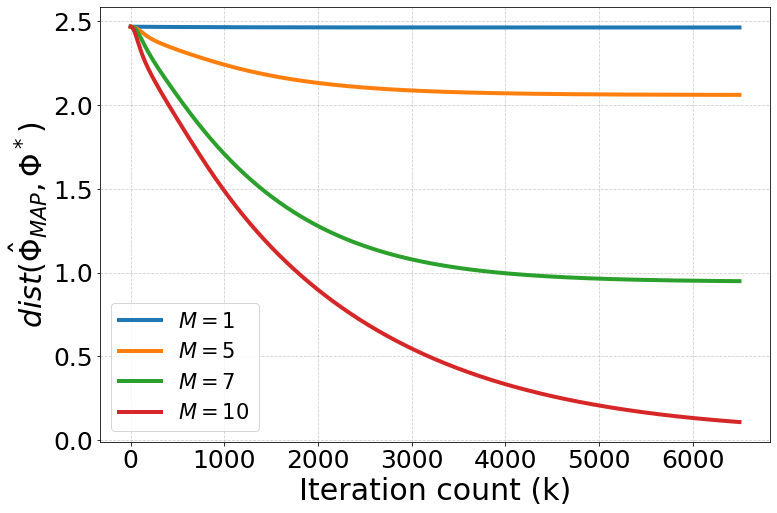

In [533]:
# Create a plot to show the convergence of the Gibbs Sampler (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(K))), Error_CAMAP_1, label=r'$M = 1$ ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_5, label=r'$M = 5$ ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_7, label=r'$M = 7$ ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_10, label=r'$M = 10$ ', linestyle='-', linewidth=4)

# Set labels and a title
ax.set_xlabel('Iteration count (k)',fontsize=30)
ax.set_ylabel(r'$dist(\hat{\Phi}_{MAP},\Phi^*)$',fontsize=30)
ax.tick_params(axis='both', labelsize=25)
plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:4]  
labels = labels[:4] 
plt.legend(handles=handles, labels=labels,fontsize=21)

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [524]:
H = 10
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])
Phi_hat = Phi_true.dot(rot)
Error_CAMAP, _, Phi_MAP, F_MAP = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.467505503604222, Time: 0.03236532211303711
Iteration: 1, Subspace Dist: 2.467328792525908, Time: 0.017982006072998047
Iteration: 2, Subspace Dist: 2.467124929650863, Time: 0.01799750328063965
Iteration: 3, Subspace Dist: 2.4668941830103526, Time: 0.017962932586669922
Iteration: 4, Subspace Dist: 2.4666366878330788, Time: 0.018650293350219727
Iteration: 5, Subspace Dist: 2.466352461080403, Time: 0.017995357513427734
Iteration: 6, Subspace Dist: 2.466041415121458, Time: 0.017951250076293945
Iteration: 7, Subspace Dist: 2.4657033707021707, Time: 0.01957106590270996
Iteration: 8, Subspace Dist: 2.465338069331148, Time: 0.017952442169189453
Iteration: 9, Subspace Dist: 2.4649451851786646, Time: 0.01797032356262207
Iteration: 10, Subspace Dist: 2.4645243365617944, Time: 0.016968250274658203
Iteration: 11, Subspace Dist: 2.4640750970683163, Time: 0.024199724197387695
Iteration: 12, Subspace Dist: 2.463597006353986, Time: 0.018949508666992188
Iteration: 13, Subsp

Iteration: 118, Subspace Dist: 2.3106761923616648, Time: 0.025800704956054688
Iteration: 119, Subspace Dist: 2.3091921820497543, Time: 0.019634008407592773
Iteration: 120, Subspace Dist: 2.307715739575961, Time: 0.01770782470703125
Iteration: 121, Subspace Dist: 2.3062468509319203, Time: 0.018170833587646484
Iteration: 122, Subspace Dist: 2.3047854969753367, Time: 0.017452478408813477
Iteration: 123, Subspace Dist: 2.303331653693241, Time: 0.01799321174621582
Iteration: 124, Subspace Dist: 2.301885292462545, Time: 0.019619464874267578
Iteration: 125, Subspace Dist: 2.300446380307048, Time: 0.017949819564819336
Iteration: 126, Subspace Dist: 2.2990148801501142, Time: 0.018140316009521484
Iteration: 127, Subspace Dist: 2.2975907510623435, Time: 0.017803192138671875
Iteration: 128, Subspace Dist: 2.2961739485036268, Time: 0.01911616325378418
Iteration: 129, Subspace Dist: 2.2947644245590597, Time: 0.026649951934814453
Iteration: 130, Subspace Dist: 2.2933621281682584, Time: 0.018949985504

Iteration: 226, Subspace Dist: 2.181984906972983, Time: 0.02041482925415039
Iteration: 227, Subspace Dist: 2.180971577779007, Time: 0.020803451538085938
Iteration: 228, Subspace Dist: 2.179959828106683, Time: 0.018969058990478516
Iteration: 229, Subspace Dist: 2.1789496291899977, Time: 0.017850399017333984
Iteration: 230, Subspace Dist: 2.177940952782083, Time: 0.01795506477355957
Iteration: 231, Subspace Dist: 2.176933771148797, Time: 0.018915653228759766
Iteration: 232, Subspace Dist: 2.1759280570622983, Time: 0.01794719696044922
Iteration: 233, Subspace Dist: 2.1749237837946316, Time: 0.01795363426208496
Iteration: 234, Subspace Dist: 2.1739209251113185, Time: 0.018050670623779297
Iteration: 235, Subspace Dist: 2.172919455264948, Time: 0.017950773239135742
Iteration: 236, Subspace Dist: 2.171919348988782, Time: 0.01896047592163086
Iteration: 237, Subspace Dist: 2.1709205814903574, Time: 0.02060413360595703
Iteration: 238, Subspace Dist: 2.1699231284451006, Time: 0.017699241638183594

Iteration: 343, Subspace Dist: 2.0694897861924524, Time: 0.024692296981811523
Iteration: 344, Subspace Dist: 2.0685570775915902, Time: 0.01895761489868164
Iteration: 345, Subspace Dist: 2.0676246293090164, Time: 0.01967167854309082
Iteration: 346, Subspace Dist: 2.0666924381963354, Time: 0.01898050308227539
Iteration: 347, Subspace Dist: 2.0657605011475653, Time: 0.017919301986694336
Iteration: 348, Subspace Dist: 2.0648288150982723, Time: 0.017981529235839844
Iteration: 349, Subspace Dist: 2.063897377024742, Time: 0.018955707550048828
Iteration: 350, Subspace Dist: 2.062966183943173, Time: 0.019946575164794922
Iteration: 351, Subspace Dist: 2.062035232908904, Time: 0.018950223922729492
Iteration: 352, Subspace Dist: 2.061104521015664, Time: 0.01795196533203125
Iteration: 353, Subspace Dist: 2.0601740453948505, Time: 0.01827096939086914
Iteration: 354, Subspace Dist: 2.0592438032148324, Time: 0.021938562393188477
Iteration: 355, Subspace Dist: 2.0583137916802796, Time: 0.01799440383911

Iteration: 451, Subspace Dist: 1.9697878715076704, Time: 0.020984411239624023
Iteration: 452, Subspace Dist: 1.9688712002725202, Time: 0.01821589469909668
Iteration: 453, Subspace Dist: 1.967954609517909, Time: 0.018024682998657227
Iteration: 454, Subspace Dist: 1.9670380987309735, Time: 0.01991748809814453
Iteration: 455, Subspace Dist: 1.9661216674169542, Time: 0.018024206161499023
Iteration: 456, Subspace Dist: 1.965205315099136, Time: 0.018732070922851562
Iteration: 457, Subspace Dist: 1.9642890413187877, Time: 0.01898670196533203
Iteration: 458, Subspace Dist: 1.9633728456351016, Time: 0.018792152404785156
Iteration: 459, Subspace Dist: 1.9624567276251335, Time: 0.01715087890625
Iteration: 460, Subspace Dist: 1.96154068688374, Time: 0.01994776725769043
Iteration: 461, Subspace Dist: 1.9606247230235163, Time: 0.019985198974609375
Iteration: 462, Subspace Dist: 1.9597088356747336, Time: 0.023164749145507812
Iteration: 463, Subspace Dist: 1.9587930244852763, Time: 0.01888418197631836

Iteration: 561, Subspace Dist: 1.8694216036411788, Time: 0.019946813583374023
Iteration: 562, Subspace Dist: 1.8685141902852866, Time: 0.020945072174072266
Iteration: 563, Subspace Dist: 1.867606892729593, Time: 0.018955469131469727
Iteration: 564, Subspace Dist: 1.866699711951136, Time: 0.018486738204956055
Iteration: 565, Subspace Dist: 1.865792648934773, Time: 0.019798755645751953
Iteration: 566, Subspace Dist: 1.8648857046730691, Time: 0.019946575164794922
Iteration: 567, Subspace Dist: 1.8639788801661854, Time: 0.02496957778930664
Iteration: 568, Subspace Dist: 1.8630721764217668, Time: 0.018948793411254883
Iteration: 569, Subspace Dist: 1.8621655944548299, Time: 0.019946575164794922
Iteration: 570, Subspace Dist: 1.861259135287653, Time: 0.018949270248413086
Iteration: 571, Subspace Dist: 1.8603527999496625, Time: 0.022047042846679688
Iteration: 572, Subspace Dist: 1.8594465894773238, Time: 0.01992940902709961
Iteration: 573, Subspace Dist: 1.8585405049140278, Time: 0.01894950866

Iteration: 672, Subspace Dist: 1.7696554562141549, Time: 0.019947290420532227
Iteration: 673, Subspace Dist: 1.7687679607740932, Time: 0.018878698348999023
Iteration: 674, Subspace Dist: 1.7678807143213406, Time: 0.01907062530517578
Iteration: 675, Subspace Dist: 1.766993718094417, Time: 0.01992511749267578
Iteration: 676, Subspace Dist: 1.7661069733297192, Time: 0.021860837936401367
Iteration: 677, Subspace Dist: 1.7652204812614642, Time: 0.021408796310424805
Iteration: 678, Subspace Dist: 1.764334243121633, Time: 0.021770715713500977
Iteration: 679, Subspace Dist: 1.7634482601399162, Time: 0.021943330764770508
Iteration: 680, Subspace Dist: 1.76256253354366, Time: 0.018979310989379883
Iteration: 681, Subspace Dist: 1.761677064557811, Time: 0.01883983612060547
Iteration: 682, Subspace Dist: 1.7607918544048642, Time: 0.020977258682250977
Iteration: 683, Subspace Dist: 1.7599069043048097, Time: 0.020867109298706055
Iteration: 684, Subspace Dist: 1.7590222154750816, Time: 0.0243251323699

Iteration: 786, Subspace Dist: 1.670361749965829, Time: 0.021729469299316406
Iteration: 787, Subspace Dist: 1.6695098207046586, Time: 0.023899078369140625
Iteration: 788, Subspace Dist: 1.6686582584641707, Time: 0.01995992660522461
Iteration: 789, Subspace Dist: 1.6678070640206837, Time: 0.018834590911865234
Iteration: 790, Subspace Dist: 1.666956238145603, Time: 0.021830081939697266
Iteration: 791, Subspace Dist: 1.6661057816054297, Time: 0.024106979370117188
Iteration: 792, Subspace Dist: 1.6652556951617563, Time: 0.01979374885559082
Iteration: 793, Subspace Dist: 1.6644059795712702, Time: 0.019456148147583008
Iteration: 794, Subspace Dist: 1.6635566355857558, Time: 0.019905567169189453
Iteration: 795, Subspace Dist: 1.6627076639520941, Time: 0.022429943084716797
Iteration: 796, Subspace Dist: 1.661859065412268, Time: 0.022906780242919922
Iteration: 797, Subspace Dist: 1.6610108407033646, Time: 0.01994800567626953
Iteration: 798, Subspace Dist: 1.6601629905575728, Time: 0.02188849449

Iteration: 893, Subspace Dist: 1.5814159810373543, Time: 0.02092123031616211
Iteration: 894, Subspace Dist: 1.5806067807423825, Time: 0.016922950744628906
Iteration: 895, Subspace Dist: 1.579798004032282, Time: 0.01795363426208496
Iteration: 896, Subspace Dist: 1.5789896512047175, Time: 0.01764655113220215
Iteration: 897, Subspace Dist: 1.5781817225535855, Time: 0.0169525146484375
Iteration: 898, Subspace Dist: 1.577374218369035, Time: 0.01795220375061035
Iteration: 899, Subspace Dist: 1.5765671389374765, Time: 0.017029762268066406
Iteration: 900, Subspace Dist: 1.5757604845416031, Time: 0.01799774169921875
Iteration: 901, Subspace Dist: 1.574954255460404, Time: 0.01696014404296875
Iteration: 902, Subspace Dist: 1.5741484519691786, Time: 0.01795053482055664
Iteration: 903, Subspace Dist: 1.573343074339558, Time: 0.017054319381713867
Iteration: 904, Subspace Dist: 1.572538122839514, Time: 0.025573015213012695
Iteration: 905, Subspace Dist: 1.57173359773338, Time: 0.021574974060058594
It

Iteration: 1005, Subspace Dist: 1.493465119694267, Time: 0.019083023071289062
Iteration: 1006, Subspace Dist: 1.4927044504825278, Time: 0.017487764358520508
Iteration: 1007, Subspace Dist: 1.491944218347986, Time: 0.01795196533203125
Iteration: 1008, Subspace Dist: 1.4911844232624538, Time: 0.016897201538085938
Iteration: 1009, Subspace Dist: 1.4904250651956457, Time: 0.018947839736938477
Iteration: 1010, Subspace Dist: 1.4896661441151902, Time: 0.016837120056152344
Iteration: 1011, Subspace Dist: 1.488907659986647, Time: 0.023821353912353516
Iteration: 1012, Subspace Dist: 1.4881496127735132, Time: 0.015961170196533203
Iteration: 1013, Subspace Dist: 1.4873920024372396, Time: 0.01798081398010254
Iteration: 1014, Subspace Dist: 1.4866348289372449, Time: 0.01692652702331543
Iteration: 1015, Subspace Dist: 1.4858780922309245, Time: 0.01995062828063965
Iteration: 1016, Subspace Dist: 1.485121792273663, Time: 0.021332263946533203
Iteration: 1017, Subspace Dist: 1.4843659290188518, Time: 0.

Iteration: 1117, Subspace Dist: 1.4109691795730868, Time: 0.02305150032043457
Iteration: 1118, Subspace Dist: 1.4102568822525496, Time: 0.018765926361083984
Iteration: 1119, Subspace Dist: 1.4095450084123002, Time: 0.01795053482055664
Iteration: 1120, Subspace Dist: 1.408833557857256, Time: 0.0190274715423584
Iteration: 1121, Subspace Dist: 1.4081225303913685, Time: 0.018909454345703125
Iteration: 1122, Subspace Dist: 1.407411925817621, Time: 0.020566940307617188
Iteration: 1123, Subspace Dist: 1.4067017439380454, Time: 0.017871618270874023
Iteration: 1124, Subspace Dist: 1.4059919845537205, Time: 0.017969369888305664
Iteration: 1125, Subspace Dist: 1.4052826474647866, Time: 0.017922639846801758
Iteration: 1126, Subspace Dist: 1.4045737324704495, Time: 0.017853736877441406
Iteration: 1127, Subspace Dist: 1.403865239368988, Time: 0.01795029640197754
Iteration: 1128, Subspace Dist: 1.4031571679577632, Time: 0.02012491226196289
Iteration: 1129, Subspace Dist: 1.402449518033222, Time: 0.01

Iteration: 1229, Subspace Dist: 1.3337746639222572, Time: 0.024897336959838867
Iteration: 1230, Subspace Dist: 1.3331084044731998, Time: 0.019956350326538086
Iteration: 1231, Subspace Dist: 1.3324425421195316, Time: 0.019019126892089844
Iteration: 1232, Subspace Dist: 1.331777076596493, Time: 0.018909215927124023
Iteration: 1233, Subspace Dist: 1.3311120076389955, Time: 0.01751112937927246
Iteration: 1234, Subspace Dist: 1.330447334981624, Time: 0.01994800567626953
Iteration: 1235, Subspace Dist: 1.329783058358643, Time: 0.018949270248413086
Iteration: 1236, Subspace Dist: 1.329119177504001, Time: 0.02294182777404785
Iteration: 1237, Subspace Dist: 1.328455692151333, Time: 0.019943952560424805
Iteration: 1238, Subspace Dist: 1.3277926020339652, Time: 0.020947694778442383
Iteration: 1239, Subspace Dist: 1.3271299068849196, Time: 0.02097463607788086
Iteration: 1240, Subspace Dist: 1.3264676064369174, Time: 0.018975019454956055
Iteration: 1241, Subspace Dist: 1.3258057004223847, Time: 0.0

Iteration: 1339, Subspace Dist: 1.2628081408420788, Time: 0.021801471710205078
Iteration: 1340, Subspace Dist: 1.262183925402201, Time: 0.01785135269165039
Iteration: 1341, Subspace Dist: 1.2615600767538406, Time: 0.017841339111328125
Iteration: 1342, Subspace Dist: 1.2609365946170834, Time: 0.0199587345123291
Iteration: 1343, Subspace Dist: 1.2603134787120363, Time: 0.02075028419494629
Iteration: 1344, Subspace Dist: 1.2596907287588306, Time: 0.017900943756103516
Iteration: 1345, Subspace Dist: 1.259068344477629, Time: 0.01991438865661621
Iteration: 1346, Subspace Dist: 1.2584463255886191, Time: 0.017951011657714844
Iteration: 1347, Subspace Dist: 1.2578246718120218, Time: 0.017632484436035156
Iteration: 1348, Subspace Dist: 1.2572033828680944, Time: 0.017536640167236328
Iteration: 1349, Subspace Dist: 1.2565824584771286, Time: 0.0189516544342041
Iteration: 1350, Subspace Dist: 1.2559618983594556, Time: 0.020671606063842773
Iteration: 1351, Subspace Dist: 1.2553417022354467, Time: 0.0

Iteration: 1452, Subspace Dist: 1.1945277553453677, Time: 0.023880720138549805
Iteration: 1453, Subspace Dist: 1.1939432345702878, Time: 0.017925739288330078
Iteration: 1454, Subspace Dist: 1.193359049564333, Time: 0.018914222717285156
Iteration: 1455, Subspace Dist: 1.192775200062, Time: 0.019018173217773438
Iteration: 1456, Subspace Dist: 1.1921916857979933, Time: 0.016922473907470703
Iteration: 1457, Subspace Dist: 1.1916085065072293, Time: 0.018394947052001953
Iteration: 1458, Subspace Dist: 1.1910256619248374, Time: 0.017922163009643555
Iteration: 1459, Subspace Dist: 1.1904431517861582, Time: 0.017024755477905273
Iteration: 1460, Subspace Dist: 1.1898609758267487, Time: 0.01895880699157715
Iteration: 1461, Subspace Dist: 1.1892791337823787, Time: 0.018393754959106445
Iteration: 1462, Subspace Dist: 1.1886976253890353, Time: 0.0179140567779541
Iteration: 1463, Subspace Dist: 1.1881164503829236, Time: 0.022836923599243164
Iteration: 1464, Subspace Dist: 1.1875356085004634, Time: 0.

Iteration: 1564, Subspace Dist: 1.1310894790045407, Time: 0.02232503890991211
Iteration: 1565, Subspace Dist: 1.1305409671772948, Time: 0.01823115348815918
Iteration: 1566, Subspace Dist: 1.129992762872625, Time: 0.01793217658996582
Iteration: 1567, Subspace Dist: 1.1294448658531138, Time: 0.01798701286315918
Iteration: 1568, Subspace Dist: 1.128897275881617, Time: 0.018001556396484375
Iteration: 1569, Subspace Dist: 1.1283499927212688, Time: 0.018928050994873047
Iteration: 1570, Subspace Dist: 1.1278030161354786, Time: 0.018379926681518555
Iteration: 1571, Subspace Dist: 1.1272563458879328, Time: 0.019025802612304688
Iteration: 1572, Subspace Dist: 1.1267099817425956, Time: 0.02067422866821289
Iteration: 1573, Subspace Dist: 1.1261639234637058, Time: 0.018949270248413086
Iteration: 1574, Subspace Dist: 1.1256181708157806, Time: 0.017952919006347656
Iteration: 1575, Subspace Dist: 1.1250727235636158, Time: 0.019946813583374023
Iteration: 1576, Subspace Dist: 1.1245275814722828, Time: 0

Iteration: 1676, Subspace Dist: 1.0715153294755793, Time: 0.021824359893798828
Iteration: 1677, Subspace Dist: 1.0709998477770966, Time: 0.019964218139648438
Iteration: 1678, Subspace Dist: 1.0704846487377366, Time: 0.017838716506958008
Iteration: 1679, Subspace Dist: 1.0699697321510548, Time: 0.017786264419555664
Iteration: 1680, Subspace Dist: 1.069455097810873, Time: 0.018536806106567383
Iteration: 1681, Subspace Dist: 1.0689407455112823, Time: 0.018186092376708984
Iteration: 1682, Subspace Dist: 1.0684266750466413, Time: 0.018909215927124023
Iteration: 1683, Subspace Dist: 1.0679128862115783, Time: 0.01795482635498047
Iteration: 1684, Subspace Dist: 1.0673993788009868, Time: 0.016943693161010742
Iteration: 1685, Subspace Dist: 1.0668861526100284, Time: 0.0168609619140625
Iteration: 1686, Subspace Dist: 1.0663732074341308, Time: 0.016907930374145508
Iteration: 1687, Subspace Dist: 1.0658605430689903, Time: 0.016927480697631836
Iteration: 1688, Subspace Dist: 1.0653481593105678, Time

Iteration: 1781, Subspace Dist: 1.018895624938052, Time: 0.020419597625732422
Iteration: 1782, Subspace Dist: 1.0184087441646887, Time: 0.01934957504272461
Iteration: 1783, Subspace Dist: 1.0179221257824524, Time: 0.016920089721679688
Iteration: 1784, Subspace Dist: 1.0174357696113614, Time: 0.018211841583251953
Iteration: 1785, Subspace Dist: 1.0169496754716718, Time: 0.017084121704101562
Iteration: 1786, Subspace Dist: 1.016463843183868, Time: 0.01778697967529297
Iteration: 1787, Subspace Dist: 1.01597827256867, Time: 0.017030954360961914
Iteration: 1788, Subspace Dist: 1.0154929634470269, Time: 0.01795220375061035
Iteration: 1789, Subspace Dist: 1.0150079156401248, Time: 0.021030902862548828
Iteration: 1790, Subspace Dist: 1.0145231289693755, Time: 0.026884794235229492
Iteration: 1791, Subspace Dist: 1.014038603256426, Time: 0.017000436782836914
Iteration: 1792, Subspace Dist: 1.0135543383231542, Time: 0.021470308303833008
Iteration: 1793, Subspace Dist: 1.0130703339916665, Time: 0.

Iteration: 1893, Subspace Dist: 0.9659563811796208, Time: 0.02025437355041504
Iteration: 1894, Subspace Dist: 0.9654978203958855, Time: 0.01795816421508789
Iteration: 1895, Subspace Dist: 0.9650395032140195, Time: 0.017987966537475586
Iteration: 1896, Subspace Dist: 0.9645814294779606, Time: 0.017914295196533203
Iteration: 1897, Subspace Dist: 0.9641235990318496, Time: 0.016954660415649414
Iteration: 1898, Subspace Dist: 0.9636660117200161, Time: 0.023206710815429688
Iteration: 1899, Subspace Dist: 0.9632086673869881, Time: 0.017958879470825195
Iteration: 1900, Subspace Dist: 0.9627515658774843, Time: 0.016953229904174805
Iteration: 1901, Subspace Dist: 0.962294707036416, Time: 0.016987085342407227
Iteration: 1902, Subspace Dist: 0.9618380907088888, Time: 0.01699042320251465
Iteration: 1903, Subspace Dist: 0.9613817167402025, Time: 0.017953872680664062
Iteration: 1904, Subspace Dist: 0.960925584975848, Time: 0.019979238510131836
Iteration: 1905, Subspace Dist: 0.960469695261507, Time: 

Iteration: 2004, Subspace Dist: 0.9165098350698196, Time: 0.020961761474609375
Iteration: 2005, Subspace Dist: 0.9160774027649128, Time: 0.021928787231445312
Iteration: 2006, Subspace Dist: 0.9156451978631805, Time: 0.01784539222717285
Iteration: 2007, Subspace Dist: 0.9152132202284381, Time: 0.017660140991210938
Iteration: 2008, Subspace Dist: 0.914781469724665, Time: 0.016325950622558594
Iteration: 2009, Subspace Dist: 0.9143499462160052, Time: 0.01702404022216797
Iteration: 2010, Subspace Dist: 0.9139186495667657, Time: 0.016995668411254883
Iteration: 2011, Subspace Dist: 0.9134875796414182, Time: 0.01795816421508789
Iteration: 2012, Subspace Dist: 0.9130567363046002, Time: 0.01898789405822754
Iteration: 2013, Subspace Dist: 0.9126261194211064, Time: 0.016530275344848633
Iteration: 2014, Subspace Dist: 0.9121957288559022, Time: 0.01598644256591797
Iteration: 2015, Subspace Dist: 0.9117655644741116, Time: 0.02094864845275879
Iteration: 2016, Subspace Dist: 0.9113356261410234, Time: 0

Iteration: 2114, Subspace Dist: 0.8702770948698095, Time: 0.02091383934020996
Iteration: 2115, Subspace Dist: 0.8698688947189672, Time: 0.01748490333557129
Iteration: 2116, Subspace Dist: 0.869460907929899, Time: 0.01698899269104004
Iteration: 2117, Subspace Dist: 0.8690531343832127, Time: 0.01702404022216797
Iteration: 2118, Subspace Dist: 0.8686455739596602, Time: 0.017577409744262695
Iteration: 2119, Subspace Dist: 0.8682382265401298, Time: 0.016956090927124023
Iteration: 2120, Subspace Dist: 0.8678310920056562, Time: 0.01695537567138672
Iteration: 2121, Subspace Dist: 0.8674241702374101, Time: 0.017954111099243164
Iteration: 2122, Subspace Dist: 0.8670174611167055, Time: 0.019948959350585938
Iteration: 2123, Subspace Dist: 0.8666109645249949, Time: 0.01804947853088379
Iteration: 2124, Subspace Dist: 0.8662046803438694, Time: 0.022971391677856445
Iteration: 2125, Subspace Dist: 0.8657986084550636, Time: 0.02296614646911621
Iteration: 2126, Subspace Dist: 0.8653927487404492, Time: 0.

Iteration: 2223, Subspace Dist: 0.8270148230255672, Time: 0.021056175231933594
Iteration: 2224, Subspace Dist: 0.826629205073513, Time: 0.017946481704711914
Iteration: 2225, Subspace Dist: 0.8262437882578613, Time: 0.016989707946777344
Iteration: 2226, Subspace Dist: 0.8258585724734179, Time: 0.017953872680664062
Iteration: 2227, Subspace Dist: 0.8254735576151079, Time: 0.019919872283935547
Iteration: 2228, Subspace Dist: 0.8250887435779717, Time: 0.018021345138549805
Iteration: 2229, Subspace Dist: 0.8247041302571725, Time: 0.01799917221069336
Iteration: 2230, Subspace Dist: 0.8243197175479894, Time: 0.020978212356567383
Iteration: 2231, Subspace Dist: 0.8239355053458234, Time: 0.027924299240112305
Iteration: 2232, Subspace Dist: 0.8235514935461877, Time: 0.019952058792114258
Iteration: 2233, Subspace Dist: 0.8231676820447191, Time: 0.02035689353942871
Iteration: 2234, Subspace Dist: 0.822784070737171, Time: 0.017914772033691406
Iteration: 2235, Subspace Dist: 0.8224006595194127, Time

Iteration: 2328, Subspace Dist: 0.7876039730136578, Time: 0.02493429183959961
Iteration: 2329, Subspace Dist: 0.7872389213880533, Time: 0.020540714263916016
Iteration: 2330, Subspace Dist: 0.7868740604659664, Time: 0.017963647842407227
Iteration: 2331, Subspace Dist: 0.7865093901536047, Time: 0.017464160919189453
Iteration: 2332, Subspace Dist: 0.7861449103572744, Time: 0.016961336135864258
Iteration: 2333, Subspace Dist: 0.7857806209833776, Time: 0.018024921417236328
Iteration: 2334, Subspace Dist: 0.7854165219384188, Time: 0.01734185218811035
Iteration: 2335, Subspace Dist: 0.7850526131289934, Time: 0.01795673370361328
Iteration: 2336, Subspace Dist: 0.7846888944617971, Time: 0.035867929458618164
Iteration: 2337, Subspace Dist: 0.7843253658436228, Time: 0.03690147399902344
Iteration: 2338, Subspace Dist: 0.7839620271813569, Time: 0.035944461822509766
Iteration: 2339, Subspace Dist: 0.783598878381987, Time: 0.01853656768798828
Iteration: 2340, Subspace Dist: 0.7832359193525934, Time: 

Iteration: 2436, Subspace Dist: 0.7492616359521685, Time: 0.029755353927612305
Iteration: 2437, Subspace Dist: 0.7489166572695962, Time: 0.03556203842163086
Iteration: 2438, Subspace Dist: 0.7485718596853005, Time: 0.038896799087524414
Iteration: 2439, Subspace Dist: 0.7482272431149043, Time: 0.027926206588745117
Iteration: 2440, Subspace Dist: 0.7478828074741048, Time: 0.022940635681152344
Iteration: 2441, Subspace Dist: 0.7475385526786782, Time: 0.02293992042541504
Iteration: 2442, Subspace Dist: 0.7471944786444727, Time: 0.017956972122192383
Iteration: 2443, Subspace Dist: 0.7468505852874179, Time: 0.018956899642944336
Iteration: 2444, Subspace Dist: 0.7465068725235157, Time: 0.0239715576171875
Iteration: 2445, Subspace Dist: 0.7461633402688422, Time: 0.018468618392944336
Iteration: 2446, Subspace Dist: 0.7458199884395554, Time: 0.019946575164794922
Iteration: 2447, Subspace Dist: 0.7454768169518815, Time: 0.018947839736938477
Iteration: 2448, Subspace Dist: 0.745133825722126, Time:

Iteration: 2547, Subspace Dist: 0.7120563261540884, Time: 0.02140331268310547
Iteration: 2548, Subspace Dist: 0.7117309501548954, Time: 0.02167797088623047
Iteration: 2549, Subspace Dist: 0.7114057463157372, Time: 0.01788949966430664
Iteration: 2550, Subspace Dist: 0.7110807145596554, Time: 0.017947912216186523
Iteration: 2551, Subspace Dist: 0.7107558548097538, Time: 0.01991415023803711
Iteration: 2552, Subspace Dist: 0.7104311669891887, Time: 0.01817488670349121
Iteration: 2553, Subspace Dist: 0.7101066510211743, Time: 0.017949581146240234
Iteration: 2554, Subspace Dist: 0.7097823068289861, Time: 0.01798272132873535
Iteration: 2555, Subspace Dist: 0.7094581343359501, Time: 0.01704096794128418
Iteration: 2556, Subspace Dist: 0.709134133465452, Time: 0.018944740295410156
Iteration: 2557, Subspace Dist: 0.7088103041409375, Time: 0.01785731315612793
Iteration: 2558, Subspace Dist: 0.7084866462859043, Time: 0.021705150604248047
Iteration: 2559, Subspace Dist: 0.7081631598239091, Time: 0.0

Iteration: 2655, Subspace Dist: 0.6778950397758751, Time: 0.021807432174682617
Iteration: 2656, Subspace Dist: 0.6775878233730049, Time: 0.01895761489868164
Iteration: 2657, Subspace Dist: 0.677280771122028, Time: 0.01998305320739746
Iteration: 2658, Subspace Dist: 0.6769738829513878, Time: 0.018958091735839844
Iteration: 2659, Subspace Dist: 0.6766671587895757, Time: 0.018982410430908203
Iteration: 2660, Subspace Dist: 0.6763605985651263, Time: 0.01795196533203125
Iteration: 2661, Subspace Dist: 0.6760542022066107, Time: 0.01798844337463379
Iteration: 2662, Subspace Dist: 0.6757479696426527, Time: 0.020937681198120117
Iteration: 2663, Subspace Dist: 0.6754419008019086, Time: 0.0189206600189209
Iteration: 2664, Subspace Dist: 0.6751359956130867, Time: 0.019757509231567383
Iteration: 2665, Subspace Dist: 0.6748302540049314, Time: 0.017960786819458008
Iteration: 2666, Subspace Dist: 0.6745246759062317, Time: 0.023970365524291992
Iteration: 2667, Subspace Dist: 0.6742192612458178, Time: 0

Iteration: 2765, Subspace Dist: 0.6450701190741946, Time: 0.020570755004882812
Iteration: 2766, Subspace Dist: 0.6447805391053586, Time: 0.017862796783447266
Iteration: 2767, Subspace Dist: 0.6444911156534097, Time: 0.017900466918945312
Iteration: 2768, Subspace Dist: 0.6442018486509262, Time: 0.01689767837524414
Iteration: 2769, Subspace Dist: 0.6439127380305258, Time: 0.01970696449279785
Iteration: 2770, Subspace Dist: 0.6436237837248548, Time: 0.01848578453063965
Iteration: 2771, Subspace Dist: 0.6433349856665928, Time: 0.017868518829345703
Iteration: 2772, Subspace Dist: 0.6430463437884529, Time: 0.017990827560424805
Iteration: 2773, Subspace Dist: 0.6427578580231762, Time: 0.019972801208496094
Iteration: 2774, Subspace Dist: 0.64246952830354, Time: 0.016953229904174805
Iteration: 2775, Subspace Dist: 0.6421813545623569, Time: 0.01795196533203125
Iteration: 2776, Subspace Dist: 0.641893336732463, Time: 0.020914316177368164
Iteration: 2777, Subspace Dist: 0.6416054747467349, Time: 0

Iteration: 2875, Subspace Dist: 0.6141402711449225, Time: 0.021561622619628906
Iteration: 2876, Subspace Dist: 0.6138675105167044, Time: 0.017919301986694336
Iteration: 2877, Subspace Dist: 0.613594899170753, Time: 0.016952991485595703
Iteration: 2878, Subspace Dist: 0.6133224370428558, Time: 0.017983675003051758
Iteration: 2879, Subspace Dist: 0.6130501240688266, Time: 0.017920970916748047
Iteration: 2880, Subspace Dist: 0.6127779601845079, Time: 0.022795438766479492
Iteration: 2881, Subspace Dist: 0.6125059453257626, Time: 0.017934560775756836
Iteration: 2882, Subspace Dist: 0.6122340794284856, Time: 0.01851177215576172
Iteration: 2883, Subspace Dist: 0.6119623624285958, Time: 0.017890453338623047
Iteration: 2884, Subspace Dist: 0.6116907942620347, Time: 0.01697087287902832
Iteration: 2885, Subspace Dist: 0.6114193748647726, Time: 0.019853591918945312
Iteration: 2886, Subspace Dist: 0.6111481041728077, Time: 0.02005481719970703
Iteration: 2887, Subspace Dist: 0.6108769821221589, Time

Iteration: 2984, Subspace Dist: 0.5852746981764402, Time: 0.01980280876159668
Iteration: 2985, Subspace Dist: 0.5850178366162931, Time: 0.01786971092224121
Iteration: 2986, Subspace Dist: 0.5847611174846052, Time: 0.021938323974609375
Iteration: 2987, Subspace Dist: 0.5845045407197874, Time: 0.0178225040435791
Iteration: 2988, Subspace Dist: 0.584248106260267, Time: 0.018697738647460938
Iteration: 2989, Subspace Dist: 0.5839918140445033, Time: 0.017204999923706055
Iteration: 2990, Subspace Dist: 0.5837356640109685, Time: 0.01776266098022461
Iteration: 2991, Subspace Dist: 0.5834796560981691, Time: 0.018650054931640625
Iteration: 2992, Subspace Dist: 0.5832237902446168, Time: 0.017950057983398438
Iteration: 2993, Subspace Dist: 0.5829680663888642, Time: 0.0169675350189209
Iteration: 2994, Subspace Dist: 0.5827124844694698, Time: 0.01797962188720703
Iteration: 2995, Subspace Dist: 0.5824570444250275, Time: 0.01994156837463379
Iteration: 2996, Subspace Dist: 0.5822017461941444, Time: 0.01

Iteration: 3096, Subspace Dist: 0.5573776369062232, Time: 0.019795894622802734
Iteration: 3097, Subspace Dist: 0.5571363494466325, Time: 0.017931461334228516
Iteration: 3098, Subspace Dist: 0.5568951976514904, Time: 0.018137454986572266
Iteration: 3099, Subspace Dist: 0.5566541814615853, Time: 0.018744468688964844
Iteration: 3100, Subspace Dist: 0.5564133008177321, Time: 0.01695418357849121
Iteration: 3101, Subspace Dist: 0.5561725556607549, Time: 0.01698756217956543
Iteration: 3102, Subspace Dist: 0.5559319459315036, Time: 0.017397403717041016
Iteration: 3103, Subspace Dist: 0.5556914715708499, Time: 0.017778873443603516
Iteration: 3104, Subspace Dist: 0.5554511325196806, Time: 0.01795029640197754
Iteration: 3105, Subspace Dist: 0.55521092871891, Time: 0.017937183380126953
Iteration: 3106, Subspace Dist: 0.5549708601094648, Time: 0.019980430603027344
Iteration: 3107, Subspace Dist: 0.5547309266322964, Time: 0.019514799118041992
Iteration: 3108, Subspace Dist: 0.5544911282283801, Time:

Iteration: 3206, Subspace Dist: 0.5316366618198876, Time: 0.01996898651123047
Iteration: 3207, Subspace Dist: 0.5314099468063583, Time: 0.01800680160522461
Iteration: 3208, Subspace Dist: 0.531183361063774, Time: 0.016956567764282227
Iteration: 3209, Subspace Dist: 0.530956904535106, Time: 0.017872333526611328
Iteration: 3210, Subspace Dist: 0.5307305771633424, Time: 0.016826391220092773
Iteration: 3211, Subspace Dist: 0.5305043788914912, Time: 0.017899513244628906
Iteration: 3212, Subspace Dist: 0.5302783096625809, Time: 0.021933317184448242
Iteration: 3213, Subspace Dist: 0.5300523694196531, Time: 0.016991138458251953
Iteration: 3214, Subspace Dist: 0.5298265581057778, Time: 0.017083168029785156
Iteration: 3215, Subspace Dist: 0.5296008756640376, Time: 0.01897454261779785
Iteration: 3216, Subspace Dist: 0.5293753220375369, Time: 0.01792001724243164
Iteration: 3217, Subspace Dist: 0.5291498971694045, Time: 0.018039226531982422
Iteration: 3218, Subspace Dist: 0.5289246010027769, Time: 

Iteration: 3320, Subspace Dist: 0.5066101991900099, Time: 0.025934696197509766
Iteration: 3321, Subspace Dist: 0.5063978583574432, Time: 0.018022775650024414
Iteration: 3322, Subspace Dist: 0.5061856404180247, Time: 0.019801616668701172
Iteration: 3323, Subspace Dist: 0.505973545316902, Time: 0.019832134246826172
Iteration: 3324, Subspace Dist: 0.50576157299925, Time: 0.01798105239868164
Iteration: 3325, Subspace Dist: 0.5055497234102482, Time: 0.017982006072998047
Iteration: 3326, Subspace Dist: 0.5053379964951086, Time: 0.017361164093017578
Iteration: 3327, Subspace Dist: 0.5051263921990526, Time: 0.018884658813476562
Iteration: 3328, Subspace Dist: 0.504914910467328, Time: 0.017984867095947266
Iteration: 3329, Subspace Dist: 0.5047035512451931, Time: 0.01790928840637207
Iteration: 3330, Subspace Dist: 0.5044923144779342, Time: 0.0178987979888916
Iteration: 3331, Subspace Dist: 0.5042812001108474, Time: 0.020992755889892578
Iteration: 3332, Subspace Dist: 0.5040702080892572, Time: 0.

Iteration: 3431, Subspace Dist: 0.4837785755226568, Time: 0.019911527633666992
Iteration: 3432, Subspace Dist: 0.48357954513835727, Time: 0.018901586532592773
Iteration: 3433, Subspace Dist: 0.4833806316733984, Time: 0.01781630516052246
Iteration: 3434, Subspace Dist: 0.48318183507501256, Time: 0.017960786819458008
Iteration: 3435, Subspace Dist: 0.48298315529043767, Time: 0.01792168617248535
Iteration: 3436, Subspace Dist: 0.4827845922669369, Time: 0.021229982376098633
Iteration: 3437, Subspace Dist: 0.4825861459517932, Time: 0.018151521682739258
Iteration: 3438, Subspace Dist: 0.4823878162923088, Time: 0.017946958541870117
Iteration: 3439, Subspace Dist: 0.4821896032357975, Time: 0.018983840942382812
Iteration: 3440, Subspace Dist: 0.481991506729602, Time: 0.02008986473083496
Iteration: 3441, Subspace Dist: 0.48179352672107056, Time: 0.01892375946044922
Iteration: 3442, Subspace Dist: 0.4815956631575852, Time: 0.024084806442260742
Iteration: 3443, Subspace Dist: 0.4813979159865319, T

Iteration: 3541, Subspace Dist: 0.46257488141125835, Time: 0.02422928810119629
Iteration: 3542, Subspace Dist: 0.4623883997471465, Time: 0.016986608505249023
Iteration: 3543, Subspace Dist: 0.4622020293073742, Time: 0.017763853073120117
Iteration: 3544, Subspace Dist: 0.4620157700411817, Time: 0.01755046844482422
Iteration: 3545, Subspace Dist: 0.4618296218978191, Time: 0.017980575561523438
Iteration: 3546, Subspace Dist: 0.4616435848265717, Time: 0.021909236907958984
Iteration: 3547, Subspace Dist: 0.46145765877672434, Time: 0.0189511775970459
Iteration: 3548, Subspace Dist: 0.46127184369758956, Time: 0.019946813583374023
Iteration: 3549, Subspace Dist: 0.46108613953849925, Time: 0.017952680587768555
Iteration: 3550, Subspace Dist: 0.46090054624879684, Time: 0.01895284652709961
Iteration: 3551, Subspace Dist: 0.4607150637778473, Time: 0.018900632858276367
Iteration: 3552, Subspace Dist: 0.4605296920750381, Time: 0.020972251892089844
Iteration: 3553, Subspace Dist: 0.4603444310897641, 

Iteration: 3652, Subspace Dist: 0.44254328921698816, Time: 0.021898508071899414
Iteration: 3653, Subspace Dist: 0.4423688475338417, Time: 0.02693009376525879
Iteration: 3654, Subspace Dist: 0.4421945115497037, Time: 0.05530357360839844
Iteration: 3655, Subspace Dist: 0.44202028121577747, Time: 0.05485177040100098
Iteration: 3656, Subspace Dist: 0.4418461564832975, Time: 0.033908843994140625
Iteration: 3657, Subspace Dist: 0.4416721373035116, Time: 0.02892327308654785
Iteration: 3658, Subspace Dist: 0.44149822362768393, Time: 0.03391623497009277
Iteration: 3659, Subspace Dist: 0.4413244154070981, Time: 0.01776599884033203
Iteration: 3660, Subspace Dist: 0.44115071259305655, Time: 0.022822856903076172
Iteration: 3661, Subspace Dist: 0.44097711513686955, Time: 0.019951581954956055
Iteration: 3662, Subspace Dist: 0.44080362298987824, Time: 0.017858266830444336
Iteration: 3663, Subspace Dist: 0.44063023610343105, Time: 0.01845264434814453
Iteration: 3664, Subspace Dist: 0.44045695442890176,

Iteration: 3758, Subspace Dist: 0.42463135990586304, Time: 0.020982980728149414
Iteration: 3759, Subspace Dist: 0.4244678541566877, Time: 0.020659685134887695
Iteration: 3760, Subspace Dist: 0.42430444903112136, Time: 0.017951488494873047
Iteration: 3761, Subspace Dist: 0.4241411444821923, Time: 0.01772165298461914
Iteration: 3762, Subspace Dist: 0.42397794046295123, Time: 0.018958568572998047
Iteration: 3763, Subspace Dist: 0.42381483692646, Time: 0.016983747482299805
Iteration: 3764, Subspace Dist: 0.42365183382579713, Time: 0.018189668655395508
Iteration: 3765, Subspace Dist: 0.4234889311140662, Time: 0.01840829849243164
Iteration: 3766, Subspace Dist: 0.4233261287443762, Time: 0.02377176284790039
Iteration: 3767, Subspace Dist: 0.42316342666985723, Time: 0.018197298049926758
Iteration: 3768, Subspace Dist: 0.42300082484365975, Time: 0.017758846282958984
Iteration: 3769, Subspace Dist: 0.42283832321894727, Time: 0.019942522048950195
Iteration: 3770, Subspace Dist: 0.4226759217488987

Iteration: 3870, Subspace Dist: 0.40693359033309545, Time: 0.02293252944946289
Iteration: 3871, Subspace Dist: 0.40678106624670146, Time: 0.01764082908630371
Iteration: 3872, Subspace Dist: 0.40662863762603474, Time: 0.024981975555419922
Iteration: 3873, Subspace Dist: 0.40647630442596666, Time: 0.018974781036376953
Iteration: 3874, Subspace Dist: 0.4063240666013779, Time: 0.0179445743560791
Iteration: 3875, Subspace Dist: 0.4061719241071652, Time: 0.01888728141784668
Iteration: 3876, Subspace Dist: 0.4060198768982458, Time: 0.017504215240478516
Iteration: 3877, Subspace Dist: 0.4058679249295402, Time: 0.018219470977783203
Iteration: 3878, Subspace Dist: 0.4057160681560028, Time: 0.017020702362060547
Iteration: 3879, Subspace Dist: 0.4055643065325947, Time: 0.017796993255615234
Iteration: 3880, Subspace Dist: 0.40541264001428606, Time: 0.01731133460998535
Iteration: 3881, Subspace Dist: 0.405261068556077, Time: 0.01772332191467285
Iteration: 3882, Subspace Dist: 0.4051095921129771, Tim

Iteration: 3981, Subspace Dist: 0.39057631819992583, Time: 0.0209500789642334
Iteration: 3982, Subspace Dist: 0.39043411875975886, Time: 0.018955469131469727
Iteration: 3983, Subspace Dist: 0.3902920098711513, Time: 0.016953229904174805
Iteration: 3984, Subspace Dist: 0.3901499914906945, Time: 0.017867565155029297
Iteration: 3985, Subspace Dist: 0.39000806357499457, Time: 0.016948223114013672
Iteration: 3986, Subspace Dist: 0.3898662260806729, Time: 0.017310142517089844
Iteration: 3987, Subspace Dist: 0.38972447896436124, Time: 0.01795196533203125
Iteration: 3988, Subspace Dist: 0.3895828221827126, Time: 0.017798662185668945
Iteration: 3989, Subspace Dist: 0.38944125569238736, Time: 0.01695704460144043
Iteration: 3990, Subspace Dist: 0.3892997794500762, Time: 0.01761174201965332
Iteration: 3991, Subspace Dist: 0.3891583934124617, Time: 0.017865419387817383
Iteration: 3992, Subspace Dist: 0.3890170975362617, Time: 0.023934125900268555
Iteration: 3993, Subspace Dist: 0.38887589177820175,

Iteration: 4091, Subspace Dist: 0.3754679537360539, Time: 0.021798133850097656
Iteration: 4092, Subspace Dist: 0.3753354579335987, Time: 0.016954660415649414
Iteration: 4093, Subspace Dist: 0.3752030479962991, Time: 0.01691436767578125
Iteration: 4094, Subspace Dist: 0.375070723882358, Time: 0.01789712905883789
Iteration: 4095, Subspace Dist: 0.3749384855499977, Time: 0.017845630645751953
Iteration: 4096, Subspace Dist: 0.37480633295743415, Time: 0.01732492446899414
Iteration: 4097, Subspace Dist: 0.3746742660629229, Time: 0.017980575561523438
Iteration: 4098, Subspace Dist: 0.37454228482471813, Time: 0.01788783073425293
Iteration: 4099, Subspace Dist: 0.3744103892010939, Time: 0.02004075050354004
Iteration: 4100, Subspace Dist: 0.3742785791503323, Time: 0.017914772033691406
Iteration: 4101, Subspace Dist: 0.37414685463073355, Time: 0.019823074340820312
Iteration: 4102, Subspace Dist: 0.3740152156006166, Time: 0.021458864212036133
Iteration: 4103, Subspace Dist: 0.373883662018308, Time

Iteration: 4202, Subspace Dist: 0.36127593892435544, Time: 0.029532670974731445
Iteration: 4203, Subspace Dist: 0.3611527220767518, Time: 0.017539024353027344
Iteration: 4204, Subspace Dist: 0.36102958653962014, Time: 0.016951799392700195
Iteration: 4205, Subspace Dist: 0.3609065322726946, Time: 0.018955469131469727
Iteration: 4206, Subspace Dist: 0.3607835592357202, Time: 0.01926732063293457
Iteration: 4207, Subspace Dist: 0.36066066738845043, Time: 0.01695728302001953
Iteration: 4208, Subspace Dist: 0.3605378566906632, Time: 0.01695394515991211
Iteration: 4209, Subspace Dist: 0.3604151271021327, Time: 0.017444849014282227
Iteration: 4210, Subspace Dist: 0.3602924785826617, Time: 0.016036272048950195
Iteration: 4211, Subspace Dist: 0.3601699110920593, Time: 0.017868518829345703
Iteration: 4212, Subspace Dist: 0.36004742459014843, Time: 0.017718076705932617
Iteration: 4213, Subspace Dist: 0.3599250190367673, Time: 0.022935867309570312
Iteration: 4214, Subspace Dist: 0.35980269439176454

Iteration: 4312, Subspace Dist: 0.3482009271437294, Time: 0.02280402183532715
Iteration: 4313, Subspace Dist: 0.34808641586999395, Time: 0.020211458206176758
Iteration: 4314, Subspace Dist: 0.347971981555507, Time: 0.016611814498901367
Iteration: 4315, Subspace Dist: 0.34785762416143373, Time: 0.017408132553100586
Iteration: 4316, Subspace Dist: 0.34774334364893134, Time: 0.01830124855041504
Iteration: 4317, Subspace Dist: 0.34762913997918543, Time: 0.017019987106323242
Iteration: 4318, Subspace Dist: 0.34751501311338945, Time: 0.018935680389404297
Iteration: 4319, Subspace Dist: 0.3474009630127486, Time: 0.01791977882385254
Iteration: 4320, Subspace Dist: 0.34728698963847876, Time: 0.017918825149536133
Iteration: 4321, Subspace Dist: 0.347173092951813, Time: 0.017910480499267578
Iteration: 4322, Subspace Dist: 0.3470592729139913, Time: 0.01795053482055664
Iteration: 4323, Subspace Dist: 0.3469455294862712, Time: 0.0249025821685791
Iteration: 4324, Subspace Dist: 0.34683186262991855, T

Iteration: 4422, Subspace Dist: 0.33605774599978583, Time: 0.01901412010192871
Iteration: 4423, Subspace Dist: 0.3359514700432701, Time: 0.0179903507232666
Iteration: 4424, Subspace Dist: 0.3358452668470071, Time: 0.017891645431518555
Iteration: 4425, Subspace Dist: 0.33573913637349445, Time: 0.017925500869750977
Iteration: 4426, Subspace Dist: 0.33563307858525, Time: 0.019079923629760742
Iteration: 4427, Subspace Dist: 0.33552709344479237, Time: 0.018056869506835938
Iteration: 4428, Subspace Dist: 0.33542118091465, Time: 0.01784968376159668
Iteration: 4429, Subspace Dist: 0.3353153409573829, Time: 0.023049116134643555
Iteration: 4430, Subspace Dist: 0.33520957353553726, Time: 0.01798081398010254
Iteration: 4431, Subspace Dist: 0.3351038786116908, Time: 0.01790165901184082
Iteration: 4432, Subspace Dist: 0.33499825614842493, Time: 0.017890214920043945
Iteration: 4433, Subspace Dist: 0.33489270610832783, Time: 0.018026351928710938
Iteration: 4434, Subspace Dist: 0.33478722845401004, Tim

Iteration: 4533, Subspace Dist: 0.32469706834813644, Time: 0.020973682403564453
Iteration: 4534, Subspace Dist: 0.32459864243887937, Time: 0.017586708068847656
Iteration: 4535, Subspace Dist: 0.3245002851985991, Time: 0.02098393440246582
Iteration: 4536, Subspace Dist: 0.32440199659107266, Time: 0.018953323364257812
Iteration: 4537, Subspace Dist: 0.32430377658010073, Time: 0.017685651779174805
Iteration: 4538, Subspace Dist: 0.32420562512948525, Time: 0.01699233055114746
Iteration: 4539, Subspace Dist: 0.32410754220305615, Time: 0.020908355712890625
Iteration: 4540, Subspace Dist: 0.3240095277646313, Time: 0.01898479461669922
Iteration: 4541, Subspace Dist: 0.323911581778058, Time: 0.018948793411254883
Iteration: 4542, Subspace Dist: 0.3238137042071895, Time: 0.017952680587768555
Iteration: 4543, Subspace Dist: 0.3237158950158921, Time: 0.01829814910888672
Iteration: 4544, Subspace Dist: 0.3236181541680385, Time: 0.019991159439086914
Iteration: 4545, Subspace Dist: 0.32352048162751307

Iteration: 4645, Subspace Dist: 0.314092028369594, Time: 0.023406505584716797
Iteration: 4646, Subspace Dist: 0.31400107082320167, Time: 0.018064260482788086
Iteration: 4647, Subspace Dist: 0.3139101779590078, Time: 0.01877284049987793
Iteration: 4648, Subspace Dist: 0.3138193497420491, Time: 0.01796579360961914
Iteration: 4649, Subspace Dist: 0.3137285861373529, Time: 0.018912315368652344
Iteration: 4650, Subspace Dist: 0.31363788710996776, Time: 0.017862558364868164
Iteration: 4651, Subspace Dist: 0.31354725262495137, Time: 0.017951250076293945
Iteration: 4652, Subspace Dist: 0.31345668264737436, Time: 0.018899202346801758
Iteration: 4653, Subspace Dist: 0.3133661771423167, Time: 0.018923044204711914
Iteration: 4654, Subspace Dist: 0.3132757360748658, Time: 0.020497560501098633
Iteration: 4655, Subspace Dist: 0.31318535941012415, Time: 0.017954349517822266
Iteration: 4656, Subspace Dist: 0.3130950471132063, Time: 0.023435115814208984
Iteration: 4657, Subspace Dist: 0.3130047991492319

Iteration: 4758, Subspace Dist: 0.3042150152427859, Time: 0.02293682098388672
Iteration: 4759, Subspace Dist: 0.3041311479875662, Time: 0.017952919006347656
Iteration: 4760, Subspace Dist: 0.3040473415303963, Time: 0.018954753875732422
Iteration: 4761, Subspace Dist: 0.3039635958375092, Time: 0.017929792404174805
Iteration: 4762, Subspace Dist: 0.3038799108751547, Time: 0.018998384475708008
Iteration: 4763, Subspace Dist: 0.3037962866095776, Time: 0.0175933837890625
Iteration: 4764, Subspace Dist: 0.3037127230070486, Time: 0.01884627342224121
Iteration: 4765, Subspace Dist: 0.303629220033841, Time: 0.017880916595458984
Iteration: 4766, Subspace Dist: 0.303545777656241, Time: 0.01787090301513672
Iteration: 4767, Subspace Dist: 0.3034623958405491, Time: 0.01688361167907715
Iteration: 4768, Subspace Dist: 0.30337907455306573, Time: 0.020978689193725586
Iteration: 4769, Subspace Dist: 0.3032958137601161, Time: 0.01894998550415039
Iteration: 4770, Subspace Dist: 0.3032126134280181, Time: 0.

Iteration: 4869, Subspace Dist: 0.2952694949320929, Time: 0.02504706382751465
Iteration: 4870, Subspace Dist: 0.2951921724413916, Time: 0.017982959747314453
Iteration: 4871, Subspace Dist: 0.2951149070645714, Time: 0.017956018447875977
Iteration: 4872, Subspace Dist: 0.2950376987690238, Time: 0.016987085342407227
Iteration: 4873, Subspace Dist: 0.2949605475221499, Time: 0.019413471221923828
Iteration: 4874, Subspace Dist: 0.2948834532913709, Time: 0.016932964324951172
Iteration: 4875, Subspace Dist: 0.29480641604409497, Time: 0.01888895034790039
Iteration: 4876, Subspace Dist: 0.2947294357477718, Time: 0.01992630958557129
Iteration: 4877, Subspace Dist: 0.2946525123698365, Time: 0.016916751861572266
Iteration: 4878, Subspace Dist: 0.2945756458777403, Time: 0.016954421997070312
Iteration: 4879, Subspace Dist: 0.294498836238958, Time: 0.017211198806762695
Iteration: 4880, Subspace Dist: 0.2944220834209576, Time: 0.01904129981994629
Iteration: 4881, Subspace Dist: 0.2943453873912249, Time

Iteration: 4982, Subspace Dist: 0.2868859020391039, Time: 0.032444000244140625
Iteration: 4983, Subspace Dist: 0.28681482949461834, Time: 0.021104097366333008
Iteration: 4984, Subspace Dist: 0.28674381044468167, Time: 0.017951011657714844
Iteration: 4985, Subspace Dist: 0.28667284485785866, Time: 0.0169222354888916
Iteration: 4986, Subspace Dist: 0.28660193270271656, Time: 0.019313812255859375
Iteration: 4987, Subspace Dist: 0.28653107394782995, Time: 0.017626047134399414
Iteration: 4988, Subspace Dist: 0.2864602685617882, Time: 0.016916751861572266
Iteration: 4989, Subspace Dist: 0.28638951651319744, Time: 0.017026185989379883
Iteration: 4990, Subspace Dist: 0.2863188177706602, Time: 0.016953468322753906
Iteration: 4991, Subspace Dist: 0.28624817230279287, Time: 0.0169980525970459
Iteration: 4992, Subspace Dist: 0.28617758007822847, Time: 0.016271114349365234
Iteration: 4993, Subspace Dist: 0.28610704106560925, Time: 0.019936084747314453
Iteration: 4994, Subspace Dist: 0.2860365552335

Iteration: 5092, Subspace Dist: 0.27938189553547244, Time: 0.01897573471069336
Iteration: 5093, Subspace Dist: 0.27931652111645866, Time: 0.01792120933532715
Iteration: 5094, Subspace Dist: 0.2792511967950441, Time: 0.018985748291015625
Iteration: 5095, Subspace Dist: 0.27918592254092467, Time: 0.01696491241455078
Iteration: 5096, Subspace Dist: 0.27912069832379494, Time: 0.01699376106262207
Iteration: 5097, Subspace Dist: 0.2790555241133754, Time: 0.017950773239135742
Iteration: 5098, Subspace Dist: 0.2789903998793776, Time: 0.017067670822143555
Iteration: 5099, Subspace Dist: 0.278925325591536, Time: 0.01905226707458496
Iteration: 5100, Subspace Dist: 0.2788603012195902, Time: 0.017293691635131836
Iteration: 5101, Subspace Dist: 0.2787953267333, Time: 0.01791524887084961
Iteration: 5102, Subspace Dist: 0.2787304021024224, Time: 0.017954111099243164
Iteration: 5103, Subspace Dist: 0.2786655272967266, Time: 0.017082691192626953
Iteration: 5104, Subspace Dist: 0.27860070228600503, Time:

Iteration: 5204, Subspace Dist: 0.2723645232559585, Time: 0.02118659019470215
Iteration: 5205, Subspace Dist: 0.272304573718306, Time: 0.01731276512145996
Iteration: 5206, Subspace Dist: 0.27224467094784455, Time: 0.016954660415649414
Iteration: 5207, Subspace Dist: 0.2721848149154312, Time: 0.016579389572143555
Iteration: 5208, Subspace Dist: 0.27212500559192876, Time: 0.017989635467529297
Iteration: 5209, Subspace Dist: 0.2720652429482027, Time: 0.0171201229095459
Iteration: 5210, Subspace Dist: 0.27200552695513897, Time: 0.021555423736572266
Iteration: 5211, Subspace Dist: 0.2719458575836326, Time: 0.018096208572387695
Iteration: 5212, Subspace Dist: 0.2718862348045767, Time: 0.01798391342163086
Iteration: 5213, Subspace Dist: 0.27182665858889465, Time: 0.019946575164794922
Iteration: 5214, Subspace Dist: 0.2717671289075031, Time: 0.01792001724243164
Iteration: 5215, Subspace Dist: 0.2717076457313346, Time: 0.021943092346191406
Iteration: 5216, Subspace Dist: 0.2716482090313409, Tim

Iteration: 5312, Subspace Dist: 0.26615429896063564, Time: 0.024938583374023438
Iteration: 5313, Subspace Dist: 0.26609923398742374, Time: 0.02390575408935547
Iteration: 5314, Subspace Dist: 0.266044212693701, Time: 0.018021345138549805
Iteration: 5315, Subspace Dist: 0.26598923505144234, Time: 0.01786351203918457
Iteration: 5316, Subspace Dist: 0.2659343010326532, Time: 0.03399991989135742
Iteration: 5317, Subspace Dist: 0.26587941060932435, Time: 0.044879913330078125
Iteration: 5318, Subspace Dist: 0.2658245637534857, Time: 0.02865004539489746
Iteration: 5319, Subspace Dist: 0.26576976043714745, Time: 0.01804065704345703
Iteration: 5320, Subspace Dist: 0.26571500063235576, Time: 0.020227909088134766
Iteration: 5321, Subspace Dist: 0.2656602843111473, Time: 0.02050185203552246
Iteration: 5322, Subspace Dist: 0.26560561144558803, Time: 0.018099546432495117
Iteration: 5323, Subspace Dist: 0.26555098200773947, Time: 0.02103590965270996
Iteration: 5324, Subspace Dist: 0.265496395969681, T

Iteration: 5421, Subspace Dist: 0.26040349149531256, Time: 0.02147364616394043
Iteration: 5422, Subspace Dist: 0.26035302490201406, Time: 0.01877450942993164
Iteration: 5423, Subspace Dist: 0.2603025989967993, Time: 0.0169677734375
Iteration: 5424, Subspace Dist: 0.26025221375280355, Time: 0.017032384872436523
Iteration: 5425, Subspace Dist: 0.2602018691431854, Time: 0.019986391067504883
Iteration: 5426, Subspace Dist: 0.26015156514110943, Time: 0.018393754959106445
Iteration: 5427, Subspace Dist: 0.260101301719752, Time: 0.018949270248413086
Iteration: 5428, Subspace Dist: 0.26005107885229556, Time: 0.018086671829223633
Iteration: 5429, Subspace Dist: 0.260000896511936, Time: 0.017952919006347656
Iteration: 5430, Subspace Dist: 0.25995075467187717, Time: 0.024910449981689453
Iteration: 5431, Subspace Dist: 0.2599006533053468, Time: 0.018119096755981445
Iteration: 5432, Subspace Dist: 0.2598505923855686, Time: 0.019990205764770508
Iteration: 5433, Subspace Dist: 0.2598005718857818, Tim

Iteration: 5533, Subspace Dist: 0.2549980956822166, Time: 0.02475452423095703
Iteration: 5534, Subspace Dist: 0.2549520216638429, Time: 0.017547130584716797
Iteration: 5535, Subspace Dist: 0.2549059853925765, Time: 0.01801896095275879
Iteration: 5536, Subspace Dist: 0.25485998684276123, Time: 0.01795196533203125
Iteration: 5537, Subspace Dist: 0.2548140259887685, Time: 0.021940946578979492
Iteration: 5538, Subspace Dist: 0.25476810280497086, Time: 0.017730712890625
Iteration: 5539, Subspace Dist: 0.25472221726575994, Time: 0.018849849700927734
Iteration: 5540, Subspace Dist: 0.2546763693455304, Time: 0.017798662185668945
Iteration: 5541, Subspace Dist: 0.254630559018689, Time: 0.017468929290771484
Iteration: 5542, Subspace Dist: 0.25458478625965436, Time: 0.017494916915893555
Iteration: 5543, Subspace Dist: 0.2545390510428591, Time: 0.017946243286132812
Iteration: 5544, Subspace Dist: 0.25449335334274265, Time: 0.01992511749267578
Iteration: 5545, Subspace Dist: 0.2544476931337582, Tim

Iteration: 5643, Subspace Dist: 0.25015077568200816, Time: 0.02190852165222168
Iteration: 5644, Subspace Dist: 0.25010870245654615, Time: 0.023670673370361328
Iteration: 5645, Subspace Dist: 0.250066664222747, Time: 0.017763137817382812
Iteration: 5646, Subspace Dist: 0.25002466095617776, Time: 0.018143892288208008
Iteration: 5647, Subspace Dist: 0.24998269263240108, Time: 0.01758718490600586
Iteration: 5648, Subspace Dist: 0.2499407592270088, Time: 0.016911983489990234
Iteration: 5649, Subspace Dist: 0.24989886071559386, Time: 0.01890420913696289
Iteration: 5650, Subspace Dist: 0.24985699707376435, Time: 0.017501115798950195
Iteration: 5651, Subspace Dist: 0.24981516827712758, Time: 0.01993703842163086
Iteration: 5652, Subspace Dist: 0.24977337430132224, Time: 0.017983198165893555
Iteration: 5653, Subspace Dist: 0.24973161512197034, Time: 0.017833709716796875
Iteration: 5654, Subspace Dist: 0.24968989071473768, Time: 0.019977807998657227
Iteration: 5655, Subspace Dist: 0.2496482010552

Iteration: 5753, Subspace Dist: 0.24572728539134603, Time: 0.020852088928222656
Iteration: 5754, Subspace Dist: 0.24568891712730917, Time: 0.019855260848999023
Iteration: 5755, Subspace Dist: 0.2456505812330875, Time: 0.01882338523864746
Iteration: 5756, Subspace Dist: 0.2456122776854669, Time: 0.018767118453979492
Iteration: 5757, Subspace Dist: 0.24557400646124752, Time: 0.018939495086669922
Iteration: 5758, Subspace Dist: 0.24553576753722395, Time: 0.017557859420776367
Iteration: 5759, Subspace Dist: 0.24549756089022515, Time: 0.017876386642456055
Iteration: 5760, Subspace Dist: 0.2454593864970601, Time: 0.019096851348876953
Iteration: 5761, Subspace Dist: 0.24542124433457754, Time: 0.01799321174621582
Iteration: 5762, Subspace Dist: 0.24538313437962633, Time: 0.018912076950073242
Iteration: 5763, Subspace Dist: 0.24534505660906625, Time: 0.018115997314453125
Iteration: 5764, Subspace Dist: 0.24530701099976987, Time: 0.026410579681396484
Iteration: 5765, Subspace Dist: 0.24526899752

Iteration: 5863, Subspace Dist: 0.24169588699847216, Time: 0.020606040954589844
Iteration: 5864, Subspace Dist: 0.2416609426338271, Time: 0.017868757247924805
Iteration: 5865, Subspace Dist: 0.24162602815202472, Time: 0.01782369613647461
Iteration: 5866, Subspace Dist: 0.24159114353106603, Time: 0.019041061401367188
Iteration: 5867, Subspace Dist: 0.24155628874897972, Time: 0.01995110511779785
Iteration: 5868, Subspace Dist: 0.2415214637837964, Time: 0.019487857818603516
Iteration: 5869, Subspace Dist: 0.24148666861355983, Time: 0.016854286193847656
Iteration: 5870, Subspace Dist: 0.2414519032163342, Time: 0.017870664596557617
Iteration: 5871, Subspace Dist: 0.24141716757017834, Time: 0.04085898399353027
Iteration: 5872, Subspace Dist: 0.2413824616531828, Time: 0.016916990280151367
Iteration: 5873, Subspace Dist: 0.24134778544343463, Time: 0.020375728607177734
Iteration: 5874, Subspace Dist: 0.24131313891902503, Time: 0.01800227165222168
Iteration: 5875, Subspace Dist: 0.24127852205807

Iteration: 5973, Subspace Dist: 0.23802647372026847, Time: 0.029916048049926758
Iteration: 5974, Subspace Dist: 0.23799468706753507, Time: 0.018027782440185547
Iteration: 5975, Subspace Dist: 0.23796292794611448, Time: 0.01698899269104004
Iteration: 5976, Subspace Dist: 0.2379311963352605, Time: 0.017949581146240234
Iteration: 5977, Subspace Dist: 0.23789949221422307, Time: 0.0169222354888916
Iteration: 5978, Subspace Dist: 0.23786781556227635, Time: 0.016959667205810547
Iteration: 5979, Subspace Dist: 0.23783616635869073, Time: 0.017236948013305664
Iteration: 5980, Subspace Dist: 0.23780454458275904, Time: 0.017953872680664062
Iteration: 5981, Subspace Dist: 0.23777295021377598, Time: 0.01791548728942871
Iteration: 5982, Subspace Dist: 0.23774138323105498, Time: 0.017199277877807617
Iteration: 5983, Subspace Dist: 0.23770984361392078, Time: 0.01692056655883789
Iteration: 5984, Subspace Dist: 0.23767833134170577, Time: 0.01798391342163086
Iteration: 5985, Subspace Dist: 0.2376468463937

Iteration: 6079, Subspace Dist: 0.2348063516179762, Time: 0.018930435180664062
Iteration: 6080, Subspace Dist: 0.23477736993409495, Time: 0.0168612003326416
Iteration: 6081, Subspace Dist: 0.23474841364354723, Time: 0.017797231674194336
Iteration: 6082, Subspace Dist: 0.23471948272677018, Time: 0.018366098403930664
Iteration: 6083, Subspace Dist: 0.23469057716419825, Time: 0.016778230667114258
Iteration: 6084, Subspace Dist: 0.23466169693627442, Time: 0.017840862274169922
Iteration: 6085, Subspace Dist: 0.23463284202346935, Time: 0.01688098907470703
Iteration: 6086, Subspace Dist: 0.23460401240624149, Time: 0.0172574520111084
Iteration: 6087, Subspace Dist: 0.23457520806508456, Time: 0.02357196807861328
Iteration: 6088, Subspace Dist: 0.23454642898048209, Time: 0.01692366600036621
Iteration: 6089, Subspace Dist: 0.2345176751329453, Time: 0.016953468322753906
Iteration: 6090, Subspace Dist: 0.23448894650298285, Time: 0.01689743995666504
Iteration: 6091, Subspace Dist: 0.2344602430711274

Iteration: 6189, Subspace Dist: 0.23176643908618194, Time: 0.01950693130493164
Iteration: 6190, Subspace Dist: 0.23174013571675867, Time: 0.021429777145385742
Iteration: 6191, Subspace Dist: 0.23171385565391703, Time: 0.017986536026000977
Iteration: 6192, Subspace Dist: 0.2316875988792862, Time: 0.01699090003967285
Iteration: 6193, Subspace Dist: 0.23166136537453172, Time: 0.018959760665893555
Iteration: 6194, Subspace Dist: 0.23163515512131344, Time: 0.0200042724609375
Iteration: 6195, Subspace Dist: 0.2316089681013027, Time: 0.016488313674926758
Iteration: 6196, Subspace Dist: 0.23158280429618625, Time: 0.017981290817260742
Iteration: 6197, Subspace Dist: 0.2315566636876586, Time: 0.016901493072509766
Iteration: 6198, Subspace Dist: 0.23153054625742583, Time: 0.017583608627319336
Iteration: 6199, Subspace Dist: 0.23150445198720382, Time: 0.01769113540649414
Iteration: 6200, Subspace Dist: 0.23147838085872197, Time: 0.022899150848388672
Iteration: 6201, Subspace Dist: 0.23145233285372

Iteration: 6300, Subspace Dist: 0.2289850447735891, Time: 0.026859760284423828
Iteration: 6301, Subspace Dist: 0.228961218770488, Time: 0.018831253051757812
Iteration: 6302, Subspace Dist: 0.22893741410257112, Time: 0.017543792724609375
Iteration: 6303, Subspace Dist: 0.22891363075267332, Time: 0.01695394515991211
Iteration: 6304, Subspace Dist: 0.22888986870365322, Time: 0.017081499099731445
Iteration: 6305, Subspace Dist: 0.2288661279383757, Time: 0.0169527530670166
Iteration: 6306, Subspace Dist: 0.22884240843972373, Time: 0.020996809005737305
Iteration: 6307, Subspace Dist: 0.22881871019057692, Time: 0.018950223922729492
Iteration: 6308, Subspace Dist: 0.22879503317383681, Time: 0.022868633270263672
Iteration: 6309, Subspace Dist: 0.22877137737242104, Time: 0.024817943572998047
Iteration: 6310, Subspace Dist: 0.2287477427692401, Time: 0.02041339874267578
Iteration: 6311, Subspace Dist: 0.22872412934723427, Time: 0.02094411849975586
Iteration: 6312, Subspace Dist: 0.2287005370893308

Iteration: 6407, Subspace Dist: 0.22655330438871843, Time: 0.018949270248413086
Iteration: 6408, Subspace Dist: 0.22653166608237388, Time: 0.01880025863647461
Iteration: 6409, Subspace Dist: 0.2265100473360229, Time: 0.01884007453918457
Iteration: 6410, Subspace Dist: 0.22648844813363553, Time: 0.017316341400146484
Iteration: 6411, Subspace Dist: 0.2264668684592118, Time: 0.018865108489990234
Iteration: 6412, Subspace Dist: 0.22644530829674253, Time: 0.01783013343811035
Iteration: 6413, Subspace Dist: 0.22642376763025057, Time: 0.017863988876342773
Iteration: 6414, Subspace Dist: 0.22640224644374565, Time: 0.01695418357849121
Iteration: 6415, Subspace Dist: 0.2263807447212598, Time: 0.016916275024414062
Iteration: 6416, Subspace Dist: 0.22635926244684723, Time: 0.018904924392700195
Iteration: 6417, Subspace Dist: 0.22633779960454722, Time: 0.01795172691345215
Iteration: 6418, Subspace Dist: 0.22631635617843113, Time: 0.0249330997467041
Iteration: 6419, Subspace Dist: 0.2262949321525632

In [547]:
task = 0
M_MAP = np.dot(F_MAP[task],Phi_MAP)
np.linalg.norm(M[task] - M_MAP, 'fro')

0.27959667591206533

In [548]:
import pickle

# Saving the tasks operators
with open('M_LR_I.pkl', 'wb') as file:
    pickle.dump(M, file)

# Saving the true representation
with open('Phi_LR_I.pkl', 'wb') as file:
    pickle.dump(Phi_true, file) 
    
# Saving the data generated
with open('X_LR_I.pkl', 'wb') as file:
    pickle.dump(X, file) 
    
with open('Y_LR_I.pkl', 'wb') as file:
    pickle.dump(Y, file) 
    
# Saving the estimated representation
with open('Phi_MAP_LR_I.pkl', 'wb') as file:
    pickle.dump(Phi_MAP, file)  
    
# Saving the estimated weights
with open('F_MAP_LR_I.pkl', 'wb') as file:
    pickle.dump(F_MAP, file)    